# Setting GPU

In [1]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [2]:
import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import tensorflow as tf
tf.test.is_built_with_cuda()

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/student

True

In [4]:
from keras import backend as K
import tensorflow as tf
# import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13873768169600969424, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1747509258503923420
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11955945472
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 3336574618032604057
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:81:00.0, compute capability: 5.2", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 124399416541989940
 physical_device_desc: "device: XLA_GPU device"]

In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Setting for training

In [7]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [8]:
import keras
keras.__version__

'2.3.1'

## Load Dataset and count zero's

In [9]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*len(x[0])*2 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

## Data preprocessing functions

In [10]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
    return [0.0,0.0] #in case that point is never found in the video
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    notFoundPoints = set()
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            if pointIdx in notFoundPoints:
                videoFeatures[frameIdx][pointIdx] = [0.0,0.0]
            else:
                videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)
            
            if np.count_nonzero(videoFeatures[frameIdx][pointIdx]) == 0:
                notFoundPoints.add(pointIdx)

In [11]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels, encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
         maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    # 17 if there is always only 1 person, 34 if there are videos with 2 people
    maxVideoHeigth = max([len(s[0]) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    for dataset in [X_train, X_val, X_test]:
        for i in range(len(dataset)):
            if dataset[i].shape[1] < maxVideoHeigth:
                videoShape = dataset[i].shape
                missingPart = (videoShape[0], maxVideoHeigth-videoShape[1], videoShape[2])
#                 dataset[i] = np.concatenate((dataset[i],np.zeros(dataset[i].shape)),axis=1)
                dataset[i] = np.concatenate((dataset[i], np.zeros(missingPart)), axis=1)
    
    
    X_train = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_val = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_test = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([X_train, X_val, X_test]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return X_train, X_val, X_test

In [12]:
# def normaliseBeforePadding(X_train, X_val, X_test):
#     print("!!!! That's not correct. It normalize the datasets all in one. You should normalize each video indipendently.")
#     trainAndVal = np.concatenate((X_train, X_val), axis=0)
#     print("normalising train, val and test values BEFORE padding")
#     trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
#     trainStd = np.vstack(trainAndVal).std()
#     normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
#     normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
#     normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])

#     return normalized_X_train, normalized_X_val, normalized_X_test

In [13]:
def normalizeVideosXYInpid(dataset):
    print("normalising EACH VIDEO, considering x and y INDIPENDENTLY")

    for i in range(len(dataset)):
        xAndYVideoMean = np.mean(np.vstack(dataset[i]),axis=0)
        xAndYVideoStd = np.std(np.vstack(dataset[i]),axis=0)
        dataset[i] = (dataset[i]-xAndYVideoMean)/xAndYVideoStd

    return dataset

In [14]:
def normalizeVideos(dataset):
    print("normalising EACH VIDEO, considering x and y TOGETHER")
    for i in range(len(dataset)):
        videoMean = np.mean(np.vstack(dataset[i]))
        videoStd = np.std(np.vstack(dataset[i]))
        dataset[i] = (dataset[i]-videoMean)/videoStd

    return dataset

In [15]:
# Posenet predicts:
# 1 - nose             18
# 2 - leftEye          19
# 3 - rightEye         20
# 4 - leftEar          21
# 5 - rightEar         22

# 6 - leftShoulder     23
# 7 - rightShoulder    24
# 8 - leftElbow        25
# 9 - rightElbow       26
# 10 - leftWrist       27
# 11 - rightWrist      28

# 12 - leftHip         29
# 13 - rightHip        30
# 14 - leftKnee        31
# 15 - rightKnee       32
# 16 - leftAnkle       33
# 17 - rightAnkle      34

In [16]:
def relativeToVideoCenter(X):
    print("Adapting the data to the CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

def relativeToPersonVideoCenter(X):
    print("Adapting the data to the video PERSON CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features[:17],axis=0) for features in frames], axis = 0) 

        if len(frames[0]) == 34:
            videoMean2 = np.mean([np.mean(features[17:],axis=0) for features in frames], axis = 0) 
            videoMean = np.vstack((videoMean, videoMean2)) 
            videoMean = np.repeat(videoMean, [17, 17], axis=0)
        
        X[i] = [frame-videoMean for frame in frames]

    return X

In [17]:
def relativeToFrameCenter(X):
    print("Adapting the data to the CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

def relativeToPersonFrameCenter(X):
    print("Adapting the data to the PERSON CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame[:17],axis=0)
            if len(frame) == 34:
                frame_mean2 = np.mean(frame[17:],axis=0)
                frame_mean = np.vstack((frame_mean, frame_mean2)) 
                frame_mean = np.repeat(frame_mean, [17, 17], axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [18]:
def relativeTo5BaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body baricenters of each video as in NTU-RGB-60")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        for person_offset in range(0,len(X[0][0]),17):
            troncoPoints = [i+person_offset for i in troncoPoints]
            rightArmPoints += [i+person_offset for i in rightArmPoints]
            leftArmPoints += [i+person_offset for i in leftArmPoints]
            rightLegPoints += [i+person_offset for i in rightLegPoints]
            leftLegPoints += [i+person_offset for i in leftLegPoints]
            troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
            rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
            leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
            rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
            leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

#             videoCenterFrame = np.array(frames[0],dtype=np.float)
            videoCenterFrame[troncoPoints] = troncoCenter 
            videoCenterFrame[rightArmPoints] = rightArmCenter 
            videoCenterFrame[leftArmPoints] = leftArmCenter 
            videoCenterFrame[rightLegPoints] = rightLegCenter 
            videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X

def relativeTo5BaricentersNTURGBofVideoAbs(X):
    return abs(relativeTo5BaricentersNTURGBofVideo(X))

In [19]:
# # model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
# datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_TEST-dataset.pickle"

# train_set, val_set, test_set = getData(datasetName)

# train_set[0] = removeZerosFromDataset(train_set[0])
# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))

    
# X_to_test = train_set[0][0]
# X_to_test = X_to_test[:2]
# X_to_test = np.expand_dims(X_to_test, axis=0)
# print("X_to_test shape", X_to_test.shape)

In [20]:
# def relativeTo3BaricentersOfFrame(X):
#     assert False, "Va testato"
#     print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
#     for i_video, video in enumerate(X):
#         for i_frame, frame in enumerate(video):
#             X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
#             X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
#             X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
#             if len(frame) == 34:
#                 X[i_video][i_frame][17:22] = frame[17:22] - np.mean(frame[17:22], axis=0)
#                 X[i_video][i_frame][22:28] = frame[22:28] - np.mean(frame[22:28], axis=0)
#                 X[i_video][i_frame][28:34] = frame[28:34] - np.mean(frame[28:34], axis=0)
#     return X

In [21]:
def relativeTo3BaricentersOfVideo(X):
    print("Adapting the data to the 3 BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        videoUpperMeanP1 = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMeanP1 = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMeanP1 = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            videoUpperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            videoMiddleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            videoBottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMeanP1
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMeanP1
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMeanP1
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - videoUpperMeanP2
                X[i_video][i_frame][22:28] = frame[22:28] - videoMiddleMeanP2
                X[i_video][i_frame][28:34] = frame[28:34] - videoBottomMeanP2
                
    return X

def relativeTo3BaricentersOfVideoAbs(X):
    return abs(relativeTo3BaricentersOfVideo(X))

In [22]:
def relativeTo17BaricentersOfVideo(X):
    print("Adapting the data as the difference to the center of EACH KEYPOINT in the VIDEO")   
    for i_video,frames in enumerate(X): 
        video_mean_by_points = np.mean(X[i_video],axis=0)
        X[i_video] = X[i_video] - video_mean_by_points
    return X

def relativeTo17BaricentersOfVideoAbs(X):
    return abs(relativeTo17BaricentersOfVideo(X))

In [23]:
# def relativeToNextFrameOLD(X):
#     print("Adapting the data to the next frame")
#     newX = []
#     for frames in X:
#         motions = []
#         for i in range(len(frames)-1):
#             motions.append(np.array(frames[i+1])-np.array(frames[i]))
#         newX.append(motions)
#     return np.array(newX)

In [24]:
# builder function which return a function to calculate the difference each N frames
def relativeToNextFrameBuilder(step):
    step = step
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def relativeToNextFrame(X):
        print("Adapting the data to the next",step,"frame")
        newX = []
        for frames in X:
            # repeat the last frame of the video as much as the number of steps
            frames = np.concatenate((frames,np.repeat(np.expand_dims(frames[-1],axis=0),step,axis=0)))
            motions = np.array([frames[i+step]-frames[i] for i in range(len(frames)-step-1)])
            newX.append(motions)
        return np.array(newX)
    
    if step>1:
        relativeToNextFrame.__name__ = "relativeToNextFrame_"+str(step)
    return relativeToNextFrame
  

In [25]:
def cumulativeDifferences(X):
        print("Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames")
        newX = []
        for frames in X:
            motions = frames - frames[0]
            newX.append(motions)
        return np.array(newX)

In [26]:
import math
def euclDistance(point1,point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def relativeToPointDistances(X):
    print("Adapting the data to the DISTANCES between points of each person in each FRAME")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        
        videoDistances = np.zeros((len(video),len(video[0]),17))
        
        for fIdx, frame in enumerate(video):
            distances = [[euclDistance(frame[i],frame[j]) for j in range(17)] for i in range(17)]
            if len(frame) == 34:
                distancesP2 = [[euclDistance(frame[i],frame[j]) for j in range(17,34)] for i in range(17,34)]
                distances = np.concatenate((distances,distancesP2),axis = 0)
            videoDistances[fIdx] = distances
        
        newX.append(videoDistances)
    return np.array(newX)

In [27]:
# #ARTIFICIAL 
# # X_to_test = np.arange(2*2*17*2).reshape((2,2,17,2)) # 1 person
# X_to_test = np.arange(2*3*34*2).reshape((2,3,34,2)) # 2 people
# # X_to_test = X_to_test*0.3
# X_to_test
# # print(type(X_to_test[0][0][0][0]))

In [28]:
def preprocessData(train_set, val_set, test_set, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, encoding_train = one_hot_encoding(train_set[1])
    y_val, encoding_val = one_hot_encoding(val_set[1])
    y_test, encoding_test = one_hot_encoding(test_set[1])
    
    assert all(encoding_train == encoding_val)
    assert all(encoding_val == encoding_test)

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)

    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

    
    ## reshaping after padding ###
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2] * X_train.shape[3])
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2] * X_val.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2] * X_test.shape[3])
    
#     ## reshaping without padding ###
#     for dataset in [X_train, X_val, X_test]:
#         for i in range(len(dataset)):
#             dataset[i] = dataset[i].reshape(dataset[i].shape[0], 
#                                             dataset[i].shape[1] * dataset[i].shape[2])

    encoding_train = [int(i) for i in encoding_train]

    return X_train, y_train, X_val, y_val, X_test, y_test, encoding_train

In [29]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 or 34 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
    
    smooth.__name__ = "smooth_"+str(window)+"_"+str(order)
        
    return smooth

# Setting data

In [30]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder_where_save1 += "Cross_view/"        #BEST: det-4L-cud_lstm-3BAR-norm-drop-0,15-reg-0
# folder_where_save2 += "Cross_subject/"     #BEST: det-3L-3BAR-norm-drop-0,05-rec_drop-0,05

# folder_where_save1 = "Cross_view_tough/" 
# folder_where_save2 = "Cross_view_tough/" 

# folder_where_save1 = "Cross_subject_tough/"
# folder_where_save2 = "Cross_view_tough/"

# folder_where_save1 = "Cross_view_test/" 
# folder_where_save2 = "Cross_subject_test/"

folder_where_save1 = "Cross_view_mini/"     
folder_where_save2 = "Cross_subject_mini/"  

# folder_where_save1 = "Senesi/"
# folder_where_save2 = "Cross_subject/"

# folder_where_save1 = "Cross_view/"
# folder_where_save2 = "top-models/"


# MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"

PATIENCE = 100
HIDDEN_UNITS_VALUES = [155]
LEARNING_RATE = 0.001 #default: 0.001

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM

REGULARIZER_VALUES = [0, 0.000001, 0.00001, 0.0001] 
# REGULARIZER_VALUES = [0] 

DROPOUT_VALUES = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

# LOAD_FROM_PREVIOUS_DROPOUT = [0.05,0.1,0.15,0.2] # [] == don't load
LOAD_FROM_PREVIOUS_DROPOUT = [] # [] == don't load

LSTM_LAYERS_VALUES = [2]

PREPROCESS_FUNCTION_TO_TEST = [
     (folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[normalizeVideosXYInpid])
#      ,(folder_where_save2,[normalizeVideosXYInpid])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideosXYInpid])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideosXYInpid])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
    
    
    
#      ,(folder_where_save1,[normalizeVideos])
#      ,(folder_where_save2,[normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
    
#      ,(folder_where_save1,[])
#      ,(folder_where_save2,[])
     
    # TECNIQUES

# relativeToVideoCenter
# relativeToPersonVideoCenter
# relativeToFrameCenter
# relativeToPersonFrameCenter
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
]

if USE_LSTM:
    REGULARIZER_VALUES = [0]

print("MODEL_NAME:", MODEL_NAME)
print("LSTM LAYERS:", LSTM_LAYERS_VALUES)
print("NORMAL LSTM" if USE_LSTM else "CuDNNLSTM")
print(HIDDEN_UNITS_VALUES, "HIDDEN UNITS per layer")
numberOfTests = len(HIDDEN_UNITS_VALUES) * len(PREPROCESS_FUNCTION_TO_TEST)*len(DROPOUT_VALUES)*len(REGULARIZER_VALUES*len(LSTM_LAYERS_VALUES))
print("\nNumber of tests:", numberOfTests)
print("PATIENCE:", PATIENCE)
print("LEARNING RATE:", LEARNING_RATE)
SAVED_MODEL_FOLDER, folder_where_save1, folder_where_save2

MODEL_NAME: keypoint_rcnn_X_101_32x8d_FPN_3x
LSTM LAYERS: [2]
CuDNNLSTM
[155] HIDDEN UNITS per layer

Number of tests: 64
PATIENCE: 100
LEARNING RATE: 0.001


('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/',
 'Cross_view_mini/',
 'Cross_subject_mini/')

## sequential trainings

In [31]:
def getSaveFileName(modelName,preprocess_functions,numberOfLSTMLayers, useCudaLSTM, hiddenUnits, regularizerValue, dropOut, recurrentDropOut):
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    saveFileName += "-CuDNNLSTM" if useCudaLSTM else ""
    saveFileName += "-HU_"+str(hiddenUnits)
    if preprocess_functions is not None:
        for function in preprocess_functions:
            saveFileName += "-{}".format(function.__name__) 
                
    saveFileName += "-drop-"+str(dropOut)
    
    if useCudaLSTM:
        saveFileName += "-reg-"+str(regularizerValue)
    else:
        saveFileName += "-rec_drop-"+str(recurrentDropOut)
    
    return saveFileName

In [32]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order is None:
        raise Exception("define label order for val test accuracy evaluation")
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [ ]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
# import random
from os import scandir
from os.path import exists
import shutil 


BATCH_SIZE = 64
EPOCHS = 50000 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)

progressCounter = 0
for HIDDEN_UNITS in HIDDEN_UNITS_VALUES:
    for LSTM_LAYERS in LSTM_LAYERS_VALUES:
        for dropOut_idx, dropOut in enumerate(DROPOUT_VALUES):
            for regularizer_idx, regularizer in enumerate(REGULARIZER_VALUES):
                DROPOUT = dropOut
                RECURRENT_DROPOUT = dropOut
                for i, (folder_where_to_save, preprocess_functions) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
                    progressCounter += 1
                    folderPathWhereToSave = SAVED_MODEL_FOLDER+folder_where_to_save

                    alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]

                    ### SET SAVE FILE NAME ###
                    saveFileName = getSaveFileName(modelName = MODEL_NAME,
                                                   preprocess_functions = preprocess_functions,
                                                   numberOfLSTMLayers = LSTM_LAYERS,
                                                   useCudaLSTM = USE_CuDNNLSTM,
                                                   hiddenUnits = HIDDEN_UNITS,
                                                   regularizerValue = regularizer,
                                                   dropOut = DROPOUT, 
                                                   recurrentDropOut = RECURRENT_DROPOUT)

                    print("######## {}/{} - {} - {} ########".format(progressCounter, numberOfTests, saveFileName, folder_where_to_save))

                    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
                        print("### already done! ####")
                        continue
                    else:
                        #to avoid that someone else will start the same fitting
                        print("touching",folderPathWhereToSave+saveFileName+".h5")
                        modelFileName = saveFileName+".h5"
                        !touch $folderPathWhereToSave$modelFileName
                        print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

                    ### LOADING DATASET ###
                    if folderPathWhereToSave.endswith("Senesi/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
                    elif folderPathWhereToSave.endswith("top-models/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

                    elif folderPathWhereToSave.endswith("Cross_subject_test/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_view_test/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

                    elif folderPathWhereToSave.endswith("Cross_subject/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
                    elif folderPathWhereToSave.endswith("Cross_view/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"   

                    elif folderPathWhereToSave.endswith("Cross_view_tough/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

                    elif folderPathWhereToSave.endswith("Cross_view_mini/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
                    elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

                    elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
                        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
                    else:
                        raise Exception("result folder not correct")

                    print("#### Loading dataset: ", datasetName)
                    train_set, val_set, test_set = getData(datasetName)
        #             print("YOU'RE NOT LOADING THE DATASET")

                    ### PREPROCESS ###
                #     train_set[0] = train_set[0][:50]
                #     train_set[1] = train_set[1][:50]
                #     val_set[0] = val_set[0][:50]
                #     val_set[1] = val_set[1][:50]
                #     test_set[0] = test_set[0][:50]
                #     test_set[1] = test_set[1][:50]
                #     print("YOU'RE CUTTING THE DATASETS")

                    X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                                   val_set, 
                                                                                                   test_set,  
                                                                                                   preprocess_functions)
                #     print("YOU'RE NOT DOING THE PREPROCESS")

                    # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
                    missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
                    X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
                    y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

                    ### DEFINING MODEL ###
                    inputDim = (X_train.shape[1], X_train.shape[2])
                    outputLen = len(y_train[0])

                    ## callbacks and checkpoints
                    minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
                    checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                    maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)
                    checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
                    callbacks_list = [earlyStop, checkpointLoss, checkpointAcc]

                    model = models.Sequential()
                    model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

                    if USE_LSTM:
                        if LSTM_LAYERS == 1:
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
                        else:       
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                            for layerIdx in range(2, LSTM_LAYERS):
                                model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

                    elif USE_CuDNNLSTM:
                        reg=l2(regularizer) if regularizer > 0 else None

                        if LSTM_LAYERS == 1:
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
                        else:
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
                            for layerIdx in range(2, LSTM_LAYERS):
                                model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
                            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


                    model.add(Dense(outputLen, activation='softmax'))
                    
                    rmpsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)
                    
                    model.compile(
#                                 optimizer='rmsprop',
                                optimizer=rmpsprop,
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])


                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                    if exists(minLossModelName):
                        print("#### Loading weights from MIN LOSS model")
                        model.load_weights(minLossModelName)

                    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                    if exists(maxAccModelName):
                        print("#### Loading weights from MAX ACCURACY model")
                        model.load_weights(minLossModelName)
                        if exists(minLossModelName):
                            print("#### BACKUP of weights for previous MIN LOSS model")
                            shutil.copyfile(minLossModelName,"{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName))

                    ## Loading weights from previous model trained with an higher dropout rate
                    loadedFromPreviousModel = False
                    if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT and USE_LSTM:
                        for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
                            if prev_dropOut <= DROPOUT:
                                continue
                            previousModelName = getSaveFileName(modelName = MODEL_NAME, 
                                                                preprocess_functions = preprocess_functions, 
                                                                numberOfLSTMLayers = LSTM_LAYERS, 
                                                                useCudaLSTM = USE_CuDNNLSTM,
                                                                hiddenUnits = HIDDEN_UNITS,
                                                                regularizerValue = regularizer,
                                                                dropOut = prev_dropOut, 
                                                                recurrentDropOut = prev_dropOut)
                            if exists(folderPathWhereToSave+previousModelName+".h5"):
                                print("#### Loading weights from",previousModelName)
                                model.load_weights(folderPathWhereToSave+previousModelName+".h5")
                                loadedFromPreviousModel = True
                                break


                    ## FIT ###    
                    model_history = model.fit(X_train, y_train,
                                        epochs=EPOCHS,
                                        batch_size=BATCH_SIZE,
                                        callbacks=callbacks_list,
                                        validation_data=(X_val, y_val)
                                       )

                    ### SAVE MODEL ###
                    model.save(folderPathWhereToSave+saveFileName+".h5")

                    ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
                    env_functions = [one_hot_encoding, 
                                      euclDistance,
                                      paddingTrainValTest, 
                                      getClosestNonZeroCoordinate,
                                      removeZerosFromVideo,
                                      getZeroStatsForDataset,
                                      preprocessData,
                                     ]


                    info_to_save = {"history":model_history, 
                                     "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                                     "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

                    if loadedFromPreviousModel:
                        info_to_save["loaded_from"] = previousModelName

                    with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
                        pickle.dump(info_to_save, handle) 
                        print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


                    ### EVALUATING MODEL ###      
                    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
                    print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

                    model_minLoss = load_model(minLossModelName)
                    val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
                    print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

                    ### CLEANING MAX ACC CHECKPOINT 
                    !rm $maxAccModelName

                    ### SAVING RESULTS ###
                    if EPOCHS < 11:
                        print("## SKIPPING SAVING. EPOCHS < 11")
                        continue

                    if exists(folderPathWhereToSave+"summaryResults.pickle"):
                        print("Loading previous results...")
                        with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                                results = pickle.load(handle)
                    else:
                        results = []

                    results.append({"val_acc": val_acc, 
                                    "test_acc": test_acc, 
                                    "model_name": saveFileName, 
                                    "y_val_true": y_val_true,
                                    "y_val_pred": y_val_pred,
                                    "y_test_true": y_test_true,
                                    "y_test_pred": y_test_pred,

                                    "val_acc_minLoss": val_acc_minLoss, 
                                    "test_acc_minLoss": test_acc_minLoss, 
                                    "y_val_pred_minLoss": y_val_pred_minLoss,
                                    "y_test_pred_minLoss": y_test_pred_minLoss
                                   })

                    print("Dumping results...")
                    with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
                        pickle.dump(results, handle)

print("DONE!")


######## 1/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0 - Cross_view_mini/ ########
### already done! ####
######## 2/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0 - Cross_subject_mini/ ########
### already done! ####
######## 3/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06.h5
## To be saved in [...]/savedModels/Cross_view_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x

4096/4096 [==============================] - 4s 944us/step - loss: 1.2323 - accuracy: 0.4189 - val_loss: 1.1092 - val_accuracy: 0.4654

Epoch 00013: val_loss improved from 1.15298 to 1.10918, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00013: val_accuracy improved from 0.44862 to 0.46542, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 14/50000
4096/4096 [==============================] - 4s 941us/step - loss: 1.1492 - accuracy: 0.4424 - val_loss: 1.1237 - val_accuracy: 0.4605

Epoch 00014: val_loss did not improve from 1.10918

Epoch 00014: val_accuracy did not

4096/4096 [==============================] - 4s 938us/step - loss: 0.9561 - accuracy: 0.5403 - val_loss: 0.9727 - val_accuracy: 0.5237

Epoch 00032: val_loss did not improve from 0.95944

Epoch 00032: val_accuracy did not improve from 0.53755
Epoch 33/50000
4096/4096 [==============================] - 4s 943us/step - loss: 0.9454 - accuracy: 0.5474 - val_loss: 0.9615 - val_accuracy: 0.5464

Epoch 00033: val_loss did not improve from 0.95944

Epoch 00033: val_accuracy improved from 0.53755 to 0.54644, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 34/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.9382 - accuracy: 0.5469 - val_loss: 0.9624 - val_accuracy: 0.5464

Epoch 00034: val_loss did not improve from 0.95944

Epoch 00034: val_accuracy did not im

4096/4096 [==============================] - 4s 931us/step - loss: 0.8332 - accuracy: 0.6072 - val_loss: 0.9658 - val_accuracy: 0.5731

Epoch 00055: val_loss did not improve from 0.90424

Epoch 00055: val_accuracy did not improve from 0.58696
Epoch 56/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.8199 - accuracy: 0.6135 - val_loss: 0.9036 - val_accuracy: 0.5879

Epoch 00056: val_loss improved from 0.90424 to 0.90361, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00056: val_accuracy improved from 0.58696 to 0.58794, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1

4096/4096 [==============================] - 4s 937us/step - loss: 0.6991 - accuracy: 0.6799 - val_loss: 0.8888 - val_accuracy: 0.6383

Epoch 00076: val_loss did not improve from 0.84701

Epoch 00076: val_accuracy did not improve from 0.65514
Epoch 77/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.6773 - accuracy: 0.6904 - val_loss: 0.9057 - val_accuracy: 0.6364

Epoch 00077: val_loss did not improve from 0.84701

Epoch 00077: val_accuracy did not improve from 0.65514
Epoch 78/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.7058 - accuracy: 0.6758 - val_loss: 0.8682 - val_accuracy: 0.6344

Epoch 00078: val_loss did not improve from 0.84701

Epoch 00078: val_accuracy did not improve from 0.65514
Epoch 79/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.6838 - accuracy: 0.6892 - val_loss: 0.8808 - val_accuracy: 0.6156

Epoch 00079: val_loss did not improve from 0.84701

Epoch 00079: val_accuracy did not impr

4096/4096 [==============================] - 4s 938us/step - loss: 0.5281 - accuracy: 0.7908 - val_loss: 0.9054 - val_accuracy: 0.6789

Epoch 00101: val_loss did not improve from 0.83783

Epoch 00101: val_accuracy did not improve from 0.68972
Epoch 102/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.5142 - accuracy: 0.7947 - val_loss: 0.9129 - val_accuracy: 0.6670

Epoch 00102: val_loss did not improve from 0.83783

Epoch 00102: val_accuracy did not improve from 0.68972
Epoch 103/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.5126 - accuracy: 0.7952 - val_loss: 0.8798 - val_accuracy: 0.6996

Epoch 00103: val_loss did not improve from 0.83783

Epoch 00103: val_accuracy improved from 0.68972 to 0.69960, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e

4096/4096 [==============================] - 4s 945us/step - loss: 0.3451 - accuracy: 0.8633 - val_loss: 0.9123 - val_accuracy: 0.7125

Epoch 00127: val_loss did not improve from 0.82536

Epoch 00127: val_accuracy did not improve from 0.71838
Epoch 128/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.3395 - accuracy: 0.8750 - val_loss: 0.9125 - val_accuracy: 0.7016

Epoch 00128: val_loss did not improve from 0.82536

Epoch 00128: val_accuracy did not improve from 0.71838
Epoch 129/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.3351 - accuracy: 0.8721 - val_loss: 0.9807 - val_accuracy: 0.7085

Epoch 00129: val_loss did not improve from 0.82536

Epoch 00129: val_accuracy did not improve from 0.71838
Epoch 130/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.3373 - accuracy: 0.8716 - val_loss: 0.9567 - val_accuracy: 0.7065

Epoch 00130: val_loss did not improve from 0.82536

Epoch 00130: val_accuracy did not i

4096/4096 [==============================] - 4s 933us/step - loss: 0.2063 - accuracy: 0.9253 - val_loss: 1.2375 - val_accuracy: 0.7075

Epoch 00159: val_loss did not improve from 0.82536

Epoch 00159: val_accuracy did not improve from 0.71838
Epoch 160/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.2051 - accuracy: 0.9250 - val_loss: 1.2860 - val_accuracy: 0.6838

Epoch 00160: val_loss did not improve from 0.82536

Epoch 00160: val_accuracy did not improve from 0.71838
Epoch 161/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.2037 - accuracy: 0.9285 - val_loss: 1.2278 - val_accuracy: 0.7085

Epoch 00161: val_loss did not improve from 0.82536

Epoch 00161: val_accuracy did not improve from 0.71838
Epoch 162/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1809 - accuracy: 0.9373 - val_loss: 1.1858 - val_accuracy: 0.7184

Epoch 00162: val_loss did not improve from 0.82536

Epoch 00162: val_accuracy did not i

4096/4096 [==============================] - 4s 948us/step - loss: 0.1406 - accuracy: 0.9565 - val_loss: 1.3712 - val_accuracy: 0.6996

Epoch 00188: val_loss did not improve from 0.82536

Epoch 00188: val_accuracy did not improve from 0.72727
Epoch 189/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.1467 - accuracy: 0.9509 - val_loss: 1.3108 - val_accuracy: 0.6937

Epoch 00189: val_loss did not improve from 0.82536

Epoch 00189: val_accuracy did not improve from 0.72727
Epoch 190/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.1439 - accuracy: 0.9536 - val_loss: 1.3848 - val_accuracy: 0.7026

Epoch 00190: val_loss did not improve from 0.82536

Epoch 00190: val_accuracy did not improve from 0.72727
Epoch 191/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.1298 - accuracy: 0.9573 - val_loss: 1.3359 - val_accuracy: 0.7045

Epoch 00191: val_loss did not improve from 0.82536

Epoch 00191: val_accuracy did not i

4096/4096 [==============================] - 4s 946us/step - loss: 0.0972 - accuracy: 0.9690 - val_loss: 1.4696 - val_accuracy: 0.7065

Epoch 00220: val_loss did not improve from 0.82536

Epoch 00220: val_accuracy did not improve from 0.72727
Epoch 221/50000
4096/4096 [==============================] - 4s 953us/step - loss: 0.1076 - accuracy: 0.9678 - val_loss: 1.5178 - val_accuracy: 0.6877

Epoch 00221: val_loss did not improve from 0.82536

Epoch 00221: val_accuracy did not improve from 0.72727
Epoch 222/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.0967 - accuracy: 0.9707 - val_loss: 1.4577 - val_accuracy: 0.6976

Epoch 00222: val_loss did not improve from 0.82536

Epoch 00222: val_accuracy did not improve from 0.72727
Epoch 223/50000
4096/4096 [==============================] - 4s 986us/step - loss: 0.0901 - accuracy: 0.9722 - val_loss: 1.4088 - val_accuracy: 0.7085

Epoch 00223: val_loss did not improve from 0.82536

Epoch 00223: val_accuracy did not i

4096/4096 [==============================] - 4s 946us/step - loss: 0.0847 - accuracy: 0.9756 - val_loss: 1.5630 - val_accuracy: 0.6986

Epoch 00252: val_loss did not improve from 0.82536

Epoch 00252: val_accuracy did not improve from 0.72727
Epoch 253/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.0815 - accuracy: 0.9746 - val_loss: 1.5573 - val_accuracy: 0.6976

Epoch 00253: val_loss did not improve from 0.82536

Epoch 00253: val_accuracy did not improve from 0.72727
Epoch 254/50000
4096/4096 [==============================] - 4s 945us/step - loss: 0.0582 - accuracy: 0.9841 - val_loss: 1.7423 - val_accuracy: 0.7055

Epoch 00254: val_loss did not improve from 0.82536

Epoch 00254: val_accuracy did not improve from 0.72727
Epoch 255/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.0723 - accuracy: 0.9792 - val_loss: 1.7007 - val_accuracy: 0.7045

Epoch 00255: val_loss did not improve from 0.82536

Epoch 00255: val_accuracy did not i

## To be saved in [...]/savedModels/Cross_subject_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT_MINI-dataset.pickle
train_set shape: (4300,)
train_set zero elements: 20094/17115192 (0.12%)
val_set shape: (1076,)
val_set zero elements: 1938/4241092 (0.046%)
test_set shape: (2208,)
test_set zero elements: 12308/9246198 (0.13%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
tr

4352/4352 [==============================] - 4s 954us/step - loss: 1.1480 - accuracy: 0.4005 - val_loss: 1.1402 - val_accuracy: 0.4238

Epoch 00012: val_loss improved from 1.15278 to 1.14018, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00012: val_accuracy improved from 0.40892 to 0.42379, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 13/50000
4352/4352 [==============================] - 4s 950us/step - loss: 1.1259 - accuracy: 0.3975 - val_loss: 1.1291 - val_accuracy: 0.4154

Epoch 00013: val_loss improved from 1.14018 to 1.12906, saving model to /data/s

4352/4352 [==============================] - 4s 956us/step - loss: 0.9675 - accuracy: 0.5283 - val_loss: 0.9942 - val_accuracy: 0.5307

Epoch 00029: val_loss improved from 1.03008 to 0.99418, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00029: val_accuracy improved from 0.51208 to 0.53067, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 30/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.9608 - accuracy: 0.5386 - val_loss: 0.9920 - val_accuracy: 0.5167

Epoch 00030: val_loss improved from 0.99418 to 0.99201, saving model to /data/s


Epoch 00043: val_loss did not improve from 0.89024

Epoch 00043: val_accuracy did not improve from 0.59758
Epoch 44/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.7817 - accuracy: 0.6480 - val_loss: 0.9573 - val_accuracy: 0.5855

Epoch 00044: val_loss did not improve from 0.89024

Epoch 00044: val_accuracy did not improve from 0.59758
Epoch 45/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.7666 - accuracy: 0.6510 - val_loss: 0.9264 - val_accuracy: 0.5976

Epoch 00045: val_loss did not improve from 0.89024

Epoch 00045: val_accuracy did not improve from 0.59758
Epoch 46/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.7654 - accuracy: 0.6526 - val_loss: 0.8871 - val_accuracy: 0.6171

Epoch 00046: val_loss improved from 0.89024 to 0.88713, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFro

4352/4352 [==============================] - 4s 941us/step - loss: 0.6141 - accuracy: 0.7321 - val_loss: 0.7917 - val_accuracy: 0.6812

Epoch 00065: val_loss improved from 0.79987 to 0.79169, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00065: val_accuracy improved from 0.67286 to 0.68123, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 66/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.6163 - accuracy: 0.7364 - val_loss: 0.8168 - val_accuracy: 0.6868

Epoch 00066: val_loss did not improve from 0.79169

Epoch 00066: val_accuracy i

4352/4352 [==============================] - 4s 935us/step - loss: 0.4469 - accuracy: 0.8288 - val_loss: 0.7666 - val_accuracy: 0.7035

Epoch 00088: val_loss improved from 0.77635 to 0.76656, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00088: val_accuracy did not improve from 0.71933
Epoch 89/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.4676 - accuracy: 0.8288 - val_loss: 0.8186 - val_accuracy: 0.7240

Epoch 00089: val_loss did not improve from 0.76656

Epoch 00089: val_accuracy improved from 0.71933 to 0.72398, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0

4352/4352 [==============================] - 4s 934us/step - loss: 0.2737 - accuracy: 0.9017 - val_loss: 0.9580 - val_accuracy: 0.7175

Epoch 00114: val_loss did not improve from 0.75395

Epoch 00114: val_accuracy did not improve from 0.74907
Epoch 115/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.2751 - accuracy: 0.8984 - val_loss: 0.9384 - val_accuracy: 0.7212

Epoch 00115: val_loss did not improve from 0.75395

Epoch 00115: val_accuracy did not improve from 0.74907
Epoch 116/50000
4352/4352 [==============================] - 4s 923us/step - loss: 0.2536 - accuracy: 0.9088 - val_loss: 1.0090 - val_accuracy: 0.7286

Epoch 00116: val_loss did not improve from 0.75395

Epoch 00116: val_accuracy did not improve from 0.74907
Epoch 117/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.2803 - accuracy: 0.9017 - val_loss: 0.9170 - val_accuracy: 0.7212

Epoch 00117: val_loss did not improve from 0.75395

Epoch 00117: val_accuracy did not i

4352/4352 [==============================] - 4s 926us/step - loss: 0.1909 - accuracy: 0.9336 - val_loss: 0.9804 - val_accuracy: 0.7519

Epoch 00144: val_loss did not improve from 0.75395

Epoch 00144: val_accuracy did not improve from 0.75836
Epoch 145/50000
4352/4352 [==============================] - 4s 924us/step - loss: 0.1952 - accuracy: 0.9359 - val_loss: 0.9584 - val_accuracy: 0.7565

Epoch 00145: val_loss did not improve from 0.75395

Epoch 00145: val_accuracy did not improve from 0.75836
Epoch 146/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.1580 - accuracy: 0.9460 - val_loss: 1.0436 - val_accuracy: 0.7305

Epoch 00146: val_loss did not improve from 0.75395

Epoch 00146: val_accuracy did not improve from 0.75836
Epoch 147/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.1776 - accuracy: 0.9455 - val_loss: 0.9497 - val_accuracy: 0.7556

Epoch 00147: val_loss did not improve from 0.75395

Epoch 00147: val_accuracy did not i

4352/4352 [==============================] - 4s 932us/step - loss: 0.1033 - accuracy: 0.9674 - val_loss: 1.1525 - val_accuracy: 0.7528

Epoch 00174: val_loss did not improve from 0.75395

Epoch 00174: val_accuracy did not improve from 0.77045
Epoch 175/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.1269 - accuracy: 0.9619 - val_loss: 1.1101 - val_accuracy: 0.7416

Epoch 00175: val_loss did not improve from 0.75395

Epoch 00175: val_accuracy did not improve from 0.77045
Epoch 176/50000
4352/4352 [==============================] - 4s 923us/step - loss: 0.1114 - accuracy: 0.9662 - val_loss: 1.1600 - val_accuracy: 0.7454

Epoch 00176: val_loss did not improve from 0.75395

Epoch 00176: val_accuracy did not improve from 0.77045
Epoch 177/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1013 - accuracy: 0.9699 - val_loss: 1.1962 - val_accuracy: 0.7463

Epoch 00177: val_loss did not improve from 0.75395

Epoch 00177: val_accuracy did not i

4352/4352 [==============================] - 4s 928us/step - loss: 0.0764 - accuracy: 0.9770 - val_loss: 1.2229 - val_accuracy: 0.7519

Epoch 00206: val_loss did not improve from 0.75395

Epoch 00206: val_accuracy did not improve from 0.77045
Epoch 207/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.0818 - accuracy: 0.9759 - val_loss: 1.2396 - val_accuracy: 0.7556

Epoch 00207: val_loss did not improve from 0.75395

Epoch 00207: val_accuracy did not improve from 0.77045
Epoch 208/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 1.1533 - val_accuracy: 0.7416

Epoch 00208: val_loss did not improve from 0.75395

Epoch 00208: val_accuracy did not improve from 0.77045
Epoch 209/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.0797 - accuracy: 0.9756 - val_loss: 1.1675 - val_accuracy: 0.7519

Epoch 00209: val_loss did not improve from 0.75395

Epoch 00209: val_accuracy did not i

4352/4352 [==============================] - 4s 928us/step - loss: 0.0748 - accuracy: 0.9802 - val_loss: 1.2744 - val_accuracy: 0.7639

Epoch 00237: val_loss did not improve from 0.75395

Epoch 00237: val_accuracy did not improve from 0.77138
Epoch 238/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.0590 - accuracy: 0.9828 - val_loss: 1.3246 - val_accuracy: 0.7593

Epoch 00238: val_loss did not improve from 0.75395

Epoch 00238: val_accuracy did not improve from 0.77138
Epoch 239/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.0733 - accuracy: 0.9816 - val_loss: 1.1901 - val_accuracy: 0.7704

Epoch 00239: val_loss did not improve from 0.75395

Epoch 00239: val_accuracy did not improve from 0.77138
Epoch 240/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.0572 - accuracy: 0.9832 - val_loss: 1.3463 - val_accuracy: 0.7426

Epoch 00240: val_loss did not improve from 0.75395

Epoch 00240: val_accuracy did not i

4352/4352 [==============================] - 4s 922us/step - loss: 0.0491 - accuracy: 0.9876 - val_loss: 1.2733 - val_accuracy: 0.7686

Epoch 00269: val_loss did not improve from 0.75395

Epoch 00269: val_accuracy did not improve from 0.77138
Epoch 270/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.0526 - accuracy: 0.9860 - val_loss: 1.3154 - val_accuracy: 0.7584

Epoch 00270: val_loss did not improve from 0.75395

Epoch 00270: val_accuracy did not improve from 0.77138
Epoch 271/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.0496 - accuracy: 0.9858 - val_loss: 1.4533 - val_accuracy: 0.7519

Epoch 00271: val_loss did not improve from 0.75395

Epoch 00271: val_accuracy did not improve from 0.77138
Epoch 272/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.0542 - accuracy: 0.9851 - val_loss: 1.3559 - val_accuracy: 0.7593

Epoch 00272: val_loss did not improve from 0.75395

Epoch 00272: val_accuracy did not i

4352/4352 [==============================] - 4s 936us/step - loss: 0.0399 - accuracy: 0.9901 - val_loss: 1.3485 - val_accuracy: 0.7612

Epoch 00300: val_loss did not improve from 0.75395

Epoch 00300: val_accuracy did not improve from 0.77788
Epoch 301/50000
4352/4352 [==============================] - 4s 925us/step - loss: 0.0579 - accuracy: 0.9867 - val_loss: 1.2930 - val_accuracy: 0.7677

Epoch 00301: val_loss did not improve from 0.75395

Epoch 00301: val_accuracy did not improve from 0.77788
Epoch 302/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.0523 - accuracy: 0.9862 - val_loss: 1.3042 - val_accuracy: 0.7630

Epoch 00302: val_loss did not improve from 0.75395

Epoch 00302: val_accuracy did not improve from 0.77788
Epoch 303/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.0404 - accuracy: 0.9892 - val_loss: 1.2848 - val_accuracy: 0.7584

Epoch 00303: val_loss did not improve from 0.75395

Epoch 00303: val_accuracy did not i

4352/4352 [==============================] - 4s 938us/step - loss: 0.0377 - accuracy: 0.9922 - val_loss: 1.2551 - val_accuracy: 0.7807

Epoch 00331: val_loss did not improve from 0.75395

Epoch 00331: val_accuracy did not improve from 0.78253
Epoch 332/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.0474 - accuracy: 0.9899 - val_loss: 1.2743 - val_accuracy: 0.7649

Epoch 00332: val_loss did not improve from 0.75395

Epoch 00332: val_accuracy did not improve from 0.78253
Epoch 333/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.0521 - accuracy: 0.9869 - val_loss: 1.4298 - val_accuracy: 0.7658

Epoch 00333: val_loss did not improve from 0.75395

Epoch 00333: val_accuracy did not improve from 0.78253
Epoch 334/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.0395 - accuracy: 0.9903 - val_loss: 1.3705 - val_accuracy: 0.7658

Epoch 00334: val_loss did not improve from 0.75395

Epoch 00334: val_accuracy did not i

4352/4352 [==============================] - 4s 936us/step - loss: 0.0464 - accuracy: 0.9894 - val_loss: 1.3486 - val_accuracy: 0.7602

Epoch 00363: val_loss did not improve from 0.75395

Epoch 00363: val_accuracy did not improve from 0.78253
Epoch 364/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.0352 - accuracy: 0.9929 - val_loss: 1.3570 - val_accuracy: 0.7621

Epoch 00364: val_loss did not improve from 0.75395

Epoch 00364: val_accuracy did not improve from 0.78253
Epoch 365/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.0392 - accuracy: 0.9903 - val_loss: 1.3945 - val_accuracy: 0.7742

Epoch 00365: val_loss did not improve from 0.75395

Epoch 00365: val_accuracy did not improve from 0.78253
Epoch 366/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.0361 - accuracy: 0.9922 - val_loss: 1.2999 - val_accuracy: 0.7714

Epoch 00366: val_loss did not improve from 0.75395

Epoch 00366: val_accuracy did not i

4352/4352 [==============================] - 4s 925us/step - loss: 0.0367 - accuracy: 0.9917 - val_loss: 1.4714 - val_accuracy: 0.7602

Epoch 00395: val_loss did not improve from 0.75395

Epoch 00395: val_accuracy did not improve from 0.78253
Epoch 396/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.0328 - accuracy: 0.9933 - val_loss: 1.4948 - val_accuracy: 0.7751

Epoch 00396: val_loss did not improve from 0.75395

Epoch 00396: val_accuracy did not improve from 0.78253
Epoch 397/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.0346 - accuracy: 0.9915 - val_loss: 1.5412 - val_accuracy: 0.7481

Epoch 00397: val_loss did not improve from 0.75395

Epoch 00397: val_accuracy did not improve from 0.78253
Epoch 398/50000
4352/4352 [==============================] - 4s 924us/step - loss: 0.0504 - accuracy: 0.9903 - val_loss: 1.3670 - val_accuracy: 0.7751

Epoch 00398: val_loss did not improve from 0.75395

Epoch 00398: val_accuracy did not i

removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4044, 251, 34, 2)
train set zero elements (after padding): 52676370 (76.32%)
val set shape: (1012, 251, 34, 2)
val set zero elements (after padding): 13206620 (76.46%)
test set shape: (2528, 251, 34, 2)
test set zero elements (after padding): 32958240 (76.38%)
Train on 4096 samples, validate on 1012 samples
Epoch 1/50000
4096/4096 [==============================] - 4s 922us/step - loss: 2.0895 - accuracy: 0.1167 - val_loss: 2.0820 - val_accuracy: 0.1255

Epoch 00001: val_loss improved from inf to 2.08204, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_min

4096/4096 [==============================] - 4s 921us/step - loss: 1.1484 - accuracy: 0.4336 - val_loss: 1.1017 - val_accuracy: 0.4526

Epoch 00016: val_loss improved from 1.14821 to 1.10172, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00016: val_accuracy improved from 0.38834 to 0.45257, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 17/50000
4096/4096 [==============================] - 4s 933us/step - loss: 1.1790 - accuracy: 0.4573 - val_loss: 1.1512 - val_accuracy: 0.4466

Epoch 00017: val_loss did not improve from 1.10172

Epoch 00017: val_accuracy did not

4096/4096 [==============================] - 4s 931us/step - loss: 0.9773 - accuracy: 0.5317 - val_loss: 0.9800 - val_accuracy: 0.5257

Epoch 00033: val_loss did not improve from 0.97726

Epoch 00033: val_accuracy did not improve from 0.54545
Epoch 34/50000
4096/4096 [==============================] - 4s 926us/step - loss: 0.9734 - accuracy: 0.5457 - val_loss: 0.9787 - val_accuracy: 0.5375

Epoch 00034: val_loss did not improve from 0.97726

Epoch 00034: val_accuracy did not improve from 0.54545
Epoch 35/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.9696 - accuracy: 0.5522 - val_loss: 0.9864 - val_accuracy: 0.5148

Epoch 00035: val_loss did not improve from 0.97726

Epoch 00035: val_accuracy did not improve from 0.54545
Epoch 36/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.9556 - accuracy: 0.5442 - val_loss: 0.9531 - val_accuracy: 0.5237

Epoch 00036: val_loss improved from 0.97726 to 0.95308, saving model to /data/students_hom

4096/4096 [==============================] - 4s 930us/step - loss: 0.8375 - accuracy: 0.6497 - val_loss: 0.8785 - val_accuracy: 0.6265

Epoch 00051: val_loss improved from 0.88125 to 0.87850, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00051: val_accuracy improved from 0.62451 to 0.62648, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 52/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.8163 - accuracy: 0.6477 - val_loss: 0.9279 - val_accuracy: 0.5939

Epoch 00052: val_loss did not improve from 0.87850

Epoch 00052: val_accuracy did not

4096/4096 [==============================] - 4s 923us/step - loss: 0.6044 - accuracy: 0.7681 - val_loss: 0.8192 - val_accuracy: 0.6690

Epoch 00075: val_loss did not improve from 0.80528

Epoch 00075: val_accuracy did not improve from 0.67787
Epoch 76/50000
4096/4096 [==============================] - 4s 924us/step - loss: 0.5784 - accuracy: 0.7712 - val_loss: 0.9044 - val_accuracy: 0.6789

Epoch 00076: val_loss did not improve from 0.80528

Epoch 00076: val_accuracy improved from 0.67787 to 0.67885, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 77/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.5829 - accuracy: 0.7754 - val_loss: 0.8321 - val_accuracy: 0.6680

Epoch 00077: val_loss did not improve from 0.80528

Epoch 00077: val_accuracy did not im

4096/4096 [==============================] - 4s 928us/step - loss: 0.3998 - accuracy: 0.8516 - val_loss: 0.9134 - val_accuracy: 0.6838

Epoch 00103: val_loss did not improve from 0.80528

Epoch 00103: val_accuracy did not improve from 0.70356
Epoch 104/50000
4096/4096 [==============================] - 4s 930us/step - loss: 0.3860 - accuracy: 0.8616 - val_loss: 0.9394 - val_accuracy: 0.7036

Epoch 00104: val_loss did not improve from 0.80528

Epoch 00104: val_accuracy did not improve from 0.70356
Epoch 105/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.3783 - accuracy: 0.8589 - val_loss: 0.8959 - val_accuracy: 0.6966

Epoch 00105: val_loss did not improve from 0.80528

Epoch 00105: val_accuracy did not improve from 0.70356
Epoch 106/50000
4096/4096 [==============================] - 4s 919us/step - loss: 0.3690 - accuracy: 0.8708 - val_loss: 0.9514 - val_accuracy: 0.6877

Epoch 00106: val_loss did not improve from 0.80528

Epoch 00106: val_accuracy did not i

4096/4096 [==============================] - 4s 933us/step - loss: 0.2376 - accuracy: 0.9255 - val_loss: 1.0926 - val_accuracy: 0.6897

Epoch 00134: val_loss did not improve from 0.80528

Epoch 00134: val_accuracy did not improve from 0.71047
Epoch 135/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.2195 - accuracy: 0.9307 - val_loss: 1.1268 - val_accuracy: 0.7085

Epoch 00135: val_loss did not improve from 0.80528

Epoch 00135: val_accuracy did not improve from 0.71047
Epoch 136/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.2318 - accuracy: 0.9290 - val_loss: 1.2011 - val_accuracy: 0.6769

Epoch 00136: val_loss did not improve from 0.80528

Epoch 00136: val_accuracy did not improve from 0.71047
Epoch 137/50000
4096/4096 [==============================] - 4s 926us/step - loss: 0.2342 - accuracy: 0.9236 - val_loss: 1.2020 - val_accuracy: 0.6769

Epoch 00137: val_loss did not improve from 0.80528

Epoch 00137: val_accuracy did not i

4096/4096 [==============================] - 4s 937us/step - loss: 0.1707 - accuracy: 0.9478 - val_loss: 1.2938 - val_accuracy: 0.7026

Epoch 00165: val_loss did not improve from 0.80528

Epoch 00165: val_accuracy did not improve from 0.71146
Epoch 166/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.1539 - accuracy: 0.9526 - val_loss: 1.3920 - val_accuracy: 0.6907

Epoch 00166: val_loss did not improve from 0.80528

Epoch 00166: val_accuracy did not improve from 0.71146
Epoch 167/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.1479 - accuracy: 0.9590 - val_loss: 1.2990 - val_accuracy: 0.6838

Epoch 00167: val_loss did not improve from 0.80528

Epoch 00167: val_accuracy did not improve from 0.71146
Epoch 168/50000
4096/4096 [==============================] - 4s 928us/step - loss: 0.1533 - accuracy: 0.9548 - val_loss: 1.3632 - val_accuracy: 0.6700

Epoch 00168: val_loss did not improve from 0.80528

Epoch 00168: val_accuracy did not i

4096/4096 [==============================] - 4s 931us/step - loss: 0.1110 - accuracy: 0.9749 - val_loss: 1.5526 - val_accuracy: 0.6957

Epoch 00197: val_loss did not improve from 0.80528

Epoch 00197: val_accuracy did not improve from 0.71146
Epoch 198/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.1231 - accuracy: 0.9717 - val_loss: 1.4007 - val_accuracy: 0.6976

Epoch 00198: val_loss did not improve from 0.80528

Epoch 00198: val_accuracy did not improve from 0.71146
Epoch 199/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.1092 - accuracy: 0.9749 - val_loss: 1.5496 - val_accuracy: 0.6828

Epoch 00199: val_loss did not improve from 0.80528

Epoch 00199: val_accuracy did not improve from 0.71146
Epoch 200/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.1106 - accuracy: 0.9695 - val_loss: 1.5011 - val_accuracy: 0.6986

Epoch 00200: val_loss did not improve from 0.80528

Epoch 00200: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.0948 - accuracy: 0.9788 - val_loss: 1.5191 - val_accuracy: 0.7036

Epoch 00228: val_loss did not improve from 0.80528

Epoch 00228: val_accuracy did not improve from 0.72134
Epoch 229/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.0816 - accuracy: 0.9827 - val_loss: 1.5837 - val_accuracy: 0.6996

Epoch 00229: val_loss did not improve from 0.80528

Epoch 00229: val_accuracy did not improve from 0.72134
Epoch 230/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.0930 - accuracy: 0.9824 - val_loss: 1.5347 - val_accuracy: 0.7026

Epoch 00230: val_loss did not improve from 0.80528

Epoch 00230: val_accuracy did not improve from 0.72134
Epoch 231/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.1087 - accuracy: 0.9736 - val_loss: 1.5072 - val_accuracy: 0.6966

Epoch 00231: val_loss did not improve from 0.80528

Epoch 00231: val_accuracy did not i

4096/4096 [==============================] - 4s 934us/step - loss: 0.0831 - accuracy: 0.9814 - val_loss: 1.7176 - val_accuracy: 0.6798

Epoch 00260: val_loss did not improve from 0.80528

Epoch 00260: val_accuracy did not improve from 0.72134
Epoch 261/50000
4096/4096 [==============================] - 4s 928us/step - loss: 0.0736 - accuracy: 0.9873 - val_loss: 1.7469 - val_accuracy: 0.6947

Epoch 00261: val_loss did not improve from 0.80528

Epoch 00261: val_accuracy did not improve from 0.72134
Epoch 262/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.1000 - accuracy: 0.9795 - val_loss: 1.6708 - val_accuracy: 0.6907

Epoch 00262: val_loss did not improve from 0.80528

Epoch 00262: val_accuracy did not improve from 0.72134
Epoch 263/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.0833 - accuracy: 0.9854 - val_loss: 1.7130 - val_accuracy: 0.6976

Epoch 00263: val_loss did not improve from 0.80528

Epoch 00263: val_accuracy did not i

4096/4096 [==============================] - 4s 937us/step - loss: 0.0633 - accuracy: 0.9895 - val_loss: 1.7922 - val_accuracy: 0.6966

Epoch 00292: val_loss did not improve from 0.80528

Epoch 00292: val_accuracy did not improve from 0.72134
Epoch 293/50000
4096/4096 [==============================] - 4s 925us/step - loss: 0.0759 - accuracy: 0.9895 - val_loss: 1.7860 - val_accuracy: 0.6966

Epoch 00293: val_loss did not improve from 0.80528

Epoch 00293: val_accuracy did not improve from 0.72134
Epoch 294/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.0891 - accuracy: 0.9829 - val_loss: 1.6798 - val_accuracy: 0.6927

Epoch 00294: val_loss did not improve from 0.80528

Epoch 00294: val_accuracy did not improve from 0.72134
Epoch 295/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.0758 - accuracy: 0.9873 - val_loss: 1.6858 - val_accuracy: 0.7075

Epoch 00295: val_loss did not improve from 0.80528

Epoch 00295: val_accuracy did not i

4096/4096 [==============================] - 4s 940us/step - loss: 0.0704 - accuracy: 0.9888 - val_loss: 1.7284 - val_accuracy: 0.7036

Epoch 00324: val_loss did not improve from 0.80528

Epoch 00324: val_accuracy did not improve from 0.72134
Epoch 325/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.0624 - accuracy: 0.9902 - val_loss: 1.7712 - val_accuracy: 0.7085
Restoring model weights from the end of the best epoch

Epoch 00325: val_loss did not improve from 0.80528

Epoch 00325: val_accuracy did not improve from 0.72134
Epoch 00325: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 73.892 val_acc: 72.134
Model for MIN LOSS test_acc: 72.271 val_acc: 67.787
Loading previous results...
Dumping results...
######## 6/64

4352/4352 [==============================] - 4s 932us/step - loss: 1.1772 - accuracy: 0.3817 - val_loss: 1.1747 - val_accuracy: 0.3745

Epoch 00012: val_loss improved from 1.17559 to 1.17474, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00012: val_accuracy did not improve from 0.37732
Epoch 13/50000
4352/4352 [==============================] - 4s 931us/step - loss: 1.1710 - accuracy: 0.3711 - val_loss: 1.1529 - val_accuracy: 0.3783

Epoch 00013: val_loss improved from 1.17474 to 1.15288, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00013: val_accuracy 


Epoch 00030: val_loss did not improve from 1.10474

Epoch 00030: val_accuracy did not improve from 0.44331
Epoch 31/50000
4352/4352 [==============================] - 4s 930us/step - loss: 1.1109 - accuracy: 0.4375 - val_loss: 1.2496 - val_accuracy: 0.4396

Epoch 00031: val_loss did not improve from 1.10474

Epoch 00031: val_accuracy did not improve from 0.44331
Epoch 32/50000
4352/4352 [==============================] - 4s 927us/step - loss: 1.0820 - accuracy: 0.4494 - val_loss: 1.0719 - val_accuracy: 0.4628

Epoch 00032: val_loss improved from 1.10474 to 1.07193, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00032: val_accuracy improved from 0.44331 to 0.46283, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypo

4352/4352 [==============================] - 4s 929us/step - loss: 1.0229 - accuracy: 0.5131 - val_loss: 1.2262 - val_accuracy: 0.4647

Epoch 00053: val_loss did not improve from 1.02136

Epoch 00053: val_accuracy did not improve from 0.49442
Epoch 54/50000
4352/4352 [==============================] - 4s 923us/step - loss: 1.0434 - accuracy: 0.5175 - val_loss: 1.2282 - val_accuracy: 0.4684

Epoch 00054: val_loss did not improve from 1.02136

Epoch 00054: val_accuracy did not improve from 0.49442
Epoch 55/50000
4352/4352 [==============================] - 4s 927us/step - loss: 1.0652 - accuracy: 0.5080 - val_loss: 1.1778 - val_accuracy: 0.4740

Epoch 00055: val_loss did not improve from 1.02136

Epoch 00055: val_accuracy did not improve from 0.49442
Epoch 56/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.9807 - accuracy: 0.5292 - val_loss: 0.9977 - val_accuracy: 0.5260

Epoch 00056: val_loss improved from 1.02136 to 0.99771, saving model to /data/students_hom

4352/4352 [==============================] - 4s 924us/step - loss: 0.7772 - accuracy: 0.6689 - val_loss: 0.8623 - val_accuracy: 0.6375

Epoch 00075: val_loss improved from 0.91602 to 0.86234, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00075: val_accuracy improved from 0.61431 to 0.63755, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 76/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.7636 - accuracy: 0.6641 - val_loss: 0.8802 - val_accuracy: 0.6468

Epoch 00076: val_loss did not improve from 0.86234

Epoch 00076: val_accuracy i


Epoch 00095: val_loss did not improve from 0.77653

Epoch 00095: val_accuracy did not improve from 0.69424
Epoch 96/50000
4352/4352 [==============================] - 4s 926us/step - loss: 1.0576 - accuracy: 0.5067 - val_loss: 1.1807 - val_accuracy: 0.4712

Epoch 00096: val_loss did not improve from 0.77653

Epoch 00096: val_accuracy did not improve from 0.69424
Epoch 97/50000
4352/4352 [==============================] - 4s 918us/step - loss: 1.0465 - accuracy: 0.5034 - val_loss: 1.0439 - val_accuracy: 0.4888

Epoch 00097: val_loss did not improve from 0.77653

Epoch 00097: val_accuracy did not improve from 0.69424
Epoch 98/50000
4352/4352 [==============================] - 4s 930us/step - loss: 1.0326 - accuracy: 0.4989 - val_loss: 1.0908 - val_accuracy: 0.4842

Epoch 00098: val_loss did not improve from 0.77653

Epoch 00098: val_accuracy did not improve from 0.69424
Epoch 99/50000
4352/4352 [==============================] - 4s 925us/step - loss: 0.9817 - accuracy: 0.5315 - val_loss

4352/4352 [==============================] - 4s 925us/step - loss: 0.7809 - accuracy: 0.6482 - val_loss: 0.9425 - val_accuracy: 0.5994

Epoch 00127: val_loss did not improve from 0.77653

Epoch 00127: val_accuracy did not improve from 0.69424
Epoch 128/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.7910 - accuracy: 0.6484 - val_loss: 0.9460 - val_accuracy: 0.6115

Epoch 00128: val_loss did not improve from 0.77653

Epoch 00128: val_accuracy did not improve from 0.69424
Epoch 129/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.7624 - accuracy: 0.6687 - val_loss: 0.9236 - val_accuracy: 0.6134

Epoch 00129: val_loss did not improve from 0.77653

Epoch 00129: val_accuracy did not improve from 0.69424
Epoch 130/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.7527 - accuracy: 0.6778 - val_loss: 0.9158 - val_accuracy: 0.6236

Epoch 00130: val_loss did not improve from 0.77653

Epoch 00130: val_accuracy did not i


Epoch 00151: val_loss did not improve from 0.68979

Epoch 00151: val_accuracy did not improve from 0.73234
Epoch 152/50000
4352/4352 [==============================] - 4s 924us/step - loss: 0.4592 - accuracy: 0.8267 - val_loss: 0.8055 - val_accuracy: 0.7147

Epoch 00152: val_loss did not improve from 0.68979

Epoch 00152: val_accuracy did not improve from 0.73234
Epoch 153/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.4682 - accuracy: 0.8233 - val_loss: 0.7877 - val_accuracy: 0.7277

Epoch 00153: val_loss did not improve from 0.68979

Epoch 00153: val_accuracy did not improve from 0.73234
Epoch 154/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.4336 - accuracy: 0.8323 - val_loss: 0.7862 - val_accuracy: 0.7296

Epoch 00154: val_loss did not improve from 0.68979

Epoch 00154: val_accuracy did not improve from 0.73234
Epoch 155/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.4466 - accuracy: 0.8297 - val_

4352/4352 [==============================] - 4s 925us/step - loss: 0.2978 - accuracy: 0.8952 - val_loss: 0.9850 - val_accuracy: 0.7203

Epoch 00182: val_loss did not improve from 0.68979

Epoch 00182: val_accuracy did not improve from 0.74164
Epoch 183/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.3008 - accuracy: 0.8941 - val_loss: 0.8946 - val_accuracy: 0.7212

Epoch 00183: val_loss did not improve from 0.68979

Epoch 00183: val_accuracy did not improve from 0.74164
Epoch 184/50000
4352/4352 [==============================] - 4s 922us/step - loss: 0.2927 - accuracy: 0.8984 - val_loss: 0.9446 - val_accuracy: 0.7277

Epoch 00184: val_loss did not improve from 0.68979

Epoch 00184: val_accuracy did not improve from 0.74164
Epoch 185/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.2816 - accuracy: 0.8966 - val_loss: 0.9182 - val_accuracy: 0.7333

Epoch 00185: val_loss did not improve from 0.68979

Epoch 00185: val_accuracy did not i

4352/4352 [==============================] - 4s 924us/step - loss: 0.2059 - accuracy: 0.9347 - val_loss: 1.0595 - val_accuracy: 0.7379

Epoch 00213: val_loss did not improve from 0.68979

Epoch 00213: val_accuracy did not improve from 0.75186
Epoch 214/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.2145 - accuracy: 0.9320 - val_loss: 1.1421 - val_accuracy: 0.7370

Epoch 00214: val_loss did not improve from 0.68979

Epoch 00214: val_accuracy did not improve from 0.75186
Epoch 215/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.2156 - accuracy: 0.9327 - val_loss: 1.1026 - val_accuracy: 0.7045

Epoch 00215: val_loss did not improve from 0.68979

Epoch 00215: val_accuracy did not improve from 0.75186
Epoch 216/50000
4352/4352 [==============================] - 4s 918us/step - loss: 0.2118 - accuracy: 0.9357 - val_loss: 0.9871 - val_accuracy: 0.7444

Epoch 00216: val_loss did not improve from 0.68979

Epoch 00216: val_accuracy did not i

4352/4352 [==============================] - 4s 921us/step - loss: 0.1573 - accuracy: 0.9591 - val_loss: 1.2320 - val_accuracy: 0.7110

Epoch 00245: val_loss did not improve from 0.68979

Epoch 00245: val_accuracy did not improve from 0.75186
Epoch 246/50000
4352/4352 [==============================] - 4s 923us/step - loss: 0.1483 - accuracy: 0.9566 - val_loss: 1.2119 - val_accuracy: 0.7314

Epoch 00246: val_loss did not improve from 0.68979

Epoch 00246: val_accuracy did not improve from 0.75186
Epoch 247/50000
4352/4352 [==============================] - 4s 919us/step - loss: 0.1377 - accuracy: 0.9637 - val_loss: 1.3220 - val_accuracy: 0.7370

Epoch 00247: val_loss did not improve from 0.68979

Epoch 00247: val_accuracy did not improve from 0.75186
Epoch 248/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1550 - accuracy: 0.9566 - val_loss: 1.2356 - val_accuracy: 0.7407

Epoch 00248: val_loss did not improve from 0.68979

Epoch 00248: val_accuracy did not i

4352/4352 [==============================] - 4s 923us/step - loss: 0.1178 - accuracy: 0.9715 - val_loss: 1.2912 - val_accuracy: 0.7203

Epoch 00277: val_loss did not improve from 0.68979

Epoch 00277: val_accuracy did not improve from 0.75186
Epoch 278/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.1299 - accuracy: 0.9697 - val_loss: 1.3485 - val_accuracy: 0.7230

Epoch 00278: val_loss did not improve from 0.68979

Epoch 00278: val_accuracy did not improve from 0.75186
Epoch 279/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.1198 - accuracy: 0.9720 - val_loss: 1.2328 - val_accuracy: 0.7351

Epoch 00279: val_loss did not improve from 0.68979

Epoch 00279: val_accuracy did not improve from 0.75186
Epoch 280/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.1229 - accuracy: 0.9681 - val_loss: 1.2140 - val_accuracy: 0.7463

Epoch 00280: val_loss did not improve from 0.68979

Epoch 00280: val_accuracy did not i

4096/4096 [==============================] - 4s 929us/step - loss: 1.8128 - accuracy: 0.2163 - val_loss: 1.7359 - val_accuracy: 0.2332

Epoch 00004: val_loss did not improve from 1.57621

Epoch 00004: val_accuracy did not improve from 0.24704
Epoch 5/50000
4096/4096 [==============================] - 4s 930us/step - loss: 1.5911 - accuracy: 0.2432 - val_loss: 1.5393 - val_accuracy: 0.2510

Epoch 00005: val_loss improved from 1.57621 to 1.53931, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00005: val_accuracy improved from 0.24704 to 0.25099, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0

4096/4096 [==============================] - 4s 952us/step - loss: 1.5558 - accuracy: 0.2466 - val_loss: 1.5393 - val_accuracy: 0.2500

Epoch 00032: val_loss did not improve from 1.53129

Epoch 00032: val_accuracy did not improve from 0.25099
Epoch 33/50000
4096/4096 [==============================] - 4s 937us/step - loss: 1.5426 - accuracy: 0.2498 - val_loss: 1.5373 - val_accuracy: 0.2500

Epoch 00033: val_loss did not improve from 1.53129

Epoch 00033: val_accuracy did not improve from 0.25099
Epoch 34/50000
4096/4096 [==============================] - 4s 941us/step - loss: 1.5898 - accuracy: 0.2419 - val_loss: 1.5243 - val_accuracy: 0.2500

Epoch 00034: val_loss improved from 1.53129 to 1.52432, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00034: val_accuracy did not 

4096/4096 [==============================] - 4s 940us/step - loss: 1.5352 - accuracy: 0.2351 - val_loss: 1.5362 - val_accuracy: 0.2500

Epoch 00062: val_loss did not improve from 1.52432

Epoch 00062: val_accuracy did not improve from 0.29447
Epoch 63/50000
4096/4096 [==============================] - 4s 941us/step - loss: 1.6494 - accuracy: 0.2415 - val_loss: 1.5746 - val_accuracy: 0.2441

Epoch 00063: val_loss did not improve from 1.52432

Epoch 00063: val_accuracy did not improve from 0.29447
Epoch 64/50000
4096/4096 [==============================] - 4s 934us/step - loss: 1.5577 - accuracy: 0.2388 - val_loss: 1.5297 - val_accuracy: 0.2510

Epoch 00064: val_loss did not improve from 1.52432

Epoch 00064: val_accuracy did not improve from 0.29447
Epoch 65/50000
4096/4096 [==============================] - 4s 938us/step - loss: 1.5304 - accuracy: 0.2285 - val_loss: 1.5265 - val_accuracy: 0.2500

Epoch 00065: val_loss did not improve from 1.52432

Epoch 00065: val_accuracy did not impr

4096/4096 [==============================] - 4s 939us/step - loss: 1.2124 - accuracy: 0.3762 - val_loss: 1.1633 - val_accuracy: 0.3725

Epoch 00085: val_loss improved from 1.17808 to 1.16331, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00085: val_accuracy did not improve from 0.37945
Epoch 86/50000
4096/4096 [==============================] - 4s 934us/step - loss: 1.1997 - accuracy: 0.3828 - val_loss: 1.1479 - val_accuracy: 0.4150

Epoch 00086: val_loss improved from 1.16331 to 1.14793, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00086: val_accuracy impr

4096/4096 [==============================] - 4s 939us/step - loss: 1.0087 - accuracy: 0.5247 - val_loss: 1.0412 - val_accuracy: 0.5178

Epoch 00102: val_loss did not improve from 0.99832

Epoch 00102: val_accuracy did not improve from 0.53360
Epoch 103/50000
4096/4096 [==============================] - 4s 940us/step - loss: 1.0039 - accuracy: 0.5183 - val_loss: 1.0498 - val_accuracy: 0.5079

Epoch 00103: val_loss did not improve from 0.99832

Epoch 00103: val_accuracy did not improve from 0.53360
Epoch 104/50000
4096/4096 [==============================] - 4s 939us/step - loss: 1.0607 - accuracy: 0.5210 - val_loss: 0.9945 - val_accuracy: 0.5267

Epoch 00104: val_loss improved from 0.99832 to 0.99454, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00104: val_accuracy did no

4096/4096 [==============================] - 4s 933us/step - loss: 0.8902 - accuracy: 0.5894 - val_loss: 0.9576 - val_accuracy: 0.5751

Epoch 00125: val_loss did not improve from 0.93042

Epoch 00125: val_accuracy did not improve from 0.58893
Epoch 126/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.8869 - accuracy: 0.5864 - val_loss: 0.9423 - val_accuracy: 0.5741

Epoch 00126: val_loss did not improve from 0.93042

Epoch 00126: val_accuracy did not improve from 0.58893
Epoch 127/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.8764 - accuracy: 0.6006 - val_loss: 0.9224 - val_accuracy: 0.5939

Epoch 00127: val_loss improved from 0.93042 to 0.92244, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00127: val_accuracy improv

4096/4096 [==============================] - 4s 927us/step - loss: 0.7770 - accuracy: 0.6624 - val_loss: 1.0036 - val_accuracy: 0.5998

Epoch 00148: val_loss did not improve from 0.90762

Epoch 00148: val_accuracy did not improve from 0.62451
Epoch 149/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.7689 - accuracy: 0.6685 - val_loss: 0.9033 - val_accuracy: 0.6314

Epoch 00149: val_loss improved from 0.90762 to 0.90335, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00149: val_accuracy improved from 0.62451 to 0.63142, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg

4096/4096 [==============================] - 4s 931us/step - loss: 0.6208 - accuracy: 0.7566 - val_loss: 0.8942 - val_accuracy: 0.6670

Epoch 00171: val_loss did not improve from 0.88615

Epoch 00171: val_accuracy did not improve from 0.67391
Epoch 172/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.6342 - accuracy: 0.7539 - val_loss: 0.9516 - val_accuracy: 0.6314

Epoch 00172: val_loss did not improve from 0.88615

Epoch 00172: val_accuracy did not improve from 0.67391
Epoch 173/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.6199 - accuracy: 0.7576 - val_loss: 0.8695 - val_accuracy: 0.6759

Epoch 00173: val_loss improved from 0.88615 to 0.86955, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00173: val_accuracy improv

4096/4096 [==============================] - 4s 931us/step - loss: 0.5180 - accuracy: 0.8181 - val_loss: 0.9137 - val_accuracy: 0.6917

Epoch 00198: val_loss did not improve from 0.86493

Epoch 00198: val_accuracy did not improve from 0.70158
Epoch 199/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.4783 - accuracy: 0.8325 - val_loss: 1.0581 - val_accuracy: 0.6640

Epoch 00199: val_loss did not improve from 0.86493

Epoch 00199: val_accuracy did not improve from 0.70158
Epoch 200/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.4885 - accuracy: 0.8225 - val_loss: 1.0445 - val_accuracy: 0.6769

Epoch 00200: val_loss did not improve from 0.86493

Epoch 00200: val_accuracy did not improve from 0.70158
Epoch 201/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.5070 - accuracy: 0.8240 - val_loss: 0.9543 - val_accuracy: 0.6838

Epoch 00201: val_loss did not improve from 0.86493

Epoch 00201: val_accuracy did not i

4096/4096 [==============================] - 4s 932us/step - loss: 0.3878 - accuracy: 0.8772 - val_loss: 1.0197 - val_accuracy: 0.6996

Epoch 00227: val_loss did not improve from 0.86493

Epoch 00227: val_accuracy did not improve from 0.73024
Epoch 228/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.3735 - accuracy: 0.8821 - val_loss: 1.0653 - val_accuracy: 0.6996

Epoch 00228: val_loss did not improve from 0.86493

Epoch 00228: val_accuracy did not improve from 0.73024
Epoch 229/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3824 - accuracy: 0.8774 - val_loss: 1.0664 - val_accuracy: 0.7095

Epoch 00229: val_loss did not improve from 0.86493

Epoch 00229: val_accuracy did not improve from 0.73024
Epoch 230/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.3674 - accuracy: 0.8840 - val_loss: 1.1046 - val_accuracy: 0.6927

Epoch 00230: val_loss did not improve from 0.86493

Epoch 00230: val_accuracy did not i

4096/4096 [==============================] - 4s 947us/step - loss: 0.3143 - accuracy: 0.9106 - val_loss: 1.0809 - val_accuracy: 0.7006

Epoch 00259: val_loss did not improve from 0.86493

Epoch 00259: val_accuracy did not improve from 0.73024
Epoch 260/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.3126 - accuracy: 0.9084 - val_loss: 1.1176 - val_accuracy: 0.7065

Epoch 00260: val_loss did not improve from 0.86493

Epoch 00260: val_accuracy did not improve from 0.73024
Epoch 261/50000
4096/4096 [==============================] - 4s 942us/step - loss: 0.2994 - accuracy: 0.9185 - val_loss: 1.1753 - val_accuracy: 0.7006

Epoch 00261: val_loss did not improve from 0.86493

Epoch 00261: val_accuracy did not improve from 0.73024
Epoch 262/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.2993 - accuracy: 0.9158 - val_loss: 1.1326 - val_accuracy: 0.7154

Epoch 00262: val_loss did not improve from 0.86493

Epoch 00262: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.2328 - accuracy: 0.9421 - val_loss: 1.4103 - val_accuracy: 0.6887

Epoch 00291: val_loss did not improve from 0.86493

Epoch 00291: val_accuracy did not improve from 0.73024
Epoch 292/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.2700 - accuracy: 0.9314 - val_loss: 1.2094 - val_accuracy: 0.7085

Epoch 00292: val_loss did not improve from 0.86493

Epoch 00292: val_accuracy did not improve from 0.73024
Epoch 293/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.2334 - accuracy: 0.9421 - val_loss: 1.3724 - val_accuracy: 0.7036

Epoch 00293: val_loss did not improve from 0.86493

Epoch 00293: val_accuracy did not improve from 0.73024
Epoch 294/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.2395 - accuracy: 0.9377 - val_loss: 1.2555 - val_accuracy: 0.7174

Epoch 00294: val_loss did not improve from 0.86493

Epoch 00294: val_accuracy did not i

train_set shape: (4300,)
train_set zero elements: 20094/17115192 (0.12%)
val_set shape: (1076,)
val_set zero elements: 1938/4241092 (0.046%)
test_set shape: (2208,)
test_set zero elements: 12308/9246198 (0.13%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4300, 251, 34, 2)
train set zero elements (after padding): 56277208 (76.68%)
val set shape: (1076, 251, 34, 2)
val set zero elements (after padding): 14124076 (76.91%)
test set shape: (2208, 251, 34

4352/4352 [==============================] - 4s 930us/step - loss: 2.0641 - accuracy: 0.1418 - val_loss: 1.9710 - val_accuracy: 0.1682

Epoch 00020: val_loss did not improve from 1.56710

Epoch 00020: val_accuracy did not improve from 0.25093
Epoch 21/50000
4352/4352 [==============================] - 4s 934us/step - loss: 2.0008 - accuracy: 0.1627 - val_loss: 2.0249 - val_accuracy: 0.1441

Epoch 00021: val_loss did not improve from 1.56710

Epoch 00021: val_accuracy did not improve from 0.25093
Epoch 22/50000
4352/4352 [==============================] - 4s 937us/step - loss: 2.0750 - accuracy: 0.1307 - val_loss: 2.0538 - val_accuracy: 0.2165

Epoch 00022: val_loss did not improve from 1.56710

Epoch 00022: val_accuracy did not improve from 0.25093
Epoch 23/50000
4352/4352 [==============================] - 4s 924us/step - loss: 1.8262 - accuracy: 0.2298 - val_loss: 1.7081 - val_accuracy: 0.1924

Epoch 00023: val_loss did not improve from 1.56710

Epoch 00023: val_accuracy did not impr


Epoch 00041: val_loss did not improve from 1.14254

Epoch 00041: val_accuracy did not improve from 0.41822
Epoch 42/50000
4352/4352 [==============================] - 4s 938us/step - loss: 1.1229 - accuracy: 0.4173 - val_loss: 1.1216 - val_accuracy: 0.4191

Epoch 00042: val_loss improved from 1.14254 to 1.12162, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-min_val_loss.hdf5

Epoch 00042: val_accuracy improved from 0.41822 to 0.41914, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-max_val_acc.hdf5
Epoch 43/50000
4352/4352 [==============================] - 4s 928us/step - loss: 1.1094 - accuracy: 0.43

4352/4352 [==============================] - 4s 928us/step - loss: 0.9984 - accuracy: 0.4846 - val_loss: 1.0840 - val_accuracy: 0.4665

Epoch 00062: val_loss did not improve from 1.04944

Epoch 00062: val_accuracy did not improve from 0.47119
Epoch 63/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.0180 - accuracy: 0.4768 - val_loss: 1.0528 - val_accuracy: 0.4647

Epoch 00063: val_loss did not improve from 1.04944

Epoch 00063: val_accuracy did not improve from 0.47119
Epoch 64/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.9986 - accuracy: 0.4961 - val_loss: 1.0682 - val_accuracy: 0.4768

Epoch 00064: val_loss did not improve from 1.04944

Epoch 00064: val_accuracy improved from 0.47119 to 0.47677, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0

4352/4352 [==============================] - 4s 938us/step - loss: 0.8939 - accuracy: 0.5682 - val_loss: 1.0454 - val_accuracy: 0.5074

Epoch 00084: val_loss did not improve from 1.00869

Epoch 00084: val_accuracy did not improve from 0.53439
Epoch 85/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.9032 - accuracy: 0.5574 - val_loss: 1.0257 - val_accuracy: 0.5335

Epoch 00085: val_loss did not improve from 1.00869

Epoch 00085: val_accuracy did not improve from 0.53439
Epoch 86/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.8939 - accuracy: 0.5666 - val_loss: 1.0653 - val_accuracy: 0.5130

Epoch 00086: val_loss did not improve from 1.00869

Epoch 00086: val_accuracy did not improve from 0.53439
Epoch 87/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.8861 - accuracy: 0.5719 - val_loss: 0.9941 - val_accuracy: 0.5446

Epoch 00087: val_loss improved from 1.00869 to 0.99415, saving model to /data/students_hom

4352/4352 [==============================] - 4s 929us/step - loss: 0.7774 - accuracy: 0.6491 - val_loss: 1.0162 - val_accuracy: 0.5790

Epoch 00105: val_loss did not improve from 0.94971

Epoch 00105: val_accuracy did not improve from 0.58736
Epoch 106/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.7706 - accuracy: 0.6565 - val_loss: 1.0265 - val_accuracy: 0.5651

Epoch 00106: val_loss did not improve from 0.94971

Epoch 00106: val_accuracy did not improve from 0.58736
Epoch 107/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.7785 - accuracy: 0.6434 - val_loss: 0.9921 - val_accuracy: 0.5771

Epoch 00107: val_loss did not improve from 0.94971

Epoch 00107: val_accuracy did not improve from 0.58736
Epoch 108/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.7564 - accuracy: 0.6507 - val_loss: 1.0379 - val_accuracy: 0.5437

Epoch 00108: val_loss did not improve from 0.94971

Epoch 00108: val_accuracy did not i


Epoch 00127: val_loss did not improve from 0.91676

Epoch 00127: val_accuracy did not improve from 0.61431
Epoch 128/50000
4352/4352 [==============================] - 4s 923us/step - loss: 0.6562 - accuracy: 0.6967 - val_loss: 0.9272 - val_accuracy: 0.6059

Epoch 00128: val_loss did not improve from 0.91676

Epoch 00128: val_accuracy did not improve from 0.61431
Epoch 129/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.6516 - accuracy: 0.6983 - val_loss: 0.9632 - val_accuracy: 0.5967

Epoch 00129: val_loss did not improve from 0.91676

Epoch 00129: val_accuracy did not improve from 0.61431
Epoch 130/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.6616 - accuracy: 0.7004 - val_loss: 0.9784 - val_accuracy: 0.5948

Epoch 00130: val_loss did not improve from 0.91676

Epoch 00130: val_accuracy did not improve from 0.61431
Epoch 131/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.6495 - accuracy: 0.7036 - val_

4352/4352 [==============================] - 4s 934us/step - loss: 0.5747 - accuracy: 0.7461 - val_loss: 1.0709 - val_accuracy: 0.6106

Epoch 00155: val_loss did not improve from 0.91676

Epoch 00155: val_accuracy did not improve from 0.64033
Epoch 156/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.5697 - accuracy: 0.7422 - val_loss: 1.0119 - val_accuracy: 0.6227

Epoch 00156: val_loss did not improve from 0.91676

Epoch 00156: val_accuracy did not improve from 0.64033
Epoch 157/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.5290 - accuracy: 0.7645 - val_loss: 1.0312 - val_accuracy: 0.6236

Epoch 00157: val_loss did not improve from 0.91676

Epoch 00157: val_accuracy did not improve from 0.64033
Epoch 158/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.5505 - accuracy: 0.7610 - val_loss: 1.0208 - val_accuracy: 0.6115

Epoch 00158: val_loss did not improve from 0.91676

Epoch 00158: val_accuracy did not i

4352/4352 [==============================] - 4s 931us/step - loss: 0.4623 - accuracy: 0.8024 - val_loss: 1.0922 - val_accuracy: 0.6385

Epoch 00185: val_loss did not improve from 0.91676

Epoch 00185: val_accuracy did not improve from 0.65335
Epoch 186/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.4506 - accuracy: 0.8114 - val_loss: 1.0655 - val_accuracy: 0.6366

Epoch 00186: val_loss did not improve from 0.91676

Epoch 00186: val_accuracy did not improve from 0.65335
Epoch 187/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.4586 - accuracy: 0.8042 - val_loss: 1.1237 - val_accuracy: 0.6217

Epoch 00187: val_loss did not improve from 0.91676

Epoch 00187: val_accuracy did not improve from 0.65335
Epoch 188/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.4585 - accuracy: 0.7994 - val_loss: 1.1361 - val_accuracy: 0.6283

Epoch 00188: val_loss did not improve from 0.91676

Epoch 00188: val_accuracy did not i

4352/4352 [==============================] - 4s 937us/step - loss: 0.4240 - accuracy: 0.8176 - val_loss: 1.1786 - val_accuracy: 0.6413

Epoch 00216: val_loss did not improve from 0.91676

Epoch 00216: val_accuracy did not improve from 0.65520
Epoch 217/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.4052 - accuracy: 0.8153 - val_loss: 1.3065 - val_accuracy: 0.6134

Epoch 00217: val_loss did not improve from 0.91676

Epoch 00217: val_accuracy did not improve from 0.65520
Epoch 218/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.4125 - accuracy: 0.8162 - val_loss: 1.1130 - val_accuracy: 0.6441

Epoch 00218: val_loss did not improve from 0.91676

Epoch 00218: val_accuracy did not improve from 0.65520
Epoch 219/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.4026 - accuracy: 0.8166 - val_loss: 1.1798 - val_accuracy: 0.6496

Epoch 00219: val_loss did not improve from 0.91676

Epoch 00219: val_accuracy did not i


Epoch 00239: val_loss did not improve from 0.91676

Epoch 00239: val_accuracy did not improve from 0.73606
Epoch 240/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.2437 - accuracy: 0.9407 - val_loss: 1.1486 - val_accuracy: 0.7342

Epoch 00240: val_loss did not improve from 0.91676

Epoch 00240: val_accuracy did not improve from 0.73606
Epoch 241/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.2708 - accuracy: 0.9327 - val_loss: 1.0451 - val_accuracy: 0.7444

Epoch 00241: val_loss did not improve from 0.91676

Epoch 00241: val_accuracy improved from 0.73606 to 0.74442, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-max_val_acc.hdf5
Epoch 242/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.2673 - accuracy: 0.9304 -

4352/4352 [==============================] - 4s 928us/step - loss: 0.2043 - accuracy: 0.9598 - val_loss: 1.1916 - val_accuracy: 0.7379

Epoch 00268: val_loss did not improve from 0.91676

Epoch 00268: val_accuracy did not improve from 0.75279
Epoch 269/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.2101 - accuracy: 0.9543 - val_loss: 1.2522 - val_accuracy: 0.7370

Epoch 00269: val_loss did not improve from 0.91676

Epoch 00269: val_accuracy did not improve from 0.75279
Epoch 270/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2124 - accuracy: 0.9559 - val_loss: 1.2593 - val_accuracy: 0.7491

Epoch 00270: val_loss did not improve from 0.91676

Epoch 00270: val_accuracy did not improve from 0.75279
Epoch 271/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.2006 - accuracy: 0.9593 - val_loss: 1.1954 - val_accuracy: 0.7305

Epoch 00271: val_loss did not improve from 0.91676

Epoch 00271: val_accuracy did not i

4352/4352 [==============================] - 4s 930us/step - loss: 0.1730 - accuracy: 0.9674 - val_loss: 1.2692 - val_accuracy: 0.7435

Epoch 00300: val_loss did not improve from 0.91676

Epoch 00300: val_accuracy did not improve from 0.75279
Epoch 301/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.1787 - accuracy: 0.9692 - val_loss: 1.2357 - val_accuracy: 0.7537

Epoch 00301: val_loss did not improve from 0.91676

Epoch 00301: val_accuracy improved from 0.75279 to 0.75372, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001-max_val_acc.hdf5
Epoch 302/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.1581 - accuracy: 0.9722 - val_loss: 1.2955 - val_accuracy: 0.7454

Epoch 00302: val_loss did not improve from 0.91676

Epoch 00302: val_accuracy did 

4352/4352 [==============================] - 4s 941us/step - loss: 0.1742 - accuracy: 0.9694 - val_loss: 1.3406 - val_accuracy: 0.7296

Epoch 00331: val_loss did not improve from 0.91676

Epoch 00331: val_accuracy did not improve from 0.75372
Epoch 332/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.1539 - accuracy: 0.9736 - val_loss: 1.3458 - val_accuracy: 0.7435

Epoch 00332: val_loss did not improve from 0.91676

Epoch 00332: val_accuracy did not improve from 0.75372
Epoch 333/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.1531 - accuracy: 0.9768 - val_loss: 1.3831 - val_accuracy: 0.7370

Epoch 00333: val_loss did not improve from 0.91676

Epoch 00333: val_accuracy did not improve from 0.75372
Epoch 334/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.1610 - accuracy: 0.9761 - val_loss: 1.2497 - val_accuracy: 0.7361

Epoch 00334: val_loss did not improve from 0.91676

Epoch 00334: val_accuracy did not i

4352/4352 [==============================] - 4s 927us/step - loss: 0.1376 - accuracy: 0.9823 - val_loss: 1.3238 - val_accuracy: 0.7528

Epoch 00363: val_loss did not improve from 0.91676

Epoch 00363: val_accuracy did not improve from 0.75372
Epoch 364/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1531 - accuracy: 0.9759 - val_loss: 1.3693 - val_accuracy: 0.7416

Epoch 00364: val_loss did not improve from 0.91676

Epoch 00364: val_accuracy did not improve from 0.75372
Epoch 365/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.1741 - accuracy: 0.9688 - val_loss: 1.3105 - val_accuracy: 0.7416

Epoch 00365: val_loss did not improve from 0.91676

Epoch 00365: val_accuracy did not improve from 0.75372
Epoch 366/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1516 - accuracy: 0.9775 - val_loss: 1.4065 - val_accuracy: 0.7407

Epoch 00366: val_loss did not improve from 0.91676

Epoch 00366: val_accuracy did not i

4352/4352 [==============================] - 4s 937us/step - loss: 0.1391 - accuracy: 0.9823 - val_loss: 1.4912 - val_accuracy: 0.7286

Epoch 00395: val_loss did not improve from 0.91676

Epoch 00395: val_accuracy did not improve from 0.75372
Epoch 396/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.1255 - accuracy: 0.9853 - val_loss: 1.7696 - val_accuracy: 0.6961

Epoch 00396: val_loss did not improve from 0.91676

Epoch 00396: val_accuracy did not improve from 0.75372
Epoch 397/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.1581 - accuracy: 0.9773 - val_loss: 1.2966 - val_accuracy: 0.7361

Epoch 00397: val_loss did not improve from 0.91676

Epoch 00397: val_accuracy did not improve from 0.75372
Epoch 398/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1460 - accuracy: 0.9793 - val_loss: 1.3134 - val_accuracy: 0.7546

Epoch 00398: val_loss did not improve from 0.91676

Epoch 00398: val_accuracy improved 

4352/4352 [==============================] - 4s 927us/step - loss: 0.1480 - accuracy: 0.9802 - val_loss: 1.3644 - val_accuracy: 0.7342

Epoch 00425: val_loss did not improve from 0.91676

Epoch 00425: val_accuracy did not improve from 0.76580
Epoch 426/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.1359 - accuracy: 0.9846 - val_loss: 1.3738 - val_accuracy: 0.7463

Epoch 00426: val_loss did not improve from 0.91676

Epoch 00426: val_accuracy did not improve from 0.76580
Epoch 427/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1386 - accuracy: 0.9835 - val_loss: 1.3547 - val_accuracy: 0.7519

Epoch 00427: val_loss did not improve from 0.91676

Epoch 00427: val_accuracy did not improve from 0.76580
Epoch 428/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.1383 - accuracy: 0.9823 - val_loss: 1.3758 - val_accuracy: 0.7435

Epoch 00428: val_loss did not improve from 0.91676

Epoch 00428: val_accuracy did not i

4352/4352 [==============================] - 4s 932us/step - loss: 0.1374 - accuracy: 0.9818 - val_loss: 1.3979 - val_accuracy: 0.7435

Epoch 00457: val_loss did not improve from 0.91676

Epoch 00457: val_accuracy did not improve from 0.76580
Epoch 458/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.1216 - accuracy: 0.9869 - val_loss: 1.4594 - val_accuracy: 0.7370

Epoch 00458: val_loss did not improve from 0.91676

Epoch 00458: val_accuracy did not improve from 0.76580
Epoch 459/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.1315 - accuracy: 0.9864 - val_loss: 1.3746 - val_accuracy: 0.7407

Epoch 00459: val_loss did not improve from 0.91676

Epoch 00459: val_accuracy did not improve from 0.76580
Epoch 460/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1361 - accuracy: 0.9828 - val_loss: 1.3168 - val_accuracy: 0.7528

Epoch 00460: val_loss did not improve from 0.91676

Epoch 00460: val_accuracy did not i

4352/4352 [==============================] - 4s 930us/step - loss: 0.1328 - accuracy: 0.9851 - val_loss: 1.4326 - val_accuracy: 0.7286

Epoch 00489: val_loss did not improve from 0.91676

Epoch 00489: val_accuracy did not improve from 0.76580
Epoch 490/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.1207 - accuracy: 0.9869 - val_loss: 1.3870 - val_accuracy: 0.7454

Epoch 00490: val_loss did not improve from 0.91676

Epoch 00490: val_accuracy did not improve from 0.76580
Epoch 491/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.1302 - accuracy: 0.9841 - val_loss: 1.4068 - val_accuracy: 0.7481

Epoch 00491: val_loss did not improve from 0.91676

Epoch 00491: val_accuracy did not improve from 0.76580
Epoch 492/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.1401 - accuracy: 0.9823 - val_loss: 1.2419 - val_accuracy: 0.7565

Epoch 00492: val_loss did not improve from 0.91676

Epoch 00492: val_accuracy did not i

4352/4352 [==============================] - 4s 941us/step - loss: 0.1177 - accuracy: 0.9867 - val_loss: 1.5254 - val_accuracy: 0.7435
Restoring model weights from the end of the best epoch

Epoch 00521: val_loss did not improve from 0.91676

Epoch 00521: val_accuracy did not improve from 0.76580
Epoch 00521: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0.0001.pickle ###


Model for MAX ACCURACY test_acc: 68.795 val_acc: 76.580
Model for MIN LOSS test_acc: 56.929 val_acc: 60.316
Loading previous results...
Dumping results...
######## 9/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view

4096/4096 [==============================] - 4s 927us/step - loss: 1.1643 - accuracy: 0.3770 - val_loss: 1.1227 - val_accuracy: 0.3785

Epoch 00011: val_loss improved from 1.14606 to 1.12270, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00011: val_accuracy did not improve from 0.38735
Epoch 12/50000
4096/4096 [==============================] - 4s 930us/step - loss: 1.1514 - accuracy: 0.4021 - val_loss: 1.1304 - val_accuracy: 0.3745

Epoch 00012: val_loss did not improve from 1.12270

Epoch 00012: val_accuracy did not improve from 0.38735
Epoch 13/50000
4096/4096 [==============================] - 4s 935us/step - loss: 1.1415 - accuracy: 0.4067 - val_loss: 1.1011 - val_accuracy: 0.4101

Epoch 00013: val_loss improved from 1.12270 to 1.10115, saving model to /data/students_h

4096/4096 [==============================] - 4s 934us/step - loss: 1.0452 - accuracy: 0.4792 - val_loss: 1.1399 - val_accuracy: 0.4417

Epoch 00030: val_loss did not improve from 1.03976

Epoch 00030: val_accuracy did not improve from 0.49308
Epoch 31/50000
4096/4096 [==============================] - 4s 929us/step - loss: 1.0294 - accuracy: 0.5049 - val_loss: 1.0085 - val_accuracy: 0.5049

Epoch 00031: val_loss improved from 1.03976 to 1.00852, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.49308 to 0.50494, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg

4096/4096 [==============================] - 4s 934us/step - loss: 0.8765 - accuracy: 0.5989 - val_loss: 0.9520 - val_accuracy: 0.5741

Epoch 00049: val_loss did not improve from 0.88305

Epoch 00049: val_accuracy did not improve from 0.59783
Epoch 50/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.8715 - accuracy: 0.6038 - val_loss: 0.9132 - val_accuracy: 0.5830

Epoch 00050: val_loss did not improve from 0.88305

Epoch 00050: val_accuracy did not improve from 0.59783
Epoch 51/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.8640 - accuracy: 0.6057 - val_loss: 0.9090 - val_accuracy: 0.5899

Epoch 00051: val_loss did not improve from 0.88305

Epoch 00051: val_accuracy did not improve from 0.59783
Epoch 52/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.8566 - accuracy: 0.6016 - val_loss: 0.8930 - val_accuracy: 0.5949

Epoch 00052: val_loss did not improve from 0.88305

Epoch 00052: val_accuracy did not impr

4096/4096 [==============================] - 4s 935us/step - loss: 0.7614 - accuracy: 0.6687 - val_loss: 0.8208 - val_accuracy: 0.6453

Epoch 00072: val_loss did not improve from 0.80343

Epoch 00072: val_accuracy improved from 0.63636 to 0.64526, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 73/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.7293 - accuracy: 0.6780 - val_loss: 0.8292 - val_accuracy: 0.6324

Epoch 00073: val_loss did not improve from 0.80343

Epoch 00073: val_accuracy did not improve from 0.64526
Epoch 74/50000
4096/4096 [==============================] - 4s 924us/step - loss: 0.7431 - accuracy: 0.6731 - val_loss: 0.8229 - val_accuracy: 0.6285

Epoch 00074: val_loss did not improve from 0.80343

Epoch 00074: val_accuracy did not imp

4096/4096 [==============================] - 4s 933us/step - loss: 0.6312 - accuracy: 0.7327 - val_loss: 0.8361 - val_accuracy: 0.6591

Epoch 00097: val_loss did not improve from 0.76899

Epoch 00097: val_accuracy did not improve from 0.68083
Epoch 98/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.6050 - accuracy: 0.7427 - val_loss: 0.8543 - val_accuracy: 0.6462

Epoch 00098: val_loss did not improve from 0.76899

Epoch 00098: val_accuracy did not improve from 0.68083
Epoch 99/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.6162 - accuracy: 0.7380 - val_loss: 0.7960 - val_accuracy: 0.6630

Epoch 00099: val_loss did not improve from 0.76899

Epoch 00099: val_accuracy did not improve from 0.68083
Epoch 100/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.6273 - accuracy: 0.7400 - val_loss: 0.7859 - val_accuracy: 0.6808

Epoch 00100: val_loss did not improve from 0.76899

Epoch 00100: val_accuracy did not imp

4096/4096 [==============================] - 4s 931us/step - loss: 0.5139 - accuracy: 0.7986 - val_loss: 0.7841 - val_accuracy: 0.7045

Epoch 00124: val_loss did not improve from 0.74956

Epoch 00124: val_accuracy did not improve from 0.71542
Epoch 125/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.5037 - accuracy: 0.8018 - val_loss: 0.7516 - val_accuracy: 0.7184

Epoch 00125: val_loss did not improve from 0.74956

Epoch 00125: val_accuracy improved from 0.71542 to 0.71838, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 126/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.4989 - accuracy: 0.8049 - val_loss: 0.8048 - val_accuracy: 0.7065

Epoch 00126: val_loss did not improve from 0.74956

Epoch 00126: val_accuracy did not i

4096/4096 [==============================] - 4s 940us/step - loss: 0.3954 - accuracy: 0.8516 - val_loss: 0.7706 - val_accuracy: 0.7302

Epoch 00152: val_loss did not improve from 0.74444

Epoch 00152: val_accuracy did not improve from 0.73024
Epoch 153/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3929 - accuracy: 0.8547 - val_loss: 0.8572 - val_accuracy: 0.7125

Epoch 00153: val_loss did not improve from 0.74444

Epoch 00153: val_accuracy did not improve from 0.73024
Epoch 154/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.4064 - accuracy: 0.8394 - val_loss: 0.9044 - val_accuracy: 0.6818

Epoch 00154: val_loss did not improve from 0.74444

Epoch 00154: val_accuracy did not improve from 0.73024
Epoch 155/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.4175 - accuracy: 0.8447 - val_loss: 0.8206 - val_accuracy: 0.7213

Epoch 00155: val_loss did not improve from 0.74444

Epoch 00155: val_accuracy did not i

4096/4096 [==============================] - 4s 934us/step - loss: 0.3174 - accuracy: 0.8840 - val_loss: 0.8727 - val_accuracy: 0.7075

Epoch 00183: val_loss did not improve from 0.74444

Epoch 00183: val_accuracy did not improve from 0.73419
Epoch 184/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3187 - accuracy: 0.8899 - val_loss: 0.9445 - val_accuracy: 0.7144

Epoch 00184: val_loss did not improve from 0.74444

Epoch 00184: val_accuracy did not improve from 0.73419
Epoch 185/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.3353 - accuracy: 0.8818 - val_loss: 0.8242 - val_accuracy: 0.7312

Epoch 00185: val_loss did not improve from 0.74444

Epoch 00185: val_accuracy did not improve from 0.73419
Epoch 186/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3049 - accuracy: 0.8882 - val_loss: 0.8896 - val_accuracy: 0.7253

Epoch 00186: val_loss did not improve from 0.74444

Epoch 00186: val_accuracy did not i

4096/4096 [==============================] - 4s 939us/step - loss: 0.2727 - accuracy: 0.9041 - val_loss: 0.9597 - val_accuracy: 0.7095

Epoch 00214: val_loss did not improve from 0.74444

Epoch 00214: val_accuracy did not improve from 0.73617
Epoch 215/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.2662 - accuracy: 0.9106 - val_loss: 0.9274 - val_accuracy: 0.7263

Epoch 00215: val_loss did not improve from 0.74444

Epoch 00215: val_accuracy did not improve from 0.73617
Epoch 216/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.2761 - accuracy: 0.9011 - val_loss: 0.8432 - val_accuracy: 0.7322

Epoch 00216: val_loss did not improve from 0.74444

Epoch 00216: val_accuracy did not improve from 0.73617
Epoch 217/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.2600 - accuracy: 0.9075 - val_loss: 0.8816 - val_accuracy: 0.7391

Epoch 00217: val_loss did not improve from 0.74444

Epoch 00217: val_accuracy improved 

4096/4096 [==============================] - 4s 935us/step - loss: 0.2296 - accuracy: 0.9209 - val_loss: 0.9974 - val_accuracy: 0.7125

Epoch 00245: val_loss did not improve from 0.74444

Epoch 00245: val_accuracy did not improve from 0.73913
Epoch 246/50000
4096/4096 [==============================] - 4s 926us/step - loss: 0.2236 - accuracy: 0.9199 - val_loss: 1.1086 - val_accuracy: 0.7006

Epoch 00246: val_loss did not improve from 0.74444

Epoch 00246: val_accuracy did not improve from 0.73913
Epoch 247/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.2234 - accuracy: 0.9243 - val_loss: 1.0511 - val_accuracy: 0.7045

Epoch 00247: val_loss did not improve from 0.74444

Epoch 00247: val_accuracy did not improve from 0.73913
Epoch 248/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.2320 - accuracy: 0.9207 - val_loss: 1.0049 - val_accuracy: 0.7154

Epoch 00248: val_loss did not improve from 0.74444

Epoch 00248: val_accuracy did not i

4096/4096 [==============================] - 4s 936us/step - loss: 0.1853 - accuracy: 0.9392 - val_loss: 1.0966 - val_accuracy: 0.7243

Epoch 00277: val_loss did not improve from 0.74444

Epoch 00277: val_accuracy did not improve from 0.73913
Epoch 278/50000
4096/4096 [==============================] - 4s 923us/step - loss: 0.1750 - accuracy: 0.9377 - val_loss: 1.1677 - val_accuracy: 0.7006

Epoch 00278: val_loss did not improve from 0.74444

Epoch 00278: val_accuracy did not improve from 0.73913
Epoch 279/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.1821 - accuracy: 0.9402 - val_loss: 1.0619 - val_accuracy: 0.7204

Epoch 00279: val_loss did not improve from 0.74444

Epoch 00279: val_accuracy did not improve from 0.73913
Epoch 280/50000
4096/4096 [==============================] - 4s 928us/step - loss: 0.1912 - accuracy: 0.9370 - val_loss: 1.0357 - val_accuracy: 0.7174

Epoch 00280: val_loss did not improve from 0.74444

Epoch 00280: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.1814 - accuracy: 0.9421 - val_loss: 1.0180 - val_accuracy: 0.7292

Epoch 00309: val_loss did not improve from 0.74444

Epoch 00309: val_accuracy did not improve from 0.73913
Epoch 310/50000
4096/4096 [==============================] - 4s 920us/step - loss: 0.1610 - accuracy: 0.9465 - val_loss: 1.1150 - val_accuracy: 0.7164

Epoch 00310: val_loss did not improve from 0.74444

Epoch 00310: val_accuracy did not improve from 0.73913
Epoch 311/50000
4096/4096 [==============================] - 4s 928us/step - loss: 0.1679 - accuracy: 0.9409 - val_loss: 1.0928 - val_accuracy: 0.7223

Epoch 00311: val_loss did not improve from 0.74444

Epoch 00311: val_accuracy did not improve from 0.73913
Epoch 312/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1520 - accuracy: 0.9517 - val_loss: 1.1746 - val_accuracy: 0.7144

Epoch 00312: val_loss did not improve from 0.74444

Epoch 00312: val_accuracy did not i

4352/4352 [==============================] - 4s 933us/step - loss: 1.5844 - accuracy: 0.2700 - val_loss: 1.4230 - val_accuracy: 0.3401

Epoch 00006: val_loss improved from 1.52875 to 1.42301, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.25651 to 0.34015, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 7/50000
4352/4352 [==============================] - 4s 932us/step - loss: 1.3407 - accuracy: 0.3382 - val_loss: 1.2799 - val_accuracy: 0.3336

Epoch 00007: val_loss improved from 1.42301 to 1.27990, saving model to /data/stud


Epoch 00022: val_loss did not improve from 1.11380

Epoch 00022: val_accuracy improved from 0.41543 to 0.41729, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 23/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.1308 - accuracy: 0.4069 - val_loss: 1.1284 - val_accuracy: 0.4117

Epoch 00023: val_loss did not improve from 1.11380

Epoch 00023: val_accuracy did not improve from 0.41729
Epoch 24/50000
4352/4352 [==============================] - 4s 943us/step - loss: 1.1428 - accuracy: 0.4203 - val_loss: 1.2032 - val_accuracy: 0.4024

Epoch 00024: val_loss did not improve from 1.11380

Epoch 00024: val_accuracy did not improve from 0.41729
Epoch 25/50000
4352/4352 [==============================] - 4s 940us/step - loss: 1.1248 - accuracy: 0.4159 - val_

4352/4352 [==============================] - 4s 940us/step - loss: 0.9700 - accuracy: 0.5361 - val_loss: 0.9725 - val_accuracy: 0.5279

Epoch 00041: val_loss improved from 0.97915 to 0.97250, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00041: val_accuracy did not improve from 0.53067
Epoch 42/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.9756 - accuracy: 0.5363 - val_loss: 0.9647 - val_accuracy: 0.5493

Epoch 00042: val_loss improved from 0.97250 to 0.96472, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00042: val_accuracy im


Epoch 00056: val_loss did not improve from 0.85465

Epoch 00056: val_accuracy improved from 0.60874 to 0.61059, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 57/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.7979 - accuracy: 0.6558 - val_loss: 0.8591 - val_accuracy: 0.6338

Epoch 00057: val_loss did not improve from 0.85465

Epoch 00057: val_accuracy improved from 0.61059 to 0.63383, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 58/50000
4352/4352 [==============================] - 4s 925us/step - loss: 0.7957 - accuracy: 0.6572 - 

4352/4352 [==============================] - 4s 943us/step - loss: 0.6337 - accuracy: 0.7443 - val_loss: 0.7649 - val_accuracy: 0.6812

Epoch 00073: val_loss did not improve from 0.70612

Epoch 00073: val_accuracy did not improve from 0.71468
Epoch 74/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.6537 - accuracy: 0.7316 - val_loss: 0.7415 - val_accuracy: 0.6989

Epoch 00074: val_loss did not improve from 0.70612

Epoch 00074: val_accuracy did not improve from 0.71468
Epoch 75/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.6448 - accuracy: 0.7374 - val_loss: 0.7200 - val_accuracy: 0.7193

Epoch 00075: val_loss did not improve from 0.70612

Epoch 00075: val_accuracy improved from 0.71468 to 0.71933, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-re

4352/4352 [==============================] - 4s 942us/step - loss: 0.5049 - accuracy: 0.8063 - val_loss: 0.6743 - val_accuracy: 0.7463

Epoch 00093: val_loss did not improve from 0.66297

Epoch 00093: val_accuracy improved from 0.74442 to 0.74628, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 94/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.4846 - accuracy: 0.8100 - val_loss: 0.6594 - val_accuracy: 0.7370

Epoch 00094: val_loss improved from 0.66297 to 0.65941, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00094: val_accuracy did


Epoch 00113: val_loss improved from 0.62010 to 0.60631, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00113: val_accuracy did not improve from 0.77416
Epoch 114/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.4102 - accuracy: 0.8435 - val_loss: 0.6122 - val_accuracy: 0.7732

Epoch 00114: val_loss did not improve from 0.60631

Epoch 00114: val_accuracy did not improve from 0.77416
Epoch 115/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.3832 - accuracy: 0.8578 - val_loss: 0.6199 - val_accuracy: 0.7714

Epoch 00115: val_loss did not improve from 0.60631

Epoch 00115: val_accuracy did not improve from 0.77416
Epoch 116/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.3922 - accuracy: 0.8518 - 

4352/4352 [==============================] - 4s 938us/step - loss: 0.2851 - accuracy: 0.9000 - val_loss: 0.6070 - val_accuracy: 0.8020

Epoch 00139: val_loss did not improve from 0.59884

Epoch 00139: val_accuracy improved from 0.79740 to 0.80204, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 140/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.2872 - accuracy: 0.9023 - val_loss: 0.6307 - val_accuracy: 0.7900

Epoch 00140: val_loss did not improve from 0.59884

Epoch 00140: val_accuracy did not improve from 0.80204
Epoch 141/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2909 - accuracy: 0.8987 - val_loss: 0.6491 - val_accuracy: 0.7742

Epoch 00141: val_loss did not improve from 0.59884

Epoch 00141: val_accuracy did no

4352/4352 [==============================] - 4s 936us/step - loss: 0.2073 - accuracy: 0.9260 - val_loss: 0.6820 - val_accuracy: 0.7900

Epoch 00169: val_loss did not improve from 0.59510

Epoch 00169: val_accuracy did not improve from 0.80204
Epoch 170/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.2050 - accuracy: 0.9329 - val_loss: 0.6424 - val_accuracy: 0.7928

Epoch 00170: val_loss did not improve from 0.59510

Epoch 00170: val_accuracy did not improve from 0.80204
Epoch 171/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.2131 - accuracy: 0.9276 - val_loss: 0.6936 - val_accuracy: 0.7909

Epoch 00171: val_loss did not improve from 0.59510

Epoch 00171: val_accuracy did not improve from 0.80204
Epoch 172/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.1939 - accuracy: 0.9380 - val_loss: 0.7326 - val_accuracy: 0.7714

Epoch 00172: val_loss did not improve from 0.59510

Epoch 00172: val_accuracy did not i

4352/4352 [==============================] - 4s 934us/step - loss: 0.1755 - accuracy: 0.9444 - val_loss: 0.6881 - val_accuracy: 0.7974

Epoch 00201: val_loss did not improve from 0.59510

Epoch 00201: val_accuracy did not improve from 0.80204
Epoch 202/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.1469 - accuracy: 0.9494 - val_loss: 0.7891 - val_accuracy: 0.7890

Epoch 00202: val_loss did not improve from 0.59510

Epoch 00202: val_accuracy did not improve from 0.80204
Epoch 203/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.1524 - accuracy: 0.9490 - val_loss: 0.7349 - val_accuracy: 0.7862

Epoch 00203: val_loss did not improve from 0.59510

Epoch 00203: val_accuracy did not improve from 0.80204
Epoch 204/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.1792 - accuracy: 0.9412 - val_loss: 0.6833 - val_accuracy: 0.7862

Epoch 00204: val_loss did not improve from 0.59510

Epoch 00204: val_accuracy did not i

4352/4352 [==============================] - 4s 937us/step - loss: 0.1279 - accuracy: 0.9584 - val_loss: 0.7491 - val_accuracy: 0.7844

Epoch 00232: val_loss did not improve from 0.59510

Epoch 00232: val_accuracy did not improve from 0.80669
Epoch 233/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.1451 - accuracy: 0.9543 - val_loss: 0.7716 - val_accuracy: 0.7760

Epoch 00233: val_loss did not improve from 0.59510

Epoch 00233: val_accuracy did not improve from 0.80669
Epoch 234/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.1344 - accuracy: 0.9547 - val_loss: 0.7405 - val_accuracy: 0.8086

Epoch 00234: val_loss did not improve from 0.59510

Epoch 00234: val_accuracy improved from 0.80669 to 0.80855, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-

4352/4352 [==============================] - 4s 940us/step - loss: 0.1129 - accuracy: 0.9612 - val_loss: 0.8489 - val_accuracy: 0.7862

Epoch 00263: val_loss did not improve from 0.59510

Epoch 00263: val_accuracy did not improve from 0.80855
Epoch 264/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.1079 - accuracy: 0.9653 - val_loss: 0.8166 - val_accuracy: 0.7937

Epoch 00264: val_loss did not improve from 0.59510

Epoch 00264: val_accuracy did not improve from 0.80855
Epoch 265/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.1205 - accuracy: 0.9605 - val_loss: 0.7807 - val_accuracy: 0.7983

Epoch 00265: val_loss did not improve from 0.59510

Epoch 00265: val_accuracy did not improve from 0.80855
Epoch 266/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.1084 - accuracy: 0.9639 - val_loss: 0.7711 - val_accuracy: 0.8039

Epoch 00266: val_loss did not improve from 0.59510

Epoch 00266: val_accuracy did not i

4352/4352 [==============================] - 4s 928us/step - loss: 0.1054 - accuracy: 0.9646 - val_loss: 0.8468 - val_accuracy: 0.7816

Epoch 00294: val_loss did not improve from 0.59510

Epoch 00294: val_accuracy did not improve from 0.81134
Epoch 295/50000
4352/4352 [==============================] - 4s 923us/step - loss: 0.1050 - accuracy: 0.9671 - val_loss: 0.8108 - val_accuracy: 0.7872

Epoch 00295: val_loss did not improve from 0.59510

Epoch 00295: val_accuracy did not improve from 0.81134
Epoch 296/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.1036 - accuracy: 0.9639 - val_loss: 0.8196 - val_accuracy: 0.8067

Epoch 00296: val_loss did not improve from 0.59510

Epoch 00296: val_accuracy did not improve from 0.81134
Epoch 297/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1028 - accuracy: 0.9667 - val_loss: 0.8332 - val_accuracy: 0.7900

Epoch 00297: val_loss did not improve from 0.59510

Epoch 00297: val_accuracy did not i

4352/4352 [==============================] - 4s 937us/step - loss: 0.0818 - accuracy: 0.9720 - val_loss: 0.9180 - val_accuracy: 0.7881

Epoch 00326: val_loss did not improve from 0.59510

Epoch 00326: val_accuracy did not improve from 0.81134
Epoch 327/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.0951 - accuracy: 0.9713 - val_loss: 0.8613 - val_accuracy: 0.7918

Epoch 00327: val_loss did not improve from 0.59510

Epoch 00327: val_accuracy did not improve from 0.81134
Epoch 328/50000
4352/4352 [==============================] - 4s 930us/step - loss: 0.0981 - accuracy: 0.9667 - val_loss: 0.8325 - val_accuracy: 0.7890

Epoch 00328: val_loss did not improve from 0.59510

Epoch 00328: val_accuracy did not improve from 0.81134
Epoch 329/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.0868 - accuracy: 0.9745 - val_loss: 0.8571 - val_accuracy: 0.8002

Epoch 00329: val_loss did not improve from 0.59510

Epoch 00329: val_accuracy did not i

4352/4352 [==============================] - 4s 933us/step - loss: 0.0896 - accuracy: 0.9722 - val_loss: 0.7734 - val_accuracy: 0.8030

Epoch 00358: val_loss did not improve from 0.59510

Epoch 00358: val_accuracy did not improve from 0.81134
Epoch 359/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.0889 - accuracy: 0.9713 - val_loss: 0.8328 - val_accuracy: 0.8002

Epoch 00359: val_loss did not improve from 0.59510

Epoch 00359: val_accuracy did not improve from 0.81134
Epoch 360/50000
4352/4352 [==============================] - 4s 919us/step - loss: 0.0808 - accuracy: 0.9733 - val_loss: 0.8553 - val_accuracy: 0.8002

Epoch 00360: val_loss did not improve from 0.59510

Epoch 00360: val_accuracy did not improve from 0.81134
Epoch 361/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.0801 - accuracy: 0.9724 - val_loss: 0.8620 - val_accuracy: 0.7890

Epoch 00361: val_loss did not improve from 0.59510

Epoch 00361: val_accuracy did not i

4352/4352 [==============================] - 4s 916us/step - loss: 0.0715 - accuracy: 0.9770 - val_loss: 0.8864 - val_accuracy: 0.7974
Restoring model weights from the end of the best epoch

Epoch 00390: val_loss did not improve from 0.59510

Epoch 00390: val_accuracy did not improve from 0.81134
Epoch 00390: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.pickle ###


Model for MAX ACCURACY test_acc: 68.161 val_acc: 81.134
Model for MIN LOSS test_acc: 66.848 val_acc: 78.625
Loading previous results...
Dumping results...
######## 11/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_v

4096/4096 [==============================] - 4s 943us/step - loss: 1.3407 - accuracy: 0.3408 - val_loss: 1.4061 - val_accuracy: 0.3508

Epoch 00012: val_loss did not improve from 1.21018

Epoch 00012: val_accuracy did not improve from 0.37055
Epoch 13/50000
4096/4096 [==============================] - 4s 935us/step - loss: 1.2369 - accuracy: 0.3647 - val_loss: 1.2018 - val_accuracy: 0.3478

Epoch 00013: val_loss improved from 1.21018 to 1.20179, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00013: val_accuracy did not improve from 0.37055
Epoch 14/50000
4096/4096 [==============================] - 4s 934us/step - loss: 1.2348 - accuracy: 0.3643 - val_loss: 1.1751 - val_accuracy: 0.3824

Epoch 00014: val_loss improved from 1.20179 to 1.17507, saving model to /data/studen

4096/4096 [==============================] - 4s 927us/step - loss: 1.1068 - accuracy: 0.4070 - val_loss: 1.0892 - val_accuracy: 0.4032

Epoch 00032: val_loss did not improve from 1.07600

Epoch 00032: val_accuracy did not improve from 0.42391
Epoch 33/50000
4096/4096 [==============================] - 4s 927us/step - loss: 1.1042 - accuracy: 0.4048 - val_loss: 1.0881 - val_accuracy: 0.4140

Epoch 00033: val_loss did not improve from 1.07600

Epoch 00033: val_accuracy did not improve from 0.42391
Epoch 34/50000
4096/4096 [==============================] - 4s 926us/step - loss: 1.1626 - accuracy: 0.4038 - val_loss: 1.0710 - val_accuracy: 0.4061

Epoch 00034: val_loss improved from 1.07600 to 1.07097, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00034: val_accuracy did no

4096/4096 [==============================] - 4s 934us/step - loss: 0.9917 - accuracy: 0.5312 - val_loss: 0.9847 - val_accuracy: 0.5326

Epoch 00052: val_loss improved from 1.02817 to 0.98467, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00052: val_accuracy improved from 0.50692 to 0.53261, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 53/50000
4096/4096 [==============================] - 4s 930us/step - loss: 0.9850 - accuracy: 0.5435 - val_loss: 0.9623 - val_accuracy: 0.5632

Epoch 00053: val_loss improved from 0.98467 to 0.96226, saving model to /data/s

4096/4096 [==============================] - 4s 934us/step - loss: 0.8319 - accuracy: 0.6382 - val_loss: 0.8728 - val_accuracy: 0.6275

Epoch 00069: val_loss improved from 0.87399 to 0.87276, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00069: val_accuracy improved from 0.61957 to 0.62747, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 70/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.8290 - accuracy: 0.6335 - val_loss: 0.9008 - val_accuracy: 0.6047

Epoch 00070: val_loss did not improve from 0.87276

Epoch 00070: val_accuracy d


Epoch 00089: val_loss did not improve from 0.79277

Epoch 00089: val_accuracy did not improve from 0.66897
Epoch 90/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.6803 - accuracy: 0.7146 - val_loss: 0.7820 - val_accuracy: 0.6670

Epoch 00090: val_loss improved from 0.79277 to 0.78196, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00090: val_accuracy did not improve from 0.66897
Epoch 91/50000
4096/4096 [==============================] - 4s 942us/step - loss: 0.6731 - accuracy: 0.7153 - val_loss: 0.8301 - val_accuracy: 0.6443

Epoch 00091: val_loss did not improve from 0.78196

Epoch 00091: val_accuracy did not improve from 0.66897
Epoch 92/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.6717 - accuracy: 0.7156 - va

4096/4096 [==============================] - 4s 936us/step - loss: 0.5295 - accuracy: 0.7832 - val_loss: 0.8147 - val_accuracy: 0.6868

Epoch 00116: val_loss did not improve from 0.78111

Epoch 00116: val_accuracy did not improve from 0.69071
Epoch 117/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.5219 - accuracy: 0.7927 - val_loss: 0.8070 - val_accuracy: 0.6769

Epoch 00117: val_loss did not improve from 0.78111

Epoch 00117: val_accuracy did not improve from 0.69071
Epoch 118/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.5342 - accuracy: 0.7881 - val_loss: 0.8091 - val_accuracy: 0.6937

Epoch 00118: val_loss did not improve from 0.78111

Epoch 00118: val_accuracy improved from 0.69071 to 0.69368, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg

4096/4096 [==============================] - 4s 942us/step - loss: 0.4048 - accuracy: 0.8477 - val_loss: 0.8932 - val_accuracy: 0.6937

Epoch 00146: val_loss did not improve from 0.78111

Epoch 00146: val_accuracy did not improve from 0.70356
Epoch 147/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.3977 - accuracy: 0.8486 - val_loss: 0.8713 - val_accuracy: 0.6917

Epoch 00147: val_loss did not improve from 0.78111

Epoch 00147: val_accuracy did not improve from 0.70356
Epoch 148/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.4053 - accuracy: 0.8550 - val_loss: 0.8620 - val_accuracy: 0.6996

Epoch 00148: val_loss did not improve from 0.78111

Epoch 00148: val_accuracy did not improve from 0.70356
Epoch 149/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3956 - accuracy: 0.8511 - val_loss: 0.8999 - val_accuracy: 0.6868

Epoch 00149: val_loss did not improve from 0.78111

Epoch 00149: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.3094 - accuracy: 0.8896 - val_loss: 1.0377 - val_accuracy: 0.6927

Epoch 00177: val_loss did not improve from 0.78111

Epoch 00177: val_accuracy did not improve from 0.70949
Epoch 178/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.3174 - accuracy: 0.8906 - val_loss: 1.0277 - val_accuracy: 0.6709

Epoch 00178: val_loss did not improve from 0.78111

Epoch 00178: val_accuracy did not improve from 0.70949
Epoch 179/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.3211 - accuracy: 0.8853 - val_loss: 0.9543 - val_accuracy: 0.6966

Epoch 00179: val_loss did not improve from 0.78111

Epoch 00179: val_accuracy did not improve from 0.70949
Epoch 180/50000
4096/4096 [==============================] - 4s 958us/step - loss: 0.3097 - accuracy: 0.8906 - val_loss: 0.9636 - val_accuracy: 0.6937

Epoch 00180: val_loss did not improve from 0.78111

Epoch 00180: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.2514 - accuracy: 0.9097 - val_loss: 1.0845 - val_accuracy: 0.6828

Epoch 00209: val_loss did not improve from 0.78111

Epoch 00209: val_accuracy did not improve from 0.70949
Epoch 210/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.2288 - accuracy: 0.9187 - val_loss: 1.0910 - val_accuracy: 0.6897

Epoch 00210: val_loss did not improve from 0.78111

Epoch 00210: val_accuracy did not improve from 0.70949
Epoch 211/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.2362 - accuracy: 0.9224 - val_loss: 1.0902 - val_accuracy: 0.6848

Epoch 00211: val_loss did not improve from 0.78111

Epoch 00211: val_accuracy did not improve from 0.70949
Epoch 212/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.2455 - accuracy: 0.9116 - val_loss: 1.0866 - val_accuracy: 0.6996

Epoch 00212: val_loss did not improve from 0.78111

Epoch 00212: val_accuracy did not i

4096/4096 [==============================] - 4s 934us/step - loss: 0.2240 - accuracy: 0.9258 - val_loss: 1.1236 - val_accuracy: 0.6887

Epoch 00241: val_loss did not improve from 0.78111

Epoch 00241: val_accuracy did not improve from 0.70949
Epoch 242/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.2083 - accuracy: 0.9297 - val_loss: 1.0537 - val_accuracy: 0.6868

Epoch 00242: val_loss did not improve from 0.78111

Epoch 00242: val_accuracy did not improve from 0.70949
Epoch 243/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.2111 - accuracy: 0.9302 - val_loss: 1.1150 - val_accuracy: 0.6907

Epoch 00243: val_loss did not improve from 0.78111

Epoch 00243: val_accuracy did not improve from 0.70949
Epoch 244/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1960 - accuracy: 0.9326 - val_loss: 1.2235 - val_accuracy: 0.6848

Epoch 00244: val_loss did not improve from 0.78111

Epoch 00244: val_accuracy did not i

4096/4096 [==============================] - 4s 946us/step - loss: 0.1775 - accuracy: 0.9446 - val_loss: 1.1587 - val_accuracy: 0.6907

Epoch 00272: val_loss did not improve from 0.78111

Epoch 00272: val_accuracy did not improve from 0.71245
Epoch 273/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.1693 - accuracy: 0.9424 - val_loss: 1.2874 - val_accuracy: 0.6769

Epoch 00273: val_loss did not improve from 0.78111

Epoch 00273: val_accuracy did not improve from 0.71245
Epoch 274/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1760 - accuracy: 0.9429 - val_loss: 1.2031 - val_accuracy: 0.6808

Epoch 00274: val_loss did not improve from 0.78111

Epoch 00274: val_accuracy did not improve from 0.71245
Epoch 275/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.1711 - accuracy: 0.9441 - val_loss: 1.1570 - val_accuracy: 0.6739

Epoch 00275: val_loss did not improve from 0.78111

Epoch 00275: val_accuracy did not i

4096/4096 [==============================] - 4s 936us/step - loss: 0.1493 - accuracy: 0.9521 - val_loss: 1.1453 - val_accuracy: 0.6976

Epoch 00303: val_loss did not improve from 0.78111

Epoch 00303: val_accuracy did not improve from 0.72332
Epoch 304/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1362 - accuracy: 0.9570 - val_loss: 1.2171 - val_accuracy: 0.6907

Epoch 00304: val_loss did not improve from 0.78111

Epoch 00304: val_accuracy did not improve from 0.72332
Epoch 305/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.1493 - accuracy: 0.9529 - val_loss: 1.1951 - val_accuracy: 0.6957

Epoch 00305: val_loss did not improve from 0.78111

Epoch 00305: val_accuracy did not improve from 0.72332
Epoch 306/50000
4096/4096 [==============================] - 4s 930us/step - loss: 0.1564 - accuracy: 0.9497 - val_loss: 1.2297 - val_accuracy: 0.6897

Epoch 00306: val_loss did not improve from 0.78111

Epoch 00306: val_accuracy did not i

4096/4096 [==============================] - 4s 931us/step - loss: 0.1368 - accuracy: 0.9575 - val_loss: 1.2393 - val_accuracy: 0.6976

Epoch 00335: val_loss did not improve from 0.78111

Epoch 00335: val_accuracy did not improve from 0.72332
Epoch 336/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1387 - accuracy: 0.9578 - val_loss: 1.2744 - val_accuracy: 0.6729

Epoch 00336: val_loss did not improve from 0.78111

Epoch 00336: val_accuracy did not improve from 0.72332
Epoch 337/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.1319 - accuracy: 0.9578 - val_loss: 1.2453 - val_accuracy: 0.7016

Epoch 00337: val_loss did not improve from 0.78111

Epoch 00337: val_accuracy did not improve from 0.72332
Epoch 338/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1266 - accuracy: 0.9622 - val_loss: 1.3287 - val_accuracy: 0.6887

Epoch 00338: val_loss did not improve from 0.78111

Epoch 00338: val_accuracy did not i

4096/4096 [==============================] - 4s 943us/step - loss: 0.1287 - accuracy: 0.9595 - val_loss: 1.3027 - val_accuracy: 0.6976

Epoch 00367: val_loss did not improve from 0.78111

Epoch 00367: val_accuracy did not improve from 0.72332
Epoch 368/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1319 - accuracy: 0.9578 - val_loss: 1.3313 - val_accuracy: 0.6848

Epoch 00368: val_loss did not improve from 0.78111

Epoch 00368: val_accuracy did not improve from 0.72332
Epoch 369/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.1328 - accuracy: 0.9622 - val_loss: 1.2956 - val_accuracy: 0.6700

Epoch 00369: val_loss did not improve from 0.78111

Epoch 00369: val_accuracy did not improve from 0.72332
Epoch 370/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1186 - accuracy: 0.9683 - val_loss: 1.3435 - val_accuracy: 0.6957

Epoch 00370: val_loss did not improve from 0.78111

Epoch 00370: val_accuracy did not i

4096/4096 [==============================] - 4s 944us/step - loss: 0.1087 - accuracy: 0.9658 - val_loss: 1.3525 - val_accuracy: 0.6976

Epoch 00399: val_loss did not improve from 0.78111

Epoch 00399: val_accuracy did not improve from 0.72332
Epoch 400/50000
4096/4096 [==============================] - 4s 948us/step - loss: 0.1223 - accuracy: 0.9629 - val_loss: 1.3299 - val_accuracy: 0.6877

Epoch 00400: val_loss did not improve from 0.78111

Epoch 00400: val_accuracy did not improve from 0.72332
Epoch 401/50000
4096/4096 [==============================] - 4s 943us/step - loss: 0.1176 - accuracy: 0.9629 - val_loss: 1.3505 - val_accuracy: 0.6996
Restoring model weights from the end of the best epoch

Epoch 00401: val_loss did not improve from 0.78111

Epoch 00401: val_accuracy did not improve from 0.72332
Epoch 00401: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZe

4352/4352 [==============================] - 4s 941us/step - loss: 1.2019 - accuracy: 0.3851 - val_loss: 1.1997 - val_accuracy: 0.3736

Epoch 00008: val_loss did not improve from 1.19337

Epoch 00008: val_accuracy did not improve from 0.38197
Epoch 9/50000
4352/4352 [==============================] - 4s 936us/step - loss: 1.2325 - accuracy: 0.3817 - val_loss: 1.2239 - val_accuracy: 0.3690

Epoch 00009: val_loss did not improve from 1.19337

Epoch 00009: val_accuracy did not improve from 0.38197
Epoch 10/50000
4352/4352 [==============================] - 4s 938us/step - loss: 1.2163 - accuracy: 0.3775 - val_loss: 1.1683 - val_accuracy: 0.3913

Epoch 00010: val_loss improved from 1.19337 to 1.16834, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00010: val_accuracy impr


Epoch 00027: val_loss did not improve from 1.11972

Epoch 00027: val_accuracy did not improve from 0.43309
Epoch 28/50000
4352/4352 [==============================] - 4s 938us/step - loss: 1.1398 - accuracy: 0.4262 - val_loss: 1.2077 - val_accuracy: 0.4033

Epoch 00028: val_loss did not improve from 1.11972

Epoch 00028: val_accuracy did not improve from 0.43309
Epoch 29/50000
4352/4352 [==============================] - 4s 938us/step - loss: 1.0851 - accuracy: 0.4361 - val_loss: 1.1096 - val_accuracy: 0.4219

Epoch 00029: val_loss improved from 1.11972 to 1.10959, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00029: val_accuracy did not improve from 0.43309
Epoch 30/50000
4352/4352 [==============================] - 4s 947us/step - loss: 1.0543 - accuracy: 0.4731 -

4352/4352 [==============================] - 4s 933us/step - loss: 0.9304 - accuracy: 0.5712 - val_loss: 0.9646 - val_accuracy: 0.5604

Epoch 00044: val_loss did not improve from 0.95531

Epoch 00044: val_accuracy did not improve from 0.57063
Epoch 45/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.9017 - accuracy: 0.5869 - val_loss: 0.9273 - val_accuracy: 0.5734

Epoch 00045: val_loss improved from 0.95531 to 0.92730, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00045: val_accuracy improved from 0.57063 to 0.57342, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dro

4352/4352 [==============================] - 4s 948us/step - loss: 0.7757 - accuracy: 0.6687 - val_loss: 0.9153 - val_accuracy: 0.6125

Epoch 00061: val_loss did not improve from 0.81796

Epoch 00061: val_accuracy did not improve from 0.66264
Epoch 62/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.7774 - accuracy: 0.6689 - val_loss: 0.9155 - val_accuracy: 0.5874

Epoch 00062: val_loss did not improve from 0.81796

Epoch 00062: val_accuracy did not improve from 0.66264
Epoch 63/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.7761 - accuracy: 0.6625 - val_loss: 0.8441 - val_accuracy: 0.6338

Epoch 00063: val_loss did not improve from 0.81796

Epoch 00063: val_accuracy did not improve from 0.66264
Epoch 64/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.7724 - accuracy: 0.6684 - val_loss: 0.7951 - val_accuracy: 0.6580

Epoch 00064: val_loss improved from 0.81796 to 0.79512, saving model to /data/students_hom


Epoch 00083: val_loss improved from 0.74789 to 0.73598, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00083: val_accuracy improved from 0.70632 to 0.71654, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 84/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.6409 - accuracy: 0.7385 - val_loss: 0.7155 - val_accuracy: 0.7147

Epoch 00084: val_loss improved from 0.73598 to 0.71550, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_1

4352/4352 [==============================] - 4s 950us/step - loss: 0.5209 - accuracy: 0.7989 - val_loss: 0.7544 - val_accuracy: 0.7147

Epoch 00104: val_loss did not improve from 0.68096

Epoch 00104: val_accuracy did not improve from 0.72770
Epoch 105/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.5107 - accuracy: 0.8040 - val_loss: 0.6760 - val_accuracy: 0.7221

Epoch 00105: val_loss improved from 0.68096 to 0.67596, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00105: val_accuracy did not improve from 0.72770
Epoch 106/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.4998 - accuracy: 0.8047 - val_loss: 0.7016 - val_accuracy: 0.7175

Epoch 00106: val_loss did not improve from 0.67596

Epoch 00106: val_accuracy d

4352/4352 [==============================] - 4s 934us/step - loss: 0.3742 - accuracy: 0.8573 - val_loss: 0.7413 - val_accuracy: 0.7407

Epoch 00133: val_loss did not improve from 0.67596

Epoch 00133: val_accuracy did not improve from 0.75093
Epoch 134/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.3578 - accuracy: 0.8683 - val_loss: 0.7299 - val_accuracy: 0.7481

Epoch 00134: val_loss did not improve from 0.67596

Epoch 00134: val_accuracy did not improve from 0.75093
Epoch 135/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.3653 - accuracy: 0.8670 - val_loss: 0.7373 - val_accuracy: 0.7333

Epoch 00135: val_loss did not improve from 0.67596

Epoch 00135: val_accuracy did not improve from 0.75093
Epoch 136/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.3590 - accuracy: 0.8644 - val_loss: 0.7505 - val_accuracy: 0.7221

Epoch 00136: val_loss did not improve from 0.67596

Epoch 00136: val_accuracy did not i


Epoch 00160: val_loss did not improve from 0.66337

Epoch 00160: val_accuracy improved from 0.76859 to 0.76952, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 161/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.2931 - accuracy: 0.8890 - val_loss: 0.7585 - val_accuracy: 0.7546

Epoch 00161: val_loss did not improve from 0.66337

Epoch 00161: val_accuracy did not improve from 0.76952
Epoch 162/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.2886 - accuracy: 0.8973 - val_loss: 0.7216 - val_accuracy: 0.7528

Epoch 00162: val_loss did not improve from 0.66337

Epoch 00162: val_accuracy did not improve from 0.76952
Epoch 163/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2622 - accuracy: 0.9083

4352/4352 [==============================] - 4s 940us/step - loss: 0.2202 - accuracy: 0.9285 - val_loss: 0.7598 - val_accuracy: 0.7704

Epoch 00191: val_loss did not improve from 0.66337

Epoch 00191: val_accuracy did not improve from 0.77045
Epoch 192/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.2232 - accuracy: 0.9207 - val_loss: 0.8097 - val_accuracy: 0.7704

Epoch 00192: val_loss did not improve from 0.66337

Epoch 00192: val_accuracy did not improve from 0.77045
Epoch 193/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2127 - accuracy: 0.9288 - val_loss: 0.7877 - val_accuracy: 0.7723

Epoch 00193: val_loss did not improve from 0.66337

Epoch 00193: val_accuracy improved from 0.77045 to 0.77230, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-


Epoch 00217: val_loss did not improve from 0.66337

Epoch 00217: val_accuracy did not improve from 0.78439
Epoch 218/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1691 - accuracy: 0.9416 - val_loss: 0.8879 - val_accuracy: 0.7546

Epoch 00218: val_loss did not improve from 0.66337

Epoch 00218: val_accuracy did not improve from 0.78439
Epoch 219/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.1885 - accuracy: 0.9414 - val_loss: 0.8024 - val_accuracy: 0.7667

Epoch 00219: val_loss did not improve from 0.66337

Epoch 00219: val_accuracy did not improve from 0.78439
Epoch 220/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1855 - accuracy: 0.9377 - val_loss: 0.8223 - val_accuracy: 0.7732

Epoch 00220: val_loss did not improve from 0.66337

Epoch 00220: val_accuracy did not improve from 0.78439
Epoch 221/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1968 - accuracy: 0.9366 - val_

4352/4352 [==============================] - 4s 941us/step - loss: 0.1535 - accuracy: 0.9494 - val_loss: 0.8433 - val_accuracy: 0.7909

Epoch 00248: val_loss did not improve from 0.66337

Epoch 00248: val_accuracy did not improve from 0.79275
Epoch 249/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1457 - accuracy: 0.9534 - val_loss: 0.8518 - val_accuracy: 0.7797

Epoch 00249: val_loss did not improve from 0.66337

Epoch 00249: val_accuracy did not improve from 0.79275
Epoch 250/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1595 - accuracy: 0.9492 - val_loss: 0.8571 - val_accuracy: 0.7779

Epoch 00250: val_loss did not improve from 0.66337

Epoch 00250: val_accuracy did not improve from 0.79275
Epoch 251/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1505 - accuracy: 0.9497 - val_loss: 0.8777 - val_accuracy: 0.7630

Epoch 00251: val_loss did not improve from 0.66337

Epoch 00251: val_accuracy did not i

4352/4352 [==============================] - 4s 931us/step - loss: 0.1333 - accuracy: 0.9589 - val_loss: 0.8148 - val_accuracy: 0.7881

Epoch 00279: val_loss did not improve from 0.66337

Epoch 00279: val_accuracy did not improve from 0.80112
Epoch 280/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1305 - accuracy: 0.9602 - val_loss: 0.7534 - val_accuracy: 0.8002

Epoch 00280: val_loss did not improve from 0.66337

Epoch 00280: val_accuracy did not improve from 0.80112
Epoch 281/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.1417 - accuracy: 0.9552 - val_loss: 0.7939 - val_accuracy: 0.7853

Epoch 00281: val_loss did not improve from 0.66337

Epoch 00281: val_accuracy did not improve from 0.80112
Epoch 282/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.1299 - accuracy: 0.9598 - val_loss: 0.7833 - val_accuracy: 0.7928

Epoch 00282: val_loss did not improve from 0.66337

Epoch 00282: val_accuracy did not i

4352/4352 [==============================] - 4s 936us/step - loss: 0.1060 - accuracy: 0.9685 - val_loss: 0.8933 - val_accuracy: 0.7928

Epoch 00310: val_loss did not improve from 0.66337

Epoch 00310: val_accuracy did not improve from 0.81041
Epoch 311/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1234 - accuracy: 0.9619 - val_loss: 0.8329 - val_accuracy: 0.7900

Epoch 00311: val_loss did not improve from 0.66337

Epoch 00311: val_accuracy did not improve from 0.81041
Epoch 312/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1203 - accuracy: 0.9632 - val_loss: 0.9255 - val_accuracy: 0.7677

Epoch 00312: val_loss did not improve from 0.66337

Epoch 00312: val_accuracy did not improve from 0.81041
Epoch 313/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.1300 - accuracy: 0.9593 - val_loss: 0.8124 - val_accuracy: 0.7909

Epoch 00313: val_loss did not improve from 0.66337

Epoch 00313: val_accuracy did not i

4352/4352 [==============================] - 4s 939us/step - loss: 0.1304 - accuracy: 0.9605 - val_loss: 0.8396 - val_accuracy: 0.7807

Epoch 00342: val_loss did not improve from 0.66337

Epoch 00342: val_accuracy did not improve from 0.81041
Epoch 343/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1034 - accuracy: 0.9722 - val_loss: 0.9177 - val_accuracy: 0.7732

Epoch 00343: val_loss did not improve from 0.66337

Epoch 00343: val_accuracy did not improve from 0.81041
Epoch 344/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1092 - accuracy: 0.9688 - val_loss: 0.8276 - val_accuracy: 0.7946

Epoch 00344: val_loss did not improve from 0.66337

Epoch 00344: val_accuracy did not improve from 0.81041
Epoch 345/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.1110 - accuracy: 0.9655 - val_loss: 0.8106 - val_accuracy: 0.7900

Epoch 00345: val_loss did not improve from 0.66337

Epoch 00345: val_accuracy did not i

4352/4352 [==============================] - 4s 932us/step - loss: 0.1072 - accuracy: 0.9694 - val_loss: 0.8514 - val_accuracy: 0.7900

Epoch 00374: val_loss did not improve from 0.66337

Epoch 00374: val_accuracy did not improve from 0.81041
Epoch 375/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1132 - accuracy: 0.9671 - val_loss: 0.8541 - val_accuracy: 0.7890

Epoch 00375: val_loss did not improve from 0.66337

Epoch 00375: val_accuracy did not improve from 0.81041
Epoch 376/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.0994 - accuracy: 0.9720 - val_loss: 0.8639 - val_accuracy: 0.7974

Epoch 00376: val_loss did not improve from 0.66337

Epoch 00376: val_accuracy did not improve from 0.81041
Epoch 377/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.0986 - accuracy: 0.9694 - val_loss: 0.9093 - val_accuracy: 0.7844

Epoch 00377: val_loss did not improve from 0.66337

Epoch 00377: val_accuracy did not i

4352/4352 [==============================] - 4s 940us/step - loss: 0.0853 - accuracy: 0.9747 - val_loss: 0.8660 - val_accuracy: 0.7974

Epoch 00406: val_loss did not improve from 0.66337

Epoch 00406: val_accuracy did not improve from 0.81041
Epoch 407/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1021 - accuracy: 0.9699 - val_loss: 0.8677 - val_accuracy: 0.8048

Epoch 00407: val_loss did not improve from 0.66337

Epoch 00407: val_accuracy did not improve from 0.81041
Epoch 408/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.0985 - accuracy: 0.9685 - val_loss: 0.8838 - val_accuracy: 0.7844

Epoch 00408: val_loss did not improve from 0.66337

Epoch 00408: val_accuracy did not improve from 0.81041
Epoch 409/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.0939 - accuracy: 0.9729 - val_loss: 0.9982 - val_accuracy: 0.7788
Restoring model weights from the end of the best epoch

Epoch 00409: val_loss did not im

4096/4096 [==============================] - 4s 941us/step - loss: 1.6669 - accuracy: 0.2390 - val_loss: 1.5964 - val_accuracy: 0.2470

Epoch 00013: val_loss did not improve from 1.53698

Epoch 00013: val_accuracy did not improve from 0.24901
Epoch 14/50000
4096/4096 [==============================] - 4s 936us/step - loss: 1.6215 - accuracy: 0.2625 - val_loss: 1.5416 - val_accuracy: 0.2490

Epoch 00014: val_loss did not improve from 1.53698

Epoch 00014: val_accuracy did not improve from 0.24901
Epoch 15/50000
4096/4096 [==============================] - 4s 936us/step - loss: 1.5384 - accuracy: 0.3064 - val_loss: 1.3752 - val_accuracy: 0.3429

Epoch 00015: val_loss improved from 1.53698 to 1.37517, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00015: val_accuracy improv

4096/4096 [==============================] - 4s 944us/step - loss: 1.1442 - accuracy: 0.3916 - val_loss: 1.1085 - val_accuracy: 0.3903

Epoch 00032: val_loss improved from 1.12273 to 1.10846, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00032: val_accuracy did not improve from 0.40316
Epoch 33/50000
4096/4096 [==============================] - 4s 939us/step - loss: 1.1280 - accuracy: 0.4004 - val_loss: 1.1235 - val_accuracy: 0.4012

Epoch 00033: val_loss did not improve from 1.10846

Epoch 00033: val_accuracy did not improve from 0.40316
Epoch 34/50000
4096/4096 [==============================] - 4s 930us/step - loss: 1.1277 - accuracy: 0.4065 - val_loss: 1.1002 - val_accuracy: 0.4091

Epoch 00034: val_loss improved from 1.10846 to 1.10025, saving model to /data/studen

4096/4096 [==============================] - 4s 945us/step - loss: 1.1281 - accuracy: 0.4226 - val_loss: 1.1010 - val_accuracy: 0.4229

Epoch 00054: val_loss did not improve from 1.07482

Epoch 00054: val_accuracy did not improve from 0.42984
Epoch 55/50000
4096/4096 [==============================] - 4s 941us/step - loss: 1.1047 - accuracy: 0.4331 - val_loss: 1.0589 - val_accuracy: 0.4387

Epoch 00055: val_loss improved from 1.07482 to 1.05889, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00055: val_accuracy improved from 0.42984 to 0.43874, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05

4096/4096 [==============================] - 4s 939us/step - loss: 1.0324 - accuracy: 0.4626 - val_loss: 1.0569 - val_accuracy: 0.4368

Epoch 00074: val_loss did not improve from 1.04091

Epoch 00074: val_accuracy did not improve from 0.46640
Epoch 75/50000
4096/4096 [==============================] - 4s 944us/step - loss: 1.0321 - accuracy: 0.4639 - val_loss: 1.0134 - val_accuracy: 0.4891

Epoch 00075: val_loss improved from 1.04091 to 1.01344, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00075: val_accuracy improved from 0.46640 to 0.48913, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05


Epoch 00094: val_loss improved from 0.98684 to 0.98014, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00094: val_accuracy improved from 0.51285 to 0.52372, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 95/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.9433 - accuracy: 0.5178 - val_loss: 0.9914 - val_accuracy: 0.5099

Epoch 00095: val_loss did not improve from 0.98014

Epoch 00095: val_accuracy did not improve from 0.52372
Epoch 96/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.9513 - accuracy: 0.5237

4096/4096 [==============================] - 4s 933us/step - loss: 0.8065 - accuracy: 0.6682 - val_loss: 0.8545 - val_accuracy: 0.6354

Epoch 00112: val_loss did not improve from 0.82101

Epoch 00112: val_accuracy did not improve from 0.65613
Epoch 113/50000
4096/4096 [==============================] - 4s 926us/step - loss: 0.7903 - accuracy: 0.6565 - val_loss: 0.8214 - val_accuracy: 0.6522

Epoch 00113: val_loss did not improve from 0.82101

Epoch 00113: val_accuracy did not improve from 0.65613
Epoch 114/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.7833 - accuracy: 0.6709 - val_loss: 0.8923 - val_accuracy: 0.6146

Epoch 00114: val_loss did not improve from 0.82101

Epoch 00114: val_accuracy did not improve from 0.65613
Epoch 115/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.7664 - accuracy: 0.6833 - val_loss: 0.8355 - val_accuracy: 0.6640

Epoch 00115: val_loss did not improve from 0.82101

Epoch 00115: val_accuracy improved 


Epoch 00133: val_loss did not improve from 0.75539

Epoch 00133: val_accuracy improved from 0.69763 to 0.70455, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 134/50000
4096/4096 [==============================] - 4s 925us/step - loss: 0.6433 - accuracy: 0.7454 - val_loss: 0.7963 - val_accuracy: 0.6700

Epoch 00134: val_loss did not improve from 0.75539

Epoch 00134: val_accuracy did not improve from 0.70455
Epoch 135/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.6278 - accuracy: 0.7480 - val_loss: 0.7753 - val_accuracy: 0.6986

Epoch 00135: val_loss did not improve from 0.75539

Epoch 00135: val_accuracy did not improve from 0.70455
Epoch 136/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.6258 - accuracy: 0.7559 - 

4096/4096 [==============================] - 4s 935us/step - loss: 0.5173 - accuracy: 0.8049 - val_loss: 0.7797 - val_accuracy: 0.7184

Epoch 00162: val_loss did not improve from 0.74919

Epoch 00162: val_accuracy improved from 0.70949 to 0.71838, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 163/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.5116 - accuracy: 0.8162 - val_loss: 0.7726 - val_accuracy: 0.7194

Epoch 00163: val_loss did not improve from 0.74919

Epoch 00163: val_accuracy improved from 0.71838 to 0.71937, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05

4096/4096 [==============================] - 4s 943us/step - loss: 0.4026 - accuracy: 0.8601 - val_loss: 0.9189 - val_accuracy: 0.6947

Epoch 00190: val_loss did not improve from 0.74919

Epoch 00190: val_accuracy did not improve from 0.73518
Epoch 191/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.4139 - accuracy: 0.8528 - val_loss: 0.8784 - val_accuracy: 0.7055

Epoch 00191: val_loss did not improve from 0.74919

Epoch 00191: val_accuracy did not improve from 0.73518
Epoch 192/50000
4096/4096 [==============================] - 4s 942us/step - loss: 0.4062 - accuracy: 0.8511 - val_loss: 0.8925 - val_accuracy: 0.7055

Epoch 00192: val_loss did not improve from 0.74919

Epoch 00192: val_accuracy did not improve from 0.73518
Epoch 193/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.4100 - accuracy: 0.8533 - val_loss: 0.8361 - val_accuracy: 0.7154

Epoch 00193: val_loss did not improve from 0.74919

Epoch 00193: val_accuracy did not i

4096/4096 [==============================] - 4s 942us/step - loss: 0.3484 - accuracy: 0.8865 - val_loss: 0.9166 - val_accuracy: 0.7075

Epoch 00220: val_loss did not improve from 0.74919

Epoch 00220: val_accuracy did not improve from 0.73913
Epoch 221/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.3128 - accuracy: 0.8936 - val_loss: 0.9786 - val_accuracy: 0.7322

Epoch 00221: val_loss did not improve from 0.74919

Epoch 00221: val_accuracy did not improve from 0.73913
Epoch 222/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.3359 - accuracy: 0.8909 - val_loss: 0.9602 - val_accuracy: 0.7045

Epoch 00222: val_loss did not improve from 0.74919

Epoch 00222: val_accuracy did not improve from 0.73913
Epoch 223/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.3328 - accuracy: 0.8889 - val_loss: 0.9524 - val_accuracy: 0.7204

Epoch 00223: val_loss did not improve from 0.74919

Epoch 00223: val_accuracy did not i

4096/4096 [==============================] - 4s 932us/step - loss: 0.2792 - accuracy: 0.9148 - val_loss: 1.0385 - val_accuracy: 0.7125

Epoch 00252: val_loss did not improve from 0.74919

Epoch 00252: val_accuracy did not improve from 0.73913
Epoch 253/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.2565 - accuracy: 0.9202 - val_loss: 1.1527 - val_accuracy: 0.7016

Epoch 00253: val_loss did not improve from 0.74919

Epoch 00253: val_accuracy did not improve from 0.73913
Epoch 254/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.2628 - accuracy: 0.9204 - val_loss: 1.0613 - val_accuracy: 0.7036

Epoch 00254: val_loss did not improve from 0.74919

Epoch 00254: val_accuracy did not improve from 0.73913
Epoch 255/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.2607 - accuracy: 0.9180 - val_loss: 0.9606 - val_accuracy: 0.7184

Epoch 00255: val_loss did not improve from 0.74919

Epoch 00255: val_accuracy did not i

4096/4096 [==============================] - 4s 930us/step - loss: 0.2372 - accuracy: 0.9280 - val_loss: 1.0326 - val_accuracy: 0.7105

Epoch 00283: val_loss did not improve from 0.74919

Epoch 00283: val_accuracy did not improve from 0.74012
Epoch 284/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.2458 - accuracy: 0.9287 - val_loss: 0.9986 - val_accuracy: 0.7213

Epoch 00284: val_loss did not improve from 0.74919

Epoch 00284: val_accuracy did not improve from 0.74012
Epoch 285/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.2277 - accuracy: 0.9302 - val_loss: 1.0919 - val_accuracy: 0.7134

Epoch 00285: val_loss did not improve from 0.74919

Epoch 00285: val_accuracy did not improve from 0.74012
Epoch 286/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.2195 - accuracy: 0.9341 - val_loss: 1.0701 - val_accuracy: 0.7391

Epoch 00286: val_loss did not improve from 0.74919

Epoch 00286: val_accuracy did not i

4096/4096 [==============================] - 4s 940us/step - loss: 0.2117 - accuracy: 0.9419 - val_loss: 1.0500 - val_accuracy: 0.7075

Epoch 00315: val_loss did not improve from 0.74919

Epoch 00315: val_accuracy did not improve from 0.74012
Epoch 316/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.2091 - accuracy: 0.9436 - val_loss: 1.1010 - val_accuracy: 0.7115

Epoch 00316: val_loss did not improve from 0.74919

Epoch 00316: val_accuracy did not improve from 0.74012
Epoch 317/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.2061 - accuracy: 0.9441 - val_loss: 1.1523 - val_accuracy: 0.7233

Epoch 00317: val_loss did not improve from 0.74919

Epoch 00317: val_accuracy did not improve from 0.74012
Epoch 318/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.2005 - accuracy: 0.9463 - val_loss: 1.1213 - val_accuracy: 0.7036

Epoch 00318: val_loss did not improve from 0.74919

Epoch 00318: val_accuracy did not i

4096/4096 [==============================] - 4s 937us/step - loss: 0.1870 - accuracy: 0.9507 - val_loss: 1.1752 - val_accuracy: 0.7075

Epoch 00347: val_loss did not improve from 0.74919

Epoch 00347: val_accuracy did not improve from 0.74012
Epoch 348/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.2022 - accuracy: 0.9419 - val_loss: 1.1161 - val_accuracy: 0.7154

Epoch 00348: val_loss did not improve from 0.74919

Epoch 00348: val_accuracy did not improve from 0.74012
Epoch 349/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1799 - accuracy: 0.9553 - val_loss: 1.1795 - val_accuracy: 0.7184

Epoch 00349: val_loss did not improve from 0.74919

Epoch 00349: val_accuracy did not improve from 0.74012
Epoch 350/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.1783 - accuracy: 0.9539 - val_loss: 1.1341 - val_accuracy: 0.7352

Epoch 00350: val_loss did not improve from 0.74919

Epoch 00350: val_accuracy did not i

4096/4096 [==============================] - 4s 937us/step - loss: 0.1697 - accuracy: 0.9600 - val_loss: 1.2163 - val_accuracy: 0.7213

Epoch 00379: val_loss did not improve from 0.74919

Epoch 00379: val_accuracy did not improve from 0.74012
Epoch 380/50000
4096/4096 [==============================] - 4s 942us/step - loss: 0.1733 - accuracy: 0.9563 - val_loss: 1.2102 - val_accuracy: 0.7174
Restoring model weights from the end of the best epoch

Epoch 00380: val_loss did not improve from 0.74919

Epoch 00380: val_accuracy did not improve from 0.74012
Epoch 00380: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 76.938 val_acc: 74.012
Model for MIN LOSS test_acc: 74.604 val_acc: 70.158
Loading previous results...
Dumping results...
######## 1

4352/4352 [==============================] - 4s 928us/step - loss: 1.1662 - accuracy: 0.3934 - val_loss: 1.2137 - val_accuracy: 0.3755

Epoch 00011: val_loss did not improve from 1.18480

Epoch 00011: val_accuracy did not improve from 0.39684
Epoch 12/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.1608 - accuracy: 0.3897 - val_loss: 1.2995 - val_accuracy: 0.3736

Epoch 00012: val_loss did not improve from 1.18480

Epoch 00012: val_accuracy did not improve from 0.39684
Epoch 13/50000
4352/4352 [==============================] - 4s 926us/step - loss: 1.1563 - accuracy: 0.3964 - val_loss: 1.1393 - val_accuracy: 0.4033

Epoch 00013: val_loss improved from 1.18480 to 1.13927, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00013: val_accuracy imp


Epoch 00031: val_loss improved from 1.07329 to 1.06180, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.45632 to 0.46747, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 32/50000
4352/4352 [==============================] - 4s 938us/step - loss: 1.0476 - accuracy: 0.4701 - val_loss: 1.0818 - val_accuracy: 0.4582

Epoch 00032: val_loss did not improve from 1.06180

Epoch 00032: val_accuracy did not improve from 0.46747
Epoch 33/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.1140 - accuracy: 

4352/4352 [==============================] - 4s 936us/step - loss: 0.9507 - accuracy: 0.5237 - val_loss: 0.9461 - val_accuracy: 0.5409

Epoch 00050: val_loss improved from 0.96205 to 0.94609, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00050: val_accuracy improved from 0.53160 to 0.54089, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 51/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.9355 - accuracy: 0.5333 - val_loss: 0.9401 - val_accuracy: 0.5520

Epoch 00051: val_loss improved from 0.94609 to 0.94008, saving model to /


Epoch 00069: val_loss improved from 0.88775 to 0.87002, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00069: val_accuracy did not improve from 0.58922
Epoch 70/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.8149 - accuracy: 0.6057 - val_loss: 0.9782 - val_accuracy: 0.5604

Epoch 00070: val_loss did not improve from 0.87002

Epoch 00070: val_accuracy did not improve from 0.58922
Epoch 71/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.8314 - accuracy: 0.6066 - val_loss: 0.9383 - val_accuracy: 0.5790

Epoch 00071: val_loss did not improve from 0.87002

Epoch 00071: val_accuracy did not improve from 0.58922
Epoch 72/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.8149 - accuracy: 0.6055 -

4352/4352 [==============================] - 4s 932us/step - loss: 0.6973 - accuracy: 0.6700 - val_loss: 0.8180 - val_accuracy: 0.6162

Epoch 00093: val_loss did not improve from 0.80620

Epoch 00093: val_accuracy did not improve from 0.64777
Epoch 94/50000
4352/4352 [==============================] - 4s 931us/step - loss: 0.6843 - accuracy: 0.6778 - val_loss: 0.8645 - val_accuracy: 0.6013

Epoch 00094: val_loss did not improve from 0.80620

Epoch 00094: val_accuracy did not improve from 0.64777
Epoch 95/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.6949 - accuracy: 0.6767 - val_loss: 0.7847 - val_accuracy: 0.6301

Epoch 00095: val_loss improved from 0.80620 to 0.78468, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00095: val_accuracy did

4352/4352 [==============================] - 4s 954us/step - loss: 0.4862 - accuracy: 0.8178 - val_loss: 0.6540 - val_accuracy: 0.7323

Epoch 00113: val_loss improved from 0.67165 to 0.65398, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00113: val_accuracy did not improve from 0.74257
Epoch 114/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.4989 - accuracy: 0.8171 - val_loss: 0.6483 - val_accuracy: 0.7528

Epoch 00114: val_loss improved from 0.65398 to 0.64828, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00114: val_ac


Epoch 00139: val_loss did not improve from 0.64828

Epoch 00139: val_accuracy did not improve from 0.76301
Epoch 140/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.3843 - accuracy: 0.8718 - val_loss: 0.8211 - val_accuracy: 0.7351

Epoch 00140: val_loss did not improve from 0.64828

Epoch 00140: val_accuracy did not improve from 0.76301
Epoch 141/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.3729 - accuracy: 0.8713 - val_loss: 0.6930 - val_accuracy: 0.7602

Epoch 00141: val_loss did not improve from 0.64828

Epoch 00141: val_accuracy did not improve from 0.76301
Epoch 142/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.3729 - accuracy: 0.8711 - val_loss: 0.7405 - val_accuracy: 0.7602

Epoch 00142: val_loss did not improve from 0.64828

Epoch 00142: val_accuracy did not improve from 0.76301
Epoch 143/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.3547 - accuracy: 0.8801 - val_

4352/4352 [==============================] - 4s 941us/step - loss: 0.3099 - accuracy: 0.8957 - val_loss: 0.7563 - val_accuracy: 0.7537

Epoch 00169: val_loss did not improve from 0.64828

Epoch 00169: val_accuracy did not improve from 0.77974
Epoch 170/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.2995 - accuracy: 0.9035 - val_loss: 0.8345 - val_accuracy: 0.7398

Epoch 00170: val_loss did not improve from 0.64828

Epoch 00170: val_accuracy did not improve from 0.77974
Epoch 171/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.2839 - accuracy: 0.9083 - val_loss: 0.9074 - val_accuracy: 0.7426

Epoch 00171: val_loss did not improve from 0.64828

Epoch 00171: val_accuracy did not improve from 0.77974
Epoch 172/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.2805 - accuracy: 0.9081 - val_loss: 0.7966 - val_accuracy: 0.7695

Epoch 00172: val_loss did not improve from 0.64828

Epoch 00172: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.2543 - accuracy: 0.9205 - val_loss: 0.8267 - val_accuracy: 0.7612

Epoch 00199: val_loss did not improve from 0.64828

Epoch 00199: val_accuracy did not improve from 0.78439
Epoch 200/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.2553 - accuracy: 0.9212 - val_loss: 0.7900 - val_accuracy: 0.7686

Epoch 00200: val_loss did not improve from 0.64828

Epoch 00200: val_accuracy did not improve from 0.78439
Epoch 201/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2585 - accuracy: 0.9193 - val_loss: 0.7808 - val_accuracy: 0.7565

Epoch 00201: val_loss did not improve from 0.64828

Epoch 00201: val_accuracy did not improve from 0.78439
Epoch 202/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2549 - accuracy: 0.9212 - val_loss: 0.8664 - val_accuracy: 0.7546

Epoch 00202: val_loss did not improve from 0.64828

Epoch 00202: val_accuracy did not i

4352/4352 [==============================] - 4s 938us/step - loss: 0.2216 - accuracy: 0.9370 - val_loss: 0.7890 - val_accuracy: 0.7807

Epoch 00229: val_loss did not improve from 0.64828

Epoch 00229: val_accuracy did not improve from 0.79182
Epoch 230/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2239 - accuracy: 0.9380 - val_loss: 0.8072 - val_accuracy: 0.7751

Epoch 00230: val_loss did not improve from 0.64828

Epoch 00230: val_accuracy did not improve from 0.79182
Epoch 231/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.2168 - accuracy: 0.9384 - val_loss: 0.8521 - val_accuracy: 0.7509

Epoch 00231: val_loss did not improve from 0.64828

Epoch 00231: val_accuracy did not improve from 0.79182
Epoch 232/50000
4352/4352 [==============================] - 4s 935us/step - loss: 0.2352 - accuracy: 0.9285 - val_loss: 0.7800 - val_accuracy: 0.7639

Epoch 00232: val_loss did not improve from 0.64828

Epoch 00232: val_accuracy did not i

4352/4352 [==============================] - 4s 934us/step - loss: 0.1762 - accuracy: 0.9483 - val_loss: 0.8871 - val_accuracy: 0.7742

Epoch 00261: val_loss did not improve from 0.64828

Epoch 00261: val_accuracy did not improve from 0.79182
Epoch 262/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.1923 - accuracy: 0.9472 - val_loss: 0.8822 - val_accuracy: 0.7853

Epoch 00262: val_loss did not improve from 0.64828

Epoch 00262: val_accuracy did not improve from 0.79182
Epoch 263/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1953 - accuracy: 0.9462 - val_loss: 0.8821 - val_accuracy: 0.7732

Epoch 00263: val_loss did not improve from 0.64828

Epoch 00263: val_accuracy did not improve from 0.79182
Epoch 264/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.2088 - accuracy: 0.9430 - val_loss: 0.9497 - val_accuracy: 0.7593

Epoch 00264: val_loss did not improve from 0.64828

Epoch 00264: val_accuracy did not i

4352/4352 [==============================] - 4s 939us/step - loss: 0.1744 - accuracy: 0.9547 - val_loss: 0.9503 - val_accuracy: 0.7714

Epoch 00293: val_loss did not improve from 0.64828

Epoch 00293: val_accuracy did not improve from 0.79182
Epoch 294/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1724 - accuracy: 0.9536 - val_loss: 1.0577 - val_accuracy: 0.7584

Epoch 00294: val_loss did not improve from 0.64828

Epoch 00294: val_accuracy did not improve from 0.79182
Epoch 295/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1643 - accuracy: 0.9584 - val_loss: 0.9316 - val_accuracy: 0.7779

Epoch 00295: val_loss did not improve from 0.64828

Epoch 00295: val_accuracy did not improve from 0.79182
Epoch 296/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.1799 - accuracy: 0.9529 - val_loss: 0.9473 - val_accuracy: 0.7667

Epoch 00296: val_loss did not improve from 0.64828

Epoch 00296: val_accuracy did not i

4352/4352 [==============================] - 4s 934us/step - loss: 0.1523 - accuracy: 0.9625 - val_loss: 0.9430 - val_accuracy: 0.7788
Restoring model weights from the end of the best epoch

Epoch 00325: val_loss did not improve from 0.64828

Epoch 00325: val_accuracy did not improve from 0.79182
Epoch 00325: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 69.565 val_acc: 79.182
Model for MIN LOSS test_acc: 68.116 val_acc: 75.279
Loading previous results...
Dumping results...
######## 15/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.0001 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cr

4096/4096 [==============================] - 4s 943us/step - loss: 2.0878 - accuracy: 0.1201 - val_loss: 2.0833 - val_accuracy: 0.1245

Epoch 00019: val_loss did not improve from 1.90960

Epoch 00019: val_accuracy did not improve from 0.19071
Epoch 20/50000
4096/4096 [==============================] - 4s 941us/step - loss: 2.0870 - accuracy: 0.1182 - val_loss: 2.0830 - val_accuracy: 0.1255

Epoch 00020: val_loss did not improve from 1.90960

Epoch 00020: val_accuracy did not improve from 0.19071
Epoch 21/50000
4096/4096 [==============================] - 4s 948us/step - loss: 2.0864 - accuracy: 0.1201 - val_loss: 2.0849 - val_accuracy: 0.1255

Epoch 00021: val_loss did not improve from 1.90960

Epoch 00021: val_accuracy did not improve from 0.19071
Epoch 22/50000
4096/4096 [==============================] - 4s 947us/step - loss: 2.0860 - accuracy: 0.1208 - val_loss: 2.0831 - val_accuracy: 0.1255

Epoch 00022: val_loss did not improve from 1.90960

Epoch 00022: val_accuracy did not impr

4096/4096 [==============================] - 4s 950us/step - loss: 2.0851 - accuracy: 0.1211 - val_loss: 2.0819 - val_accuracy: 0.1245

Epoch 00051: val_loss did not improve from 1.90960

Epoch 00051: val_accuracy did not improve from 0.19071
Epoch 52/50000
4096/4096 [==============================] - 4s 944us/step - loss: 2.0850 - accuracy: 0.1135 - val_loss: 2.0817 - val_accuracy: 0.1255

Epoch 00052: val_loss did not improve from 1.90960

Epoch 00052: val_accuracy did not improve from 0.19071
Epoch 53/50000
4096/4096 [==============================] - 4s 951us/step - loss: 2.0837 - accuracy: 0.1260 - val_loss: 2.0843 - val_accuracy: 0.1255

Epoch 00053: val_loss did not improve from 1.90960

Epoch 00053: val_accuracy did not improve from 0.19071
Epoch 54/50000
4096/4096 [==============================] - 4s 937us/step - loss: 2.0842 - accuracy: 0.1213 - val_loss: 2.0822 - val_accuracy: 0.1245

Epoch 00054: val_loss did not improve from 1.90960

Epoch 00054: val_accuracy did not impr

4096/4096 [==============================] - 4s 948us/step - loss: 2.0830 - accuracy: 0.1204 - val_loss: 2.0832 - val_accuracy: 0.1245

Epoch 00083: val_loss did not improve from 1.90960

Epoch 00083: val_accuracy did not improve from 0.19071
Epoch 84/50000
4096/4096 [==============================] - 4s 942us/step - loss: 2.0839 - accuracy: 0.1248 - val_loss: 2.0816 - val_accuracy: 0.1255

Epoch 00084: val_loss did not improve from 1.90960

Epoch 00084: val_accuracy did not improve from 0.19071
Epoch 85/50000
4096/4096 [==============================] - 4s 946us/step - loss: 2.0840 - accuracy: 0.1169 - val_loss: 2.0814 - val_accuracy: 0.1255

Epoch 00085: val_loss did not improve from 1.90960

Epoch 00085: val_accuracy did not improve from 0.19071
Epoch 86/50000
4096/4096 [==============================] - 4s 949us/step - loss: 2.0843 - accuracy: 0.1145 - val_loss: 2.0809 - val_accuracy: 0.1245

Epoch 00086: val_loss did not improve from 1.90960

Epoch 00086: val_accuracy did not impr

4352/4352 [==============================] - 4s 858us/step - loss: 2.1123 - accuracy: 0.1167 - val_loss: 2.1058 - val_accuracy: 0.1255

Epoch 00002: val_loss improved from 2.11043 to 2.10578, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.0001-min_val_loss.hdf5

Epoch 00002: val_accuracy improved from 0.12454 to 0.12546, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.0001-max_val_acc.hdf5
Epoch 3/50000
4352/4352 [==============================] - 4s 945us/step - loss: 1.9819 - accuracy: 0.1588 - val_loss: 1.6061 - val_accuracy: 0.2500

Epoch 00003: val_loss improved from 2.10578 to 1.60612, saving model to 

4352/4352 [==============================] - 4s 947us/step - loss: 1.5531 - accuracy: 0.2406 - val_loss: 1.5427 - val_accuracy: 0.2509

Epoch 00028: val_loss improved from 1.55024 to 1.54268, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.0001-min_val_loss.hdf5

Epoch 00028: val_accuracy did not improve from 0.25093
Epoch 29/50000
4352/4352 [==============================] - 4s 943us/step - loss: 1.8786 - accuracy: 0.1682 - val_loss: 1.5432 - val_accuracy: 0.2472

Epoch 00029: val_loss did not improve from 1.54268

Epoch 00029: val_accuracy did not improve from 0.25093
Epoch 30/50000
4352/4352 [==============================] - 4s 952us/step - loss: 1.8419 - accuracy: 0.1921 - val_loss: 1.7933 - val_accuracy: 0.2491

Epoch 00030: val_loss did not improve from 1.54268

Epoch 00030: val_accuracy di

4352/4352 [==============================] - 4s 956us/step - loss: 2.0208 - accuracy: 0.1615 - val_loss: 1.8350 - val_accuracy: 0.2212

Epoch 00058: val_loss did not improve from 1.53458

Epoch 00058: val_accuracy did not improve from 0.25093
Epoch 59/50000
4352/4352 [==============================] - 4s 945us/step - loss: 1.8491 - accuracy: 0.2015 - val_loss: 1.8939 - val_accuracy: 0.2091

Epoch 00059: val_loss did not improve from 1.53458

Epoch 00059: val_accuracy did not improve from 0.25093
Epoch 60/50000
4352/4352 [==============================] - 4s 943us/step - loss: 1.7505 - accuracy: 0.2231 - val_loss: 1.9644 - val_accuracy: 0.1589

Epoch 00060: val_loss did not improve from 1.53458

Epoch 00060: val_accuracy did not improve from 0.25093
Epoch 61/50000
4352/4352 [==============================] - 4s 951us/step - loss: 2.0428 - accuracy: 0.1367 - val_loss: 2.0832 - val_accuracy: 0.1255

Epoch 00061: val_loss did not improve from 1.53458

Epoch 00061: val_accuracy did not impr

4352/4352 [==============================] - 4s 935us/step - loss: 1.8405 - accuracy: 0.2001 - val_loss: 1.9062 - val_accuracy: 0.1757

Epoch 00089: val_loss did not improve from 1.52599

Epoch 00089: val_accuracy did not improve from 0.25093
Epoch 90/50000
4352/4352 [==============================] - 4s 941us/step - loss: 1.7643 - accuracy: 0.2105 - val_loss: 1.5666 - val_accuracy: 0.2500

Epoch 00090: val_loss did not improve from 1.52599

Epoch 00090: val_accuracy did not improve from 0.25093
Epoch 91/50000
4352/4352 [==============================] - 4s 940us/step - loss: 1.6388 - accuracy: 0.2263 - val_loss: 2.0591 - val_accuracy: 0.1441

Epoch 00091: val_loss did not improve from 1.52599

Epoch 00091: val_accuracy did not improve from 0.25093
Epoch 92/50000
4352/4352 [==============================] - 4s 950us/step - loss: 1.7093 - accuracy: 0.2188 - val_loss: 1.6186 - val_accuracy: 0.2426

Epoch 00092: val_loss did not improve from 1.52599

Epoch 00092: val_accuracy did not impr

4096/4096 [==============================] - 4s 932us/step - loss: 2.0944 - accuracy: 0.1213 - val_loss: 2.0806 - val_accuracy: 0.1275

Epoch 00004: val_loss did not improve from 2.07847

Epoch 00004: val_accuracy improved from 0.12549 to 0.12747, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 5/50000
4096/4096 [==============================] - 4s 934us/step - loss: 2.1038 - accuracy: 0.1343 - val_loss: 2.0861 - val_accuracy: 0.1255

Epoch 00005: val_loss did not improve from 2.07847

Epoch 00005: val_accuracy did not improve from 0.12747
Epoch 6/50000
4096/4096 [==============================] - 4s 929us/step - loss: 2.0934 - accuracy: 0.1189 - val_loss: 2.0868 - val_accuracy: 0.1265

Epoch 00006: val_loss did not improve from 2.07847

Epoch 00006: val_accuracy did not improv

4096/4096 [==============================] - 4s 936us/step - loss: 1.1281 - accuracy: 0.4175 - val_loss: 1.1179 - val_accuracy: 0.3745

Epoch 00022: val_loss did not improve from 1.09431

Epoch 00022: val_accuracy did not improve from 0.42688
Epoch 23/50000
4096/4096 [==============================] - 4s 929us/step - loss: 1.1322 - accuracy: 0.3894 - val_loss: 1.1139 - val_accuracy: 0.4150

Epoch 00023: val_loss did not improve from 1.09431

Epoch 00023: val_accuracy did not improve from 0.42688
Epoch 24/50000
4096/4096 [==============================] - 4s 937us/step - loss: 1.1285 - accuracy: 0.3997 - val_loss: 1.0887 - val_accuracy: 0.4190

Epoch 00024: val_loss improved from 1.09431 to 1.08871, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00024: val_accuracy did not imp

4096/4096 [==============================] - 4s 930us/step - loss: 1.0143 - accuracy: 0.5020 - val_loss: 1.0249 - val_accuracy: 0.5079

Epoch 00038: val_loss did not improve from 0.97816

Epoch 00038: val_accuracy did not improve from 0.52569
Epoch 39/50000
4096/4096 [==============================] - 4s 946us/step - loss: 1.0106 - accuracy: 0.5227 - val_loss: 0.9868 - val_accuracy: 0.5059

Epoch 00039: val_loss did not improve from 0.97816

Epoch 00039: val_accuracy did not improve from 0.52569
Epoch 40/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.9976 - accuracy: 0.5164 - val_loss: 0.9879 - val_accuracy: 0.5287

Epoch 00040: val_loss did not improve from 0.97816

Epoch 00040: val_accuracy improved from 0.52569 to 0.52866, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-

4096/4096 [==============================] - 4s 935us/step - loss: 0.8915 - accuracy: 0.5823 - val_loss: 0.9250 - val_accuracy: 0.5573

Epoch 00060: val_loss did not improve from 0.91341

Epoch 00060: val_accuracy did not improve from 0.57708
Epoch 61/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.8843 - accuracy: 0.5901 - val_loss: 0.9447 - val_accuracy: 0.5771

Epoch 00061: val_loss did not improve from 0.91341

Epoch 00061: val_accuracy did not improve from 0.57708
Epoch 62/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.8967 - accuracy: 0.5918 - val_loss: 0.8789 - val_accuracy: 0.5968

Epoch 00062: val_loss improved from 0.91341 to 0.87892, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00062: val_accuracy improved fr

4096/4096 [==============================] - 4s 935us/step - loss: 0.8119 - accuracy: 0.6389 - val_loss: 0.8685 - val_accuracy: 0.6077

Epoch 00081: val_loss did not improve from 0.84580

Epoch 00081: val_accuracy did not improve from 0.63340
Epoch 82/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.7935 - accuracy: 0.6541 - val_loss: 0.8578 - val_accuracy: 0.6156

Epoch 00082: val_loss did not improve from 0.84580

Epoch 00082: val_accuracy did not improve from 0.63340
Epoch 83/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.7935 - accuracy: 0.6550 - val_loss: 0.8285 - val_accuracy: 0.6433

Epoch 00083: val_loss improved from 0.84580 to 0.82848, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00083: val_accuracy improved fr

4096/4096 [==============================] - 4s 945us/step - loss: 0.6698 - accuracy: 0.7168 - val_loss: 0.7905 - val_accuracy: 0.6719

Epoch 00104: val_loss did not improve from 0.77869

Epoch 00104: val_accuracy improved from 0.66403 to 0.67194, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 105/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.6783 - accuracy: 0.7185 - val_loss: 0.8368 - val_accuracy: 0.6542

Epoch 00105: val_loss did not improve from 0.77869

Epoch 00105: val_accuracy did not improve from 0.67194
Epoch 106/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.6805 - accuracy: 0.7131 - val_loss: 0.7922 - val_accuracy: 0.6700

Epoch 00106: val_loss did not improve from 0.77869

Epoch 00106: val_accuracy did not im

4096/4096 [==============================] - 4s 935us/step - loss: 0.5724 - accuracy: 0.7659 - val_loss: 0.7602 - val_accuracy: 0.7095

Epoch 00132: val_loss did not improve from 0.75300

Epoch 00132: val_accuracy improved from 0.69763 to 0.70949, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 133/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.5802 - accuracy: 0.7549 - val_loss: 0.7719 - val_accuracy: 0.6897

Epoch 00133: val_loss did not improve from 0.75300

Epoch 00133: val_accuracy did not improve from 0.70949
Epoch 134/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.5525 - accuracy: 0.7781 - val_loss: 0.8096 - val_accuracy: 0.6769

Epoch 00134: val_loss did not improve from 0.75300

Epoch 00134: val_accuracy did not im

4096/4096 [==============================] - 4s 943us/step - loss: 0.4910 - accuracy: 0.8164 - val_loss: 0.7772 - val_accuracy: 0.6848

Epoch 00161: val_loss did not improve from 0.74905

Epoch 00161: val_accuracy did not improve from 0.70949
Epoch 162/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.4670 - accuracy: 0.8149 - val_loss: 0.8568 - val_accuracy: 0.6798

Epoch 00162: val_loss did not improve from 0.74905

Epoch 00162: val_accuracy did not improve from 0.70949
Epoch 163/50000
4096/4096 [==============================] - 4s 929us/step - loss: 0.4521 - accuracy: 0.8252 - val_loss: 0.8620 - val_accuracy: 0.6887

Epoch 00163: val_loss did not improve from 0.74905

Epoch 00163: val_accuracy did not improve from 0.70949
Epoch 164/50000
4096/4096 [==============================] - 4s 932us/step - loss: 0.4851 - accuracy: 0.8103 - val_loss: 0.8135 - val_accuracy: 0.6877

Epoch 00164: val_loss did not improve from 0.74905

Epoch 00164: val_accuracy did not i

4096/4096 [==============================] - 4s 937us/step - loss: 0.4001 - accuracy: 0.8462 - val_loss: 0.8701 - val_accuracy: 0.6917

Epoch 00192: val_loss did not improve from 0.74905

Epoch 00192: val_accuracy did not improve from 0.72036
Epoch 193/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.4041 - accuracy: 0.8462 - val_loss: 0.8150 - val_accuracy: 0.6996

Epoch 00193: val_loss did not improve from 0.74905

Epoch 00193: val_accuracy did not improve from 0.72036
Epoch 194/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.4110 - accuracy: 0.8450 - val_loss: 0.8400 - val_accuracy: 0.7105

Epoch 00194: val_loss did not improve from 0.74905

Epoch 00194: val_accuracy did not improve from 0.72036
Epoch 195/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.3928 - accuracy: 0.8538 - val_loss: 0.8768 - val_accuracy: 0.7085

Epoch 00195: val_loss did not improve from 0.74905

Epoch 00195: val_accuracy did not i

4096/4096 [==============================] - 4s 940us/step - loss: 0.3305 - accuracy: 0.8782 - val_loss: 0.8738 - val_accuracy: 0.7194

Epoch 00223: val_loss did not improve from 0.74905

Epoch 00223: val_accuracy did not improve from 0.72134
Epoch 224/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.3267 - accuracy: 0.8799 - val_loss: 0.8723 - val_accuracy: 0.6976

Epoch 00224: val_loss did not improve from 0.74905

Epoch 00224: val_accuracy did not improve from 0.72134
Epoch 225/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.3274 - accuracy: 0.8711 - val_loss: 0.8889 - val_accuracy: 0.7036

Epoch 00225: val_loss did not improve from 0.74905

Epoch 00225: val_accuracy did not improve from 0.72134
Epoch 226/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.3315 - accuracy: 0.8755 - val_loss: 0.8728 - val_accuracy: 0.7184

Epoch 00226: val_loss did not improve from 0.74905

Epoch 00226: val_accuracy did not i

4096/4096 [==============================] - 4s 932us/step - loss: 0.2633 - accuracy: 0.9001 - val_loss: 1.0119 - val_accuracy: 0.7055

Epoch 00254: val_loss did not improve from 0.74905

Epoch 00254: val_accuracy did not improve from 0.72628
Epoch 255/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.2813 - accuracy: 0.8987 - val_loss: 1.0010 - val_accuracy: 0.7125

Epoch 00255: val_loss did not improve from 0.74905

Epoch 00255: val_accuracy did not improve from 0.72628
Epoch 256/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.2710 - accuracy: 0.8953 - val_loss: 1.0514 - val_accuracy: 0.6927

Epoch 00256: val_loss did not improve from 0.74905

Epoch 00256: val_accuracy did not improve from 0.72628
Epoch 257/50000
4096/4096 [==============================] - 4s 943us/step - loss: 0.2779 - accuracy: 0.8982 - val_loss: 0.9336 - val_accuracy: 0.7016

Epoch 00257: val_loss did not improve from 0.74905

Epoch 00257: val_accuracy did not i

4096/4096 [==============================] - 4s 947us/step - loss: 0.2398 - accuracy: 0.9160 - val_loss: 0.9961 - val_accuracy: 0.7204

Epoch 00286: val_loss did not improve from 0.74905

Epoch 00286: val_accuracy did not improve from 0.72628
Epoch 287/50000
4096/4096 [==============================] - 4s 943us/step - loss: 0.2297 - accuracy: 0.9204 - val_loss: 0.9852 - val_accuracy: 0.7144

Epoch 00287: val_loss did not improve from 0.74905

Epoch 00287: val_accuracy did not improve from 0.72628
Epoch 288/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.2404 - accuracy: 0.9153 - val_loss: 1.1288 - val_accuracy: 0.6966

Epoch 00288: val_loss did not improve from 0.74905

Epoch 00288: val_accuracy did not improve from 0.72628
Epoch 289/50000
4096/4096 [==============================] - 4s 942us/step - loss: 0.2452 - accuracy: 0.9097 - val_loss: 0.9746 - val_accuracy: 0.7194

Epoch 00289: val_loss did not improve from 0.74905

Epoch 00289: val_accuracy did not i

4096/4096 [==============================] - 4s 942us/step - loss: 0.1994 - accuracy: 0.9319 - val_loss: 1.0839 - val_accuracy: 0.7164

Epoch 00318: val_loss did not improve from 0.74905

Epoch 00318: val_accuracy did not improve from 0.72628
Epoch 319/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.2073 - accuracy: 0.9297 - val_loss: 1.1590 - val_accuracy: 0.6986

Epoch 00319: val_loss did not improve from 0.74905

Epoch 00319: val_accuracy did not improve from 0.72628
Epoch 320/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.1824 - accuracy: 0.9368 - val_loss: 1.1662 - val_accuracy: 0.7115

Epoch 00320: val_loss did not improve from 0.74905

Epoch 00320: val_accuracy did not improve from 0.72628
Epoch 321/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.1996 - accuracy: 0.9294 - val_loss: 1.1185 - val_accuracy: 0.6996

Epoch 00321: val_loss did not improve from 0.74905

Epoch 00321: val_accuracy did not i

4352/4352 [==============================] - 4s 835us/step - loss: 2.0994 - accuracy: 0.1225 - val_loss: 2.0963 - val_accuracy: 0.1245

Epoch 00002: val_loss did not improve from 2.08657

Epoch 00002: val_accuracy did not improve from 0.12546
Epoch 3/50000
4352/4352 [==============================] - 4s 940us/step - loss: 2.0909 - accuracy: 0.1351 - val_loss: 2.0887 - val_accuracy: 0.1255

Epoch 00003: val_loss did not improve from 2.08657

Epoch 00003: val_accuracy did not improve from 0.12546
Epoch 4/50000
4352/4352 [==============================] - 4s 936us/step - loss: 2.0908 - accuracy: 0.1183 - val_loss: 2.0868 - val_accuracy: 0.1255

Epoch 00004: val_loss did not improve from 2.08657

Epoch 00004: val_accuracy did not improve from 0.12546
Epoch 5/50000
4352/4352 [==============================] - 4s 934us/step - loss: 2.0752 - accuracy: 0.1390 - val_loss: 2.0394 - val_accuracy: 0.2398

Epoch 00005: val_loss improved from 2.08657 to 2.03937, saving model to /data/students_home/a

4352/4352 [==============================] - 4s 948us/step - loss: 1.1064 - accuracy: 0.4455 - val_loss: 1.0845 - val_accuracy: 0.4619

Epoch 00018: val_loss improved from 1.10698 to 1.08453, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.44610 to 0.46190, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 19/50000
4352/4352 [==============================] - 4s 946us/step - loss: 1.0887 - accuracy: 0.4688 - val_loss: 1.0962 - val_accuracy: 0.4582

Epoch 00019: val_loss did not improve from 1.08453

Epoch 00019: val_accuracy did n

4352/4352 [==============================] - 4s 934us/step - loss: 0.9803 - accuracy: 0.5214 - val_loss: 1.2715 - val_accuracy: 0.4842

Epoch 00037: val_loss did not improve from 0.97252

Epoch 00037: val_accuracy did not improve from 0.51673
Epoch 38/50000
4352/4352 [==============================] - 4s 939us/step - loss: 1.0050 - accuracy: 0.5119 - val_loss: 0.9811 - val_accuracy: 0.5093

Epoch 00038: val_loss did not improve from 0.97252

Epoch 00038: val_accuracy did not improve from 0.51673
Epoch 39/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.9769 - accuracy: 0.5161 - val_loss: 0.9723 - val_accuracy: 0.5214

Epoch 00039: val_loss improved from 0.97252 to 0.97227, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00039: val_accuracy improved

4352/4352 [==============================] - 4s 942us/step - loss: 0.9205 - accuracy: 0.5522 - val_loss: 0.9434 - val_accuracy: 0.5502

Epoch 00057: val_loss did not improve from 0.92672

Epoch 00057: val_accuracy did not improve from 0.56041
Epoch 58/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.9020 - accuracy: 0.5558 - val_loss: 0.9151 - val_accuracy: 0.5493

Epoch 00058: val_loss improved from 0.92672 to 0.91514, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00058: val_accuracy did not improve from 0.56041
Epoch 59/50000
4352/4352 [==============================] - 4s 934us/step - loss: 0.9118 - accuracy: 0.5563 - val_loss: 0.8975 - val_accuracy: 0.5688

Epoch 00059: val_loss improved from 0.91514 to 0.89755, saving model to /data/students

4352/4352 [==============================] - 4s 934us/step - loss: 0.8430 - accuracy: 0.6025 - val_loss: 0.8533 - val_accuracy: 0.6032

Epoch 00078: val_loss improved from 0.86712 to 0.85334, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00078: val_accuracy improved from 0.59944 to 0.60316, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 79/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.8398 - accuracy: 0.6135 - val_loss: 0.8993 - val_accuracy: 0.5734

Epoch 00079: val_loss did not improve from 0.85334

Epoch 00079: val_accuracy did n

4352/4352 [==============================] - 4s 945us/step - loss: 0.7558 - accuracy: 0.6574 - val_loss: 0.7809 - val_accuracy: 0.6496

Epoch 00097: val_loss did not improve from 0.77828

Epoch 00097: val_accuracy improved from 0.64870 to 0.64963, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 98/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.7539 - accuracy: 0.6636 - val_loss: 0.8189 - val_accuracy: 0.6375

Epoch 00098: val_loss did not improve from 0.77828

Epoch 00098: val_accuracy did not improve from 0.64963
Epoch 99/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.7630 - accuracy: 0.6567 - val_loss: 0.7834 - val_accuracy: 0.6441

Epoch 00099: val_loss did not improve from 0.77828

Epoch 00099: val_accuracy did not i

4352/4352 [==============================] - 4s 936us/step - loss: 0.6751 - accuracy: 0.7084 - val_loss: 0.7364 - val_accuracy: 0.6868

Epoch 00119: val_loss improved from 0.73715 to 0.73645, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00119: val_accuracy did not improve from 0.69517
Epoch 120/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.6559 - accuracy: 0.7261 - val_loss: 0.7181 - val_accuracy: 0.6989

Epoch 00120: val_loss improved from 0.73645 to 0.71808, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00120: val_accuracy imp

4352/4352 [==============================] - 4s 933us/step - loss: 0.5813 - accuracy: 0.7562 - val_loss: 0.6807 - val_accuracy: 0.7212

Epoch 00140: val_loss did not improve from 0.66428

Epoch 00140: val_accuracy did not improve from 0.72862
Epoch 141/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.5649 - accuracy: 0.7716 - val_loss: 0.7140 - val_accuracy: 0.7156

Epoch 00141: val_loss did not improve from 0.66428

Epoch 00141: val_accuracy did not improve from 0.72862
Epoch 142/50000
4352/4352 [==============================] - 4s 927us/step - loss: 0.5827 - accuracy: 0.7633 - val_loss: 0.7163 - val_accuracy: 0.7110

Epoch 00142: val_loss did not improve from 0.66428

Epoch 00142: val_accuracy did not improve from 0.72862
Epoch 143/50000
4352/4352 [==============================] - 4s 932us/step - loss: 0.5848 - accuracy: 0.7610 - val_loss: 0.6550 - val_accuracy: 0.7286

Epoch 00143: val_loss improved from 0.66428 to 0.65501, saving model to /data/students_

4352/4352 [==============================] - 4s 935us/step - loss: 0.4832 - accuracy: 0.8063 - val_loss: 0.7137 - val_accuracy: 0.7128

Epoch 00166: val_loss did not improve from 0.64640

Epoch 00166: val_accuracy did not improve from 0.74628
Epoch 167/50000
4352/4352 [==============================] - 4s 928us/step - loss: 0.4830 - accuracy: 0.8141 - val_loss: 0.6929 - val_accuracy: 0.7333

Epoch 00167: val_loss did not improve from 0.64640

Epoch 00167: val_accuracy did not improve from 0.74628
Epoch 168/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.4711 - accuracy: 0.8077 - val_loss: 0.6784 - val_accuracy: 0.7472

Epoch 00168: val_loss did not improve from 0.64640

Epoch 00168: val_accuracy improved from 0.74628 to 0.74721, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-r

4352/4352 [==============================] - 4s 935us/step - loss: 0.4253 - accuracy: 0.8352 - val_loss: 0.6643 - val_accuracy: 0.7426

Epoch 00190: val_loss did not improve from 0.59654

Epoch 00190: val_accuracy did not improve from 0.77695
Epoch 191/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.4169 - accuracy: 0.8389 - val_loss: 0.6739 - val_accuracy: 0.7388

Epoch 00191: val_loss did not improve from 0.59654

Epoch 00191: val_accuracy did not improve from 0.77695
Epoch 192/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.4174 - accuracy: 0.8380 - val_loss: 0.7207 - val_accuracy: 0.7203

Epoch 00192: val_loss did not improve from 0.59654

Epoch 00192: val_accuracy did not improve from 0.77695
Epoch 193/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.4137 - accuracy: 0.8394 - val_loss: 0.6616 - val_accuracy: 0.7528

Epoch 00193: val_loss did not improve from 0.59654

Epoch 00193: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.3508 - accuracy: 0.8653 - val_loss: 0.6209 - val_accuracy: 0.7658

Epoch 00220: val_loss did not improve from 0.59654

Epoch 00220: val_accuracy did not improve from 0.78067
Epoch 221/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.3498 - accuracy: 0.8621 - val_loss: 0.7038 - val_accuracy: 0.7537

Epoch 00221: val_loss did not improve from 0.59654

Epoch 00221: val_accuracy did not improve from 0.78067
Epoch 222/50000
4352/4352 [==============================] - 4s 933us/step - loss: 0.3527 - accuracy: 0.8695 - val_loss: 0.6420 - val_accuracy: 0.7677

Epoch 00222: val_loss did not improve from 0.59654

Epoch 00222: val_accuracy did not improve from 0.78067
Epoch 223/50000
4352/4352 [==============================] - 4s 929us/step - loss: 0.3416 - accuracy: 0.8720 - val_loss: 0.6377 - val_accuracy: 0.7751

Epoch 00223: val_loss did not improve from 0.59654

Epoch 00223: val_accuracy did not i

4352/4352 [==============================] - 4s 934us/step - loss: 0.2928 - accuracy: 0.8911 - val_loss: 0.6455 - val_accuracy: 0.7732

Epoch 00249: val_loss did not improve from 0.59654

Epoch 00249: val_accuracy did not improve from 0.79740
Epoch 250/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.3076 - accuracy: 0.8872 - val_loss: 0.6392 - val_accuracy: 0.7807

Epoch 00250: val_loss did not improve from 0.59654

Epoch 00250: val_accuracy did not improve from 0.79740
Epoch 251/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.2882 - accuracy: 0.9007 - val_loss: 0.6637 - val_accuracy: 0.7788

Epoch 00251: val_loss did not improve from 0.59654

Epoch 00251: val_accuracy did not improve from 0.79740
Epoch 252/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.3062 - accuracy: 0.8911 - val_loss: 0.6911 - val_accuracy: 0.7658

Epoch 00252: val_loss did not improve from 0.59654

Epoch 00252: val_accuracy did not i

4352/4352 [==============================] - 4s 941us/step - loss: 0.2610 - accuracy: 0.9053 - val_loss: 0.7142 - val_accuracy: 0.7742

Epoch 00281: val_loss did not improve from 0.59654

Epoch 00281: val_accuracy did not improve from 0.79740
Epoch 282/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2425 - accuracy: 0.9159 - val_loss: 0.7288 - val_accuracy: 0.7732

Epoch 00282: val_loss did not improve from 0.59654

Epoch 00282: val_accuracy did not improve from 0.79740
Epoch 283/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2408 - accuracy: 0.9115 - val_loss: 0.7400 - val_accuracy: 0.7667

Epoch 00283: val_loss did not improve from 0.59654

Epoch 00283: val_accuracy did not improve from 0.79740
Epoch 284/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2642 - accuracy: 0.9023 - val_loss: 0.7538 - val_accuracy: 0.7658

Epoch 00284: val_loss did not improve from 0.59654

Epoch 00284: val_accuracy did not i

4352/4352 [==============================] - 4s 934us/step - loss: 0.2245 - accuracy: 0.9242 - val_loss: 0.7988 - val_accuracy: 0.7704

Epoch 00313: val_loss did not improve from 0.59654

Epoch 00313: val_accuracy did not improve from 0.79740
Epoch 314/50000
4352/4352 [==============================] - 4s 956us/step - loss: 0.2196 - accuracy: 0.9260 - val_loss: 0.7782 - val_accuracy: 0.7593

Epoch 00314: val_loss did not improve from 0.59654

Epoch 00314: val_accuracy did not improve from 0.79740
Epoch 315/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2217 - accuracy: 0.9168 - val_loss: 0.7273 - val_accuracy: 0.7760

Epoch 00315: val_loss did not improve from 0.59654

Epoch 00315: val_accuracy did not improve from 0.79740
Epoch 316/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.2214 - accuracy: 0.9200 - val_loss: 0.7135 - val_accuracy: 0.7667

Epoch 00316: val_loss did not improve from 0.59654

Epoch 00316: val_accuracy did not i

4352/4352 [==============================] - 4s 945us/step - loss: 0.2011 - accuracy: 0.9297 - val_loss: 0.7572 - val_accuracy: 0.7742

Epoch 00345: val_loss did not improve from 0.59654

Epoch 00345: val_accuracy did not improve from 0.79740
Epoch 346/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1778 - accuracy: 0.9370 - val_loss: 0.8050 - val_accuracy: 0.7649

Epoch 00346: val_loss did not improve from 0.59654

Epoch 00346: val_accuracy did not improve from 0.79740
Epoch 347/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2051 - accuracy: 0.9285 - val_loss: 0.7461 - val_accuracy: 0.7677

Epoch 00347: val_loss did not improve from 0.59654

Epoch 00347: val_accuracy did not improve from 0.79740
Epoch 348/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.2007 - accuracy: 0.9313 - val_loss: 0.7354 - val_accuracy: 0.7742
Restoring model weights from the end of the best epoch

Epoch 00348: val_loss did not im

4096/4096 [==============================] - 4s 940us/step - loss: 1.2310 - accuracy: 0.3699 - val_loss: 1.2269 - val_accuracy: 0.3478

Epoch 00011: val_loss improved from 1.25137 to 1.22685, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00011: val_accuracy did not improve from 0.36462
Epoch 12/50000
4096/4096 [==============================] - 4s 941us/step - loss: 1.2043 - accuracy: 0.3645 - val_loss: 1.1558 - val_accuracy: 0.3597

Epoch 00012: val_loss improved from 1.22685 to 1.15582, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00012: val_accuracy di


Epoch 00029: val_loss did not improve from 1.07989

Epoch 00029: val_accuracy did not improve from 0.43083
Epoch 30/50000
4096/4096 [==============================] - 4s 934us/step - loss: 1.1046 - accuracy: 0.4160 - val_loss: 1.0966 - val_accuracy: 0.4002

Epoch 00030: val_loss did not improve from 1.07989

Epoch 00030: val_accuracy did not improve from 0.43083
Epoch 31/50000
4096/4096 [==============================] - 4s 954us/step - loss: 1.1019 - accuracy: 0.4204 - val_loss: 1.0776 - val_accuracy: 0.4150

Epoch 00031: val_loss improved from 1.07989 to 1.07762, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00031: val_accuracy did not improve from 0.43083
Epoch 32/50000
4096/4096 [==============================] - 4s 931us/step - loss: 1.0946 - accuracy: 0.4290 - val

4096/4096 [==============================] - 4s 942us/step - loss: 1.0494 - accuracy: 0.4441 - val_loss: 1.0488 - val_accuracy: 0.4368

Epoch 00049: val_loss did not improve from 1.03659

Epoch 00049: val_accuracy did not improve from 0.46047
Epoch 50/50000
4096/4096 [==============================] - 4s 940us/step - loss: 1.0444 - accuracy: 0.4548 - val_loss: 1.0271 - val_accuracy: 0.4496

Epoch 00050: val_loss improved from 1.03659 to 1.02706, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00050: val_accuracy did not improve from 0.46047
Epoch 51/50000
4096/4096 [==============================] - 4s 939us/step - loss: 1.0417 - accuracy: 0.4641 - val_loss: 1.0350 - val_accuracy: 0.4625

Epoch 00051: val_loss did not improve from 1.02706

Epoch 00051: val_accuracy improve


Epoch 00066: val_loss did not improve from 0.97438

Epoch 00066: val_accuracy did not improve from 0.53360
Epoch 67/50000
4096/4096 [==============================] - 4s 938us/step - loss: 0.9744 - accuracy: 0.5178 - val_loss: 0.9768 - val_accuracy: 0.5030

Epoch 00067: val_loss did not improve from 0.97438

Epoch 00067: val_accuracy did not improve from 0.53360
Epoch 68/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.9717 - accuracy: 0.4988 - val_loss: 0.9775 - val_accuracy: 0.4980

Epoch 00068: val_loss did not improve from 0.97438

Epoch 00068: val_accuracy did not improve from 0.53360
Epoch 69/50000
4096/4096 [==============================] - 4s 947us/step - loss: 1.0172 - accuracy: 0.5039 - val_loss: 1.0126 - val_accuracy: 0.4951

Epoch 00069: val_loss did not improve from 0.97438

Epoch 00069: val_accuracy did not improve from 0.53360
Epoch 70/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.9807 - accuracy: 0.5012 - val_loss

4096/4096 [==============================] - 4s 946us/step - loss: 0.8351 - accuracy: 0.6316 - val_loss: 0.8886 - val_accuracy: 0.6156

Epoch 00088: val_loss did not improve from 0.87214

Epoch 00088: val_accuracy did not improve from 0.63439
Epoch 89/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.8188 - accuracy: 0.6394 - val_loss: 0.8730 - val_accuracy: 0.6265

Epoch 00089: val_loss did not improve from 0.87214

Epoch 00089: val_accuracy did not improve from 0.63439
Epoch 90/50000
4096/4096 [==============================] - 4s 949us/step - loss: 0.8062 - accuracy: 0.6458 - val_loss: 0.8461 - val_accuracy: 0.6255

Epoch 00090: val_loss improved from 0.87214 to 0.84607, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00090: val_accuracy did not

4096/4096 [==============================] - 4s 941us/step - loss: 0.6910 - accuracy: 0.7083 - val_loss: 0.7879 - val_accuracy: 0.6591

Epoch 00112: val_loss did not improve from 0.77283

Epoch 00112: val_accuracy did not improve from 0.66996
Epoch 113/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.6935 - accuracy: 0.7170 - val_loss: 0.8141 - val_accuracy: 0.6640

Epoch 00113: val_loss did not improve from 0.77283

Epoch 00113: val_accuracy did not improve from 0.66996
Epoch 114/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.6688 - accuracy: 0.7146 - val_loss: 0.8134 - val_accuracy: 0.6621

Epoch 00114: val_loss did not improve from 0.77283

Epoch 00114: val_accuracy did not improve from 0.66996
Epoch 115/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.6792 - accuracy: 0.7163 - val_loss: 0.8113 - val_accuracy: 0.6690

Epoch 00115: val_loss did not improve from 0.77283

Epoch 00115: val_accuracy did not i

4096/4096 [==============================] - 4s 945us/step - loss: 0.5896 - accuracy: 0.7629 - val_loss: 0.8234 - val_accuracy: 0.6680

Epoch 00138: val_loss did not improve from 0.73748

Epoch 00138: val_accuracy did not improve from 0.71838
Epoch 139/50000
4096/4096 [==============================] - 4s 949us/step - loss: 0.5680 - accuracy: 0.7683 - val_loss: 0.7938 - val_accuracy: 0.6818

Epoch 00139: val_loss did not improve from 0.73748

Epoch 00139: val_accuracy did not improve from 0.71838
Epoch 140/50000
4096/4096 [==============================] - 4s 943us/step - loss: 0.5886 - accuracy: 0.7607 - val_loss: 0.8197 - val_accuracy: 0.6897

Epoch 00140: val_loss did not improve from 0.73748

Epoch 00140: val_accuracy did not improve from 0.71838
Epoch 141/50000
4096/4096 [==============================] - 4s 947us/step - loss: 0.5598 - accuracy: 0.7725 - val_loss: 0.8228 - val_accuracy: 0.6947

Epoch 00141: val_loss did not improve from 0.73748

Epoch 00141: val_accuracy did not i

4096/4096 [==============================] - 4s 950us/step - loss: 0.4878 - accuracy: 0.8083 - val_loss: 0.8028 - val_accuracy: 0.7026

Epoch 00170: val_loss did not improve from 0.73748

Epoch 00170: val_accuracy did not improve from 0.71838
Epoch 171/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.4828 - accuracy: 0.8132 - val_loss: 0.8332 - val_accuracy: 0.6937

Epoch 00171: val_loss did not improve from 0.73748

Epoch 00171: val_accuracy did not improve from 0.71838
Epoch 172/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.4838 - accuracy: 0.8113 - val_loss: 0.8334 - val_accuracy: 0.6986

Epoch 00172: val_loss did not improve from 0.73748

Epoch 00172: val_accuracy did not improve from 0.71838
Epoch 173/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.4765 - accuracy: 0.8186 - val_loss: 0.8423 - val_accuracy: 0.7016

Epoch 00173: val_loss did not improve from 0.73748

Epoch 00173: val_accuracy did not i

4096/4096 [==============================] - 4s 939us/step - loss: 0.3943 - accuracy: 0.8516 - val_loss: 0.9256 - val_accuracy: 0.6957

Epoch 00201: val_loss did not improve from 0.73748

Epoch 00201: val_accuracy did not improve from 0.72826
Epoch 202/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.3973 - accuracy: 0.8501 - val_loss: 0.8973 - val_accuracy: 0.7105

Epoch 00202: val_loss did not improve from 0.73748

Epoch 00202: val_accuracy did not improve from 0.72826
Epoch 203/50000
4096/4096 [==============================] - 4s 933us/step - loss: 0.3971 - accuracy: 0.8499 - val_loss: 0.8783 - val_accuracy: 0.7026

Epoch 00203: val_loss did not improve from 0.73748

Epoch 00203: val_accuracy did not improve from 0.72826
Epoch 204/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.3944 - accuracy: 0.8506 - val_loss: 0.9065 - val_accuracy: 0.6917

Epoch 00204: val_loss did not improve from 0.73748

Epoch 00204: val_accuracy did not i

4096/4096 [==============================] - 4s 955us/step - loss: 0.3461 - accuracy: 0.8716 - val_loss: 0.8810 - val_accuracy: 0.6976

Epoch 00233: val_loss did not improve from 0.73748

Epoch 00233: val_accuracy did not improve from 0.72826
Epoch 234/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.3251 - accuracy: 0.8796 - val_loss: 0.8981 - val_accuracy: 0.7144

Epoch 00234: val_loss did not improve from 0.73748

Epoch 00234: val_accuracy did not improve from 0.72826
Epoch 235/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.3534 - accuracy: 0.8699 - val_loss: 0.8690 - val_accuracy: 0.7115

Epoch 00235: val_loss did not improve from 0.73748

Epoch 00235: val_accuracy did not improve from 0.72826
Epoch 236/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.3480 - accuracy: 0.8752 - val_loss: 0.8894 - val_accuracy: 0.7105

Epoch 00236: val_loss did not improve from 0.73748

Epoch 00236: val_accuracy did not i

4096/4096 [==============================] - 4s 944us/step - loss: 0.3021 - accuracy: 0.8875 - val_loss: 0.9847 - val_accuracy: 0.7026

Epoch 00265: val_loss did not improve from 0.73748

Epoch 00265: val_accuracy did not improve from 0.72826
Epoch 266/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.2908 - accuracy: 0.8972 - val_loss: 1.0900 - val_accuracy: 0.6887

Epoch 00266: val_loss did not improve from 0.73748

Epoch 00266: val_accuracy did not improve from 0.72826
Epoch 267/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.2969 - accuracy: 0.8906 - val_loss: 0.9282 - val_accuracy: 0.7065

Epoch 00267: val_loss did not improve from 0.73748

Epoch 00267: val_accuracy did not improve from 0.72826
Epoch 268/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.2868 - accuracy: 0.8975 - val_loss: 1.0092 - val_accuracy: 0.7055

Epoch 00268: val_loss did not improve from 0.73748

Epoch 00268: val_accuracy did not i

4096/4096 [==============================] - 4s 936us/step - loss: 0.2599 - accuracy: 0.9050 - val_loss: 1.0413 - val_accuracy: 0.7055

Epoch 00296: val_loss did not improve from 0.73748

Epoch 00296: val_accuracy did not improve from 0.72925
Epoch 297/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.2596 - accuracy: 0.9060 - val_loss: 1.0613 - val_accuracy: 0.6917

Epoch 00297: val_loss did not improve from 0.73748

Epoch 00297: val_accuracy did not improve from 0.72925
Epoch 298/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.2459 - accuracy: 0.9111 - val_loss: 1.0653 - val_accuracy: 0.7055

Epoch 00298: val_loss did not improve from 0.73748

Epoch 00298: val_accuracy did not improve from 0.72925
Epoch 299/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.2633 - accuracy: 0.9058 - val_loss: 0.9819 - val_accuracy: 0.6986

Epoch 00299: val_loss did not improve from 0.73748

Epoch 00299: val_accuracy did not i

4096/4096 [==============================] - 4s 935us/step - loss: 0.2200 - accuracy: 0.9219 - val_loss: 1.0773 - val_accuracy: 0.7105

Epoch 00328: val_loss did not improve from 0.73748

Epoch 00328: val_accuracy did not improve from 0.72925
Epoch 329/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.2186 - accuracy: 0.9224 - val_loss: 1.0867 - val_accuracy: 0.7154

Epoch 00329: val_loss did not improve from 0.73748

Epoch 00329: val_accuracy did not improve from 0.72925
Epoch 330/50000
4096/4096 [==============================] - 4s 927us/step - loss: 0.2175 - accuracy: 0.9272 - val_loss: 1.0308 - val_accuracy: 0.7253

Epoch 00330: val_loss did not improve from 0.73748

Epoch 00330: val_accuracy did not improve from 0.72925
Epoch 331/50000
4096/4096 [==============================] - 4s 931us/step - loss: 0.2107 - accuracy: 0.9272 - val_loss: 1.0468 - val_accuracy: 0.7095

Epoch 00331: val_loss did not improve from 0.73748

Epoch 00331: val_accuracy did not i

4096/4096 [==============================] - 4s 942us/step - loss: 0.2087 - accuracy: 0.9299 - val_loss: 1.0078 - val_accuracy: 0.7085

Epoch 00360: val_loss did not improve from 0.73748

Epoch 00360: val_accuracy did not improve from 0.72925
Epoch 361/50000
4096/4096 [==============================] - 4s 928us/step - loss: 0.1938 - accuracy: 0.9355 - val_loss: 1.0865 - val_accuracy: 0.6966

Epoch 00361: val_loss did not improve from 0.73748

Epoch 00361: val_accuracy did not improve from 0.72925
Epoch 362/50000
4096/4096 [==============================] - 4s 935us/step - loss: 0.2110 - accuracy: 0.9282 - val_loss: 1.1394 - val_accuracy: 0.6947

Epoch 00362: val_loss did not improve from 0.73748

Epoch 00362: val_accuracy did not improve from 0.72925
Epoch 363/50000
4096/4096 [==============================] - 4s 930us/step - loss: 0.2066 - accuracy: 0.9319 - val_loss: 1.0395 - val_accuracy: 0.7164

Epoch 00363: val_loss did not improve from 0.73748

Epoch 00363: val_accuracy did not i

4096/4096 [==============================] - 4s 944us/step - loss: 0.1995 - accuracy: 0.9343 - val_loss: 1.1675 - val_accuracy: 0.7134

Epoch 00391: val_loss did not improve from 0.73748

Epoch 00391: val_accuracy did not improve from 0.73123
Epoch 392/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.1882 - accuracy: 0.9336 - val_loss: 1.1926 - val_accuracy: 0.7065

Epoch 00392: val_loss did not improve from 0.73748

Epoch 00392: val_accuracy did not improve from 0.73123
Epoch 393/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.1975 - accuracy: 0.9338 - val_loss: 1.1324 - val_accuracy: 0.7026

Epoch 00393: val_loss did not improve from 0.73748

Epoch 00393: val_accuracy did not improve from 0.73123
Epoch 394/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.1930 - accuracy: 0.9341 - val_loss: 1.1573 - val_accuracy: 0.7045

Epoch 00394: val_loss did not improve from 0.73748

Epoch 00394: val_accuracy did not i

4096/4096 [==============================] - 4s 943us/step - loss: 0.1777 - accuracy: 0.9448 - val_loss: 1.1462 - val_accuracy: 0.7026

Epoch 00422: val_loss did not improve from 0.73748

Epoch 00422: val_accuracy did not improve from 0.73221
Epoch 423/50000
4096/4096 [==============================] - 4s 947us/step - loss: 0.1580 - accuracy: 0.9485 - val_loss: 1.2127 - val_accuracy: 0.7006

Epoch 00423: val_loss did not improve from 0.73748

Epoch 00423: val_accuracy did not improve from 0.73221
Epoch 424/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.1656 - accuracy: 0.9421 - val_loss: 1.2790 - val_accuracy: 0.6877

Epoch 00424: val_loss did not improve from 0.73748

Epoch 00424: val_accuracy did not improve from 0.73221
Epoch 425/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.1634 - accuracy: 0.9436 - val_loss: 1.2174 - val_accuracy: 0.7115

Epoch 00425: val_loss did not improve from 0.73748

Epoch 00425: val_accuracy did not i

4096/4096 [==============================] - 4s 945us/step - loss: 0.1638 - accuracy: 0.9438 - val_loss: 1.2762 - val_accuracy: 0.7016

Epoch 00454: val_loss did not improve from 0.73748

Epoch 00454: val_accuracy did not improve from 0.73221
Epoch 455/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1773 - accuracy: 0.9426 - val_loss: 1.1693 - val_accuracy: 0.7095

Epoch 00455: val_loss did not improve from 0.73748

Epoch 00455: val_accuracy did not improve from 0.73221
Epoch 456/50000
4096/4096 [==============================] - 4s 934us/step - loss: 0.1500 - accuracy: 0.9517 - val_loss: 1.2025 - val_accuracy: 0.7006

Epoch 00456: val_loss did not improve from 0.73748

Epoch 00456: val_accuracy did not improve from 0.73221
Epoch 457/50000
4096/4096 [==============================] - 4s 936us/step - loss: 0.1559 - accuracy: 0.9514 - val_loss: 1.2024 - val_accuracy: 0.7105

Epoch 00457: val_loss did not improve from 0.73748

Epoch 00457: val_accuracy did not i

4096/4096 [==============================] - 4s 939us/step - loss: 0.1550 - accuracy: 0.9519 - val_loss: 1.1712 - val_accuracy: 0.7154

Epoch 00486: val_loss did not improve from 0.73748

Epoch 00486: val_accuracy did not improve from 0.73221
Epoch 487/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.1595 - accuracy: 0.9495 - val_loss: 1.2208 - val_accuracy: 0.7085

Epoch 00487: val_loss did not improve from 0.73748

Epoch 00487: val_accuracy did not improve from 0.73221
Epoch 488/50000
4096/4096 [==============================] - 4s 930us/step - loss: 0.1561 - accuracy: 0.9514 - val_loss: 1.3144 - val_accuracy: 0.6907

Epoch 00488: val_loss did not improve from 0.73748

Epoch 00488: val_accuracy did not improve from 0.73221
Epoch 489/50000
4096/4096 [==============================] - 4s 937us/step - loss: 0.1523 - accuracy: 0.9534 - val_loss: 1.2317 - val_accuracy: 0.7115

Epoch 00489: val_loss did not improve from 0.73748

Epoch 00489: val_accuracy did not i

train_set shape: (4300,)
train_set zero elements: 20094/17115192 (0.12%)
val_set shape: (1076,)
val_set zero elements: 1938/4241092 (0.046%)
test_set shape: (2208,)
test_set zero elements: 12308/9246198 (0.13%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4300, 251, 34, 2)
train set zero elements (after padding): 56277208 (76.68%)
val set shape: (1076, 251, 34, 2)
val set zero elements (after padding): 14124076 (76.91%)
test set shape: (2208, 251, 34

4352/4352 [==============================] - 4s 938us/step - loss: 1.2208 - accuracy: 0.3587 - val_loss: 1.1900 - val_accuracy: 0.3680

Epoch 00013: val_loss did not improve from 1.18571

Epoch 00013: val_accuracy improved from 0.36431 to 0.36803, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 14/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.2262 - accuracy: 0.3649 - val_loss: 1.1724 - val_accuracy: 0.3801

Epoch 00014: val_loss improved from 1.18571 to 1.17243, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00014: val_accura

4352/4352 [==============================] - 4s 936us/step - loss: 1.0980 - accuracy: 0.4246 - val_loss: 1.1163 - val_accuracy: 0.4126

Epoch 00031: val_loss did not improve from 1.10997

Epoch 00031: val_accuracy did not improve from 0.42100
Epoch 32/50000
4352/4352 [==============================] - 4s 946us/step - loss: 1.0996 - accuracy: 0.4297 - val_loss: 1.1496 - val_accuracy: 0.4182

Epoch 00032: val_loss did not improve from 1.10997

Epoch 00032: val_accuracy did not improve from 0.42100
Epoch 33/50000
4352/4352 [==============================] - 4s 951us/step - loss: 1.0889 - accuracy: 0.4301 - val_loss: 1.0957 - val_accuracy: 0.4275

Epoch 00033: val_loss improved from 1.10997 to 1.09569, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00033: val_accuracy impr

4352/4352 [==============================] - 4s 927us/step - loss: 0.9545 - accuracy: 0.5551 - val_loss: 0.9587 - val_accuracy: 0.5697

Epoch 00047: val_loss improved from 0.96887 to 0.95873, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00047: val_accuracy improved from 0.54275 to 0.56970, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 48/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.9470 - accuracy: 0.5568 - val_loss: 0.9683 - val_accuracy: 0.5613

Epoch 00048: val_loss did not improve from 0.95873

Epoch 00048: val_accura

4352/4352 [==============================] - 4s 945us/step - loss: 0.8468 - accuracy: 0.6259 - val_loss: 0.8499 - val_accuracy: 0.6385

Epoch 00062: val_loss did not improve from 0.83641

Epoch 00062: val_accuracy did not improve from 0.64498
Epoch 63/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.8282 - accuracy: 0.6324 - val_loss: 0.8049 - val_accuracy: 0.6496

Epoch 00063: val_loss improved from 0.83641 to 0.80489, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00063: val_accuracy improved from 0.64498 to 0.64963, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop


Epoch 00081: val_loss did not improve from 0.73392

Epoch 00081: val_accuracy did not improve from 0.70074
Epoch 82/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.6899 - accuracy: 0.7158 - val_loss: 0.7639 - val_accuracy: 0.6924

Epoch 00082: val_loss did not improve from 0.73392

Epoch 00082: val_accuracy did not improve from 0.70074
Epoch 83/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.6712 - accuracy: 0.7199 - val_loss: 0.7409 - val_accuracy: 0.6970

Epoch 00083: val_loss did not improve from 0.73392

Epoch 00083: val_accuracy did not improve from 0.70074
Epoch 84/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.6833 - accuracy: 0.7240 - val_loss: 0.7121 - val_accuracy: 0.7119

Epoch 00084: val_loss improved from 0.73392 to 0.71214, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFro

4352/4352 [==============================] - 4s 943us/step - loss: 0.5677 - accuracy: 0.7691 - val_loss: 0.6790 - val_accuracy: 0.7212

Epoch 00104: val_loss did not improve from 0.64928

Epoch 00104: val_accuracy did not improve from 0.75651
Epoch 105/50000
4352/4352 [==============================] - 4s 926us/step - loss: 0.5671 - accuracy: 0.7748 - val_loss: 0.6328 - val_accuracy: 0.7370

Epoch 00105: val_loss improved from 0.64928 to 0.63282, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00105: val_accuracy did not improve from 0.75651
Epoch 106/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.5496 - accuracy: 0.7817 - val_loss: 0.6976 - val_accuracy: 0.7323

Epoch 00106: val_loss did not improve from 0.63282

Epoch 00106: val_accuracy di

4352/4352 [==============================] - 4s 943us/step - loss: 0.4399 - accuracy: 0.8302 - val_loss: 0.6845 - val_accuracy: 0.7481

Epoch 00133: val_loss did not improve from 0.62259

Epoch 00133: val_accuracy did not improve from 0.76394
Epoch 134/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.4416 - accuracy: 0.8318 - val_loss: 0.6818 - val_accuracy: 0.7481

Epoch 00134: val_loss did not improve from 0.62259

Epoch 00134: val_accuracy did not improve from 0.76394
Epoch 135/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.4316 - accuracy: 0.8325 - val_loss: 0.6735 - val_accuracy: 0.7630

Epoch 00135: val_loss did not improve from 0.62259

Epoch 00135: val_accuracy did not improve from 0.76394
Epoch 136/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.4195 - accuracy: 0.8387 - val_loss: 0.6908 - val_accuracy: 0.7444

Epoch 00136: val_loss did not improve from 0.62259

Epoch 00136: val_accuracy did not i

4352/4352 [==============================] - 4s 949us/step - loss: 0.3464 - accuracy: 0.8722 - val_loss: 0.6985 - val_accuracy: 0.7528

Epoch 00162: val_loss did not improve from 0.59963

Epoch 00162: val_accuracy did not improve from 0.77323
Epoch 163/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.3390 - accuracy: 0.8727 - val_loss: 0.6824 - val_accuracy: 0.7639

Epoch 00163: val_loss did not improve from 0.59963

Epoch 00163: val_accuracy did not improve from 0.77323
Epoch 164/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.3501 - accuracy: 0.8690 - val_loss: 0.7034 - val_accuracy: 0.7444

Epoch 00164: val_loss did not improve from 0.59963

Epoch 00164: val_accuracy did not improve from 0.77323
Epoch 165/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.3352 - accuracy: 0.8748 - val_loss: 0.6704 - val_accuracy: 0.7695

Epoch 00165: val_loss did not improve from 0.59963

Epoch 00165: val_accuracy did not i

4352/4352 [==============================] - 4s 939us/step - loss: 0.2742 - accuracy: 0.9028 - val_loss: 0.7396 - val_accuracy: 0.7593

Epoch 00192: val_loss did not improve from 0.59963

Epoch 00192: val_accuracy did not improve from 0.77695
Epoch 193/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.2972 - accuracy: 0.8925 - val_loss: 0.7490 - val_accuracy: 0.7556

Epoch 00193: val_loss did not improve from 0.59963

Epoch 00193: val_accuracy did not improve from 0.77695
Epoch 194/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2648 - accuracy: 0.9012 - val_loss: 0.7831 - val_accuracy: 0.7649

Epoch 00194: val_loss did not improve from 0.59963

Epoch 00194: val_accuracy did not improve from 0.77695
Epoch 195/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.2781 - accuracy: 0.8987 - val_loss: 0.7003 - val_accuracy: 0.7630

Epoch 00195: val_loss did not improve from 0.59963

Epoch 00195: val_accuracy did not i

4352/4352 [==============================] - 4s 935us/step - loss: 0.2328 - accuracy: 0.9159 - val_loss: 0.7687 - val_accuracy: 0.7528

Epoch 00222: val_loss did not improve from 0.59963

Epoch 00222: val_accuracy did not improve from 0.78625
Epoch 223/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.2308 - accuracy: 0.9189 - val_loss: 0.7734 - val_accuracy: 0.7602

Epoch 00223: val_loss did not improve from 0.59963

Epoch 00223: val_accuracy did not improve from 0.78625
Epoch 224/50000
4352/4352 [==============================] - 4s 954us/step - loss: 0.2095 - accuracy: 0.9285 - val_loss: 0.7893 - val_accuracy: 0.7658

Epoch 00224: val_loss did not improve from 0.59963

Epoch 00224: val_accuracy did not improve from 0.78625
Epoch 225/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2211 - accuracy: 0.9233 - val_loss: 0.7738 - val_accuracy: 0.7742

Epoch 00225: val_loss did not improve from 0.59963

Epoch 00225: val_accuracy did not i

4352/4352 [==============================] - 4s 937us/step - loss: 0.1976 - accuracy: 0.9306 - val_loss: 0.7500 - val_accuracy: 0.7937

Epoch 00253: val_loss did not improve from 0.59963

Epoch 00253: val_accuracy improved from 0.78996 to 0.79368, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 254/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1909 - accuracy: 0.9341 - val_loss: 0.7920 - val_accuracy: 0.7760

Epoch 00254: val_loss did not improve from 0.59963

Epoch 00254: val_accuracy did not improve from 0.79368
Epoch 255/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.2112 - accuracy: 0.9281 - val_loss: 0.8017 - val_accuracy: 0.7695

Epoch 00255: val_loss did not improve from 0.59963

Epoch 00255: val_accuracy did

4352/4352 [==============================] - 4s 943us/step - loss: 0.1502 - accuracy: 0.9517 - val_loss: 0.7219 - val_accuracy: 0.7844

Epoch 00283: val_loss did not improve from 0.59963

Epoch 00283: val_accuracy did not improve from 0.79740
Epoch 284/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1603 - accuracy: 0.9449 - val_loss: 0.8720 - val_accuracy: 0.7807

Epoch 00284: val_loss did not improve from 0.59963

Epoch 00284: val_accuracy did not improve from 0.79740
Epoch 285/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.1678 - accuracy: 0.9432 - val_loss: 0.7799 - val_accuracy: 0.7900

Epoch 00285: val_loss did not improve from 0.59963

Epoch 00285: val_accuracy did not improve from 0.79740
Epoch 286/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.1701 - accuracy: 0.9442 - val_loss: 0.7721 - val_accuracy: 0.7732

Epoch 00286: val_loss did not improve from 0.59963

Epoch 00286: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.1463 - accuracy: 0.9506 - val_loss: 0.8286 - val_accuracy: 0.7667

Epoch 00315: val_loss did not improve from 0.59963

Epoch 00315: val_accuracy did not improve from 0.79740
Epoch 316/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.1511 - accuracy: 0.9550 - val_loss: 0.7984 - val_accuracy: 0.7816

Epoch 00316: val_loss did not improve from 0.59963

Epoch 00316: val_accuracy did not improve from 0.79740
Epoch 317/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.1362 - accuracy: 0.9540 - val_loss: 0.8587 - val_accuracy: 0.7714

Epoch 00317: val_loss did not improve from 0.59963

Epoch 00317: val_accuracy did not improve from 0.79740
Epoch 318/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.1531 - accuracy: 0.9483 - val_loss: 0.8489 - val_accuracy: 0.7732

Epoch 00318: val_loss did not improve from 0.59963

Epoch 00318: val_accuracy did not i

4352/4352 [==============================] - 4s 933us/step - loss: 0.1330 - accuracy: 0.9559 - val_loss: 0.8389 - val_accuracy: 0.7742

Epoch 00346: val_loss did not improve from 0.59963

Epoch 00346: val_accuracy did not improve from 0.79926
Epoch 347/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1465 - accuracy: 0.9563 - val_loss: 0.7813 - val_accuracy: 0.7900

Epoch 00347: val_loss did not improve from 0.59963

Epoch 00347: val_accuracy did not improve from 0.79926
Epoch 348/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1301 - accuracy: 0.9577 - val_loss: 0.9123 - val_accuracy: 0.7751

Epoch 00348: val_loss did not improve from 0.59963

Epoch 00348: val_accuracy did not improve from 0.79926
Epoch 349/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1470 - accuracy: 0.9547 - val_loss: 0.8434 - val_accuracy: 0.7853

Epoch 00349: val_loss did not improve from 0.59963

Epoch 00349: val_accuracy did not i

4352/4352 [==============================] - 4s 950us/step - loss: 0.1248 - accuracy: 0.9616 - val_loss: 0.8109 - val_accuracy: 0.8058

Epoch 00376: val_loss did not improve from 0.59963

Epoch 00376: val_accuracy improved from 0.80297 to 0.80576, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 377/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1264 - accuracy: 0.9602 - val_loss: 0.7811 - val_accuracy: 0.8095

Epoch 00377: val_loss did not improve from 0.59963

Epoch 00377: val_accuracy improved from 0.80576 to 0.80948, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop

4352/4352 [==============================] - 4s 939us/step - loss: 0.1057 - accuracy: 0.9658 - val_loss: 0.8515 - val_accuracy: 0.7965

Epoch 00406: val_loss did not improve from 0.59963

Epoch 00406: val_accuracy did not improve from 0.80948
Epoch 407/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1086 - accuracy: 0.9658 - val_loss: 0.9066 - val_accuracy: 0.8020

Epoch 00407: val_loss did not improve from 0.59963

Epoch 00407: val_accuracy did not improve from 0.80948
Epoch 408/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1121 - accuracy: 0.9658 - val_loss: 0.8493 - val_accuracy: 0.7974

Epoch 00408: val_loss did not improve from 0.59963

Epoch 00408: val_accuracy did not improve from 0.80948
Epoch 409/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1120 - accuracy: 0.9665 - val_loss: 0.8628 - val_accuracy: 0.7937

Epoch 00409: val_loss did not improve from 0.59963

Epoch 00409: val_accuracy did not i

4352/4352 [==============================] - 4s 942us/step - loss: 0.1109 - accuracy: 0.9662 - val_loss: 0.9404 - val_accuracy: 0.7862

Epoch 00438: val_loss did not improve from 0.59963

Epoch 00438: val_accuracy did not improve from 0.80948
Epoch 439/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.0979 - accuracy: 0.9708 - val_loss: 0.8996 - val_accuracy: 0.7862

Epoch 00439: val_loss did not improve from 0.59963

Epoch 00439: val_accuracy did not improve from 0.80948
Epoch 440/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.9193 - val_accuracy: 0.7881

Epoch 00440: val_loss did not improve from 0.59963

Epoch 00440: val_accuracy did not improve from 0.80948
Epoch 441/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1172 - accuracy: 0.9630 - val_loss: 0.8393 - val_accuracy: 0.7974

Epoch 00441: val_loss did not improve from 0.59963

Epoch 00441: val_accuracy did not i

4352/4352 [==============================] - 4s 936us/step - loss: 0.1052 - accuracy: 0.9667 - val_loss: 0.7743 - val_accuracy: 0.8086

Epoch 00469: val_loss did not improve from 0.59963

Epoch 00469: val_accuracy did not improve from 0.81877
Epoch 470/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.1015 - accuracy: 0.9704 - val_loss: 0.9303 - val_accuracy: 0.7946

Epoch 00470: val_loss did not improve from 0.59963

Epoch 00470: val_accuracy did not improve from 0.81877
Epoch 471/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.1110 - accuracy: 0.9671 - val_loss: 0.8080 - val_accuracy: 0.8058

Epoch 00471: val_loss did not improve from 0.59963

Epoch 00471: val_accuracy did not improve from 0.81877
Epoch 472/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.1063 - accuracy: 0.9674 - val_loss: 0.7904 - val_accuracy: 0.7983

Epoch 00472: val_loss did not improve from 0.59963

Epoch 00472: val_accuracy did not i

4352/4352 [==============================] - 4s 946us/step - loss: 0.0942 - accuracy: 0.9697 - val_loss: 0.8829 - val_accuracy: 0.7872

Epoch 00501: val_loss did not improve from 0.59963

Epoch 00501: val_accuracy did not improve from 0.81877
Epoch 502/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.0972 - accuracy: 0.9694 - val_loss: 0.8652 - val_accuracy: 0.8067

Epoch 00502: val_loss did not improve from 0.59963

Epoch 00502: val_accuracy did not improve from 0.81877
Epoch 503/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1009 - accuracy: 0.9701 - val_loss: 0.8330 - val_accuracy: 0.7900

Epoch 00503: val_loss did not improve from 0.59963

Epoch 00503: val_accuracy did not improve from 0.81877
Epoch 504/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1027 - accuracy: 0.9699 - val_loss: 0.8354 - val_accuracy: 0.7965

Epoch 00504: val_loss did not improve from 0.59963

Epoch 00504: val_accuracy did not i

4352/4352 [==============================] - 4s 945us/step - loss: 0.0878 - accuracy: 0.9738 - val_loss: 1.0325 - val_accuracy: 0.7853

Epoch 00533: val_loss did not improve from 0.59963

Epoch 00533: val_accuracy did not improve from 0.81877
Epoch 534/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.0998 - accuracy: 0.9699 - val_loss: 0.8976 - val_accuracy: 0.7993

Epoch 00534: val_loss did not improve from 0.59963

Epoch 00534: val_accuracy did not improve from 0.81877
Epoch 535/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.0916 - accuracy: 0.9763 - val_loss: 0.9209 - val_accuracy: 0.7909

Epoch 00535: val_loss did not improve from 0.59963

Epoch 00535: val_accuracy did not improve from 0.81877
Epoch 536/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.0924 - accuracy: 0.9733 - val_loss: 0.9364 - val_accuracy: 0.7909

Epoch 00536: val_loss did not improve from 0.59963

Epoch 00536: val_accuracy did not i

4096/4096 [==============================] - 4s 948us/step - loss: 2.0864 - accuracy: 0.1179 - val_loss: 2.0850 - val_accuracy: 0.1245

Epoch 00008: val_loss did not improve from 2.01399

Epoch 00008: val_accuracy did not improve from 0.15316
Epoch 9/50000
4096/4096 [==============================] - 4s 946us/step - loss: 2.0855 - accuracy: 0.1289 - val_loss: 2.0829 - val_accuracy: 0.1245

Epoch 00009: val_loss did not improve from 2.01399

Epoch 00009: val_accuracy did not improve from 0.15316
Epoch 10/50000
4096/4096 [==============================] - 4s 944us/step - loss: 2.0845 - accuracy: 0.1294 - val_loss: 2.0867 - val_accuracy: 0.1255

Epoch 00010: val_loss did not improve from 2.01399

Epoch 00010: val_accuracy did not improve from 0.15316
Epoch 11/50000
4096/4096 [==============================] - 4s 945us/step - loss: 2.0849 - accuracy: 0.1208 - val_loss: 2.0812 - val_accuracy: 0.1255

Epoch 00011: val_loss did not improve from 2.01399

Epoch 00011: val_accuracy did not impro

4096/4096 [==============================] - 4s 942us/step - loss: 2.0804 - accuracy: 0.1257 - val_loss: 2.0801 - val_accuracy: 0.1245

Epoch 00040: val_loss did not improve from 2.01399

Epoch 00040: val_accuracy did not improve from 0.15316
Epoch 41/50000
4096/4096 [==============================] - 4s 937us/step - loss: 2.0805 - accuracy: 0.1189 - val_loss: 2.0799 - val_accuracy: 0.1245

Epoch 00041: val_loss did not improve from 2.01399

Epoch 00041: val_accuracy did not improve from 0.15316
Epoch 42/50000
4096/4096 [==============================] - 4s 948us/step - loss: 2.0803 - accuracy: 0.1260 - val_loss: 2.0798 - val_accuracy: 0.1245

Epoch 00042: val_loss did not improve from 2.01399

Epoch 00042: val_accuracy did not improve from 0.15316
Epoch 43/50000
4096/4096 [==============================] - 4s 943us/step - loss: 2.0802 - accuracy: 0.1196 - val_loss: 2.0798 - val_accuracy: 0.1245

Epoch 00043: val_loss did not improve from 2.01399

Epoch 00043: val_accuracy did not impr

4096/4096 [==============================] - 4s 943us/step - loss: 2.0798 - accuracy: 0.1204 - val_loss: 2.0796 - val_accuracy: 0.1245

Epoch 00072: val_loss did not improve from 2.01399

Epoch 00072: val_accuracy did not improve from 0.15316
Epoch 73/50000
4096/4096 [==============================] - 4s 947us/step - loss: 2.0798 - accuracy: 0.1152 - val_loss: 2.0796 - val_accuracy: 0.1245

Epoch 00073: val_loss did not improve from 2.01399

Epoch 00073: val_accuracy did not improve from 0.15316
Epoch 74/50000
4096/4096 [==============================] - 4s 949us/step - loss: 2.0802 - accuracy: 0.1130 - val_loss: 2.0796 - val_accuracy: 0.1245

Epoch 00074: val_loss did not improve from 2.01399

Epoch 00074: val_accuracy did not improve from 0.15316
Epoch 75/50000
4096/4096 [==============================] - 4s 943us/step - loss: 2.0799 - accuracy: 0.1240 - val_loss: 2.0796 - val_accuracy: 0.1245

Epoch 00075: val_loss did not improve from 2.01399

Epoch 00075: val_accuracy did not impr

Model for MAX ACCURACY test_acc: 13.687 val_acc: 15.316
Model for MIN LOSS test_acc: 13.687 val_acc: 15.316
Loading previous results...
Dumping results...
######## 22/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05 - Cross_subject_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05.h5
## To be saved in [...]/savedModels/Cross_subject_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT_MINI-dataset.pickle
train_set shape: (4300,)
train_set zero elements: 20094/17115192 (0.12%)
val_set shape: (1076,)
val_set zero elements: 1938/4241092 (0.046%)
test_set shape: (2208,)
test_set zero elements: 12308/9246198 

4352/4352 [==============================] - 4s 943us/step - loss: 1.2469 - accuracy: 0.3596 - val_loss: 1.1890 - val_accuracy: 0.3606

Epoch 00013: val_loss improved from 1.25930 to 1.18902, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00013: val_accuracy improved from 0.35595 to 0.36059, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 14/50000
4352/4352 [==============================] - 4s 950us/step - loss: 1.2713 - accuracy: 0.3500 - val_loss: 1.1830 - val_accuracy: 0.3652

Epoch 00014: val_loss improved from 1.18902 to 1.18302, saving model to /da

4352/4352 [==============================] - 4s 946us/step - loss: 1.0330 - accuracy: 0.4959 - val_loss: 1.0261 - val_accuracy: 0.4786

Epoch 00028: val_loss improved from 1.05095 to 1.02608, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00028: val_accuracy improved from 0.47491 to 0.47862, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 29/50000
4352/4352 [==============================] - 4s 949us/step - loss: 1.0401 - accuracy: 0.4933 - val_loss: 1.0325 - val_accuracy: 0.4935

Epoch 00029: val_loss did not improve from 1.02608

Epoch 00029: val_accura

4352/4352 [==============================] - 4s 945us/step - loss: 0.9547 - accuracy: 0.5480 - val_loss: 0.9836 - val_accuracy: 0.5325

Epoch 00048: val_loss did not improve from 0.95571

Epoch 00048: val_accuracy did not improve from 0.54554
Epoch 49/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.9445 - accuracy: 0.5565 - val_loss: 0.9529 - val_accuracy: 0.5548

Epoch 00049: val_loss improved from 0.95571 to 0.95289, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00049: val_accuracy improved from 0.54554 to 0.55483, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop


Epoch 00067: val_loss did not improve from 0.90287

Epoch 00067: val_accuracy improved from 0.60409 to 0.60781, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 68/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.8827 - accuracy: 0.5990 - val_loss: 0.9059 - val_accuracy: 0.5799

Epoch 00068: val_loss did not improve from 0.90287

Epoch 00068: val_accuracy did not improve from 0.60781
Epoch 69/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.8712 - accuracy: 0.6036 - val_loss: 0.9023 - val_accuracy: 0.6041

Epoch 00069: val_loss improved from 0.90287 to 0.90232, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZ

4352/4352 [==============================] - 4s 946us/step - loss: 0.8150 - accuracy: 0.6459 - val_loss: 0.8473 - val_accuracy: 0.6180

Epoch 00087: val_loss improved from 0.85263 to 0.84733, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00087: val_accuracy did not improve from 0.64219
Epoch 88/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.8067 - accuracy: 0.6459 - val_loss: 0.8696 - val_accuracy: 0.6143

Epoch 00088: val_loss did not improve from 0.84733

Epoch 00088: val_accuracy did not improve from 0.64219
Epoch 89/50000
4352/4352 [==============================] - 4s 954us/step - loss: 0.8041 - accuracy: 0.6422 - val_loss: 0.8577 - val_accuracy: 0.6301

Epoch 00089: val_loss did not improve from 0.84733

Epoch 00089: val_accuracy did 


Epoch 00109: val_loss did not improve from 0.79173

Epoch 00109: val_accuracy did not improve from 0.67472
Epoch 110/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.7360 - accuracy: 0.6795 - val_loss: 0.8007 - val_accuracy: 0.6673

Epoch 00110: val_loss did not improve from 0.79173

Epoch 00110: val_accuracy did not improve from 0.67472
Epoch 111/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.7191 - accuracy: 0.6958 - val_loss: 0.8327 - val_accuracy: 0.6431

Epoch 00111: val_loss did not improve from 0.79173

Epoch 00111: val_accuracy did not improve from 0.67472
Epoch 112/50000
4352/4352 [==============================] - 4s 951us/step - loss: 0.7051 - accuracy: 0.7011 - val_loss: 0.7797 - val_accuracy: 0.6701

Epoch 00112: val_loss improved from 0.79173 to 0.77972, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZeros

4352/4352 [==============================] - 4s 940us/step - loss: 0.6547 - accuracy: 0.7328 - val_loss: 0.7141 - val_accuracy: 0.7091

Epoch 00133: val_loss improved from 0.75368 to 0.71410, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00133: val_accuracy improved from 0.69888 to 0.70911, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 134/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.6484 - accuracy: 0.7332 - val_loss: 0.7416 - val_accuracy: 0.7072

Epoch 00134: val_loss did not improve from 0.71410

Epoch 00134: val_accur

4352/4352 [==============================] - 4s 943us/step - loss: 0.5586 - accuracy: 0.7737 - val_loss: 0.7823 - val_accuracy: 0.6998

Epoch 00161: val_loss did not improve from 0.71410

Epoch 00161: val_accuracy did not improve from 0.72212
Epoch 162/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.5721 - accuracy: 0.7707 - val_loss: 0.7373 - val_accuracy: 0.7045

Epoch 00162: val_loss did not improve from 0.71410

Epoch 00162: val_accuracy did not improve from 0.72212
Epoch 163/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.5648 - accuracy: 0.7776 - val_loss: 0.7201 - val_accuracy: 0.7221

Epoch 00163: val_loss did not improve from 0.71410

Epoch 00163: val_accuracy did not improve from 0.72212
Epoch 164/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.5623 - accuracy: 0.7801 - val_loss: 0.7351 - val_accuracy: 0.7193

Epoch 00164: val_loss did not improve from 0.71410

Epoch 00164: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.5069 - accuracy: 0.8102 - val_loss: 0.7062 - val_accuracy: 0.7454

Epoch 00185: val_loss improved from 0.70753 to 0.70624, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00185: val_accuracy improved from 0.74071 to 0.74535, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 186/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.5060 - accuracy: 0.8045 - val_loss: 0.7610 - val_accuracy: 0.7370

Epoch 00186: val_loss did not improve from 0.70624

Epoch 00186: val_accur


Epoch 00211: val_loss did not improve from 0.68469

Epoch 00211: val_accuracy did not improve from 0.76301
Epoch 212/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.4476 - accuracy: 0.8352 - val_loss: 0.7062 - val_accuracy: 0.7435

Epoch 00212: val_loss did not improve from 0.68469

Epoch 00212: val_accuracy did not improve from 0.76301
Epoch 213/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.4382 - accuracy: 0.8412 - val_loss: 0.7046 - val_accuracy: 0.7556

Epoch 00213: val_loss did not improve from 0.68469

Epoch 00213: val_accuracy did not improve from 0.76301
Epoch 214/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.4314 - accuracy: 0.8421 - val_loss: 0.7510 - val_accuracy: 0.7463

Epoch 00214: val_loss did not improve from 0.68469

Epoch 00214: val_accuracy did not improve from 0.76301
Epoch 215/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.4453 - accuracy: 0.8401 - val_

4352/4352 [==============================] - 4s 951us/step - loss: 0.4016 - accuracy: 0.8495 - val_loss: 0.8421 - val_accuracy: 0.7258

Epoch 00243: val_loss did not improve from 0.68469

Epoch 00243: val_accuracy did not improve from 0.76301
Epoch 244/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.3939 - accuracy: 0.8589 - val_loss: 0.7753 - val_accuracy: 0.7435

Epoch 00244: val_loss did not improve from 0.68469

Epoch 00244: val_accuracy did not improve from 0.76301
Epoch 245/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.4008 - accuracy: 0.8637 - val_loss: 0.7603 - val_accuracy: 0.7416

Epoch 00245: val_loss did not improve from 0.68469

Epoch 00245: val_accuracy did not improve from 0.76301
Epoch 246/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.3814 - accuracy: 0.8672 - val_loss: 0.7947 - val_accuracy: 0.7416

Epoch 00246: val_loss did not improve from 0.68469

Epoch 00246: val_accuracy did not i

4352/4352 [==============================] - 4s 947us/step - loss: 0.3412 - accuracy: 0.8865 - val_loss: 0.8260 - val_accuracy: 0.7416

Epoch 00273: val_loss did not improve from 0.68469

Epoch 00273: val_accuracy did not improve from 0.76673
Epoch 274/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.3514 - accuracy: 0.8819 - val_loss: 0.7502 - val_accuracy: 0.7723

Epoch 00274: val_loss did not improve from 0.68469

Epoch 00274: val_accuracy improved from 0.76673 to 0.77230, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 275/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.3456 - accuracy: 0.8743 - val_loss: 0.8017 - val_accuracy: 0.7472

Epoch 00275: val_loss did not improve from 0.68469

Epoch 00275: val_accuracy did

4352/4352 [==============================] - 4s 947us/step - loss: 0.3168 - accuracy: 0.9012 - val_loss: 0.8311 - val_accuracy: 0.7658

Epoch 00304: val_loss did not improve from 0.68469

Epoch 00304: val_accuracy did not improve from 0.77230
Epoch 305/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.3172 - accuracy: 0.8980 - val_loss: 0.8624 - val_accuracy: 0.7454

Epoch 00305: val_loss did not improve from 0.68469

Epoch 00305: val_accuracy did not improve from 0.77230
Epoch 306/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.2976 - accuracy: 0.9000 - val_loss: 0.9024 - val_accuracy: 0.7463

Epoch 00306: val_loss did not improve from 0.68469

Epoch 00306: val_accuracy did not improve from 0.77230
Epoch 307/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.3005 - accuracy: 0.9033 - val_loss: 0.8332 - val_accuracy: 0.7612

Epoch 00307: val_loss did not improve from 0.68469

Epoch 00307: val_accuracy did not i

4352/4352 [==============================] - 4s 942us/step - loss: 0.2813 - accuracy: 0.9095 - val_loss: 0.8548 - val_accuracy: 0.7463

Epoch 00336: val_loss did not improve from 0.68469

Epoch 00336: val_accuracy did not improve from 0.77230
Epoch 337/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.2713 - accuracy: 0.9095 - val_loss: 0.9069 - val_accuracy: 0.7426

Epoch 00337: val_loss did not improve from 0.68469

Epoch 00337: val_accuracy did not improve from 0.77230
Epoch 338/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.2858 - accuracy: 0.9108 - val_loss: 0.8337 - val_accuracy: 0.7500

Epoch 00338: val_loss did not improve from 0.68469

Epoch 00338: val_accuracy did not improve from 0.77230
Epoch 339/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.2802 - accuracy: 0.9141 - val_loss: 0.9476 - val_accuracy: 0.7305

Epoch 00339: val_loss did not improve from 0.68469

Epoch 00339: val_accuracy did not i

4352/4352 [==============================] - 4s 955us/step - loss: 0.2368 - accuracy: 0.9262 - val_loss: 0.8298 - val_accuracy: 0.7667

Epoch 00367: val_loss did not improve from 0.68469

Epoch 00367: val_accuracy did not improve from 0.77416
Epoch 368/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.2661 - accuracy: 0.9246 - val_loss: 0.8395 - val_accuracy: 0.7602

Epoch 00368: val_loss did not improve from 0.68469

Epoch 00368: val_accuracy did not improve from 0.77416
Epoch 369/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.2488 - accuracy: 0.9216 - val_loss: 0.7802 - val_accuracy: 0.7658

Epoch 00369: val_loss did not improve from 0.68469

Epoch 00369: val_accuracy did not improve from 0.77416
Epoch 370/50000
4352/4352 [==============================] - 4s 951us/step - loss: 0.2448 - accuracy: 0.9272 - val_loss: 0.9372 - val_accuracy: 0.7537

Epoch 00370: val_loss did not improve from 0.68469

Epoch 00370: val_accuracy did not i

4352/4352 [==============================] - 4s 946us/step - loss: 0.2401 - accuracy: 0.9322 - val_loss: 0.9512 - val_accuracy: 0.7426

Epoch 00398: val_loss did not improve from 0.68469

Epoch 00398: val_accuracy did not improve from 0.77974
Epoch 399/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.2538 - accuracy: 0.9239 - val_loss: 0.8773 - val_accuracy: 0.7714

Epoch 00399: val_loss did not improve from 0.68469

Epoch 00399: val_accuracy did not improve from 0.77974
Epoch 400/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.2343 - accuracy: 0.9311 - val_loss: 0.8421 - val_accuracy: 0.7714

Epoch 00400: val_loss did not improve from 0.68469

Epoch 00400: val_accuracy did not improve from 0.77974
Epoch 401/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.2449 - accuracy: 0.9288 - val_loss: 0.8425 - val_accuracy: 0.7612

Epoch 00401: val_loss did not improve from 0.68469

Epoch 00401: val_accuracy did not i

4352/4352 [==============================] - 4s 940us/step - loss: 0.2295 - accuracy: 0.9364 - val_loss: 0.8275 - val_accuracy: 0.7714

Epoch 00430: val_loss did not improve from 0.68469

Epoch 00430: val_accuracy did not improve from 0.77974
Epoch 431/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.2100 - accuracy: 0.9361 - val_loss: 0.9079 - val_accuracy: 0.7770

Epoch 00431: val_loss did not improve from 0.68469

Epoch 00431: val_accuracy did not improve from 0.77974
Epoch 432/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.2322 - accuracy: 0.9370 - val_loss: 0.8410 - val_accuracy: 0.7630

Epoch 00432: val_loss did not improve from 0.68469

Epoch 00432: val_accuracy did not improve from 0.77974
Epoch 433/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2257 - accuracy: 0.9389 - val_loss: 0.9300 - val_accuracy: 0.7519

Epoch 00433: val_loss did not improve from 0.68469

Epoch 00433: val_accuracy did not i

4352/4352 [==============================] - 4s 947us/step - loss: 0.2129 - accuracy: 0.9405 - val_loss: 0.8403 - val_accuracy: 0.7649

Epoch 00462: val_loss did not improve from 0.68469

Epoch 00462: val_accuracy did not improve from 0.77974
Epoch 463/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.2037 - accuracy: 0.9511 - val_loss: 0.8919 - val_accuracy: 0.7751

Epoch 00463: val_loss did not improve from 0.68469

Epoch 00463: val_accuracy did not improve from 0.77974
Epoch 464/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.2228 - accuracy: 0.9414 - val_loss: 0.8797 - val_accuracy: 0.7574

Epoch 00464: val_loss did not improve from 0.68469

Epoch 00464: val_accuracy did not improve from 0.77974
Epoch 465/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.2073 - accuracy: 0.9485 - val_loss: 0.9421 - val_accuracy: 0.7677

Epoch 00465: val_loss did not improve from 0.68469

Epoch 00465: val_accuracy did not i

4352/4352 [==============================] - 4s 941us/step - loss: 0.2119 - accuracy: 0.9467 - val_loss: 0.9311 - val_accuracy: 0.7602

Epoch 00493: val_loss did not improve from 0.68469

Epoch 00493: val_accuracy did not improve from 0.78717
Epoch 494/50000
4352/4352 [==============================] - 4s 936us/step - loss: 0.2008 - accuracy: 0.9451 - val_loss: 0.9737 - val_accuracy: 0.7677

Epoch 00494: val_loss did not improve from 0.68469

Epoch 00494: val_accuracy did not improve from 0.78717
Epoch 495/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1957 - accuracy: 0.9520 - val_loss: 1.0015 - val_accuracy: 0.7788

Epoch 00495: val_loss did not improve from 0.68469

Epoch 00495: val_accuracy did not improve from 0.78717
Epoch 496/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.2157 - accuracy: 0.9391 - val_loss: 0.9178 - val_accuracy: 0.7667

Epoch 00496: val_loss did not improve from 0.68469

Epoch 00496: val_accuracy did not i

4352/4352 [==============================] - 4s 947us/step - loss: 0.1990 - accuracy: 0.9481 - val_loss: 0.9580 - val_accuracy: 0.7584

Epoch 00525: val_loss did not improve from 0.68469

Epoch 00525: val_accuracy did not improve from 0.78717
Epoch 526/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.2024 - accuracy: 0.9497 - val_loss: 0.8536 - val_accuracy: 0.7686

Epoch 00526: val_loss did not improve from 0.68469

Epoch 00526: val_accuracy did not improve from 0.78717
Epoch 527/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.2026 - accuracy: 0.9478 - val_loss: 0.9410 - val_accuracy: 0.7677

Epoch 00527: val_loss did not improve from 0.68469

Epoch 00527: val_accuracy did not improve from 0.78717
Epoch 528/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.1869 - accuracy: 0.9543 - val_loss: 0.9829 - val_accuracy: 0.7649

Epoch 00528: val_loss did not improve from 0.68469

Epoch 00528: val_accuracy did not i

4352/4352 [==============================] - 4s 942us/step - loss: 0.1843 - accuracy: 0.9547 - val_loss: 1.0795 - val_accuracy: 0.7454

Epoch 00557: val_loss did not improve from 0.68469

Epoch 00557: val_accuracy did not improve from 0.78717
Epoch 558/50000
4352/4352 [==============================] - 4s 951us/step - loss: 0.1814 - accuracy: 0.9545 - val_loss: 0.9452 - val_accuracy: 0.7742

Epoch 00558: val_loss did not improve from 0.68469

Epoch 00558: val_accuracy did not improve from 0.78717
Epoch 559/50000
4352/4352 [==============================] - 4s 956us/step - loss: 0.1848 - accuracy: 0.9550 - val_loss: 0.9599 - val_accuracy: 0.7695

Epoch 00559: val_loss did not improve from 0.68469

Epoch 00559: val_accuracy did not improve from 0.78717
Epoch 560/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.1812 - accuracy: 0.9557 - val_loss: 1.1005 - val_accuracy: 0.7565

Epoch 00560: val_loss did not improve from 0.68469

Epoch 00560: val_accuracy did not i

4096/4096 [==============================] - 4s 943us/step - loss: 2.0908 - accuracy: 0.1252 - val_loss: 2.0854 - val_accuracy: 0.1255

Epoch 00009: val_loss improved from 2.08651 to 2.08540, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0.0001-min_val_loss.hdf5

Epoch 00009: val_accuracy did not improve from 0.12747
Epoch 10/50000
4096/4096 [==============================] - 4s 951us/step - loss: 2.0908 - accuracy: 0.1243 - val_loss: 2.0849 - val_accuracy: 0.1245

Epoch 00010: val_loss improved from 2.08540 to 2.08489, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0.0001-min_val_loss.hdf5

Epoch 00010: val_accuracy 

4096/4096 [==============================] - 4s 940us/step - loss: 2.0860 - accuracy: 0.1252 - val_loss: 2.0840 - val_accuracy: 0.1245

Epoch 00036: val_loss did not improve from 2.08141

Epoch 00036: val_accuracy did not improve from 0.12747
Epoch 37/50000
4096/4096 [==============================] - 4s 944us/step - loss: 2.0845 - accuracy: 0.1265 - val_loss: 2.0852 - val_accuracy: 0.1255

Epoch 00037: val_loss did not improve from 2.08141

Epoch 00037: val_accuracy did not improve from 0.12747
Epoch 38/50000
4096/4096 [==============================] - 4s 946us/step - loss: 2.0871 - accuracy: 0.1135 - val_loss: 2.0819 - val_accuracy: 0.1245

Epoch 00038: val_loss did not improve from 2.08141

Epoch 00038: val_accuracy did not improve from 0.12747
Epoch 39/50000
4096/4096 [==============================] - 4s 947us/step - loss: 2.0858 - accuracy: 0.1204 - val_loss: 2.0865 - val_accuracy: 0.1255

Epoch 00039: val_loss did not improve from 2.08141

Epoch 00039: val_accuracy did not impr

4096/4096 [==============================] - 4s 947us/step - loss: 2.0848 - accuracy: 0.1174 - val_loss: 2.0820 - val_accuracy: 0.1245

Epoch 00067: val_loss did not improve from 2.08140

Epoch 00067: val_accuracy did not improve from 0.12747
Epoch 68/50000
4096/4096 [==============================] - 4s 950us/step - loss: 2.0849 - accuracy: 0.1248 - val_loss: 2.0814 - val_accuracy: 0.1245

Epoch 00068: val_loss improved from 2.08140 to 2.08136, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0.0001-min_val_loss.hdf5

Epoch 00068: val_accuracy did not improve from 0.12747
Epoch 69/50000
4096/4096 [==============================] - 4s 950us/step - loss: 2.0844 - accuracy: 0.1187 - val_loss: 2.0846 - val_accuracy: 0.1245

Epoch 00069: val_loss did not improve from 2.08136

Epoch 00069: val_accuracy did no

4096/4096 [==============================] - 4s 947us/step - loss: 2.0838 - accuracy: 0.1292 - val_loss: 2.0827 - val_accuracy: 0.1245

Epoch 00096: val_loss did not improve from 2.08123

Epoch 00096: val_accuracy did not improve from 0.12747
Epoch 97/50000
4096/4096 [==============================] - 4s 947us/step - loss: 2.0833 - accuracy: 0.1262 - val_loss: 2.0813 - val_accuracy: 0.1245

Epoch 00097: val_loss did not improve from 2.08123

Epoch 00097: val_accuracy did not improve from 0.12747
Epoch 98/50000
4096/4096 [==============================] - 4s 946us/step - loss: 2.0845 - accuracy: 0.1165 - val_loss: 2.0828 - val_accuracy: 0.1245

Epoch 00098: val_loss did not improve from 2.08123

Epoch 00098: val_accuracy did not improve from 0.12747
Epoch 99/50000
4096/4096 [==============================] - 4s 950us/step - loss: 2.0844 - accuracy: 0.1125 - val_loss: 2.0812 - val_accuracy: 0.1245

Epoch 00099: val_loss did not improve from 2.08123

Epoch 00099: val_accuracy did not impr

4352/4352 [==============================] - 4s 945us/step - loss: 1.5526 - accuracy: 0.2466 - val_loss: 1.5527 - val_accuracy: 0.2481

Epoch 00008: val_loss improved from 1.55376 to 1.55270, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0.0001-min_val_loss.hdf5

Epoch 00008: val_accuracy did not improve from 0.25000
Epoch 9/50000
4352/4352 [==============================] - 4s 942us/step - loss: 1.7465 - accuracy: 0.2344 - val_loss: 1.5654 - val_accuracy: 0.2481

Epoch 00009: val_loss did not improve from 1.55270

Epoch 00009: val_accuracy did not improve from 0.25000
Epoch 10/50000
4352/4352 [==============================] - 4s 937us/step - loss: 1.5647 - accuracy: 0.2461 - val_loss: 1.5538 - val_accuracy: 0.2481

Epoch 00010: val_loss did not improve from 1.55270

Epoch 00010: val_accuracy did 

4352/4352 [==============================] - 4s 938us/step - loss: 2.0841 - accuracy: 0.1174 - val_loss: 2.0825 - val_accuracy: 0.1255

Epoch 00036: val_loss did not improve from 1.52631

Epoch 00036: val_accuracy did not improve from 0.25093
Epoch 37/50000
4352/4352 [==============================] - 4s 944us/step - loss: 2.0844 - accuracy: 0.1147 - val_loss: 2.0819 - val_accuracy: 0.1255

Epoch 00037: val_loss did not improve from 1.52631

Epoch 00037: val_accuracy did not improve from 0.25093
Epoch 38/50000
4352/4352 [==============================] - 4s 952us/step - loss: 2.0841 - accuracy: 0.1232 - val_loss: 2.0833 - val_accuracy: 0.1255

Epoch 00038: val_loss did not improve from 1.52631

Epoch 00038: val_accuracy did not improve from 0.25093
Epoch 39/50000
4352/4352 [==============================] - 4s 942us/step - loss: 2.0834 - accuracy: 0.1213 - val_loss: 2.0816 - val_accuracy: 0.1255

Epoch 00039: val_loss did not improve from 1.52631

Epoch 00039: val_accuracy did not impr

4352/4352 [==============================] - 4s 952us/step - loss: 2.0805 - accuracy: 0.1241 - val_loss: 2.0799 - val_accuracy: 0.1245

Epoch 00068: val_loss did not improve from 1.52631

Epoch 00068: val_accuracy did not improve from 0.25093
Epoch 69/50000
4352/4352 [==============================] - 4s 951us/step - loss: 2.0806 - accuracy: 0.1202 - val_loss: 2.0799 - val_accuracy: 0.1255

Epoch 00069: val_loss did not improve from 1.52631

Epoch 00069: val_accuracy did not improve from 0.25093
Epoch 70/50000
4352/4352 [==============================] - 4s 951us/step - loss: 2.0805 - accuracy: 0.1195 - val_loss: 2.0800 - val_accuracy: 0.1245

Epoch 00070: val_loss did not improve from 1.52631

Epoch 00070: val_accuracy did not improve from 0.25093
Epoch 71/50000
4352/4352 [==============================] - 4s 954us/step - loss: 2.0804 - accuracy: 0.1204 - val_loss: 2.0797 - val_accuracy: 0.1245

Epoch 00071: val_loss did not improve from 1.52631

Epoch 00071: val_accuracy did not impr

4352/4352 [==============================] - 4s 953us/step - loss: 2.0798 - accuracy: 0.1209 - val_loss: 2.0795 - val_accuracy: 0.1255

Epoch 00100: val_loss did not improve from 1.52631

Epoch 00100: val_accuracy did not improve from 0.25093
Epoch 101/50000
4352/4352 [==============================] - 4s 947us/step - loss: 2.0800 - accuracy: 0.1227 - val_loss: 2.0795 - val_accuracy: 0.1255

Epoch 00101: val_loss did not improve from 1.52631

Epoch 00101: val_accuracy did not improve from 0.25093
Epoch 102/50000
4352/4352 [==============================] - 4s 946us/step - loss: 2.0801 - accuracy: 0.1220 - val_loss: 2.0796 - val_accuracy: 0.1255

Epoch 00102: val_loss did not improve from 1.52631

Epoch 00102: val_accuracy did not improve from 0.25093
Epoch 103/50000
4352/4352 [==============================] - 4s 944us/step - loss: 2.0798 - accuracy: 0.1174 - val_loss: 2.0795 - val_accuracy: 0.1255

Epoch 00103: val_loss did not improve from 1.52631

Epoch 00103: val_accuracy did not i

4096/4096 [==============================] - 4s 957us/step - loss: 1.6598 - accuracy: 0.2410 - val_loss: 1.5864 - val_accuracy: 0.2460

Epoch 00006: val_loss did not improve from 1.55144

Epoch 00006: val_accuracy did not improve from 0.24901
Epoch 7/50000
4096/4096 [==============================] - 4s 943us/step - loss: 1.5794 - accuracy: 0.2441 - val_loss: 1.5438 - val_accuracy: 0.2510

Epoch 00007: val_loss improved from 1.55144 to 1.54378, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00007: val_accuracy improved from 0.24901 to 0.25099, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-

4096/4096 [==============================] - 4s 959us/step - loss: 1.1554 - accuracy: 0.4294 - val_loss: 1.1283 - val_accuracy: 0.4595

Epoch 00026: val_loss did not improve from 1.09666

Epoch 00026: val_accuracy improved from 0.39921 to 0.45949, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 27/50000
4096/4096 [==============================] - 4s 955us/step - loss: 1.1571 - accuracy: 0.4216 - val_loss: 1.1254 - val_accuracy: 0.3972

Epoch 00027: val_loss did not improve from 1.09666

Epoch 00027: val_accuracy did not improve from 0.45949
Epoch 28/50000
4096/4096 [==============================] - 4s 957us/step - loss: 1.1361 - accuracy: 0.4353 - val_loss: 1.0828 - val_accuracy: 0.4348

Epoch 00028: val_loss improved from 1.09666 to 1.08277, saving model to /data/students_ho

4096/4096 [==============================] - 4s 959us/step - loss: 1.0623 - accuracy: 0.4946 - val_loss: 0.9719 - val_accuracy: 0.5188

Epoch 00047: val_loss improved from 0.99459 to 0.97191, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00047: val_accuracy improved from 0.51087 to 0.51877, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 48/50000
4096/4096 [==============================] - 4s 952us/step - loss: 1.0295 - accuracy: 0.4990 - val_loss: 0.9933 - val_accuracy: 0.5395

Epoch 00048: val_loss did not improve from 0.97191

Epoch 00048: val_accuracy improved 

4096/4096 [==============================] - 4s 954us/step - loss: 0.9527 - accuracy: 0.5479 - val_loss: 0.9424 - val_accuracy: 0.5494

Epoch 00070: val_loss did not improve from 0.93140

Epoch 00070: val_accuracy did not improve from 0.55435
Epoch 71/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.9596 - accuracy: 0.5479 - val_loss: 0.9238 - val_accuracy: 0.5642

Epoch 00071: val_loss improved from 0.93140 to 0.92381, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00071: val_accuracy improved from 0.55435 to 0.56423, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg

4096/4096 [==============================] - 4s 941us/step - loss: 0.8787 - accuracy: 0.6025 - val_loss: 0.9112 - val_accuracy: 0.5771

Epoch 00090: val_loss did not improve from 0.87925

Epoch 00090: val_accuracy did not improve from 0.60474
Epoch 91/50000
4096/4096 [==============================] - 4s 940us/step - loss: 0.8681 - accuracy: 0.6067 - val_loss: 0.9030 - val_accuracy: 0.5939

Epoch 00091: val_loss did not improve from 0.87925

Epoch 00091: val_accuracy did not improve from 0.60474
Epoch 92/50000
4096/4096 [==============================] - 4s 947us/step - loss: 0.8546 - accuracy: 0.6116 - val_loss: 0.9369 - val_accuracy: 0.5494

Epoch 00092: val_loss did not improve from 0.87925

Epoch 00092: val_accuracy did not improve from 0.60474
Epoch 93/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.8606 - accuracy: 0.6252 - val_loss: 0.8740 - val_accuracy: 0.6196

Epoch 00093: val_loss improved from 0.87925 to 0.87396, saving model to /data/students_hom

4096/4096 [==============================] - 4s 958us/step - loss: 0.7649 - accuracy: 0.6689 - val_loss: 0.8295 - val_accuracy: 0.6502

Epoch 00112: val_loss did not improve from 0.79873

Epoch 00112: val_accuracy did not improve from 0.65217
Epoch 113/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.7774 - accuracy: 0.6711 - val_loss: 0.8465 - val_accuracy: 0.6443

Epoch 00113: val_loss did not improve from 0.79873

Epoch 00113: val_accuracy did not improve from 0.65217
Epoch 114/50000
4096/4096 [==============================] - 4s 954us/step - loss: 0.7683 - accuracy: 0.6804 - val_loss: 0.8009 - val_accuracy: 0.6611

Epoch 00114: val_loss did not improve from 0.79873

Epoch 00114: val_accuracy improved from 0.65217 to 0.66107, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg

4096/4096 [==============================] - 4s 948us/step - loss: 0.6767 - accuracy: 0.7119 - val_loss: 0.7734 - val_accuracy: 0.6690

Epoch 00138: val_loss did not improve from 0.76580

Epoch 00138: val_accuracy did not improve from 0.69071
Epoch 139/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.6546 - accuracy: 0.7302 - val_loss: 0.8067 - val_accuracy: 0.6700

Epoch 00139: val_loss did not improve from 0.76580

Epoch 00139: val_accuracy did not improve from 0.69071
Epoch 140/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.6532 - accuracy: 0.7371 - val_loss: 0.8114 - val_accuracy: 0.6700

Epoch 00140: val_loss did not improve from 0.76580

Epoch 00140: val_accuracy did not improve from 0.69071
Epoch 141/50000
4096/4096 [==============================] - 4s 954us/step - loss: 0.6593 - accuracy: 0.7275 - val_loss: 0.8177 - val_accuracy: 0.6581

Epoch 00141: val_loss did not improve from 0.76580

Epoch 00141: val_accuracy did not i

4096/4096 [==============================] - 4s 944us/step - loss: 0.5802 - accuracy: 0.7649 - val_loss: 0.7992 - val_accuracy: 0.6897

Epoch 00161: val_loss did not improve from 0.73493

Epoch 00161: val_accuracy did not improve from 0.71245
Epoch 162/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.5646 - accuracy: 0.7749 - val_loss: 0.7525 - val_accuracy: 0.6986

Epoch 00162: val_loss did not improve from 0.73493

Epoch 00162: val_accuracy did not improve from 0.71245
Epoch 163/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.5641 - accuracy: 0.7756 - val_loss: 0.8023 - val_accuracy: 0.6877

Epoch 00163: val_loss did not improve from 0.73493

Epoch 00163: val_accuracy did not improve from 0.71245
Epoch 164/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.5706 - accuracy: 0.7744 - val_loss: 0.8272 - val_accuracy: 0.6996

Epoch 00164: val_loss did not improve from 0.73493

Epoch 00164: val_accuracy did not i

4096/4096 [==============================] - 4s 946us/step - loss: 0.4763 - accuracy: 0.8086 - val_loss: 0.8299 - val_accuracy: 0.6927

Epoch 00190: val_loss did not improve from 0.72470

Epoch 00190: val_accuracy did not improve from 0.72431
Epoch 191/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.4814 - accuracy: 0.8118 - val_loss: 0.7459 - val_accuracy: 0.7194

Epoch 00191: val_loss did not improve from 0.72470

Epoch 00191: val_accuracy did not improve from 0.72431
Epoch 192/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.4708 - accuracy: 0.8130 - val_loss: 0.7916 - val_accuracy: 0.7105

Epoch 00192: val_loss did not improve from 0.72470

Epoch 00192: val_accuracy did not improve from 0.72431
Epoch 193/50000
4096/4096 [==============================] - 4s 954us/step - loss: 0.4872 - accuracy: 0.8064 - val_loss: 0.7688 - val_accuracy: 0.7144

Epoch 00193: val_loss did not improve from 0.72470

Epoch 00193: val_accuracy did not i

4096/4096 [==============================] - 4s 948us/step - loss: 0.3932 - accuracy: 0.8464 - val_loss: 0.8942 - val_accuracy: 0.6808

Epoch 00221: val_loss did not improve from 0.72470

Epoch 00221: val_accuracy did not improve from 0.74506
Epoch 222/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.3948 - accuracy: 0.8477 - val_loss: 0.8645 - val_accuracy: 0.6907

Epoch 00222: val_loss did not improve from 0.72470

Epoch 00222: val_accuracy did not improve from 0.74506
Epoch 223/50000
4096/4096 [==============================] - 4s 941us/step - loss: 0.3971 - accuracy: 0.8481 - val_loss: 0.8398 - val_accuracy: 0.7125

Epoch 00223: val_loss did not improve from 0.72470

Epoch 00223: val_accuracy did not improve from 0.74506
Epoch 224/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.3859 - accuracy: 0.8528 - val_loss: 0.8118 - val_accuracy: 0.7204

Epoch 00224: val_loss did not improve from 0.72470

Epoch 00224: val_accuracy did not i

4096/4096 [==============================] - 4s 954us/step - loss: 0.3341 - accuracy: 0.8699 - val_loss: 0.8659 - val_accuracy: 0.7105

Epoch 00253: val_loss did not improve from 0.72470

Epoch 00253: val_accuracy did not improve from 0.74506
Epoch 254/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.3199 - accuracy: 0.8828 - val_loss: 0.8205 - val_accuracy: 0.7134

Epoch 00254: val_loss did not improve from 0.72470

Epoch 00254: val_accuracy did not improve from 0.74506
Epoch 255/50000
4096/4096 [==============================] - 4s 956us/step - loss: 0.3300 - accuracy: 0.8774 - val_loss: 0.8888 - val_accuracy: 0.7223

Epoch 00255: val_loss did not improve from 0.72470

Epoch 00255: val_accuracy did not improve from 0.74506
Epoch 256/50000
4096/4096 [==============================] - 4s 959us/step - loss: 0.3310 - accuracy: 0.8696 - val_loss: 0.9173 - val_accuracy: 0.7075

Epoch 00256: val_loss did not improve from 0.72470

Epoch 00256: val_accuracy did not i

4096/4096 [==============================] - 4s 953us/step - loss: 0.2839 - accuracy: 0.8933 - val_loss: 0.9011 - val_accuracy: 0.7184

Epoch 00285: val_loss did not improve from 0.72470

Epoch 00285: val_accuracy did not improve from 0.74506
Epoch 286/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.2800 - accuracy: 0.8960 - val_loss: 0.9036 - val_accuracy: 0.7233

Epoch 00286: val_loss did not improve from 0.72470

Epoch 00286: val_accuracy did not improve from 0.74506
Epoch 287/50000
4096/4096 [==============================] - 4s 957us/step - loss: 0.2752 - accuracy: 0.9028 - val_loss: 0.9323 - val_accuracy: 0.7105

Epoch 00287: val_loss did not improve from 0.72470

Epoch 00287: val_accuracy did not improve from 0.74506
Epoch 288/50000
4096/4096 [==============================] - 4s 956us/step - loss: 0.2573 - accuracy: 0.9062 - val_loss: 0.9813 - val_accuracy: 0.7184

Epoch 00288: val_loss did not improve from 0.72470

Epoch 00288: val_accuracy did not i

4096/4096 [==============================] - 4s 960us/step - loss: 0.2425 - accuracy: 0.9102 - val_loss: 1.0012 - val_accuracy: 0.7095

Epoch 00317: val_loss did not improve from 0.72470

Epoch 00317: val_accuracy did not improve from 0.74506
Epoch 318/50000
4096/4096 [==============================] - 4s 958us/step - loss: 0.2324 - accuracy: 0.9119 - val_loss: 1.0083 - val_accuracy: 0.7026
Restoring model weights from the end of the best epoch

Epoch 00318: val_loss did not improve from 0.72470

Epoch 00318: val_accuracy did not improve from 0.74506
Epoch 00318: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.pickle ###


Model for MAX ACCURACY test_acc: 77.927 val_acc: 74.506
Model for MIN LOSS test_acc: 75.040 val_acc: 70.850
Loading previous results...
Dumping results...
######## 26/64

4352/4352 [==============================] - 4s 951us/step - loss: 1.2682 - accuracy: 0.3557 - val_loss: 1.1655 - val_accuracy: 0.3745

Epoch 00009: val_loss improved from 1.18083 to 1.16547, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00009: val_accuracy did not improve from 0.38104
Epoch 10/50000
4352/4352 [==============================] - 4s 951us/step - loss: 1.1975 - accuracy: 0.3812 - val_loss: 1.1465 - val_accuracy: 0.3717

Epoch 00010: val_loss improved from 1.16547 to 1.14647, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00010: val_accuracy di

4352/4352 [==============================] - 4s 950us/step - loss: 1.1010 - accuracy: 0.4223 - val_loss: 1.1064 - val_accuracy: 0.3801

Epoch 00027: val_loss improved from 1.11113 to 1.10637, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00027: val_accuracy did not improve from 0.41078
Epoch 28/50000
4352/4352 [==============================] - 4s 940us/step - loss: 1.1340 - accuracy: 0.4490 - val_loss: 1.1312 - val_accuracy: 0.4201

Epoch 00028: val_loss did not improve from 1.10637

Epoch 00028: val_accuracy improved from 0.41078 to 0.42007, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.


Epoch 00041: val_loss improved from 0.97725 to 0.96816, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00041: val_accuracy did not improve from 0.54833
Epoch 42/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.9699 - accuracy: 0.5381 - val_loss: 0.9839 - val_accuracy: 0.5279

Epoch 00042: val_loss did not improve from 0.96816

Epoch 00042: val_accuracy did not improve from 0.54833
Epoch 43/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.9586 - accuracy: 0.5538 - val_loss: 0.9489 - val_accuracy: 0.5316

Epoch 00043: val_loss improved from 0.96816 to 0.94889, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZer

4352/4352 [==============================] - 4s 948us/step - loss: 0.8787 - accuracy: 0.5995 - val_loss: 0.8858 - val_accuracy: 0.5874

Epoch 00061: val_loss did not improve from 0.87354

Epoch 00061: val_accuracy did not improve from 0.59944
Epoch 62/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.8882 - accuracy: 0.5935 - val_loss: 0.8779 - val_accuracy: 0.6004

Epoch 00062: val_loss did not improve from 0.87354

Epoch 00062: val_accuracy improved from 0.59944 to 0.60037, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 63/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.8719 - accuracy: 0.5928 - val_loss: 0.8692 - val_accuracy: 0.6143

Epoch 00063: val_loss improved from 0.87354 to 0.86924, saving model to /data/students

4352/4352 [==============================] - 4s 946us/step - loss: 0.8104 - accuracy: 0.6360 - val_loss: 0.8368 - val_accuracy: 0.6375

Epoch 00081: val_loss did not improve from 0.81332

Epoch 00081: val_accuracy did not improve from 0.64498
Epoch 82/50000
4352/4352 [==============================] - 4s 952us/step - loss: 0.7911 - accuracy: 0.6560 - val_loss: 0.8319 - val_accuracy: 0.6478

Epoch 00082: val_loss did not improve from 0.81332

Epoch 00082: val_accuracy improved from 0.64498 to 0.64777, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 83/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.8004 - accuracy: 0.6489 - val_loss: 0.7998 - val_accuracy: 0.6487

Epoch 00083: val_loss improved from 0.81332 to 0.79982, saving model to /data/students

4352/4352 [==============================] - 4s 944us/step - loss: 0.7103 - accuracy: 0.6891 - val_loss: 0.7382 - val_accuracy: 0.6952

Epoch 00101: val_loss improved from 0.75276 to 0.73816, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00101: val_accuracy improved from 0.68123 to 0.69517, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 102/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.7103 - accuracy: 0.6942 - val_loss: 0.7796 - val_accuracy: 0.6784

Epoch 00102: val_loss did not improve from 0.73816

Epoch 00102: val_accuracy di


Epoch 00122: val_loss did not improve from 0.71237

Epoch 00122: val_accuracy did not improve from 0.71190
Epoch 123/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.6381 - accuracy: 0.7374 - val_loss: 0.7191 - val_accuracy: 0.7138

Epoch 00123: val_loss did not improve from 0.71237

Epoch 00123: val_accuracy improved from 0.71190 to 0.71375, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 124/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.6319 - accuracy: 0.7289 - val_loss: 0.7352 - val_accuracy: 0.7138

Epoch 00124: val_loss did not improve from 0.71237

Epoch 00124: val_accuracy did not improve from 0.71375
Epoch 125/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.6377 - accuracy: 0.7420 - v

4352/4352 [==============================] - 4s 949us/step - loss: 0.5560 - accuracy: 0.7734 - val_loss: 0.6911 - val_accuracy: 0.7258

Epoch 00145: val_loss did not improve from 0.66885

Epoch 00145: val_accuracy did not improve from 0.74071
Epoch 146/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.5522 - accuracy: 0.7790 - val_loss: 0.6695 - val_accuracy: 0.7323

Epoch 00146: val_loss did not improve from 0.66885

Epoch 00146: val_accuracy did not improve from 0.74071
Epoch 147/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.5659 - accuracy: 0.7700 - val_loss: 0.7447 - val_accuracy: 0.7138

Epoch 00147: val_loss did not improve from 0.66885

Epoch 00147: val_accuracy did not improve from 0.74071
Epoch 148/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.5517 - accuracy: 0.7785 - val_loss: 0.7125 - val_accuracy: 0.7184

Epoch 00148: val_loss did not improve from 0.66885

Epoch 00148: val_accuracy did not i

4352/4352 [==============================] - 4s 945us/step - loss: 0.4784 - accuracy: 0.8051 - val_loss: 0.7184 - val_accuracy: 0.7444

Epoch 00170: val_loss did not improve from 0.62560

Epoch 00170: val_accuracy did not improve from 0.75929
Epoch 171/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.4783 - accuracy: 0.8120 - val_loss: 0.6403 - val_accuracy: 0.7500

Epoch 00171: val_loss did not improve from 0.62560

Epoch 00171: val_accuracy did not improve from 0.75929
Epoch 172/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.4875 - accuracy: 0.8040 - val_loss: 0.6465 - val_accuracy: 0.7509

Epoch 00172: val_loss did not improve from 0.62560

Epoch 00172: val_accuracy did not improve from 0.75929
Epoch 173/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.4695 - accuracy: 0.8150 - val_loss: 0.6537 - val_accuracy: 0.7528

Epoch 00173: val_loss did not improve from 0.62560

Epoch 00173: val_accuracy did not i

4352/4352 [==============================] - 4s 942us/step - loss: 0.3989 - accuracy: 0.8401 - val_loss: 0.6655 - val_accuracy: 0.7686

Epoch 00198: val_loss did not improve from 0.60568

Epoch 00198: val_accuracy did not improve from 0.77416
Epoch 199/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.3858 - accuracy: 0.8504 - val_loss: 0.6516 - val_accuracy: 0.7760

Epoch 00199: val_loss did not improve from 0.60568

Epoch 00199: val_accuracy improved from 0.77416 to 0.77602, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 200/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.4092 - accuracy: 0.8398 - val_loss: 0.6615 - val_accuracy: 0.7602

Epoch 00200: val_loss did not improve from 0.60568

Epoch 00200: val_accuracy did no

4352/4352 [==============================] - 4s 944us/step - loss: 0.3280 - accuracy: 0.8796 - val_loss: 0.6746 - val_accuracy: 0.7723

Epoch 00227: val_loss did not improve from 0.60568

Epoch 00227: val_accuracy did not improve from 0.79089
Epoch 228/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.3490 - accuracy: 0.8688 - val_loss: 0.6316 - val_accuracy: 0.7704

Epoch 00228: val_loss did not improve from 0.60568

Epoch 00228: val_accuracy did not improve from 0.79089
Epoch 229/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.3404 - accuracy: 0.8674 - val_loss: 0.6697 - val_accuracy: 0.7779

Epoch 00229: val_loss did not improve from 0.60568

Epoch 00229: val_accuracy did not improve from 0.79089
Epoch 230/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.3473 - accuracy: 0.8720 - val_loss: 0.6586 - val_accuracy: 0.7658

Epoch 00230: val_loss did not improve from 0.60568

Epoch 00230: val_accuracy did not i

4352/4352 [==============================] - 4s 950us/step - loss: 0.2919 - accuracy: 0.8867 - val_loss: 0.6734 - val_accuracy: 0.7751

Epoch 00258: val_loss did not improve from 0.60568

Epoch 00258: val_accuracy did not improve from 0.79647
Epoch 259/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.2918 - accuracy: 0.8925 - val_loss: 0.6813 - val_accuracy: 0.7677

Epoch 00259: val_loss did not improve from 0.60568

Epoch 00259: val_accuracy did not improve from 0.79647
Epoch 260/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.2794 - accuracy: 0.8948 - val_loss: 0.7714 - val_accuracy: 0.7500

Epoch 00260: val_loss did not improve from 0.60568

Epoch 00260: val_accuracy did not improve from 0.79647
Epoch 261/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.3058 - accuracy: 0.8856 - val_loss: 0.6016 - val_accuracy: 0.7946

Epoch 00261: val_loss improved from 0.60568 to 0.60159, saving model to /data/students_

4352/4352 [==============================] - 4s 948us/step - loss: 0.2518 - accuracy: 0.9108 - val_loss: 0.6603 - val_accuracy: 0.7807

Epoch 00289: val_loss did not improve from 0.60159

Epoch 00289: val_accuracy did not improve from 0.79647
Epoch 290/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.2449 - accuracy: 0.9120 - val_loss: 0.7215 - val_accuracy: 0.7704

Epoch 00290: val_loss did not improve from 0.60159

Epoch 00290: val_accuracy did not improve from 0.79647
Epoch 291/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.2563 - accuracy: 0.9007 - val_loss: 0.7651 - val_accuracy: 0.7667

Epoch 00291: val_loss did not improve from 0.60159

Epoch 00291: val_accuracy did not improve from 0.79647
Epoch 292/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.2370 - accuracy: 0.9164 - val_loss: 0.7296 - val_accuracy: 0.7695

Epoch 00292: val_loss did not improve from 0.60159

Epoch 00292: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.2223 - accuracy: 0.9203 - val_loss: 0.7289 - val_accuracy: 0.7742

Epoch 00320: val_loss did not improve from 0.60159

Epoch 00320: val_accuracy did not improve from 0.79833
Epoch 321/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.2211 - accuracy: 0.9210 - val_loss: 0.7432 - val_accuracy: 0.7853

Epoch 00321: val_loss did not improve from 0.60159

Epoch 00321: val_accuracy did not improve from 0.79833
Epoch 322/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.2410 - accuracy: 0.9145 - val_loss: 0.7242 - val_accuracy: 0.7918

Epoch 00322: val_loss did not improve from 0.60159

Epoch 00322: val_accuracy did not improve from 0.79833
Epoch 323/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.2164 - accuracy: 0.9221 - val_loss: 0.7225 - val_accuracy: 0.7937

Epoch 00323: val_loss did not improve from 0.60159

Epoch 00323: val_accuracy did not i

4352/4352 [==============================] - 4s 943us/step - loss: 0.2008 - accuracy: 0.9276 - val_loss: 0.7628 - val_accuracy: 0.7900

Epoch 00351: val_loss did not improve from 0.60159

Epoch 00351: val_accuracy did not improve from 0.80019
Epoch 352/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.1984 - accuracy: 0.9315 - val_loss: 0.6872 - val_accuracy: 0.7983

Epoch 00352: val_loss did not improve from 0.60159

Epoch 00352: val_accuracy did not improve from 0.80019
Epoch 353/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.1939 - accuracy: 0.9265 - val_loss: 0.7802 - val_accuracy: 0.7742

Epoch 00353: val_loss did not improve from 0.60159

Epoch 00353: val_accuracy did not improve from 0.80019
Epoch 354/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.1999 - accuracy: 0.9315 - val_loss: 0.7444 - val_accuracy: 0.7946

Epoch 00354: val_loss did not improve from 0.60159

Epoch 00354: val_accuracy did not i

4352/4352 [==============================] - 4s 945us/step - loss: 0.1724 - accuracy: 0.9400 - val_loss: 0.7787 - val_accuracy: 0.7760

Epoch 00383: val_loss did not improve from 0.60159

Epoch 00383: val_accuracy did not improve from 0.80019
Epoch 384/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.1800 - accuracy: 0.9331 - val_loss: 0.7991 - val_accuracy: 0.7853

Epoch 00384: val_loss did not improve from 0.60159

Epoch 00384: val_accuracy did not improve from 0.80019
Epoch 385/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1659 - accuracy: 0.9419 - val_loss: 0.7860 - val_accuracy: 0.7807

Epoch 00385: val_loss did not improve from 0.60159

Epoch 00385: val_accuracy did not improve from 0.80019
Epoch 386/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1648 - accuracy: 0.9409 - val_loss: 0.8176 - val_accuracy: 0.7900

Epoch 00386: val_loss did not improve from 0.60159

Epoch 00386: val_accuracy did not i

4352/4352 [==============================] - 4s 942us/step - loss: 0.1653 - accuracy: 0.9405 - val_loss: 0.7683 - val_accuracy: 0.7918

Epoch 00415: val_loss did not improve from 0.60159

Epoch 00415: val_accuracy did not improve from 0.80019
Epoch 416/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.1560 - accuracy: 0.9446 - val_loss: 0.7961 - val_accuracy: 0.7965

Epoch 00416: val_loss did not improve from 0.60159

Epoch 00416: val_accuracy did not improve from 0.80019
Epoch 417/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1608 - accuracy: 0.9428 - val_loss: 0.7624 - val_accuracy: 0.7890

Epoch 00417: val_loss did not improve from 0.60159

Epoch 00417: val_accuracy did not improve from 0.80019
Epoch 418/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.1656 - accuracy: 0.9419 - val_loss: 0.7871 - val_accuracy: 0.7946

Epoch 00418: val_loss did not improve from 0.60159

Epoch 00418: val_accuracy did not i

4352/4352 [==============================] - 4s 946us/step - loss: 0.1462 - accuracy: 0.9483 - val_loss: 0.8039 - val_accuracy: 0.7965

Epoch 00445: val_loss did not improve from 0.60159

Epoch 00445: val_accuracy did not improve from 0.80483
Epoch 446/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1332 - accuracy: 0.9517 - val_loss: 0.7875 - val_accuracy: 0.8002

Epoch 00446: val_loss did not improve from 0.60159

Epoch 00446: val_accuracy did not improve from 0.80483
Epoch 447/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1355 - accuracy: 0.9522 - val_loss: 0.8743 - val_accuracy: 0.7881

Epoch 00447: val_loss did not improve from 0.60159

Epoch 00447: val_accuracy did not improve from 0.80483
Epoch 448/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1543 - accuracy: 0.9449 - val_loss: 0.8550 - val_accuracy: 0.7872

Epoch 00448: val_loss did not improve from 0.60159

Epoch 00448: val_accuracy did not i

4352/4352 [==============================] - 4s 939us/step - loss: 0.1265 - accuracy: 0.9540 - val_loss: 0.9342 - val_accuracy: 0.7816

Epoch 00477: val_loss did not improve from 0.60159

Epoch 00477: val_accuracy did not improve from 0.80483
Epoch 478/50000
4352/4352 [==============================] - 4s 938us/step - loss: 0.1362 - accuracy: 0.9517 - val_loss: 0.8747 - val_accuracy: 0.7946

Epoch 00478: val_loss did not improve from 0.60159

Epoch 00478: val_accuracy did not improve from 0.80483
Epoch 479/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1301 - accuracy: 0.9552 - val_loss: 0.7904 - val_accuracy: 0.7993

Epoch 00479: val_loss did not improve from 0.60159

Epoch 00479: val_accuracy did not improve from 0.80483
Epoch 480/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.1130 - accuracy: 0.9573 - val_loss: 0.8299 - val_accuracy: 0.7909

Epoch 00480: val_loss did not improve from 0.60159

Epoch 00480: val_accuracy did not i

4352/4352 [==============================] - 4s 941us/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.8781 - val_accuracy: 0.7928

Epoch 00509: val_loss did not improve from 0.60159

Epoch 00509: val_accuracy did not improve from 0.80483
Epoch 510/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.1318 - accuracy: 0.9504 - val_loss: 0.8546 - val_accuracy: 0.7946

Epoch 00510: val_loss did not improve from 0.60159

Epoch 00510: val_accuracy did not improve from 0.80483
Epoch 511/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.1188 - accuracy: 0.9591 - val_loss: 0.8398 - val_accuracy: 0.7946

Epoch 00511: val_loss did not improve from 0.60159

Epoch 00511: val_accuracy did not improve from 0.80483
Epoch 512/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.1246 - accuracy: 0.9552 - val_loss: 0.8900 - val_accuracy: 0.7816

Epoch 00512: val_loss did not improve from 0.60159

Epoch 00512: val_accuracy did not i

4352/4352 [==============================] - 4s 945us/step - loss: 0.1119 - accuracy: 0.9600 - val_loss: 0.9492 - val_accuracy: 0.7797

Epoch 00540: val_loss did not improve from 0.60159

Epoch 00540: val_accuracy did not improve from 0.81041
Epoch 541/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1152 - accuracy: 0.9607 - val_loss: 0.8928 - val_accuracy: 0.7900

Epoch 00541: val_loss did not improve from 0.60159

Epoch 00541: val_accuracy did not improve from 0.81041
Epoch 542/50000
4352/4352 [==============================] - 4s 942us/step - loss: 0.1117 - accuracy: 0.9596 - val_loss: 0.9039 - val_accuracy: 0.7928

Epoch 00542: val_loss did not improve from 0.60159

Epoch 00542: val_accuracy did not improve from 0.81041
Epoch 543/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.1149 - accuracy: 0.9580 - val_loss: 0.9046 - val_accuracy: 0.7751

Epoch 00543: val_loss did not improve from 0.60159

Epoch 00543: val_accuracy did not i

4352/4352 [==============================] - 4s 947us/step - loss: 0.1096 - accuracy: 0.9632 - val_loss: 0.8688 - val_accuracy: 0.7890

Epoch 00572: val_loss did not improve from 0.60159

Epoch 00572: val_accuracy did not improve from 0.81041
Epoch 573/50000
4352/4352 [==============================] - 4s 948us/step - loss: 0.0921 - accuracy: 0.9701 - val_loss: 1.0569 - val_accuracy: 0.7639

Epoch 00573: val_loss did not improve from 0.60159

Epoch 00573: val_accuracy did not improve from 0.81041
Epoch 574/50000
4352/4352 [==============================] - 4s 952us/step - loss: 0.1099 - accuracy: 0.9598 - val_loss: 0.8104 - val_accuracy: 0.8011

Epoch 00574: val_loss did not improve from 0.60159

Epoch 00574: val_accuracy did not improve from 0.81041
Epoch 575/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.1152 - accuracy: 0.9593 - val_loss: 0.8240 - val_accuracy: 0.8039

Epoch 00575: val_loss did not improve from 0.60159

Epoch 00575: val_accuracy did not i

4352/4352 [==============================] - 4s 950us/step - loss: 0.0991 - accuracy: 0.9639 - val_loss: 0.8664 - val_accuracy: 0.7946

Epoch 00603: val_loss did not improve from 0.60159

Epoch 00603: val_accuracy did not improve from 0.81134
Epoch 604/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.1134 - accuracy: 0.9644 - val_loss: 0.8223 - val_accuracy: 0.7928

Epoch 00604: val_loss did not improve from 0.60159

Epoch 00604: val_accuracy did not improve from 0.81134
Epoch 605/50000
4352/4352 [==============================] - 4s 945us/step - loss: 0.1084 - accuracy: 0.9635 - val_loss: 0.8868 - val_accuracy: 0.7946

Epoch 00605: val_loss did not improve from 0.60159

Epoch 00605: val_accuracy did not improve from 0.81134
Epoch 606/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.1092 - accuracy: 0.9619 - val_loss: 0.8561 - val_accuracy: 0.8002

Epoch 00606: val_loss did not improve from 0.60159

Epoch 00606: val_accuracy did not i

4352/4352 [==============================] - 4s 938us/step - loss: 0.1136 - accuracy: 0.9623 - val_loss: 0.9345 - val_accuracy: 0.7890

Epoch 00635: val_loss did not improve from 0.60159

Epoch 00635: val_accuracy did not improve from 0.81134
Epoch 636/50000
4352/4352 [==============================] - 4s 937us/step - loss: 0.0953 - accuracy: 0.9674 - val_loss: 0.8861 - val_accuracy: 0.7974

Epoch 00636: val_loss did not improve from 0.60159

Epoch 00636: val_accuracy did not improve from 0.81134
Epoch 637/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.0936 - accuracy: 0.9690 - val_loss: 0.8318 - val_accuracy: 0.7974

Epoch 00637: val_loss did not improve from 0.60159

Epoch 00637: val_accuracy did not improve from 0.81134
Epoch 638/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.0911 - accuracy: 0.9683 - val_loss: 0.8001 - val_accuracy: 0.7955

Epoch 00638: val_loss did not improve from 0.60159

Epoch 00638: val_accuracy did not i

4352/4352 [==============================] - 4s 946us/step - loss: 0.0852 - accuracy: 0.9701 - val_loss: 0.9090 - val_accuracy: 0.7872

Epoch 00667: val_loss did not improve from 0.60159

Epoch 00667: val_accuracy did not improve from 0.81134
Epoch 668/50000
4352/4352 [==============================] - 4s 943us/step - loss: 0.0960 - accuracy: 0.9667 - val_loss: 0.9119 - val_accuracy: 0.7862

Epoch 00668: val_loss did not improve from 0.60159

Epoch 00668: val_accuracy did not improve from 0.81134
Epoch 669/50000
4352/4352 [==============================] - 4s 940us/step - loss: 0.0996 - accuracy: 0.9651 - val_loss: 0.9716 - val_accuracy: 0.7853

Epoch 00669: val_loss did not improve from 0.60159

Epoch 00669: val_accuracy did not improve from 0.81134
Epoch 670/50000
4352/4352 [==============================] - 4s 947us/step - loss: 0.0925 - accuracy: 0.9683 - val_loss: 0.9842 - val_accuracy: 0.7835

Epoch 00670: val_loss did not improve from 0.60159

Epoch 00670: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 1.7577 - accuracy: 0.2463 - val_loss: 1.3223 - val_accuracy: 0.3399

Epoch 00004: val_loss improved from 1.55375 to 1.32231, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.25000 to 0.33992, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 5/50000
4096/4096 [==============================] - 4s 962us/step - loss: 1.3143 - accuracy: 0.3293 - val_loss: 1.2342 - val_accuracy: 0.3498

Epoch 00005: val_loss improved from 1.32231 to 1.23420, saving model to /data/st

4096/4096 [==============================] - 4s 952us/step - loss: 1.1574 - accuracy: 0.3845 - val_loss: 1.1151 - val_accuracy: 0.3587

Epoch 00022: val_loss improved from 1.11930 to 1.11515, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00022: val_accuracy did not improve from 0.40316
Epoch 23/50000
4096/4096 [==============================] - 4s 946us/step - loss: 1.1354 - accuracy: 0.4053 - val_loss: 1.1189 - val_accuracy: 0.4071

Epoch 00023: val_loss did not improve from 1.11515

Epoch 00023: val_accuracy improved from 0.40316 to 0.40711, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15

4096/4096 [==============================] - 4s 946us/step - loss: 1.0697 - accuracy: 0.4646 - val_loss: 1.0226 - val_accuracy: 0.4713

Epoch 00044: val_loss improved from 1.04380 to 1.02261, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00044: val_accuracy did not improve from 0.49407
Epoch 45/50000
4096/4096 [==============================] - 4s 949us/step - loss: 1.0514 - accuracy: 0.4827 - val_loss: 1.0184 - val_accuracy: 0.5217

Epoch 00045: val_loss improved from 1.02261 to 1.01843, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00045: val_accuracy 

4096/4096 [==============================] - 4s 952us/step - loss: 0.9508 - accuracy: 0.5554 - val_loss: 0.9487 - val_accuracy: 0.5435

Epoch 00061: val_loss did not improve from 0.91981

Epoch 00061: val_accuracy did not improve from 0.56324
Epoch 62/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.9552 - accuracy: 0.5471 - val_loss: 0.9535 - val_accuracy: 0.5553

Epoch 00062: val_loss did not improve from 0.91981

Epoch 00062: val_accuracy did not improve from 0.56324
Epoch 63/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.9383 - accuracy: 0.5486 - val_loss: 0.9255 - val_accuracy: 0.5534

Epoch 00063: val_loss did not improve from 0.91981

Epoch 00063: val_accuracy did not improve from 0.56324
Epoch 64/50000
4096/4096 [==============================] - 4s 950us/step - loss: 0.9352 - accuracy: 0.5547 - val_loss: 0.9583 - val_accuracy: 0.5385

Epoch 00064: val_loss did not improve from 0.91981

Epoch 00064: val_accuracy did not impr

4096/4096 [==============================] - 4s 949us/step - loss: 0.8528 - accuracy: 0.6238 - val_loss: 0.8833 - val_accuracy: 0.6018

Epoch 00084: val_loss did not improve from 0.84840

Epoch 00084: val_accuracy did not improve from 0.61858
Epoch 85/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.8471 - accuracy: 0.6296 - val_loss: 0.8497 - val_accuracy: 0.6245

Epoch 00085: val_loss did not improve from 0.84840

Epoch 00085: val_accuracy improved from 0.61858 to 0.62451, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 86/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.8534 - accuracy: 0.6174 - val_loss: 0.8544 - val_accuracy: 0.6156

Epoch 00086: val_loss did not improve from 0.84840

Epoch 00086: val_accuracy did not

4096/4096 [==============================] - 4s 949us/step - loss: 0.7474 - accuracy: 0.6838 - val_loss: 0.8321 - val_accuracy: 0.6482

Epoch 00107: val_loss did not improve from 0.77517

Epoch 00107: val_accuracy did not improve from 0.66403
Epoch 108/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.7525 - accuracy: 0.6853 - val_loss: 0.8033 - val_accuracy: 0.6482

Epoch 00108: val_loss did not improve from 0.77517

Epoch 00108: val_accuracy did not improve from 0.66403
Epoch 109/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.7373 - accuracy: 0.6821 - val_loss: 0.7855 - val_accuracy: 0.6611

Epoch 00109: val_loss did not improve from 0.77517

Epoch 00109: val_accuracy did not improve from 0.66403
Epoch 110/50000
4096/4096 [==============================] - 4s 948us/step - loss: 0.7304 - accuracy: 0.6868 - val_loss: 0.8144 - val_accuracy: 0.6542

Epoch 00110: val_loss did not improve from 0.77517

Epoch 00110: val_accuracy did not i

4096/4096 [==============================] - 4s 959us/step - loss: 0.6633 - accuracy: 0.7244 - val_loss: 0.7667 - val_accuracy: 0.6789

Epoch 00130: val_loss did not improve from 0.74664

Epoch 00130: val_accuracy did not improve from 0.68478
Epoch 131/50000
4096/4096 [==============================] - 4s 944us/step - loss: 0.6563 - accuracy: 0.7275 - val_loss: 0.7261 - val_accuracy: 0.7055

Epoch 00131: val_loss improved from 0.74664 to 0.72613, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00131: val_accuracy improved from 0.68478 to 0.70553, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1

4096/4096 [==============================] - 4s 945us/step - loss: 0.5858 - accuracy: 0.7644 - val_loss: 0.7536 - val_accuracy: 0.6897

Epoch 00157: val_loss did not improve from 0.70189

Epoch 00157: val_accuracy did not improve from 0.71245
Epoch 158/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.5768 - accuracy: 0.7673 - val_loss: 0.7429 - val_accuracy: 0.7006

Epoch 00158: val_loss did not improve from 0.70189

Epoch 00158: val_accuracy did not improve from 0.71245
Epoch 159/50000
4096/4096 [==============================] - 4s 948us/step - loss: 0.5599 - accuracy: 0.7729 - val_loss: 0.7488 - val_accuracy: 0.7006

Epoch 00159: val_loss did not improve from 0.70189

Epoch 00159: val_accuracy did not improve from 0.71245
Epoch 160/50000
4096/4096 [==============================] - 4s 947us/step - loss: 0.5557 - accuracy: 0.7720 - val_loss: 0.7689 - val_accuracy: 0.6897

Epoch 00160: val_loss did not improve from 0.70189

Epoch 00160: val_accuracy did not i

4096/4096 [==============================] - 4s 953us/step - loss: 0.4857 - accuracy: 0.8086 - val_loss: 0.7933 - val_accuracy: 0.7105

Epoch 00186: val_loss did not improve from 0.69694

Epoch 00186: val_accuracy did not improve from 0.72134
Epoch 187/50000
4096/4096 [==============================] - 4s 939us/step - loss: 0.4942 - accuracy: 0.8101 - val_loss: 0.7842 - val_accuracy: 0.6976

Epoch 00187: val_loss did not improve from 0.69694

Epoch 00187: val_accuracy did not improve from 0.72134
Epoch 188/50000
4096/4096 [==============================] - 4s 954us/step - loss: 0.4979 - accuracy: 0.8071 - val_loss: 0.7779 - val_accuracy: 0.6966

Epoch 00188: val_loss did not improve from 0.69694

Epoch 00188: val_accuracy did not improve from 0.72134
Epoch 189/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.4884 - accuracy: 0.8059 - val_loss: 0.7908 - val_accuracy: 0.7065

Epoch 00189: val_loss did not improve from 0.69694

Epoch 00189: val_accuracy did not i

4096/4096 [==============================] - 4s 956us/step - loss: 0.4021 - accuracy: 0.8394 - val_loss: 0.8545 - val_accuracy: 0.7115

Epoch 00216: val_loss did not improve from 0.69694

Epoch 00216: val_accuracy did not improve from 0.73518
Epoch 217/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.4042 - accuracy: 0.8428 - val_loss: 0.9060 - val_accuracy: 0.6966

Epoch 00217: val_loss did not improve from 0.69694

Epoch 00217: val_accuracy did not improve from 0.73518
Epoch 218/50000
4096/4096 [==============================] - 4s 957us/step - loss: 0.4176 - accuracy: 0.8396 - val_loss: 0.8532 - val_accuracy: 0.7045

Epoch 00218: val_loss did not improve from 0.69694

Epoch 00218: val_accuracy did not improve from 0.73518
Epoch 219/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.4015 - accuracy: 0.8462 - val_loss: 0.8286 - val_accuracy: 0.7134

Epoch 00219: val_loss did not improve from 0.69694

Epoch 00219: val_accuracy did not i

4096/4096 [==============================] - 4s 952us/step - loss: 0.3347 - accuracy: 0.8723 - val_loss: 0.8256 - val_accuracy: 0.7233

Epoch 00248: val_loss did not improve from 0.69694

Epoch 00248: val_accuracy did not improve from 0.73518
Epoch 249/50000
4096/4096 [==============================] - 4s 946us/step - loss: 0.3483 - accuracy: 0.8701 - val_loss: 0.8465 - val_accuracy: 0.7115

Epoch 00249: val_loss did not improve from 0.69694

Epoch 00249: val_accuracy did not improve from 0.73518
Epoch 250/50000
4096/4096 [==============================] - 4s 953us/step - loss: 0.3280 - accuracy: 0.8787 - val_loss: 0.9346 - val_accuracy: 0.6976

Epoch 00250: val_loss did not improve from 0.69694

Epoch 00250: val_accuracy did not improve from 0.73518
Epoch 251/50000
4096/4096 [==============================] - 4s 963us/step - loss: 0.3573 - accuracy: 0.8665 - val_loss: 0.8651 - val_accuracy: 0.7065

Epoch 00251: val_loss did not improve from 0.69694

Epoch 00251: val_accuracy did not i

4096/4096 [==============================] - 4s 960us/step - loss: 0.3065 - accuracy: 0.8879 - val_loss: 0.9876 - val_accuracy: 0.6966

Epoch 00280: val_loss did not improve from 0.69694

Epoch 00280: val_accuracy did not improve from 0.73518
Epoch 281/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.3017 - accuracy: 0.8889 - val_loss: 0.9094 - val_accuracy: 0.7233

Epoch 00281: val_loss did not improve from 0.69694

Epoch 00281: val_accuracy did not improve from 0.73518
Epoch 282/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.3133 - accuracy: 0.8889 - val_loss: 0.9034 - val_accuracy: 0.6996

Epoch 00282: val_loss did not improve from 0.69694

Epoch 00282: val_accuracy did not improve from 0.73518
Epoch 283/50000
4096/4096 [==============================] - 4s 959us/step - loss: 0.3054 - accuracy: 0.8848 - val_loss: 0.8962 - val_accuracy: 0.7105

Epoch 00283: val_loss did not improve from 0.69694

Epoch 00283: val_accuracy did not i

removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4300, 251, 34, 2)
train set zero elements (after padding): 56277208 (76.68%)
val set shape: (1076, 251, 34, 2)
val set zero elements (after padding): 14124076 (76.91%)
test set shape: (2208, 251, 34, 2)
test set zero elements (after padding): 28439946 (75.47%)
Train on 4352 samples, validate on 1076 samples
Epoch 1/50000
4352/4352 [==============================] - 6s 1ms/step - loss: 2.0862 - accuracy: 0.1172 - val_loss: 2.0782 - val_accuracy: 0.1273

Epoch 00001: val_loss improved from inf to 2.07817, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mi


Epoch 00013: val_loss did not improve from 1.13998

Epoch 00013: val_accuracy did not improve from 0.40056
Epoch 14/50000
4352/4352 [==============================] - 4s 984us/step - loss: 1.3196 - accuracy: 0.3451 - val_loss: 1.4452 - val_accuracy: 0.2974

Epoch 00014: val_loss did not improve from 1.13998

Epoch 00014: val_accuracy did not improve from 0.40056
Epoch 15/50000
4352/4352 [==============================] - 4s 993us/step - loss: 1.2137 - accuracy: 0.3817 - val_loss: 1.1516 - val_accuracy: 0.3857

Epoch 00015: val_loss did not improve from 1.13998

Epoch 00015: val_accuracy did not improve from 0.40056
Epoch 16/50000
4352/4352 [==============================] - 4s 995us/step - loss: 1.1509 - accuracy: 0.3961 - val_loss: 1.1872 - val_accuracy: 0.3755

Epoch 00016: val_loss did not improve from 1.13998

Epoch 00016: val_accuracy did not improve from 0.40056
Epoch 17/50000
4352/4352 [==============================] - 4s 986us/step - loss: 1.1413 - accuracy: 0.3922 - val_loss

4352/4352 [==============================] - 4s 980us/step - loss: 1.0449 - accuracy: 0.5195 - val_loss: 1.0315 - val_accuracy: 0.5149

Epoch 00032: val_loss did not improve from 1.02694

Epoch 00032: val_accuracy did not improve from 0.52323
Epoch 33/50000
4352/4352 [==============================] - 4s 996us/step - loss: 1.0109 - accuracy: 0.5223 - val_loss: 1.0252 - val_accuracy: 0.5223

Epoch 00033: val_loss improved from 1.02694 to 1.02519, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00033: val_accuracy did not improve from 0.52323
Epoch 34/50000
4352/4352 [==============================] - 4s 985us/step - loss: 1.0114 - accuracy: 0.5205 - val_loss: 1.0337 - val_accuracy: 0.5139

Epoch 00034: val_loss did not improve from 1.02519

Epoch 00034: val_accuracy did

4352/4352 [==============================] - 4s 978us/step - loss: 0.9376 - accuracy: 0.5767 - val_loss: 0.9121 - val_accuracy: 0.5790

Epoch 00048: val_loss improved from 0.93046 to 0.91211, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00048: val_accuracy improved from 0.56413 to 0.57900, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 49/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.9182 - accuracy: 0.5728 - val_loss: 0.9310 - val_accuracy: 0.5474

Epoch 00049: val_loss did not improve from 0.91211

Epoch 00049: val_accu

4352/4352 [==============================] - 4s 989us/step - loss: 0.8267 - accuracy: 0.6273 - val_loss: 0.8514 - val_accuracy: 0.6310

Epoch 00064: val_loss did not improve from 0.84828

Epoch 00064: val_accuracy did not improve from 0.64777
Epoch 65/50000
4352/4352 [==============================] - 4s 998us/step - loss: 0.8330 - accuracy: 0.6367 - val_loss: 0.8195 - val_accuracy: 0.6394

Epoch 00065: val_loss improved from 0.84828 to 0.81947, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00065: val_accuracy did not improve from 0.64777
Epoch 66/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.8304 - accuracy: 0.6342 - val_loss: 0.8375 - val_accuracy: 0.6403

Epoch 00066: val_loss did not improve from 0.81947

Epoch 00066: val_accuracy did

4352/4352 [==============================] - 4s 968us/step - loss: 0.7101 - accuracy: 0.7070 - val_loss: 0.7952 - val_accuracy: 0.6719

Epoch 00084: val_loss did not improve from 0.72999

Epoch 00084: val_accuracy did not improve from 0.69424
Epoch 85/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.7239 - accuracy: 0.6976 - val_loss: 0.7382 - val_accuracy: 0.6803

Epoch 00085: val_loss did not improve from 0.72999

Epoch 00085: val_accuracy did not improve from 0.69424
Epoch 86/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.6814 - accuracy: 0.7171 - val_loss: 0.7292 - val_accuracy: 0.7026

Epoch 00086: val_loss improved from 0.72999 to 0.72916, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00086: val_accuracy imp

4352/4352 [==============================] - 4s 970us/step - loss: 0.5976 - accuracy: 0.7557 - val_loss: 0.7332 - val_accuracy: 0.7184

Epoch 00102: val_loss did not improve from 0.67128

Epoch 00102: val_accuracy did not improve from 0.73513
Epoch 103/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.5865 - accuracy: 0.7615 - val_loss: 0.6834 - val_accuracy: 0.7286

Epoch 00103: val_loss did not improve from 0.67128

Epoch 00103: val_accuracy did not improve from 0.73513
Epoch 104/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.5885 - accuracy: 0.7534 - val_loss: 0.6971 - val_accuracy: 0.7258

Epoch 00104: val_loss did not improve from 0.67128

Epoch 00104: val_accuracy did not improve from 0.73513
Epoch 105/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.5898 - accuracy: 0.7551 - val_loss: 0.6505 - val_accuracy: 0.7519

Epoch 00105: val_loss improved from 0.67128 to 0.65046, saving model to /data/students_


Epoch 00125: val_loss did not improve from 0.59163

Epoch 00125: val_accuracy did not improve from 0.78160
Epoch 126/50000
4352/4352 [==============================] - 4s 994us/step - loss: 0.4805 - accuracy: 0.8093 - val_loss: 0.6670 - val_accuracy: 0.7602

Epoch 00126: val_loss did not improve from 0.59163

Epoch 00126: val_accuracy did not improve from 0.78160
Epoch 127/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 0.4753 - accuracy: 0.8114 - val_loss: 0.6353 - val_accuracy: 0.7509

Epoch 00127: val_loss did not improve from 0.59163

Epoch 00127: val_accuracy did not improve from 0.78160
Epoch 128/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.4836 - accuracy: 0.8162 - val_loss: 0.6385 - val_accuracy: 0.7546

Epoch 00128: val_loss did not improve from 0.59163

Epoch 00128: val_accuracy did not improve from 0.78160
Epoch 129/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.4749 - accuracy: 0.8127 - val_lo

4352/4352 [==============================] - 4s 977us/step - loss: 0.3814 - accuracy: 0.8529 - val_loss: 0.6522 - val_accuracy: 0.7770

Epoch 00156: val_loss did not improve from 0.56641

Epoch 00156: val_accuracy did not improve from 0.78160
Epoch 157/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.3715 - accuracy: 0.8578 - val_loss: 0.5960 - val_accuracy: 0.7732

Epoch 00157: val_loss did not improve from 0.56641

Epoch 00157: val_accuracy did not improve from 0.78160
Epoch 158/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.3734 - accuracy: 0.8589 - val_loss: 0.6056 - val_accuracy: 0.7779

Epoch 00158: val_loss did not improve from 0.56641

Epoch 00158: val_accuracy did not improve from 0.78160
Epoch 159/50000
4352/4352 [==============================] - 4s 984us/step - loss: 0.3536 - accuracy: 0.8683 - val_loss: 0.5920 - val_accuracy: 0.7825

Epoch 00159: val_loss did not improve from 0.56641

Epoch 00159: val_accuracy improved 

4352/4352 [==============================] - 4s 974us/step - loss: 0.2947 - accuracy: 0.8936 - val_loss: 0.6499 - val_accuracy: 0.7704

Epoch 00186: val_loss did not improve from 0.56641

Epoch 00186: val_accuracy did not improve from 0.79089
Epoch 187/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.3145 - accuracy: 0.8833 - val_loss: 0.6241 - val_accuracy: 0.7742

Epoch 00187: val_loss did not improve from 0.56641

Epoch 00187: val_accuracy did not improve from 0.79089
Epoch 188/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.2878 - accuracy: 0.8996 - val_loss: 0.5999 - val_accuracy: 0.7862

Epoch 00188: val_loss did not improve from 0.56641

Epoch 00188: val_accuracy did not improve from 0.79089
Epoch 189/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.2924 - accuracy: 0.8909 - val_loss: 0.6468 - val_accuracy: 0.7890

Epoch 00189: val_loss did not improve from 0.56641

Epoch 00189: val_accuracy did not i

4352/4352 [==============================] - 4s 973us/step - loss: 0.2395 - accuracy: 0.9157 - val_loss: 0.7038 - val_accuracy: 0.7779

Epoch 00216: val_loss did not improve from 0.56641

Epoch 00216: val_accuracy did not improve from 0.79833
Epoch 217/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2552 - accuracy: 0.9085 - val_loss: 0.6414 - val_accuracy: 0.7872

Epoch 00217: val_loss did not improve from 0.56641

Epoch 00217: val_accuracy did not improve from 0.79833
Epoch 218/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2550 - accuracy: 0.9134 - val_loss: 0.6631 - val_accuracy: 0.7797

Epoch 00218: val_loss did not improve from 0.56641

Epoch 00218: val_accuracy did not improve from 0.79833
Epoch 219/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2289 - accuracy: 0.9170 - val_loss: 0.7843 - val_accuracy: 0.7602

Epoch 00219: val_loss did not improve from 0.56641

Epoch 00219: val_accuracy did not i

4352/4352 [==============================] - 4s 953us/step - loss: 0.2123 - accuracy: 0.9265 - val_loss: 0.7401 - val_accuracy: 0.7779

Epoch 00246: val_loss did not improve from 0.56641

Epoch 00246: val_accuracy did not improve from 0.80855
Epoch 247/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.2139 - accuracy: 0.9253 - val_loss: 0.7333 - val_accuracy: 0.7835

Epoch 00247: val_loss did not improve from 0.56641

Epoch 00247: val_accuracy did not improve from 0.80855
Epoch 248/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.2049 - accuracy: 0.9285 - val_loss: 0.7127 - val_accuracy: 0.7844

Epoch 00248: val_loss did not improve from 0.56641

Epoch 00248: val_accuracy did not improve from 0.80855
Epoch 249/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.2096 - accuracy: 0.9295 - val_loss: 0.6874 - val_accuracy: 0.7881

Epoch 00249: val_loss did not improve from 0.56641

Epoch 00249: val_accuracy did not i

4352/4352 [==============================] - 4s 968us/step - loss: 0.1804 - accuracy: 0.9400 - val_loss: 0.7664 - val_accuracy: 0.7816

Epoch 00278: val_loss did not improve from 0.56641

Epoch 00278: val_accuracy did not improve from 0.80855
Epoch 279/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.1822 - accuracy: 0.9426 - val_loss: 0.7537 - val_accuracy: 0.7732

Epoch 00279: val_loss did not improve from 0.56641

Epoch 00279: val_accuracy did not improve from 0.80855
Epoch 280/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.1905 - accuracy: 0.9361 - val_loss: 0.7994 - val_accuracy: 0.7723

Epoch 00280: val_loss did not improve from 0.56641

Epoch 00280: val_accuracy did not improve from 0.80855
Epoch 281/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.1859 - accuracy: 0.9354 - val_loss: 0.7009 - val_accuracy: 0.7862

Epoch 00281: val_loss did not improve from 0.56641

Epoch 00281: val_accuracy did not i

4352/4352 [==============================] - 4s 958us/step - loss: 0.1707 - accuracy: 0.9435 - val_loss: 0.6886 - val_accuracy: 0.7993

Epoch 00309: val_loss did not improve from 0.56641

Epoch 00309: val_accuracy did not improve from 0.81506
Epoch 310/50000
4352/4352 [==============================] - 4s 941us/step - loss: 0.1825 - accuracy: 0.9409 - val_loss: 0.7649 - val_accuracy: 0.7862

Epoch 00310: val_loss did not improve from 0.56641

Epoch 00310: val_accuracy did not improve from 0.81506
Epoch 311/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.1673 - accuracy: 0.9485 - val_loss: 0.8361 - val_accuracy: 0.7788

Epoch 00311: val_loss did not improve from 0.56641

Epoch 00311: val_accuracy did not improve from 0.81506
Epoch 312/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.1512 - accuracy: 0.9483 - val_loss: 0.7982 - val_accuracy: 0.7844

Epoch 00312: val_loss did not improve from 0.56641

Epoch 00312: val_accuracy did not i

4352/4352 [==============================] - 4s 957us/step - loss: 0.1408 - accuracy: 0.9534 - val_loss: 0.7591 - val_accuracy: 0.8048

Epoch 00341: val_loss did not improve from 0.56641

Epoch 00341: val_accuracy did not improve from 0.81506
Epoch 342/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.1528 - accuracy: 0.9492 - val_loss: 0.8040 - val_accuracy: 0.7862

Epoch 00342: val_loss did not improve from 0.56641

Epoch 00342: val_accuracy did not improve from 0.81506
Epoch 343/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.1478 - accuracy: 0.9481 - val_loss: 0.7643 - val_accuracy: 0.7983

Epoch 00343: val_loss did not improve from 0.56641

Epoch 00343: val_accuracy did not improve from 0.81506
Epoch 344/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.1420 - accuracy: 0.9515 - val_loss: 0.7656 - val_accuracy: 0.7955

Epoch 00344: val_loss did not improve from 0.56641

Epoch 00344: val_accuracy did not i

4352/4352 [==============================] - 4s 962us/step - loss: 0.1346 - accuracy: 0.9575 - val_loss: 0.9174 - val_accuracy: 0.7770

Epoch 00373: val_loss did not improve from 0.56641

Epoch 00373: val_accuracy did not improve from 0.81506
Epoch 374/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.1424 - accuracy: 0.9547 - val_loss: 0.8773 - val_accuracy: 0.7732

Epoch 00374: val_loss did not improve from 0.56641

Epoch 00374: val_accuracy did not improve from 0.81506
Epoch 375/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.1256 - accuracy: 0.9575 - val_loss: 0.8514 - val_accuracy: 0.7862

Epoch 00375: val_loss did not improve from 0.56641

Epoch 00375: val_accuracy did not improve from 0.81506
Epoch 376/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.1446 - accuracy: 0.9517 - val_loss: 0.7241 - val_accuracy: 0.8011

Epoch 00376: val_loss did not improve from 0.56641

Epoch 00376: val_accuracy did not i

## To be saved in [...]/savedModels/Cross_view_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train s

4096/4096 [==============================] - 4s 963us/step - loss: 1.2394 - accuracy: 0.3474 - val_loss: 1.1856 - val_accuracy: 0.3498

Epoch 00013: val_loss improved from 1.19717 to 1.18555, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00013: val_accuracy did not improve from 0.36858
Epoch 14/50000
4096/4096 [==============================] - 4s 965us/step - loss: 1.2193 - accuracy: 0.3667 - val_loss: 1.1960 - val_accuracy: 0.3626

Epoch 00014: val_loss did not improve from 1.18555

Epoch 00014: val_accuracy did not improve from 0.36858
Epoch 15/50000
4096/4096 [==============================] - 4s 970us/step - loss: 1.2363 - accuracy: 0.3679 - val_loss: 1.1512 - val_accuracy: 0.3745

Epoch 00015: val_loss improved from 1.18555 to 1.15117, saving model to /data/studen


Epoch 00031: val_loss did not improve from 1.08205

Epoch 00031: val_accuracy did not improve from 0.43775
Epoch 32/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.1139 - accuracy: 0.4072 - val_loss: 1.0815 - val_accuracy: 0.4219

Epoch 00032: val_loss improved from 1.08205 to 1.08154, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00032: val_accuracy did not improve from 0.43775
Epoch 33/50000
4096/4096 [==============================] - 4s 977us/step - loss: 1.1178 - accuracy: 0.4021 - val_loss: 1.0820 - val_accuracy: 0.4150

Epoch 00033: val_loss did not improve from 1.08154

Epoch 00033: val_accuracy did not improve from 0.43775
Epoch 34/50000
4096/4096 [==============================] - 4s 977us/step - loss: 1.1224 - accuracy: 0.4241 - va

4096/4096 [==============================] - 4s 976us/step - loss: 1.0233 - accuracy: 0.5107 - val_loss: 1.0088 - val_accuracy: 0.5188

Epoch 00051: val_loss did not improve from 0.99772

Epoch 00051: val_accuracy did not improve from 0.52767
Epoch 52/50000
4096/4096 [==============================] - 4s 971us/step - loss: 1.0259 - accuracy: 0.5071 - val_loss: 0.9868 - val_accuracy: 0.5405

Epoch 00052: val_loss improved from 0.99772 to 0.98677, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00052: val_accuracy improved from 0.52767 to 0.54051, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15


Epoch 00068: val_loss did not improve from 0.91025

Epoch 00068: val_accuracy did not improve from 0.57312
Epoch 69/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.9297 - accuracy: 0.5715 - val_loss: 0.9429 - val_accuracy: 0.5504

Epoch 00069: val_loss did not improve from 0.91025

Epoch 00069: val_accuracy did not improve from 0.57312
Epoch 70/50000
4096/4096 [==============================] - 4s 985us/step - loss: 0.9402 - accuracy: 0.5618 - val_loss: 0.9535 - val_accuracy: 0.5504

Epoch 00070: val_loss did not improve from 0.91025

Epoch 00070: val_accuracy did not improve from 0.57312
Epoch 71/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.9379 - accuracy: 0.5615 - val_loss: 0.9164 - val_accuracy: 0.5603

Epoch 00071: val_loss did not improve from 0.91025

Epoch 00071: val_accuracy did not improve from 0.57312
Epoch 72/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.9257 - accuracy: 0.5679 - val_loss

4096/4096 [==============================] - 4s 983us/step - loss: 0.8623 - accuracy: 0.6074 - val_loss: 0.8745 - val_accuracy: 0.6067

Epoch 00088: val_loss did not improve from 0.86227

Epoch 00088: val_accuracy did not improve from 0.61462
Epoch 89/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.8642 - accuracy: 0.6045 - val_loss: 0.8848 - val_accuracy: 0.5889

Epoch 00089: val_loss did not improve from 0.86227

Epoch 00089: val_accuracy did not improve from 0.61462
Epoch 90/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.8592 - accuracy: 0.6150 - val_loss: 0.8615 - val_accuracy: 0.6285

Epoch 00090: val_loss improved from 0.86227 to 0.86149, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00090: val_accuracy improv


Epoch 00109: val_loss improved from 0.81788 to 0.79523, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00109: val_accuracy did not improve from 0.66403
Epoch 110/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.7752 - accuracy: 0.6694 - val_loss: 0.8161 - val_accuracy: 0.6591

Epoch 00110: val_loss did not improve from 0.79523

Epoch 00110: val_accuracy did not improve from 0.66403
Epoch 111/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.7676 - accuracy: 0.6707 - val_loss: 0.8205 - val_accuracy: 0.6601

Epoch 00111: val_loss did not improve from 0.79523

Epoch 00111: val_accuracy did not improve from 0.66403
Epoch 112/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.7718 - accuracy: 0.6697 -

4096/4096 [==============================] - 4s 973us/step - loss: 0.6862 - accuracy: 0.7188 - val_loss: 0.7887 - val_accuracy: 0.6828

Epoch 00134: val_loss did not improve from 0.75703

Epoch 00134: val_accuracy did not improve from 0.69269
Epoch 135/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.6832 - accuracy: 0.7227 - val_loss: 0.8078 - val_accuracy: 0.6700

Epoch 00135: val_loss did not improve from 0.75703

Epoch 00135: val_accuracy did not improve from 0.69269
Epoch 136/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.6733 - accuracy: 0.7271 - val_loss: 0.7972 - val_accuracy: 0.6858

Epoch 00136: val_loss did not improve from 0.75703

Epoch 00136: val_accuracy did not improve from 0.69269
Epoch 137/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.7028 - accuracy: 0.7117 - val_loss: 0.7668 - val_accuracy: 0.6927

Epoch 00137: val_loss did not improve from 0.75703

Epoch 00137: val_accuracy did not i

4096/4096 [==============================] - 4s 971us/step - loss: 0.5926 - accuracy: 0.7700 - val_loss: 0.7440 - val_accuracy: 0.7095

Epoch 00159: val_loss did not improve from 0.73749

Epoch 00159: val_accuracy did not improve from 0.71146
Epoch 160/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.6144 - accuracy: 0.7625 - val_loss: 0.7999 - val_accuracy: 0.6838

Epoch 00160: val_loss did not improve from 0.73749

Epoch 00160: val_accuracy did not improve from 0.71146
Epoch 161/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.5838 - accuracy: 0.7715 - val_loss: 0.7963 - val_accuracy: 0.7006

Epoch 00161: val_loss did not improve from 0.73749

Epoch 00161: val_accuracy did not improve from 0.71146
Epoch 162/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.5933 - accuracy: 0.7720 - val_loss: 0.8113 - val_accuracy: 0.6986

Epoch 00162: val_loss did not improve from 0.73749

Epoch 00162: val_accuracy did not i

4096/4096 [==============================] - 4s 972us/step - loss: 0.5186 - accuracy: 0.8003 - val_loss: 0.7164 - val_accuracy: 0.7312

Epoch 00187: val_loss improved from 0.73384 to 0.71642, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00187: val_accuracy improved from 0.72233 to 0.73123, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 188/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.5337 - accuracy: 0.7952 - val_loss: 0.8067 - val_accuracy: 0.6917

Epoch 00188: val_loss did not improve from 0.71642

Epoch 00188: val_accuracy 

4096/4096 [==============================] - 4s 975us/step - loss: 0.4600 - accuracy: 0.8345 - val_loss: 0.8563 - val_accuracy: 0.6937

Epoch 00217: val_loss did not improve from 0.71642

Epoch 00217: val_accuracy did not improve from 0.73123
Epoch 218/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.4541 - accuracy: 0.8347 - val_loss: 0.7656 - val_accuracy: 0.7223

Epoch 00218: val_loss did not improve from 0.71642

Epoch 00218: val_accuracy did not improve from 0.73123
Epoch 219/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.4523 - accuracy: 0.8379 - val_loss: 0.8340 - val_accuracy: 0.7144

Epoch 00219: val_loss did not improve from 0.71642

Epoch 00219: val_accuracy did not improve from 0.73123
Epoch 220/50000
4096/4096 [==============================] - 4s 955us/step - loss: 0.4558 - accuracy: 0.8306 - val_loss: 0.8022 - val_accuracy: 0.7085

Epoch 00220: val_loss did not improve from 0.71642

Epoch 00220: val_accuracy did not i

4096/4096 [==============================] - 4s 961us/step - loss: 0.3988 - accuracy: 0.8621 - val_loss: 0.8444 - val_accuracy: 0.7194

Epoch 00249: val_loss did not improve from 0.71642

Epoch 00249: val_accuracy did not improve from 0.73123
Epoch 250/50000
4096/4096 [==============================] - 4s 963us/step - loss: 0.4201 - accuracy: 0.8474 - val_loss: 0.8482 - val_accuracy: 0.7055

Epoch 00250: val_loss did not improve from 0.71642

Epoch 00250: val_accuracy did not improve from 0.73123
Epoch 251/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.4024 - accuracy: 0.8591 - val_loss: 0.8050 - val_accuracy: 0.7204

Epoch 00251: val_loss did not improve from 0.71642

Epoch 00251: val_accuracy did not improve from 0.73123
Epoch 252/50000
4096/4096 [==============================] - 4s 954us/step - loss: 0.4040 - accuracy: 0.8550 - val_loss: 0.8597 - val_accuracy: 0.7095

Epoch 00252: val_loss did not improve from 0.71642

Epoch 00252: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 0.3609 - accuracy: 0.8699 - val_loss: 0.8779 - val_accuracy: 0.7204

Epoch 00279: val_loss did not improve from 0.71642

Epoch 00279: val_accuracy did not improve from 0.74308
Epoch 280/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.3326 - accuracy: 0.8872 - val_loss: 0.8990 - val_accuracy: 0.7253

Epoch 00280: val_loss did not improve from 0.71642

Epoch 00280: val_accuracy did not improve from 0.74308
Epoch 281/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.3433 - accuracy: 0.8818 - val_loss: 0.9428 - val_accuracy: 0.7105

Epoch 00281: val_loss did not improve from 0.71642

Epoch 00281: val_accuracy did not improve from 0.74308
Epoch 282/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.3585 - accuracy: 0.8831 - val_loss: 0.9088 - val_accuracy: 0.7055

Epoch 00282: val_loss did not improve from 0.71642

Epoch 00282: val_accuracy did not i

4096/4096 [==============================] - 4s 955us/step - loss: 0.3172 - accuracy: 0.8999 - val_loss: 0.8997 - val_accuracy: 0.7223

Epoch 00311: val_loss did not improve from 0.71642

Epoch 00311: val_accuracy did not improve from 0.74308
Epoch 312/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.3305 - accuracy: 0.8899 - val_loss: 0.8690 - val_accuracy: 0.7263

Epoch 00312: val_loss did not improve from 0.71642

Epoch 00312: val_accuracy did not improve from 0.74308
Epoch 313/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.3065 - accuracy: 0.9058 - val_loss: 0.8971 - val_accuracy: 0.7026

Epoch 00313: val_loss did not improve from 0.71642

Epoch 00313: val_accuracy did not improve from 0.74308
Epoch 314/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.3164 - accuracy: 0.8982 - val_loss: 0.8694 - val_accuracy: 0.7302

Epoch 00314: val_loss did not improve from 0.71642

Epoch 00314: val_accuracy did not i

4096/4096 [==============================] - 4s 974us/step - loss: 0.2975 - accuracy: 0.9021 - val_loss: 0.9845 - val_accuracy: 0.7095

Epoch 00343: val_loss did not improve from 0.71642

Epoch 00343: val_accuracy did not improve from 0.74308
Epoch 344/50000
4096/4096 [==============================] - 4s 963us/step - loss: 0.2810 - accuracy: 0.9177 - val_loss: 1.0187 - val_accuracy: 0.7105

Epoch 00344: val_loss did not improve from 0.71642

Epoch 00344: val_accuracy did not improve from 0.74308
Epoch 345/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.2902 - accuracy: 0.9126 - val_loss: 0.9382 - val_accuracy: 0.7342

Epoch 00345: val_loss did not improve from 0.71642

Epoch 00345: val_accuracy did not improve from 0.74308
Epoch 346/50000
4096/4096 [==============================] - 4s 957us/step - loss: 0.3069 - accuracy: 0.9028 - val_loss: 0.9672 - val_accuracy: 0.7075

Epoch 00346: val_loss did not improve from 0.71642

Epoch 00346: val_accuracy did not i

train_set shape: (4300,)
train_set zero elements: 20094/17115192 (0.12%)
val_set shape: (1076,)
val_set zero elements: 1938/4241092 (0.046%)
test_set shape: (2208,)
test_set zero elements: 12308/9246198 (0.13%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4300, 251, 34, 2)
train set zero elements (after padding): 56277208 (76.68%)
val set shape: (1076, 251, 34, 2)
val set zero elements (after padding): 14124076 (76.91%)
test set shape: (2208, 251, 34

4352/4352 [==============================] - 4s 981us/step - loss: 1.2062 - accuracy: 0.3782 - val_loss: 1.1897 - val_accuracy: 0.3680

Epoch 00015: val_loss improved from 1.21826 to 1.18965, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00015: val_accuracy improved from 0.36524 to 0.36803, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 16/50000
4352/4352 [==============================] - 4s 976us/step - loss: 1.2126 - accuracy: 0.3886 - val_loss: 1.1983 - val_accuracy: 0.3959

Epoch 00016: val_loss did not improve from 1.18965

Epoch 00016: val_accu


Epoch 00035: val_loss did not improve from 1.09281

Epoch 00035: val_accuracy did not improve from 0.43587
Epoch 36/50000
4352/4352 [==============================] - 4s 979us/step - loss: 1.1149 - accuracy: 0.4283 - val_loss: 1.0966 - val_accuracy: 0.4294

Epoch 00036: val_loss did not improve from 1.09281

Epoch 00036: val_accuracy did not improve from 0.43587
Epoch 37/50000
4352/4352 [==============================] - 4s 983us/step - loss: 1.1138 - accuracy: 0.4256 - val_loss: 1.1061 - val_accuracy: 0.4377

Epoch 00037: val_loss did not improve from 1.09281

Epoch 00037: val_accuracy improved from 0.43587 to 0.43773, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 38/50000
4352/4352 [==============================] - 4s 972us/step - loss: 1.1190 - accuracy: 0.4207 - 

4352/4352 [==============================] - 4s 980us/step - loss: 1.0735 - accuracy: 0.4598 - val_loss: 1.0510 - val_accuracy: 0.4842

Epoch 00054: val_loss did not improve from 1.03200

Epoch 00054: val_accuracy improved from 0.47491 to 0.48420, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 55/50000
4352/4352 [==============================] - 4s 966us/step - loss: 1.0788 - accuracy: 0.4623 - val_loss: 1.0473 - val_accuracy: 0.4814

Epoch 00055: val_loss did not improve from 1.03200

Epoch 00055: val_accuracy did not improve from 0.48420
Epoch 56/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 1.0998 - accuracy: 0.4642 - val_loss: 1.0568 - val_accuracy: 0.4712

Epoch 00056: val_loss did not improve from 1.03200

Epoch 00056: val_accuracy did no

4352/4352 [==============================] - 4s 987us/step - loss: 0.8978 - accuracy: 0.5979 - val_loss: 0.9521 - val_accuracy: 0.5734

Epoch 00072: val_loss did not improve from 0.89867

Epoch 00072: val_accuracy did not improve from 0.60688
Epoch 73/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.8849 - accuracy: 0.6128 - val_loss: 0.8841 - val_accuracy: 0.6292

Epoch 00073: val_loss improved from 0.89867 to 0.88413, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00073: val_accuracy improved from 0.60688 to 0.62918, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dro


Epoch 00091: val_loss did not improve from 0.78083

Epoch 00091: val_accuracy did not improve from 0.66914
Epoch 92/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.7768 - accuracy: 0.6778 - val_loss: 0.8504 - val_accuracy: 0.6478

Epoch 00092: val_loss did not improve from 0.78083

Epoch 00092: val_accuracy did not improve from 0.66914
Epoch 93/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.7713 - accuracy: 0.6847 - val_loss: 0.7736 - val_accuracy: 0.6840

Epoch 00093: val_loss improved from 0.78083 to 0.77357, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00093: val_accuracy improved from 0.66914 to 0.68401, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/ke

4352/4352 [==============================] - 4s 955us/step - loss: 0.6770 - accuracy: 0.7240 - val_loss: 0.7571 - val_accuracy: 0.6961

Epoch 00112: val_loss did not improve from 0.72711

Epoch 00112: val_accuracy did not improve from 0.70818
Epoch 113/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.6763 - accuracy: 0.7328 - val_loss: 0.7319 - val_accuracy: 0.7007

Epoch 00113: val_loss did not improve from 0.72711

Epoch 00113: val_accuracy did not improve from 0.70818
Epoch 114/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.6747 - accuracy: 0.7261 - val_loss: 0.7270 - val_accuracy: 0.6961

Epoch 00114: val_loss improved from 0.72711 to 0.72697, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00114: val_accuracy d

4352/4352 [==============================] - 4s 981us/step - loss: 0.6094 - accuracy: 0.7645 - val_loss: 0.7041 - val_accuracy: 0.7054

Epoch 00134: val_loss did not improve from 0.67116

Epoch 00134: val_accuracy did not improve from 0.74349
Epoch 135/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.6102 - accuracy: 0.7615 - val_loss: 0.7211 - val_accuracy: 0.7147

Epoch 00135: val_loss did not improve from 0.67116

Epoch 00135: val_accuracy did not improve from 0.74349
Epoch 136/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.5993 - accuracy: 0.7645 - val_loss: 0.6699 - val_accuracy: 0.7351

Epoch 00136: val_loss improved from 0.67116 to 0.66985, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00136: val_accuracy d


Epoch 00161: val_loss did not improve from 0.65257

Epoch 00161: val_accuracy did not improve from 0.75186
Epoch 162/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.5202 - accuracy: 0.8040 - val_loss: 0.7218 - val_accuracy: 0.7305

Epoch 00162: val_loss did not improve from 0.65257

Epoch 00162: val_accuracy did not improve from 0.75186
Epoch 163/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.5200 - accuracy: 0.8139 - val_loss: 0.6598 - val_accuracy: 0.7370

Epoch 00163: val_loss did not improve from 0.65257

Epoch 00163: val_accuracy did not improve from 0.75186
Epoch 164/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.5231 - accuracy: 0.8031 - val_loss: 0.6856 - val_accuracy: 0.7351

Epoch 00164: val_loss did not improve from 0.65257

Epoch 00164: val_accuracy did not improve from 0.75186
Epoch 165/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.5163 - accuracy: 0.8051 - val_

4352/4352 [==============================] - 4s 976us/step - loss: 0.4647 - accuracy: 0.8320 - val_loss: 0.6748 - val_accuracy: 0.7593

Epoch 00189: val_loss did not improve from 0.63469

Epoch 00189: val_accuracy did not improve from 0.76952
Epoch 190/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.4467 - accuracy: 0.8371 - val_loss: 0.6760 - val_accuracy: 0.7528

Epoch 00190: val_loss did not improve from 0.63469

Epoch 00190: val_accuracy did not improve from 0.76952
Epoch 191/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.4348 - accuracy: 0.8431 - val_loss: 0.7110 - val_accuracy: 0.7444

Epoch 00191: val_loss did not improve from 0.63469

Epoch 00191: val_accuracy did not improve from 0.76952
Epoch 192/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.4595 - accuracy: 0.8378 - val_loss: 0.7289 - val_accuracy: 0.7519

Epoch 00192: val_loss did not improve from 0.63469

Epoch 00192: val_accuracy did not i

4352/4352 [==============================] - 4s 970us/step - loss: 0.3784 - accuracy: 0.8676 - val_loss: 0.7240 - val_accuracy: 0.7667

Epoch 00220: val_loss did not improve from 0.63469

Epoch 00220: val_accuracy did not improve from 0.77509
Epoch 221/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.4014 - accuracy: 0.8566 - val_loss: 0.7004 - val_accuracy: 0.7639

Epoch 00221: val_loss did not improve from 0.63469

Epoch 00221: val_accuracy did not improve from 0.77509
Epoch 222/50000
4352/4352 [==============================] - 4s 986us/step - loss: 0.3696 - accuracy: 0.8686 - val_loss: 0.7272 - val_accuracy: 0.7677

Epoch 00222: val_loss did not improve from 0.63469

Epoch 00222: val_accuracy did not improve from 0.77509
Epoch 223/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.3863 - accuracy: 0.8674 - val_loss: 0.6949 - val_accuracy: 0.7695

Epoch 00223: val_loss did not improve from 0.63469

Epoch 00223: val_accuracy did not i

4352/4352 [==============================] - 4s 972us/step - loss: 0.3347 - accuracy: 0.8929 - val_loss: 0.7342 - val_accuracy: 0.7751

Epoch 00250: val_loss did not improve from 0.63469

Epoch 00250: val_accuracy did not improve from 0.78532
Epoch 251/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.3263 - accuracy: 0.8929 - val_loss: 0.7769 - val_accuracy: 0.7565

Epoch 00251: val_loss did not improve from 0.63469

Epoch 00251: val_accuracy did not improve from 0.78532
Epoch 252/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.3486 - accuracy: 0.8798 - val_loss: 0.7306 - val_accuracy: 0.7816

Epoch 00252: val_loss did not improve from 0.63469

Epoch 00252: val_accuracy did not improve from 0.78532
Epoch 253/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.3355 - accuracy: 0.8874 - val_loss: 0.7235 - val_accuracy: 0.7742

Epoch 00253: val_loss did not improve from 0.63469

Epoch 00253: val_accuracy did not i

4352/4352 [==============================] - 4s 977us/step - loss: 0.2943 - accuracy: 0.9058 - val_loss: 0.7258 - val_accuracy: 0.7779

Epoch 00281: val_loss did not improve from 0.63469

Epoch 00281: val_accuracy did not improve from 0.78996
Epoch 282/50000
4352/4352 [==============================] - 4s 954us/step - loss: 0.3055 - accuracy: 0.9081 - val_loss: 0.7194 - val_accuracy: 0.7890

Epoch 00282: val_loss did not improve from 0.63469

Epoch 00282: val_accuracy did not improve from 0.78996
Epoch 283/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.3150 - accuracy: 0.9012 - val_loss: 0.7264 - val_accuracy: 0.7760

Epoch 00283: val_loss did not improve from 0.63469

Epoch 00283: val_accuracy did not improve from 0.78996
Epoch 284/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2903 - accuracy: 0.9095 - val_loss: 0.6931 - val_accuracy: 0.7862

Epoch 00284: val_loss did not improve from 0.63469

Epoch 00284: val_accuracy did not i

4352/4352 [==============================] - 4s 967us/step - loss: 0.2833 - accuracy: 0.9145 - val_loss: 0.7791 - val_accuracy: 0.7862

Epoch 00311: val_loss did not improve from 0.63469

Epoch 00311: val_accuracy did not improve from 0.80297
Epoch 312/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.2755 - accuracy: 0.9177 - val_loss: 0.8644 - val_accuracy: 0.7639

Epoch 00312: val_loss did not improve from 0.63469

Epoch 00312: val_accuracy did not improve from 0.80297
Epoch 313/50000
4352/4352 [==============================] - 4s 959us/step - loss: 0.2694 - accuracy: 0.9193 - val_loss: 0.8200 - val_accuracy: 0.7770

Epoch 00313: val_loss did not improve from 0.63469

Epoch 00313: val_accuracy did not improve from 0.80297
Epoch 314/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.2662 - accuracy: 0.9212 - val_loss: 0.7444 - val_accuracy: 0.7807

Epoch 00314: val_loss did not improve from 0.63469

Epoch 00314: val_accuracy did not i

4352/4352 [==============================] - 4s 968us/step - loss: 0.2445 - accuracy: 0.9288 - val_loss: 0.8073 - val_accuracy: 0.7881

Epoch 00341: val_loss did not improve from 0.63469

Epoch 00341: val_accuracy did not improve from 0.80762
Epoch 342/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.2557 - accuracy: 0.9249 - val_loss: 0.7642 - val_accuracy: 0.7825

Epoch 00342: val_loss did not improve from 0.63469

Epoch 00342: val_accuracy did not improve from 0.80762
Epoch 343/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.2487 - accuracy: 0.9258 - val_loss: 0.7514 - val_accuracy: 0.7974

Epoch 00343: val_loss did not improve from 0.63469

Epoch 00343: val_accuracy did not improve from 0.80762
Epoch 344/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.2487 - accuracy: 0.9265 - val_loss: 0.7502 - val_accuracy: 0.8020

Epoch 00344: val_loss did not improve from 0.63469

Epoch 00344: val_accuracy did not i

4352/4352 [==============================] - 4s 974us/step - loss: 0.2363 - accuracy: 0.9306 - val_loss: 0.7138 - val_accuracy: 0.8058

Epoch 00373: val_loss did not improve from 0.63469

Epoch 00373: val_accuracy did not improve from 0.80762
Epoch 374/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.2318 - accuracy: 0.9315 - val_loss: 0.7871 - val_accuracy: 0.7881

Epoch 00374: val_loss did not improve from 0.63469

Epoch 00374: val_accuracy did not improve from 0.80762
Epoch 375/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.2353 - accuracy: 0.9341 - val_loss: 0.7573 - val_accuracy: 0.7928

Epoch 00375: val_loss did not improve from 0.63469

Epoch 00375: val_accuracy did not improve from 0.80762
Epoch 376/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.2221 - accuracy: 0.9386 - val_loss: 0.8273 - val_accuracy: 0.7835

Epoch 00376: val_loss did not improve from 0.63469

Epoch 00376: val_accuracy did not i

4352/4352 [==============================] - 4s 970us/step - loss: 0.2049 - accuracy: 0.9476 - val_loss: 0.8009 - val_accuracy: 0.7993

Epoch 00404: val_loss did not improve from 0.63469

Epoch 00404: val_accuracy did not improve from 0.81134
Epoch 405/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.2151 - accuracy: 0.9419 - val_loss: 0.7966 - val_accuracy: 0.7974

Epoch 00405: val_loss did not improve from 0.63469

Epoch 00405: val_accuracy did not improve from 0.81134
Epoch 406/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.2250 - accuracy: 0.9419 - val_loss: 0.7734 - val_accuracy: 0.7928

Epoch 00406: val_loss did not improve from 0.63469

Epoch 00406: val_accuracy did not improve from 0.81134
Epoch 407/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.2156 - accuracy: 0.9416 - val_loss: 0.7550 - val_accuracy: 0.7983

Epoch 00407: val_loss did not improve from 0.63469

Epoch 00407: val_accuracy did not i

4352/4352 [==============================] - 4s 975us/step - loss: 0.2117 - accuracy: 0.9462 - val_loss: 0.8219 - val_accuracy: 0.7937

Epoch 00436: val_loss did not improve from 0.63469

Epoch 00436: val_accuracy did not improve from 0.81134
Epoch 437/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.1905 - accuracy: 0.9515 - val_loss: 0.8102 - val_accuracy: 0.7807

Epoch 00437: val_loss did not improve from 0.63469

Epoch 00437: val_accuracy did not improve from 0.81134
Epoch 438/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2166 - accuracy: 0.9449 - val_loss: 0.7177 - val_accuracy: 0.8123

Epoch 00438: val_loss did not improve from 0.63469

Epoch 00438: val_accuracy improved from 0.81134 to 0.81227, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-

4352/4352 [==============================] - 4s 960us/step - loss: 0.2007 - accuracy: 0.9442 - val_loss: 0.7965 - val_accuracy: 0.8095

Epoch 00466: val_loss did not improve from 0.63469

Epoch 00466: val_accuracy did not improve from 0.81784
Epoch 467/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.1929 - accuracy: 0.9527 - val_loss: 0.7996 - val_accuracy: 0.8002

Epoch 00467: val_loss did not improve from 0.63469

Epoch 00467: val_accuracy did not improve from 0.81784
Epoch 468/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.1938 - accuracy: 0.9538 - val_loss: 0.7970 - val_accuracy: 0.7983

Epoch 00468: val_loss did not improve from 0.63469

Epoch 00468: val_accuracy did not improve from 0.81784
Epoch 469/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.1946 - accuracy: 0.9513 - val_loss: 0.7889 - val_accuracy: 0.8132

Epoch 00469: val_loss did not improve from 0.63469

Epoch 00469: val_accuracy did not i

4352/4352 [==============================] - 4s 962us/step - loss: 0.1793 - accuracy: 0.9547 - val_loss: 0.8103 - val_accuracy: 0.8002

Epoch 00497: val_loss did not improve from 0.63469

Epoch 00497: val_accuracy did not improve from 0.81970
Epoch 498/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.1651 - accuracy: 0.9628 - val_loss: 0.8425 - val_accuracy: 0.8020

Epoch 00498: val_loss did not improve from 0.63469

Epoch 00498: val_accuracy did not improve from 0.81970
Epoch 499/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.1872 - accuracy: 0.9563 - val_loss: 0.8373 - val_accuracy: 0.7946

Epoch 00499: val_loss did not improve from 0.63469

Epoch 00499: val_accuracy did not improve from 0.81970
Epoch 500/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.1747 - accuracy: 0.9563 - val_loss: 0.8470 - val_accuracy: 0.7955

Epoch 00500: val_loss did not improve from 0.63469

Epoch 00500: val_accuracy did not i

4352/4352 [==============================] - 4s 978us/step - loss: 0.1867 - accuracy: 0.9584 - val_loss: 0.8754 - val_accuracy: 0.7974

Epoch 00528: val_loss did not improve from 0.63469

Epoch 00528: val_accuracy did not improve from 0.82249
Epoch 529/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.1743 - accuracy: 0.9593 - val_loss: 0.9268 - val_accuracy: 0.8002

Epoch 00529: val_loss did not improve from 0.63469

Epoch 00529: val_accuracy did not improve from 0.82249
Epoch 530/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.1852 - accuracy: 0.9561 - val_loss: 0.8506 - val_accuracy: 0.7937

Epoch 00530: val_loss did not improve from 0.63469

Epoch 00530: val_accuracy did not improve from 0.82249
Epoch 531/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.1808 - accuracy: 0.9570 - val_loss: 0.8214 - val_accuracy: 0.8132

Epoch 00531: val_loss did not improve from 0.63469

Epoch 00531: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.1797 - accuracy: 0.9614 - val_loss: 0.8014 - val_accuracy: 0.8188

Epoch 00560: val_loss did not improve from 0.63469

Epoch 00560: val_accuracy did not improve from 0.82249
Epoch 561/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.1674 - accuracy: 0.9614 - val_loss: 0.8354 - val_accuracy: 0.8086

Epoch 00561: val_loss did not improve from 0.63469

Epoch 00561: val_accuracy did not improve from 0.82249
Epoch 562/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.1839 - accuracy: 0.9589 - val_loss: 0.8052 - val_accuracy: 0.8151

Epoch 00562: val_loss did not improve from 0.63469

Epoch 00562: val_accuracy did not improve from 0.82249
Epoch 563/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.1632 - accuracy: 0.9623 - val_loss: 0.7930 - val_accuracy: 0.8132

Epoch 00563: val_loss did not improve from 0.63469

Epoch 00563: val_accuracy did not i

4352/4352 [==============================] - 4s 959us/step - loss: 0.1775 - accuracy: 0.9602 - val_loss: 0.7783 - val_accuracy: 0.8160

Epoch 00589: val_loss did not improve from 0.63469

Epoch 00589: val_accuracy did not improve from 0.83086
Epoch 590/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1648 - accuracy: 0.9639 - val_loss: 0.8297 - val_accuracy: 0.8104

Epoch 00590: val_loss did not improve from 0.63469

Epoch 00590: val_accuracy did not improve from 0.83086
Epoch 591/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.1652 - accuracy: 0.9619 - val_loss: 0.8214 - val_accuracy: 0.8160

Epoch 00591: val_loss did not improve from 0.63469

Epoch 00591: val_accuracy did not improve from 0.83086
Epoch 592/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.1541 - accuracy: 0.9694 - val_loss: 0.8739 - val_accuracy: 0.8058

Epoch 00592: val_loss did not improve from 0.63469

Epoch 00592: val_accuracy did not i

4352/4352 [==============================] - 4s 970us/step - loss: 0.1656 - accuracy: 0.9635 - val_loss: 0.8008 - val_accuracy: 0.8178

Epoch 00620: val_loss did not improve from 0.63469

Epoch 00620: val_accuracy did not improve from 0.83178
Epoch 621/50000
4352/4352 [==============================] - 4s 956us/step - loss: 0.1624 - accuracy: 0.9662 - val_loss: 0.7951 - val_accuracy: 0.8113

Epoch 00621: val_loss did not improve from 0.63469

Epoch 00621: val_accuracy did not improve from 0.83178
Epoch 622/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.1667 - accuracy: 0.9630 - val_loss: 0.7766 - val_accuracy: 0.8262

Epoch 00622: val_loss did not improve from 0.63469

Epoch 00622: val_accuracy did not improve from 0.83178
Epoch 623/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.1732 - accuracy: 0.9635 - val_loss: 0.7977 - val_accuracy: 0.8178

Epoch 00623: val_loss did not improve from 0.63469

Epoch 00623: val_accuracy did not i

4352/4352 [==============================] - 4s 962us/step - loss: 0.1829 - accuracy: 0.9614 - val_loss: 0.7147 - val_accuracy: 0.8188

Epoch 00652: val_loss did not improve from 0.63469

Epoch 00652: val_accuracy did not improve from 0.83178
Epoch 653/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.1649 - accuracy: 0.9642 - val_loss: 0.7638 - val_accuracy: 0.8346

Epoch 00653: val_loss did not improve from 0.63469

Epoch 00653: val_accuracy improved from 0.83178 to 0.83457, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 654/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.1627 - accuracy: 0.9660 - val_loss: 0.7999 - val_accuracy: 0.8206

Epoch 00654: val_loss did not improve from 0.63469

Epoch 00654: val_accuracy di

4352/4352 [==============================] - 4s 973us/step - loss: 0.1631 - accuracy: 0.9681 - val_loss: 0.8499 - val_accuracy: 0.8104

Epoch 00683: val_loss did not improve from 0.63469

Epoch 00683: val_accuracy did not improve from 0.83457
Epoch 684/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1491 - accuracy: 0.9692 - val_loss: 0.8791 - val_accuracy: 0.8067

Epoch 00684: val_loss did not improve from 0.63469

Epoch 00684: val_accuracy did not improve from 0.83457
Epoch 685/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.1653 - accuracy: 0.9637 - val_loss: 0.8795 - val_accuracy: 0.8020

Epoch 00685: val_loss did not improve from 0.63469

Epoch 00685: val_accuracy did not improve from 0.83457
Epoch 686/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.1557 - accuracy: 0.9694 - val_loss: 0.8025 - val_accuracy: 0.8151

Epoch 00686: val_loss did not improve from 0.63469

Epoch 00686: val_accuracy did not i

4352/4352 [==============================] - 4s 965us/step - loss: 0.1450 - accuracy: 0.9710 - val_loss: 0.9302 - val_accuracy: 0.7946

Epoch 00715: val_loss did not improve from 0.63469

Epoch 00715: val_accuracy did not improve from 0.83457
Epoch 716/50000
4352/4352 [==============================] - 4s 952us/step - loss: 0.1594 - accuracy: 0.9674 - val_loss: 0.8469 - val_accuracy: 0.8020

Epoch 00716: val_loss did not improve from 0.63469

Epoch 00716: val_accuracy did not improve from 0.83457
Epoch 717/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.1503 - accuracy: 0.9706 - val_loss: 0.8834 - val_accuracy: 0.8011

Epoch 00717: val_loss did not improve from 0.63469

Epoch 00717: val_accuracy did not improve from 0.83457
Epoch 718/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.1551 - accuracy: 0.9692 - val_loss: 0.8546 - val_accuracy: 0.8197

Epoch 00718: val_loss did not improve from 0.63469

Epoch 00718: val_accuracy did not i

4352/4352 [==============================] - 4s 973us/step - loss: 0.1408 - accuracy: 0.9740 - val_loss: 0.9495 - val_accuracy: 0.8104

Epoch 00747: val_loss did not improve from 0.63469

Epoch 00747: val_accuracy did not improve from 0.83457
Epoch 748/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1582 - accuracy: 0.9678 - val_loss: 0.8199 - val_accuracy: 0.8132

Epoch 00748: val_loss did not improve from 0.63469

Epoch 00748: val_accuracy did not improve from 0.83457
Epoch 749/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.1544 - accuracy: 0.9676 - val_loss: 0.8504 - val_accuracy: 0.8058

Epoch 00749: val_loss did not improve from 0.63469

Epoch 00749: val_accuracy did not improve from 0.83457
Epoch 750/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.1522 - accuracy: 0.9729 - val_loss: 0.7979 - val_accuracy: 0.8336

Epoch 00750: val_loss did not improve from 0.63469

Epoch 00750: val_accuracy did not i

4352/4352 [==============================] - 4s 970us/step - loss: 0.1446 - accuracy: 0.9731 - val_loss: 0.8965 - val_accuracy: 0.7983

Epoch 00778: val_loss did not improve from 0.63469

Epoch 00778: val_accuracy did not improve from 0.83643
Epoch 779/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.1701 - accuracy: 0.9665 - val_loss: 0.8566 - val_accuracy: 0.8178

Epoch 00779: val_loss did not improve from 0.63469

Epoch 00779: val_accuracy did not improve from 0.83643
Epoch 780/50000
4352/4352 [==============================] - 4s 952us/step - loss: 0.1456 - accuracy: 0.9747 - val_loss: 0.7976 - val_accuracy: 0.8216

Epoch 00780: val_loss did not improve from 0.63469

Epoch 00780: val_accuracy did not improve from 0.83643
Epoch 781/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.1590 - accuracy: 0.9683 - val_loss: 0.7568 - val_accuracy: 0.8309

Epoch 00781: val_loss did not improve from 0.63469

Epoch 00781: val_accuracy did not i

4352/4352 [==============================] - 4s 969us/step - loss: 0.1534 - accuracy: 0.9678 - val_loss: 0.9046 - val_accuracy: 0.7993

Epoch 00810: val_loss did not improve from 0.63469

Epoch 00810: val_accuracy did not improve from 0.83643
Epoch 811/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.1508 - accuracy: 0.9690 - val_loss: 0.8873 - val_accuracy: 0.7983

Epoch 00811: val_loss did not improve from 0.63469

Epoch 00811: val_accuracy did not improve from 0.83643
Epoch 812/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.1449 - accuracy: 0.9747 - val_loss: 0.8816 - val_accuracy: 0.8141

Epoch 00812: val_loss did not improve from 0.63469

Epoch 00812: val_accuracy did not improve from 0.83643
Epoch 813/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.1439 - accuracy: 0.9752 - val_loss: 0.9737 - val_accuracy: 0.8039

Epoch 00813: val_loss did not improve from 0.63469

Epoch 00813: val_accuracy did not i

4352/4352 [==============================] - 4s 981us/step - loss: 0.1422 - accuracy: 0.9715 - val_loss: 0.8686 - val_accuracy: 0.8188

Epoch 00842: val_loss did not improve from 0.63469

Epoch 00842: val_accuracy did not improve from 0.83643
Epoch 843/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.1500 - accuracy: 0.9717 - val_loss: 0.9232 - val_accuracy: 0.8104

Epoch 00843: val_loss did not improve from 0.63469

Epoch 00843: val_accuracy did not improve from 0.83643
Epoch 844/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.1442 - accuracy: 0.9713 - val_loss: 0.8665 - val_accuracy: 0.8160

Epoch 00844: val_loss did not improve from 0.63469

Epoch 00844: val_accuracy did not improve from 0.83643
Epoch 845/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.1323 - accuracy: 0.9779 - val_loss: 0.8746 - val_accuracy: 0.8243

Epoch 00845: val_loss did not improve from 0.63469

Epoch 00845: val_accuracy did not i

4096/4096 [==============================] - 4s 926us/step - loss: 1.8302 - accuracy: 0.2158 - val_loss: 1.7272 - val_accuracy: 0.2223

Epoch 00006: val_loss improved from 2.03642 to 1.72724, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.19071 to 0.22233, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 7/50000
4096/4096 [==============================] - 4s 943us/step - loss: 1.6448 - accuracy: 0.2424 - val_loss: 1.5519 - val_accuracy: 0.2500

Epoch 00007: val_loss improved from 1.72724 to 1.55192, saving model to /data/

4096/4096 [==============================] - 4s 1ms/step - loss: 1.5579 - accuracy: 0.2454 - val_loss: 1.5556 - val_accuracy: 0.2500

Epoch 00030: val_loss did not improve from 1.53250

Epoch 00030: val_accuracy did not improve from 0.25099
Epoch 31/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.8567 - accuracy: 0.2024 - val_loss: 2.1174 - val_accuracy: 0.1245

Epoch 00031: val_loss did not improve from 1.53250

Epoch 00031: val_accuracy did not improve from 0.25099
Epoch 32/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 2.0752 - accuracy: 0.1250 - val_loss: 2.0891 - val_accuracy: 0.1265

Epoch 00032: val_loss did not improve from 1.53250

Epoch 00032: val_accuracy did not improve from 0.25099
Epoch 33/50000
4096/4096 [==============================] - 4s 992us/step - loss: 2.0790 - accuracy: 0.1272 - val_loss: 2.1008 - val_accuracy: 0.1255

Epoch 00033: val_loss did not improve from 1.53250

Epoch 00033: val_accuracy did not improve fr

4096/4096 [==============================] - 4s 986us/step - loss: 1.2797 - accuracy: 0.3706 - val_loss: 1.1687 - val_accuracy: 0.3844

Epoch 00051: val_loss improved from 1.18583 to 1.16870, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00051: val_accuracy did not improve from 0.38439
Epoch 52/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.2208 - accuracy: 0.3777 - val_loss: 1.2141 - val_accuracy: 0.3478

Epoch 00052: val_loss did not improve from 1.16870

Epoch 00052: val_accuracy did not improve from 0.38439
Epoch 53/50000
4096/4096 [==============================] - 4s 988us/step - loss: 1.2483 - accuracy: 0.3691 - val_loss: 1.3079 - val_accuracy: 0.3686

Epoch 00053: val_loss did not improve from 1.16870

Epoch 00053: val_accuracy did n


Epoch 00070: val_loss did not improve from 1.08047

Epoch 00070: val_accuracy did not improve from 0.44960
Epoch 71/50000
4096/4096 [==============================] - 4s 982us/step - loss: 1.1204 - accuracy: 0.4229 - val_loss: 1.1029 - val_accuracy: 0.4239

Epoch 00071: val_loss did not improve from 1.08047

Epoch 00071: val_accuracy did not improve from 0.44960
Epoch 72/50000
4096/4096 [==============================] - 4s 986us/step - loss: 1.1131 - accuracy: 0.4238 - val_loss: 1.0783 - val_accuracy: 0.4358

Epoch 00072: val_loss improved from 1.08047 to 1.07827, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00072: val_accuracy did not improve from 0.44960
Epoch 73/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.1117 - accuracy: 0.4312 - v

4096/4096 [==============================] - 4s 985us/step - loss: 1.1325 - accuracy: 0.4612 - val_loss: 1.0437 - val_accuracy: 0.4881

Epoch 00089: val_loss did not improve from 1.03607

Epoch 00089: val_accuracy did not improve from 0.49111
Epoch 90/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.0772 - accuracy: 0.4626 - val_loss: 1.1142 - val_accuracy: 0.4526

Epoch 00090: val_loss did not improve from 1.03607

Epoch 00090: val_accuracy did not improve from 0.49111
Epoch 91/50000
4096/4096 [==============================] - 4s 971us/step - loss: 1.0697 - accuracy: 0.4700 - val_loss: 1.0257 - val_accuracy: 0.4990

Epoch 00091: val_loss improved from 1.03607 to 1.02570, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00091: val_accuracy impro


Epoch 00111: val_loss did not improve from 0.99044

Epoch 00111: val_accuracy did not improve from 0.53162
Epoch 112/50000
4096/4096 [==============================] - 4s 972us/step - loss: 1.0237 - accuracy: 0.5015 - val_loss: 1.0068 - val_accuracy: 0.4980

Epoch 00112: val_loss did not improve from 0.99044

Epoch 00112: val_accuracy did not improve from 0.53162
Epoch 113/50000
4096/4096 [==============================] - 4s 959us/step - loss: 1.0150 - accuracy: 0.4993 - val_loss: 1.0002 - val_accuracy: 0.5079

Epoch 00113: val_loss did not improve from 0.99044

Epoch 00113: val_accuracy did not improve from 0.53162
Epoch 114/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.0073 - accuracy: 0.5063 - val_loss: 1.0168 - val_accuracy: 0.5000

Epoch 00114: val_loss did not improve from 0.99044

Epoch 00114: val_accuracy did not improve from 0.53162
Epoch 115/50000
4096/4096 [==============================] - 4s 980us/step - loss: 1.0137 - accuracy: 0.5154 - val_

4096/4096 [==============================] - 4s 971us/step - loss: 0.9455 - accuracy: 0.5435 - val_loss: 0.9780 - val_accuracy: 0.5306

Epoch 00139: val_loss did not improve from 0.93462

Epoch 00139: val_accuracy did not improve from 0.57115
Epoch 140/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.9475 - accuracy: 0.5493 - val_loss: 0.9641 - val_accuracy: 0.5553

Epoch 00140: val_loss did not improve from 0.93462

Epoch 00140: val_accuracy did not improve from 0.57115
Epoch 141/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.9497 - accuracy: 0.5427 - val_loss: 0.9579 - val_accuracy: 0.5445

Epoch 00141: val_loss did not improve from 0.93462

Epoch 00141: val_accuracy did not improve from 0.57115
Epoch 142/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.9421 - accuracy: 0.5549 - val_loss: 0.9614 - val_accuracy: 0.5464

Epoch 00142: val_loss did not improve from 0.93462

Epoch 00142: val_accuracy did not i

4096/4096 [==============================] - 4s 969us/step - loss: 0.8757 - accuracy: 0.6003 - val_loss: 0.9497 - val_accuracy: 0.5603

Epoch 00167: val_loss did not improve from 0.90598

Epoch 00167: val_accuracy did not improve from 0.58893
Epoch 168/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.8787 - accuracy: 0.5994 - val_loss: 0.9134 - val_accuracy: 0.5771

Epoch 00168: val_loss did not improve from 0.90598

Epoch 00168: val_accuracy did not improve from 0.58893
Epoch 169/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.8724 - accuracy: 0.5930 - val_loss: 0.9159 - val_accuracy: 0.5672

Epoch 00169: val_loss did not improve from 0.90598

Epoch 00169: val_accuracy did not improve from 0.58893
Epoch 170/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.8690 - accuracy: 0.5972 - val_loss: 0.9002 - val_accuracy: 0.5800

Epoch 00170: val_loss improved from 0.90598 to 0.90018, saving model to /data/students_

4096/4096 [==============================] - 4s 977us/step - loss: 0.8245 - accuracy: 0.6147 - val_loss: 0.9134 - val_accuracy: 0.5879

Epoch 00194: val_loss did not improve from 0.88621

Epoch 00194: val_accuracy did not improve from 0.59881
Epoch 195/50000
4096/4096 [==============================] - 4s 962us/step - loss: 0.8214 - accuracy: 0.6274 - val_loss: 0.9320 - val_accuracy: 0.5879

Epoch 00195: val_loss did not improve from 0.88621

Epoch 00195: val_accuracy did not improve from 0.59881
Epoch 196/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.8179 - accuracy: 0.6277 - val_loss: 0.8999 - val_accuracy: 0.6057

Epoch 00196: val_loss did not improve from 0.88621

Epoch 00196: val_accuracy improved from 0.59881 to 0.60573, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg


Epoch 00215: val_loss did not improve from 0.77564

Epoch 00215: val_accuracy did not improve from 0.70356
Epoch 216/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.6720 - accuracy: 0.7473 - val_loss: 0.8189 - val_accuracy: 0.6808

Epoch 00216: val_loss did not improve from 0.77564

Epoch 00216: val_accuracy did not improve from 0.70356
Epoch 217/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.6589 - accuracy: 0.7510 - val_loss: 0.7756 - val_accuracy: 0.7016

Epoch 00217: val_loss improved from 0.77564 to 0.77555, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00217: val_accuracy did not improve from 0.70356
Epoch 218/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.6553 - accuracy: 0.7542 

4096/4096 [==============================] - 4s 967us/step - loss: 0.6232 - accuracy: 0.7720 - val_loss: 0.8754 - val_accuracy: 0.6709

Epoch 00241: val_loss did not improve from 0.77416

Epoch 00241: val_accuracy did not improve from 0.71443
Epoch 242/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.6147 - accuracy: 0.7727 - val_loss: 0.8076 - val_accuracy: 0.7134

Epoch 00242: val_loss did not improve from 0.77416

Epoch 00242: val_accuracy did not improve from 0.71443
Epoch 243/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.6111 - accuracy: 0.7842 - val_loss: 0.8032 - val_accuracy: 0.6996

Epoch 00243: val_loss did not improve from 0.77416

Epoch 00243: val_accuracy did not improve from 0.71443
Epoch 244/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.6039 - accuracy: 0.7866 - val_loss: 0.8121 - val_accuracy: 0.6976

Epoch 00244: val_loss did not improve from 0.77416

Epoch 00244: val_accuracy did not i

4096/4096 [==============================] - 4s 969us/step - loss: 0.5748 - accuracy: 0.8047 - val_loss: 0.8203 - val_accuracy: 0.7125

Epoch 00272: val_loss did not improve from 0.77416

Epoch 00272: val_accuracy did not improve from 0.72431
Epoch 273/50000
4096/4096 [==============================] - 4s 972us/step - loss: 0.5669 - accuracy: 0.8057 - val_loss: 0.8288 - val_accuracy: 0.7045

Epoch 00273: val_loss did not improve from 0.77416

Epoch 00273: val_accuracy did not improve from 0.72431
Epoch 274/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.5699 - accuracy: 0.8000 - val_loss: 0.7971 - val_accuracy: 0.7036

Epoch 00274: val_loss did not improve from 0.77416

Epoch 00274: val_accuracy did not improve from 0.72431
Epoch 275/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.5672 - accuracy: 0.8020 - val_loss: 0.8580 - val_accuracy: 0.6947

Epoch 00275: val_loss did not improve from 0.77416

Epoch 00275: val_accuracy did not i

4096/4096 [==============================] - 4s 975us/step - loss: 0.5257 - accuracy: 0.8303 - val_loss: 0.8497 - val_accuracy: 0.7026

Epoch 00303: val_loss did not improve from 0.77416

Epoch 00303: val_accuracy did not improve from 0.73221
Epoch 304/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.5119 - accuracy: 0.8350 - val_loss: 0.9557 - val_accuracy: 0.6877

Epoch 00304: val_loss did not improve from 0.77416

Epoch 00304: val_accuracy did not improve from 0.73221
Epoch 305/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.5439 - accuracy: 0.8220 - val_loss: 0.8540 - val_accuracy: 0.7065

Epoch 00305: val_loss did not improve from 0.77416

Epoch 00305: val_accuracy did not improve from 0.73221
Epoch 306/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.5313 - accuracy: 0.8167 - val_loss: 0.8432 - val_accuracy: 0.7253

Epoch 00306: val_loss did not improve from 0.77416

Epoch 00306: val_accuracy did not i

4096/4096 [==============================] - 4s 972us/step - loss: 0.4873 - accuracy: 0.8496 - val_loss: 0.9609 - val_accuracy: 0.6966

Epoch 00335: val_loss did not improve from 0.77416

Epoch 00335: val_accuracy did not improve from 0.73221
Epoch 336/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.4862 - accuracy: 0.8384 - val_loss: 0.8898 - val_accuracy: 0.7055

Epoch 00336: val_loss did not improve from 0.77416

Epoch 00336: val_accuracy did not improve from 0.73221
Epoch 337/50000
4096/4096 [==============================] - 4s 959us/step - loss: 0.4989 - accuracy: 0.8459 - val_loss: 0.8915 - val_accuracy: 0.7204

Epoch 00337: val_loss did not improve from 0.77416

Epoch 00337: val_accuracy did not improve from 0.73221
Epoch 338/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.4979 - accuracy: 0.8350 - val_loss: 0.8813 - val_accuracy: 0.7095

Epoch 00338: val_loss did not improve from 0.77416

Epoch 00338: val_accuracy did not i

4096/4096 [==============================] - 4s 966us/step - loss: 0.4658 - accuracy: 0.8530 - val_loss: 0.9546 - val_accuracy: 0.6976

Epoch 00366: val_loss did not improve from 0.77416

Epoch 00366: val_accuracy did not improve from 0.73320
Epoch 367/50000
4096/4096 [==============================] - 4s 958us/step - loss: 0.4739 - accuracy: 0.8523 - val_loss: 0.9149 - val_accuracy: 0.7154

Epoch 00367: val_loss did not improve from 0.77416

Epoch 00367: val_accuracy did not improve from 0.73320
Epoch 368/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.4649 - accuracy: 0.8552 - val_loss: 0.8939 - val_accuracy: 0.7174

Epoch 00368: val_loss did not improve from 0.77416

Epoch 00368: val_accuracy did not improve from 0.73320
Epoch 369/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.4689 - accuracy: 0.8579 - val_loss: 0.9461 - val_accuracy: 0.7302

Epoch 00369: val_loss did not improve from 0.77416

Epoch 00369: val_accuracy did not i

4096/4096 [==============================] - 4s 959us/step - loss: 0.4494 - accuracy: 0.8635 - val_loss: 0.8787 - val_accuracy: 0.7273

Epoch 00397: val_loss did not improve from 0.77416

Epoch 00397: val_accuracy did not improve from 0.73715
Epoch 398/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.4440 - accuracy: 0.8652 - val_loss: 0.9144 - val_accuracy: 0.7223

Epoch 00398: val_loss did not improve from 0.77416

Epoch 00398: val_accuracy did not improve from 0.73715
Epoch 399/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.4654 - accuracy: 0.8611 - val_loss: 0.9069 - val_accuracy: 0.7115

Epoch 00399: val_loss did not improve from 0.77416

Epoch 00399: val_accuracy did not improve from 0.73715
Epoch 400/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.4627 - accuracy: 0.8591 - val_loss: 0.9917 - val_accuracy: 0.7213

Epoch 00400: val_loss did not improve from 0.77416

Epoch 00400: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 0.4325 - accuracy: 0.8701 - val_loss: 0.9446 - val_accuracy: 0.7213

Epoch 00427: val_loss did not improve from 0.77416

Epoch 00427: val_accuracy did not improve from 0.74209
Epoch 428/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.4653 - accuracy: 0.8596 - val_loss: 0.9144 - val_accuracy: 0.7263

Epoch 00428: val_loss did not improve from 0.77416

Epoch 00428: val_accuracy did not improve from 0.74209
Epoch 429/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.4330 - accuracy: 0.8691 - val_loss: 0.8848 - val_accuracy: 0.7352

Epoch 00429: val_loss did not improve from 0.77416

Epoch 00429: val_accuracy did not improve from 0.74209
Epoch 430/50000
4096/4096 [==============================] - 4s 986us/step - loss: 0.4185 - accuracy: 0.8809 - val_loss: 0.9645 - val_accuracy: 0.7184

Epoch 00430: val_loss did not improve from 0.77416

Epoch 00430: val_accuracy did not i

4096/4096 [==============================] - 4s 969us/step - loss: 0.4210 - accuracy: 0.8809 - val_loss: 0.9914 - val_accuracy: 0.7263

Epoch 00459: val_loss did not improve from 0.77416

Epoch 00459: val_accuracy did not improve from 0.74209
Epoch 460/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.4128 - accuracy: 0.8833 - val_loss: 0.9737 - val_accuracy: 0.7243

Epoch 00460: val_loss did not improve from 0.77416

Epoch 00460: val_accuracy did not improve from 0.74209
Epoch 461/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.4013 - accuracy: 0.8921 - val_loss: 0.9773 - val_accuracy: 0.7342

Epoch 00461: val_loss did not improve from 0.77416

Epoch 00461: val_accuracy did not improve from 0.74209
Epoch 462/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.4303 - accuracy: 0.8772 - val_loss: 0.9029 - val_accuracy: 0.7372

Epoch 00462: val_loss did not improve from 0.77416

Epoch 00462: val_accuracy did not i

4096/4096 [==============================] - 4s 972us/step - loss: 0.4040 - accuracy: 0.8906 - val_loss: 0.9837 - val_accuracy: 0.7213

Epoch 00490: val_loss did not improve from 0.77416

Epoch 00490: val_accuracy did not improve from 0.74506
Epoch 491/50000
4096/4096 [==============================] - 4s 985us/step - loss: 0.4073 - accuracy: 0.8845 - val_loss: 0.9403 - val_accuracy: 0.7174

Epoch 00491: val_loss did not improve from 0.77416

Epoch 00491: val_accuracy did not improve from 0.74506
Epoch 492/50000
4096/4096 [==============================] - 4s 962us/step - loss: 0.4064 - accuracy: 0.8862 - val_loss: 0.9372 - val_accuracy: 0.7263

Epoch 00492: val_loss did not improve from 0.77416

Epoch 00492: val_accuracy did not improve from 0.74506
Epoch 493/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.4081 - accuracy: 0.8884 - val_loss: 0.9103 - val_accuracy: 0.7362

Epoch 00493: val_loss did not improve from 0.77416

Epoch 00493: val_accuracy did not i

4096/4096 [==============================] - 4s 967us/step - loss: 0.4032 - accuracy: 0.8911 - val_loss: 1.0416 - val_accuracy: 0.7115

Epoch 00522: val_loss did not improve from 0.77416

Epoch 00522: val_accuracy did not improve from 0.74506
Epoch 523/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.3811 - accuracy: 0.8945 - val_loss: 1.0326 - val_accuracy: 0.7095

Epoch 00523: val_loss did not improve from 0.77416

Epoch 00523: val_accuracy did not improve from 0.74506
Epoch 524/50000
4096/4096 [==============================] - 4s 987us/step - loss: 0.3866 - accuracy: 0.8940 - val_loss: 1.0267 - val_accuracy: 0.7204

Epoch 00524: val_loss did not improve from 0.77416

Epoch 00524: val_accuracy did not improve from 0.74506
Epoch 525/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.3826 - accuracy: 0.8999 - val_loss: 0.9992 - val_accuracy: 0.7095

Epoch 00525: val_loss did not improve from 0.77416

Epoch 00525: val_accuracy did not i

4096/4096 [==============================] - 4s 976us/step - loss: 0.3606 - accuracy: 0.9050 - val_loss: 1.0024 - val_accuracy: 0.7283

Epoch 00554: val_loss did not improve from 0.77416

Epoch 00554: val_accuracy did not improve from 0.74506
Epoch 555/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.3867 - accuracy: 0.8972 - val_loss: 1.0536 - val_accuracy: 0.7174

Epoch 00555: val_loss did not improve from 0.77416

Epoch 00555: val_accuracy did not improve from 0.74506
Epoch 556/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.3875 - accuracy: 0.8987 - val_loss: 1.0256 - val_accuracy: 0.7223

Epoch 00556: val_loss did not improve from 0.77416

Epoch 00556: val_accuracy did not improve from 0.74506
Epoch 557/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.3805 - accuracy: 0.8972 - val_loss: 1.0385 - val_accuracy: 0.7273

Epoch 00557: val_loss did not improve from 0.77416

Epoch 00557: val_accuracy did not i

4352/4352 [==============================] - 4s 907us/step - loss: 2.1183 - accuracy: 0.1326 - val_loss: 2.0855 - val_accuracy: 0.1301

Epoch 00004: val_loss did not improve from 2.08424

Epoch 00004: val_accuracy improved from 0.12825 to 0.13011, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 5/50000
4352/4352 [==============================] - 4s 927us/step - loss: 2.1484 - accuracy: 0.1321 - val_loss: 2.0905 - val_accuracy: 0.1255

Epoch 00005: val_loss did not improve from 2.08424

Epoch 00005: val_accuracy did not improve from 0.13011
Epoch 6/50000
4352/4352 [==============================] - 4s 933us/step - loss: 2.0843 - accuracy: 0.1376 - val_loss: 2.0703 - val_accuracy: 0.1385

Epoch 00006: val_loss improved from 2.08424 to 2.07027, saving model to /data/stude

4352/4352 [==============================] - 4s 965us/step - loss: 1.2251 - accuracy: 0.3718 - val_loss: 1.2550 - val_accuracy: 0.3643

Epoch 00021: val_loss did not improve from 1.22380

Epoch 00021: val_accuracy did not improve from 0.36431
Epoch 22/50000
4352/4352 [==============================] - 4s 979us/step - loss: 1.3673 - accuracy: 0.3660 - val_loss: 1.2190 - val_accuracy: 0.3894

Epoch 00022: val_loss improved from 1.22380 to 1.21902, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00022: val_accuracy improved from 0.36431 to 0.38941, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dr

4352/4352 [==============================] - 4s 968us/step - loss: 1.1624 - accuracy: 0.4051 - val_loss: 1.1440 - val_accuracy: 0.3875

Epoch 00039: val_loss did not improve from 1.13182

Epoch 00039: val_accuracy did not improve from 0.41822
Epoch 40/50000
4352/4352 [==============================] - 4s 956us/step - loss: 1.1460 - accuracy: 0.4182 - val_loss: 1.1530 - val_accuracy: 0.4191

Epoch 00040: val_loss did not improve from 1.13182

Epoch 00040: val_accuracy improved from 0.41822 to 0.41914, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 41/50000
4352/4352 [==============================] - 4s 988us/step - loss: 1.1462 - accuracy: 0.4134 - val_loss: 1.1402 - val_accuracy: 0.4164

Epoch 00041: val_loss did not improve from 1.13182

Epoch 00041: val_accuracy did

4352/4352 [==============================] - 4s 967us/step - loss: 1.0877 - accuracy: 0.4605 - val_loss: 1.0808 - val_accuracy: 0.4610

Epoch 00059: val_loss did not improve from 1.07638

Epoch 00059: val_accuracy did not improve from 0.48048
Epoch 60/50000
4352/4352 [==============================] - 4s 973us/step - loss: 1.0827 - accuracy: 0.4704 - val_loss: 1.0806 - val_accuracy: 0.4749

Epoch 00060: val_loss did not improve from 1.07638

Epoch 00060: val_accuracy did not improve from 0.48048
Epoch 61/50000
4352/4352 [==============================] - 4s 974us/step - loss: 1.0692 - accuracy: 0.4821 - val_loss: 1.0582 - val_accuracy: 0.4758

Epoch 00061: val_loss improved from 1.07638 to 1.05821, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00061: val_accuracy di


Epoch 00079: val_loss did not improve from 0.97604

Epoch 00079: val_accuracy did not improve from 0.54926
Epoch 80/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.9767 - accuracy: 0.5317 - val_loss: 0.9315 - val_accuracy: 0.5697

Epoch 00080: val_loss improved from 0.97604 to 0.93150, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00080: val_accuracy improved from 0.54926 to 0.56970, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 81/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.9602 - accuracy

4352/4352 [==============================] - 4s 958us/step - loss: 0.8606 - accuracy: 0.6043 - val_loss: 0.9063 - val_accuracy: 0.5874

Epoch 00101: val_loss did not improve from 0.89165

Epoch 00101: val_accuracy did not improve from 0.59665
Epoch 102/50000
4352/4352 [==============================] - 4s 956us/step - loss: 0.8710 - accuracy: 0.6023 - val_loss: 0.9036 - val_accuracy: 0.5743

Epoch 00102: val_loss did not improve from 0.89165

Epoch 00102: val_accuracy did not improve from 0.59665
Epoch 103/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.8604 - accuracy: 0.5979 - val_loss: 0.8886 - val_accuracy: 0.5948

Epoch 00103: val_loss improved from 0.89165 to 0.88858, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00103: val_accuracy 


Epoch 00124: val_loss improved from 0.82709 to 0.82303, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00124: val_accuracy improved from 0.63476 to 0.63941, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 125/50000
4352/4352 [==============================] - 4s 944us/step - loss: 0.7804 - accuracy: 0.6569 - val_loss: 0.8835 - val_accuracy: 0.6134

Epoch 00125: val_loss did not improve from 0.82303

Epoch 00125: val_accuracy did not improve from 0.63941
Epoch 126/50000
4352/4352 [==============================] - 4s 959us/step - loss: 0.7846 - accura

4352/4352 [==============================] - 4s 942us/step - loss: 0.7133 - accuracy: 0.6808 - val_loss: 0.8693 - val_accuracy: 0.6125

Epoch 00147: val_loss did not improve from 0.77952

Epoch 00147: val_accuracy did not improve from 0.65520
Epoch 148/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.7145 - accuracy: 0.6756 - val_loss: 0.8171 - val_accuracy: 0.6375

Epoch 00148: val_loss did not improve from 0.77952

Epoch 00148: val_accuracy did not improve from 0.65520
Epoch 149/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.7171 - accuracy: 0.6866 - val_loss: 0.7970 - val_accuracy: 0.6571

Epoch 00149: val_loss did not improve from 0.77952

Epoch 00149: val_accuracy improved from 0.65520 to 0.65706, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-

4352/4352 [==============================] - 4s 948us/step - loss: 0.6583 - accuracy: 0.7096 - val_loss: 0.7802 - val_accuracy: 0.6654

Epoch 00171: val_loss did not improve from 0.75659

Epoch 00171: val_accuracy did not improve from 0.67937
Epoch 172/50000
4352/4352 [==============================] - 4s 956us/step - loss: 0.6770 - accuracy: 0.7017 - val_loss: 0.7422 - val_accuracy: 0.6849

Epoch 00172: val_loss improved from 0.75659 to 0.74221, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-min_val_loss.hdf5

Epoch 00172: val_accuracy improved from 0.67937 to 0.68494, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-d


Epoch 00196: val_loss did not improve from 0.73134

Epoch 00196: val_accuracy did not improve from 0.69981
Epoch 197/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.6132 - accuracy: 0.7328 - val_loss: 0.8205 - val_accuracy: 0.6664

Epoch 00197: val_loss did not improve from 0.73134

Epoch 00197: val_accuracy did not improve from 0.69981
Epoch 198/50000
4352/4352 [==============================] - 4s 939us/step - loss: 0.5971 - accuracy: 0.7410 - val_loss: 0.8064 - val_accuracy: 0.6664

Epoch 00198: val_loss did not improve from 0.73134

Epoch 00198: val_accuracy did not improve from 0.69981
Epoch 199/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.6112 - accuracy: 0.7332 - val_loss: 0.8355 - val_accuracy: 0.6571

Epoch 00199: val_loss did not improve from 0.73134

Epoch 00199: val_accuracy did not improve from 0.69981
Epoch 200/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.5839 - accuracy: 0.7482 - val_

4352/4352 [==============================] - 4s 968us/step - loss: 0.5688 - accuracy: 0.7633 - val_loss: 0.8638 - val_accuracy: 0.6682

Epoch 00228: val_loss did not improve from 0.73134

Epoch 00228: val_accuracy did not improve from 0.69981
Epoch 229/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.5653 - accuracy: 0.7534 - val_loss: 0.7992 - val_accuracy: 0.6952

Epoch 00229: val_loss did not improve from 0.73134

Epoch 00229: val_accuracy did not improve from 0.69981
Epoch 230/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.5700 - accuracy: 0.7686 - val_loss: 0.8152 - val_accuracy: 0.6831

Epoch 00230: val_loss did not improve from 0.73134

Epoch 00230: val_accuracy did not improve from 0.69981
Epoch 231/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.5597 - accuracy: 0.7571 - val_loss: 0.7916 - val_accuracy: 0.6849

Epoch 00231: val_loss did not improve from 0.73134

Epoch 00231: val_accuracy did not i

4352/4352 [==============================] - 4s 967us/step - loss: 0.5291 - accuracy: 0.7757 - val_loss: 0.8102 - val_accuracy: 0.6859

Epoch 00259: val_loss did not improve from 0.73134

Epoch 00259: val_accuracy did not improve from 0.70446
Epoch 260/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.5172 - accuracy: 0.7898 - val_loss: 0.8263 - val_accuracy: 0.6952

Epoch 00260: val_loss did not improve from 0.73134

Epoch 00260: val_accuracy did not improve from 0.70446
Epoch 261/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.5302 - accuracy: 0.7796 - val_loss: 0.7730 - val_accuracy: 0.6952

Epoch 00261: val_loss did not improve from 0.73134

Epoch 00261: val_accuracy did not improve from 0.70446
Epoch 262/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.5270 - accuracy: 0.7817 - val_loss: 0.8382 - val_accuracy: 0.6831

Epoch 00262: val_loss did not improve from 0.73134

Epoch 00262: val_accuracy did not i

4352/4352 [==============================] - 4s 966us/step - loss: 0.5009 - accuracy: 0.7904 - val_loss: 0.8591 - val_accuracy: 0.6933

Epoch 00291: val_loss did not improve from 0.73134

Epoch 00291: val_accuracy did not improve from 0.70446
Epoch 292/50000
4352/4352 [==============================] - 4s 950us/step - loss: 0.5090 - accuracy: 0.7927 - val_loss: 0.8418 - val_accuracy: 0.6831

Epoch 00292: val_loss did not improve from 0.73134

Epoch 00292: val_accuracy did not improve from 0.70446
Epoch 293/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.4964 - accuracy: 0.7909 - val_loss: 0.8256 - val_accuracy: 0.6989

Epoch 00293: val_loss did not improve from 0.73134

Epoch 00293: val_accuracy did not improve from 0.70446
Epoch 294/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.4875 - accuracy: 0.8012 - val_loss: 0.8835 - val_accuracy: 0.6849

Epoch 00294: val_loss did not improve from 0.73134

Epoch 00294: val_accuracy did not i

4352/4352 [==============================] - 4s 963us/step - loss: 0.4722 - accuracy: 0.8079 - val_loss: 0.8351 - val_accuracy: 0.6989

Epoch 00323: val_loss did not improve from 0.73134

Epoch 00323: val_accuracy did not improve from 0.70446
Epoch 324/50000
4352/4352 [==============================] - 4s 959us/step - loss: 0.4819 - accuracy: 0.7999 - val_loss: 0.8267 - val_accuracy: 0.7100

Epoch 00324: val_loss did not improve from 0.73134

Epoch 00324: val_accuracy improved from 0.70446 to 0.71004, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0.0001-max_val_acc.hdf5
Epoch 325/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.4884 - accuracy: 0.7953 - val_loss: 0.8104 - val_accuracy: 0.7147

Epoch 00325: val_loss did not improve from 0.73134

Epoch 00325: val_accuracy i

4352/4352 [==============================] - 4s 966us/step - loss: 0.4837 - accuracy: 0.8058 - val_loss: 0.8726 - val_accuracy: 0.6970

Epoch 00353: val_loss did not improve from 0.73134

Epoch 00353: val_accuracy did not improve from 0.71468
Epoch 354/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.4665 - accuracy: 0.8104 - val_loss: 0.8327 - val_accuracy: 0.7119

Epoch 00354: val_loss did not improve from 0.73134

Epoch 00354: val_accuracy did not improve from 0.71468
Epoch 355/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.4715 - accuracy: 0.8136 - val_loss: 0.8638 - val_accuracy: 0.7045

Epoch 00355: val_loss did not improve from 0.73134

Epoch 00355: val_accuracy did not improve from 0.71468
Epoch 356/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.4809 - accuracy: 0.8063 - val_loss: 0.8497 - val_accuracy: 0.6970

Epoch 00356: val_loss did not improve from 0.73134

Epoch 00356: val_accuracy did not i

4352/4352 [==============================] - 4s 959us/step - loss: 0.4582 - accuracy: 0.8123 - val_loss: 0.8486 - val_accuracy: 0.7026

Epoch 00384: val_loss did not improve from 0.73134

Epoch 00384: val_accuracy did not improve from 0.71840
Epoch 385/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.4602 - accuracy: 0.8056 - val_loss: 0.8230 - val_accuracy: 0.7035

Epoch 00385: val_loss did not improve from 0.73134

Epoch 00385: val_accuracy did not improve from 0.71840
Epoch 386/50000
4352/4352 [==============================] - 4s 959us/step - loss: 0.4621 - accuracy: 0.8178 - val_loss: 0.8720 - val_accuracy: 0.6933

Epoch 00386: val_loss did not improve from 0.73134

Epoch 00386: val_accuracy did not improve from 0.71840
Epoch 387/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.4585 - accuracy: 0.8084 - val_loss: 0.8930 - val_accuracy: 0.6980

Epoch 00387: val_loss did not improve from 0.73134

Epoch 00387: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.4674 - accuracy: 0.8155 - val_loss: 0.8315 - val_accuracy: 0.7156

Epoch 00415: val_loss did not improve from 0.73134

Epoch 00415: val_accuracy did not improve from 0.71933
Epoch 416/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.4470 - accuracy: 0.8187 - val_loss: 0.9103 - val_accuracy: 0.7007

Epoch 00416: val_loss did not improve from 0.73134

Epoch 00416: val_accuracy did not improve from 0.71933
Epoch 417/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.4336 - accuracy: 0.8258 - val_loss: 0.9069 - val_accuracy: 0.7007

Epoch 00417: val_loss did not improve from 0.73134

Epoch 00417: val_accuracy did not improve from 0.71933
Epoch 418/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.4417 - accuracy: 0.8238 - val_loss: 0.9046 - val_accuracy: 0.6905

Epoch 00418: val_loss did not improve from 0.73134

Epoch 00418: val_accuracy did not i

4352/4352 [==============================] - 4s 972us/step - loss: 0.4422 - accuracy: 0.8171 - val_loss: 0.8842 - val_accuracy: 0.6914

Epoch 00446: val_loss did not improve from 0.73134

Epoch 00446: val_accuracy did not improve from 0.72212
Epoch 447/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.4426 - accuracy: 0.8169 - val_loss: 0.8248 - val_accuracy: 0.7203

Epoch 00447: val_loss did not improve from 0.73134

Epoch 00447: val_accuracy did not improve from 0.72212
Epoch 448/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.4486 - accuracy: 0.8215 - val_loss: 0.8328 - val_accuracy: 0.7277

Epoch 00448: val_loss did not improve from 0.73134

Epoch 00448: val_accuracy improved from 0.72212 to 0.72770, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-

4352/4352 [==============================] - 4s 960us/step - loss: 0.3249 - accuracy: 0.9276 - val_loss: 0.8259 - val_accuracy: 0.8011

Epoch 00469: val_loss did not improve from 0.70240

Epoch 00469: val_accuracy did not improve from 0.82528
Epoch 470/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.3149 - accuracy: 0.9368 - val_loss: 0.7463 - val_accuracy: 0.8086

Epoch 00470: val_loss did not improve from 0.70240

Epoch 00470: val_accuracy did not improve from 0.82528
Epoch 471/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2909 - accuracy: 0.9416 - val_loss: 0.8058 - val_accuracy: 0.7983

Epoch 00471: val_loss did not improve from 0.70240

Epoch 00471: val_accuracy did not improve from 0.82528
Epoch 472/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.3141 - accuracy: 0.9299 - val_loss: 0.7422 - val_accuracy: 0.8113

Epoch 00472: val_loss did not improve from 0.70240

Epoch 00472: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.2833 - accuracy: 0.9476 - val_loss: 0.7502 - val_accuracy: 0.8253

Epoch 00498: val_loss did not improve from 0.68827

Epoch 00498: val_accuracy did not improve from 0.83271
Epoch 499/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.3017 - accuracy: 0.9354 - val_loss: 0.7758 - val_accuracy: 0.8104

Epoch 00499: val_loss did not improve from 0.68827

Epoch 00499: val_accuracy did not improve from 0.83271
Epoch 500/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.2969 - accuracy: 0.9432 - val_loss: 0.7298 - val_accuracy: 0.8392

Epoch 00500: val_loss did not improve from 0.68827

Epoch 00500: val_accuracy improved from 0.83271 to 0.83922, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-

4352/4352 [==============================] - 4s 970us/step - loss: 0.2769 - accuracy: 0.9499 - val_loss: 0.8033 - val_accuracy: 0.8197

Epoch 00529: val_loss did not improve from 0.68827

Epoch 00529: val_accuracy did not improve from 0.83922
Epoch 530/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.2875 - accuracy: 0.9439 - val_loss: 0.7508 - val_accuracy: 0.8234

Epoch 00530: val_loss did not improve from 0.68827

Epoch 00530: val_accuracy did not improve from 0.83922
Epoch 531/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.2937 - accuracy: 0.9430 - val_loss: 0.7454 - val_accuracy: 0.8234

Epoch 00531: val_loss did not improve from 0.68827

Epoch 00531: val_accuracy did not improve from 0.83922
Epoch 532/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.2728 - accuracy: 0.9499 - val_loss: 0.7343 - val_accuracy: 0.8243

Epoch 00532: val_loss did not improve from 0.68827

Epoch 00532: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.2812 - accuracy: 0.9476 - val_loss: 0.7108 - val_accuracy: 0.8253

Epoch 00561: val_loss did not improve from 0.68827

Epoch 00561: val_accuracy did not improve from 0.83922
Epoch 562/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.2789 - accuracy: 0.9499 - val_loss: 0.7432 - val_accuracy: 0.8141

Epoch 00562: val_loss did not improve from 0.68827

Epoch 00562: val_accuracy did not improve from 0.83922
Epoch 563/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2651 - accuracy: 0.9557 - val_loss: 0.8557 - val_accuracy: 0.8058

Epoch 00563: val_loss did not improve from 0.68827

Epoch 00563: val_accuracy did not improve from 0.83922
Epoch 564/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.2762 - accuracy: 0.9529 - val_loss: 0.7145 - val_accuracy: 0.8262

Epoch 00564: val_loss did not improve from 0.68827

Epoch 00564: val_accuracy did not i

4352/4352 [==============================] - 4s 965us/step - loss: 0.2684 - accuracy: 0.9524 - val_loss: 0.7104 - val_accuracy: 0.8318

Epoch 00590: val_loss did not improve from 0.67621

Epoch 00590: val_accuracy did not improve from 0.84294
Epoch 591/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.2784 - accuracy: 0.9511 - val_loss: 0.7434 - val_accuracy: 0.8299

Epoch 00591: val_loss did not improve from 0.67621

Epoch 00591: val_accuracy did not improve from 0.84294
Epoch 592/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.2641 - accuracy: 0.9524 - val_loss: 0.7383 - val_accuracy: 0.8234

Epoch 00592: val_loss did not improve from 0.67621

Epoch 00592: val_accuracy did not improve from 0.84294
Epoch 593/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.2864 - accuracy: 0.9469 - val_loss: 0.7479 - val_accuracy: 0.8188

Epoch 00593: val_loss did not improve from 0.67621

Epoch 00593: val_accuracy did not i

4352/4352 [==============================] - 4s 969us/step - loss: 0.2686 - accuracy: 0.9538 - val_loss: 0.7516 - val_accuracy: 0.8327

Epoch 00622: val_loss did not improve from 0.67621

Epoch 00622: val_accuracy did not improve from 0.84294
Epoch 623/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.2694 - accuracy: 0.9559 - val_loss: 0.8401 - val_accuracy: 0.8132

Epoch 00623: val_loss did not improve from 0.67621

Epoch 00623: val_accuracy did not improve from 0.84294
Epoch 624/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.2604 - accuracy: 0.9545 - val_loss: 0.7493 - val_accuracy: 0.8271

Epoch 00624: val_loss did not improve from 0.67621

Epoch 00624: val_accuracy did not improve from 0.84294
Epoch 625/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.2566 - accuracy: 0.9593 - val_loss: 0.8395 - val_accuracy: 0.8113

Epoch 00625: val_loss did not improve from 0.67621

Epoch 00625: val_accuracy did not i

4352/4352 [==============================] - 4s 969us/step - loss: 0.2537 - accuracy: 0.9616 - val_loss: 0.7719 - val_accuracy: 0.8178

Epoch 00653: val_loss did not improve from 0.67621

Epoch 00653: val_accuracy did not improve from 0.84387
Epoch 654/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.2425 - accuracy: 0.9653 - val_loss: 0.7701 - val_accuracy: 0.8234

Epoch 00654: val_loss did not improve from 0.67621

Epoch 00654: val_accuracy did not improve from 0.84387
Epoch 655/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.2633 - accuracy: 0.9554 - val_loss: 0.7642 - val_accuracy: 0.8253

Epoch 00655: val_loss did not improve from 0.67621

Epoch 00655: val_accuracy did not improve from 0.84387
Epoch 656/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2563 - accuracy: 0.9602 - val_loss: 0.8585 - val_accuracy: 0.8039

Epoch 00656: val_loss did not improve from 0.67621

Epoch 00656: val_accuracy did not i

4352/4352 [==============================] - 4s 976us/step - loss: 0.2564 - accuracy: 0.9570 - val_loss: 0.7564 - val_accuracy: 0.8243

Epoch 00684: val_loss did not improve from 0.67621

Epoch 00684: val_accuracy did not improve from 0.84665
Epoch 685/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2558 - accuracy: 0.9584 - val_loss: 0.7290 - val_accuracy: 0.8411

Epoch 00685: val_loss did not improve from 0.67621

Epoch 00685: val_accuracy did not improve from 0.84665
Epoch 686/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.2445 - accuracy: 0.9593 - val_loss: 0.7644 - val_accuracy: 0.8197

Epoch 00686: val_loss did not improve from 0.67621

Epoch 00686: val_accuracy did not improve from 0.84665
Epoch 687/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.2484 - accuracy: 0.9628 - val_loss: 0.7788 - val_accuracy: 0.8290

Epoch 00687: val_loss did not improve from 0.67621

Epoch 00687: val_accuracy did not i

4352/4352 [==============================] - 4s 964us/step - loss: 0.2554 - accuracy: 0.9596 - val_loss: 0.8065 - val_accuracy: 0.8206

Epoch 00715: val_loss did not improve from 0.67112

Epoch 00715: val_accuracy did not improve from 0.84665
Epoch 716/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.2476 - accuracy: 0.9605 - val_loss: 0.7466 - val_accuracy: 0.8290

Epoch 00716: val_loss did not improve from 0.67112

Epoch 00716: val_accuracy did not improve from 0.84665
Epoch 717/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.2400 - accuracy: 0.9614 - val_loss: 0.7395 - val_accuracy: 0.8327

Epoch 00717: val_loss did not improve from 0.67112

Epoch 00717: val_accuracy did not improve from 0.84665
Epoch 718/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.2556 - accuracy: 0.9550 - val_loss: 0.7134 - val_accuracy: 0.8290

Epoch 00718: val_loss did not improve from 0.67112

Epoch 00718: val_accuracy did not i

4352/4352 [==============================] - 4s 979us/step - loss: 0.2442 - accuracy: 0.9612 - val_loss: 0.7940 - val_accuracy: 0.8281

Epoch 00747: val_loss did not improve from 0.67112

Epoch 00747: val_accuracy did not improve from 0.84665
Epoch 748/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.2404 - accuracy: 0.9609 - val_loss: 0.8750 - val_accuracy: 0.8002

Epoch 00748: val_loss did not improve from 0.67112

Epoch 00748: val_accuracy did not improve from 0.84665
Epoch 749/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.2593 - accuracy: 0.9591 - val_loss: 0.7945 - val_accuracy: 0.8141

Epoch 00749: val_loss did not improve from 0.67112

Epoch 00749: val_accuracy did not improve from 0.84665
Epoch 750/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.2426 - accuracy: 0.9628 - val_loss: 0.7596 - val_accuracy: 0.8290

Epoch 00750: val_loss did not improve from 0.67112

Epoch 00750: val_accuracy did not i

4352/4352 [==============================] - 4s 976us/step - loss: 0.2491 - accuracy: 0.9596 - val_loss: 0.7884 - val_accuracy: 0.8355

Epoch 00777: val_loss did not improve from 0.67050

Epoch 00777: val_accuracy did not improve from 0.84758
Epoch 778/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.2429 - accuracy: 0.9628 - val_loss: 0.7487 - val_accuracy: 0.8392

Epoch 00778: val_loss did not improve from 0.67050

Epoch 00778: val_accuracy did not improve from 0.84758
Epoch 779/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2477 - accuracy: 0.9628 - val_loss: 0.7724 - val_accuracy: 0.8271

Epoch 00779: val_loss did not improve from 0.67050

Epoch 00779: val_accuracy did not improve from 0.84758
Epoch 780/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2369 - accuracy: 0.9628 - val_loss: 0.8147 - val_accuracy: 0.8374

Epoch 00780: val_loss did not improve from 0.67050

Epoch 00780: val_accuracy did not i

4352/4352 [==============================] - 4s 966us/step - loss: 0.2426 - accuracy: 0.9651 - val_loss: 0.7399 - val_accuracy: 0.8420

Epoch 00807: val_loss did not improve from 0.65905

Epoch 00807: val_accuracy did not improve from 0.85595
Epoch 808/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.2361 - accuracy: 0.9667 - val_loss: 0.7791 - val_accuracy: 0.8225

Epoch 00808: val_loss did not improve from 0.65905

Epoch 00808: val_accuracy did not improve from 0.85595
Epoch 809/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.2260 - accuracy: 0.9646 - val_loss: 0.8559 - val_accuracy: 0.8225

Epoch 00809: val_loss did not improve from 0.65905

Epoch 00809: val_accuracy did not improve from 0.85595
Epoch 810/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.2478 - accuracy: 0.9625 - val_loss: 0.8192 - val_accuracy: 0.8281

Epoch 00810: val_loss did not improve from 0.65905

Epoch 00810: val_accuracy did not i

4352/4352 [==============================] - 4s 974us/step - loss: 0.2388 - accuracy: 0.9635 - val_loss: 0.6923 - val_accuracy: 0.8420

Epoch 00839: val_loss did not improve from 0.65905

Epoch 00839: val_accuracy did not improve from 0.85595
Epoch 840/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.2355 - accuracy: 0.9612 - val_loss: 0.7425 - val_accuracy: 0.8327

Epoch 00840: val_loss did not improve from 0.65905

Epoch 00840: val_accuracy did not improve from 0.85595
Epoch 841/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.2463 - accuracy: 0.9602 - val_loss: 0.7828 - val_accuracy: 0.8234

Epoch 00841: val_loss did not improve from 0.65905

Epoch 00841: val_accuracy did not improve from 0.85595
Epoch 842/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.2244 - accuracy: 0.9676 - val_loss: 0.7870 - val_accuracy: 0.8327

Epoch 00842: val_loss did not improve from 0.65905

Epoch 00842: val_accuracy did not i

4352/4352 [==============================] - 4s 975us/step - loss: 0.2392 - accuracy: 0.9639 - val_loss: 0.7395 - val_accuracy: 0.8392

Epoch 00871: val_loss did not improve from 0.65905

Epoch 00871: val_accuracy did not improve from 0.85595
Epoch 872/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.2242 - accuracy: 0.9683 - val_loss: 0.7493 - val_accuracy: 0.8364

Epoch 00872: val_loss did not improve from 0.65905

Epoch 00872: val_accuracy did not improve from 0.85595
Epoch 873/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2289 - accuracy: 0.9660 - val_loss: 0.7147 - val_accuracy: 0.8364

Epoch 00873: val_loss did not improve from 0.65905

Epoch 00873: val_accuracy did not improve from 0.85595
Epoch 874/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2412 - accuracy: 0.9623 - val_loss: 0.7369 - val_accuracy: 0.8439

Epoch 00874: val_loss did not improve from 0.65905

Epoch 00874: val_accuracy did not i

normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train set shape: (4044, 251, 34, 2)
train set zero elements (after padding): 52676370 (76.32%)
val set shape: (1012, 251, 34, 2)
val set zero elements (after padding): 13206620 (76.46%)
test set shape: (2528, 251, 34, 2)
test set zero elements (after padding): 32958240 (76.38%)
Train on 4096 samples, validate on 1012 samples
Epoch 1/50000
4096/4096 [==============================] - 6s 1ms/step - loss: 2.1068 - accuracy: 0.1221 - val_loss: 2.0720 - val_accuracy: 0.1314

Epoch 00001: val_loss improved from inf to 2.07196, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.13142, sa

4096/4096 [==============================] - 4s 966us/step - loss: 1.1725 - accuracy: 0.3796 - val_loss: 1.1234 - val_accuracy: 0.3962

Epoch 00015: val_loss improved from 1.13390 to 1.12344, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00015: val_accuracy improved from 0.38933 to 0.39625, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 16/50000
4096/4096 [==============================] - 4s 957us/step - loss: 1.1753 - accuracy: 0.3943 - val_loss: 1.1559 - val_accuracy: 0.3893

Epoch 00016: val_loss did not improve from 1.12344

Epoch 00016: val_accuracy did not imp

4096/4096 [==============================] - 4s 963us/step - loss: 1.1036 - accuracy: 0.4067 - val_loss: 1.0573 - val_accuracy: 0.4457

Epoch 00035: val_loss improved from 1.06113 to 1.05728, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00035: val_accuracy did not improve from 0.46542
Epoch 36/50000
4096/4096 [==============================] - 4s 970us/step - loss: 1.0900 - accuracy: 0.4214 - val_loss: 1.0572 - val_accuracy: 0.4447

Epoch 00036: val_loss improved from 1.05728 to 1.05724, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00036: val_accuracy did not im

4096/4096 [==============================] - 4s 973us/step - loss: 1.0542 - accuracy: 0.4521 - val_loss: 1.0347 - val_accuracy: 0.4832

Epoch 00059: val_loss did not improve from 1.00090

Epoch 00059: val_accuracy did not improve from 0.51482
Epoch 60/50000
4096/4096 [==============================] - 4s 983us/step - loss: 1.0320 - accuracy: 0.4858 - val_loss: 0.9962 - val_accuracy: 0.5267

Epoch 00060: val_loss improved from 1.00090 to 0.99620, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00060: val_accuracy improved from 0.51482 to 0.52668, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0

4096/4096 [==============================] - 4s 961us/step - loss: 0.9005 - accuracy: 0.5857 - val_loss: 0.9252 - val_accuracy: 0.5642

Epoch 00078: val_loss did not improve from 0.88086

Epoch 00078: val_accuracy did not improve from 0.58893
Epoch 79/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.9171 - accuracy: 0.5745 - val_loss: 0.8858 - val_accuracy: 0.5939

Epoch 00079: val_loss did not improve from 0.88086

Epoch 00079: val_accuracy improved from 0.58893 to 0.59387, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 80/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.9188 - accuracy: 0.5791 - val_loss: 0.9058 - val_accuracy: 0.5692

Epoch 00080: val_loss did not improve from 0.88086

Epoch 00080: val_accuracy did not impr

4096/4096 [==============================] - 4s 975us/step - loss: 0.8467 - accuracy: 0.6177 - val_loss: 0.8318 - val_accuracy: 0.6186

Epoch 00101: val_loss did not improve from 0.83040

Epoch 00101: val_accuracy did not improve from 0.62846
Epoch 102/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.8358 - accuracy: 0.6206 - val_loss: 0.8478 - val_accuracy: 0.6186

Epoch 00102: val_loss did not improve from 0.83040

Epoch 00102: val_accuracy did not improve from 0.62846
Epoch 103/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.8478 - accuracy: 0.6252 - val_loss: 0.8691 - val_accuracy: 0.5860

Epoch 00103: val_loss did not improve from 0.83040

Epoch 00103: val_accuracy did not improve from 0.62846
Epoch 104/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.8199 - accuracy: 0.6321 - val_loss: 0.8640 - val_accuracy: 0.5978

Epoch 00104: val_loss did not improve from 0.83040

Epoch 00104: val_accuracy did not i

4096/4096 [==============================] - 4s 967us/step - loss: 0.7600 - accuracy: 0.6653 - val_loss: 0.8630 - val_accuracy: 0.6196

Epoch 00125: val_loss did not improve from 0.81006

Epoch 00125: val_accuracy did not improve from 0.65810
Epoch 126/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.7673 - accuracy: 0.6670 - val_loss: 0.8204 - val_accuracy: 0.6393

Epoch 00126: val_loss did not improve from 0.81006

Epoch 00126: val_accuracy did not improve from 0.65810
Epoch 127/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.7503 - accuracy: 0.6743 - val_loss: 0.8706 - val_accuracy: 0.6126

Epoch 00127: val_loss did not improve from 0.81006

Epoch 00127: val_accuracy did not improve from 0.65810
Epoch 128/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.7471 - accuracy: 0.6765 - val_loss: 0.7981 - val_accuracy: 0.6542

Epoch 00128: val_loss improved from 0.81006 to 0.79808, saving model to /data/students_

4096/4096 [==============================] - 4s 966us/step - loss: 0.6975 - accuracy: 0.7092 - val_loss: 0.8040 - val_accuracy: 0.6492

Epoch 00148: val_loss did not improve from 0.76646

Epoch 00148: val_accuracy did not improve from 0.68676
Epoch 149/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.6879 - accuracy: 0.7104 - val_loss: 0.7681 - val_accuracy: 0.6690

Epoch 00149: val_loss did not improve from 0.76646

Epoch 00149: val_accuracy did not improve from 0.68676
Epoch 150/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.7024 - accuracy: 0.7100 - val_loss: 0.7781 - val_accuracy: 0.6670

Epoch 00150: val_loss did not improve from 0.76646

Epoch 00150: val_accuracy did not improve from 0.68676
Epoch 151/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.6903 - accuracy: 0.7092 - val_loss: 0.7913 - val_accuracy: 0.6650

Epoch 00151: val_loss did not improve from 0.76646

Epoch 00151: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 0.6044 - accuracy: 0.7458 - val_loss: 0.8019 - val_accuracy: 0.6611

Epoch 00178: val_loss did not improve from 0.74650

Epoch 00178: val_accuracy did not improve from 0.69269
Epoch 179/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.6068 - accuracy: 0.7473 - val_loss: 0.7831 - val_accuracy: 0.6690

Epoch 00179: val_loss did not improve from 0.74650

Epoch 00179: val_accuracy did not improve from 0.69269
Epoch 180/50000
4096/4096 [==============================] - 4s 959us/step - loss: 0.5993 - accuracy: 0.7554 - val_loss: 0.7910 - val_accuracy: 0.6798

Epoch 00180: val_loss did not improve from 0.74650

Epoch 00180: val_accuracy did not improve from 0.69269
Epoch 181/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.5888 - accuracy: 0.7571 - val_loss: 0.8158 - val_accuracy: 0.6571

Epoch 00181: val_loss did not improve from 0.74650

Epoch 00181: val_accuracy did not i

4096/4096 [==============================] - 4s 975us/step - loss: 0.5406 - accuracy: 0.7778 - val_loss: 0.7928 - val_accuracy: 0.6798

Epoch 00210: val_loss did not improve from 0.74650

Epoch 00210: val_accuracy did not improve from 0.69269
Epoch 211/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.5222 - accuracy: 0.7935 - val_loss: 0.8199 - val_accuracy: 0.6719

Epoch 00211: val_loss did not improve from 0.74650

Epoch 00211: val_accuracy did not improve from 0.69269
Epoch 212/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.5408 - accuracy: 0.7856 - val_loss: 0.7837 - val_accuracy: 0.6986

Epoch 00212: val_loss did not improve from 0.74650

Epoch 00212: val_accuracy improved from 0.69269 to 0.69862, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-

4096/4096 [==============================] - 4s 972us/step - loss: 0.4584 - accuracy: 0.8184 - val_loss: 0.8526 - val_accuracy: 0.6868

Epoch 00240: val_loss did not improve from 0.74650

Epoch 00240: val_accuracy did not improve from 0.70455
Epoch 241/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.4679 - accuracy: 0.8125 - val_loss: 0.8535 - val_accuracy: 0.6690

Epoch 00241: val_loss did not improve from 0.74650

Epoch 00241: val_accuracy did not improve from 0.70455
Epoch 242/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.4608 - accuracy: 0.8125 - val_loss: 0.8204 - val_accuracy: 0.6937

Epoch 00242: val_loss did not improve from 0.74650

Epoch 00242: val_accuracy did not improve from 0.70455
Epoch 243/50000
4096/4096 [==============================] - 4s 976us/step - loss: 0.4752 - accuracy: 0.8108 - val_loss: 0.8720 - val_accuracy: 0.6877

Epoch 00243: val_loss did not improve from 0.74650

Epoch 00243: val_accuracy did not i

4096/4096 [==============================] - 4s 976us/step - loss: 0.4153 - accuracy: 0.8408 - val_loss: 0.8691 - val_accuracy: 0.6966

Epoch 00270: val_loss did not improve from 0.74650

Epoch 00270: val_accuracy did not improve from 0.71838
Epoch 271/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.4104 - accuracy: 0.8416 - val_loss: 0.9083 - val_accuracy: 0.6729

Epoch 00271: val_loss did not improve from 0.74650

Epoch 00271: val_accuracy did not improve from 0.71838
Epoch 272/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.4188 - accuracy: 0.8342 - val_loss: 0.8572 - val_accuracy: 0.6789

Epoch 00272: val_loss did not improve from 0.74650

Epoch 00272: val_accuracy did not improve from 0.71838
Epoch 273/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.4325 - accuracy: 0.8311 - val_loss: 0.8710 - val_accuracy: 0.6858

Epoch 00273: val_loss did not improve from 0.74650

Epoch 00273: val_accuracy did not i

4096/4096 [==============================] - 4s 968us/step - loss: 0.3772 - accuracy: 0.8589 - val_loss: 0.8822 - val_accuracy: 0.6976

Epoch 00301: val_loss did not improve from 0.74650

Epoch 00301: val_accuracy did not improve from 0.72530
Epoch 302/50000
4096/4096 [==============================] - 4s 960us/step - loss: 0.3749 - accuracy: 0.8491 - val_loss: 0.9799 - val_accuracy: 0.6749

Epoch 00302: val_loss did not improve from 0.74650

Epoch 00302: val_accuracy did not improve from 0.72530
Epoch 303/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.3841 - accuracy: 0.8511 - val_loss: 0.8480 - val_accuracy: 0.6976

Epoch 00303: val_loss did not improve from 0.74650

Epoch 00303: val_accuracy did not improve from 0.72530
Epoch 304/50000
4096/4096 [==============================] - 4s 957us/step - loss: 0.3813 - accuracy: 0.8503 - val_loss: 0.9559 - val_accuracy: 0.6897

Epoch 00304: val_loss did not improve from 0.74650

Epoch 00304: val_accuracy did not i

4096/4096 [==============================] - 4s 968us/step - loss: 0.3238 - accuracy: 0.8789 - val_loss: 0.9840 - val_accuracy: 0.6966

Epoch 00332: val_loss did not improve from 0.74650

Epoch 00332: val_accuracy did not improve from 0.72727
Epoch 333/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.3508 - accuracy: 0.8657 - val_loss: 1.0086 - val_accuracy: 0.6709

Epoch 00333: val_loss did not improve from 0.74650

Epoch 00333: val_accuracy did not improve from 0.72727
Epoch 334/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.3193 - accuracy: 0.8792 - val_loss: 0.9346 - val_accuracy: 0.6927

Epoch 00334: val_loss did not improve from 0.74650

Epoch 00334: val_accuracy did not improve from 0.72727
Epoch 335/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.3317 - accuracy: 0.8730 - val_loss: 0.9997 - val_accuracy: 0.6818

Epoch 00335: val_loss did not improve from 0.74650

Epoch 00335: val_accuracy did not i

4096/4096 [==============================] - 4s 969us/step - loss: 0.3111 - accuracy: 0.8816 - val_loss: 1.0747 - val_accuracy: 0.6848

Epoch 00364: val_loss did not improve from 0.74650

Epoch 00364: val_accuracy did not improve from 0.72727
Epoch 365/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.3256 - accuracy: 0.8784 - val_loss: 0.9700 - val_accuracy: 0.6798

Epoch 00365: val_loss did not improve from 0.74650

Epoch 00365: val_accuracy did not improve from 0.72727
Epoch 366/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.2885 - accuracy: 0.8872 - val_loss: 1.0454 - val_accuracy: 0.6858

Epoch 00366: val_loss did not improve from 0.74650

Epoch 00366: val_accuracy did not improve from 0.72727
Epoch 367/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.3050 - accuracy: 0.8872 - val_loss: 0.9565 - val_accuracy: 0.7065

Epoch 00367: val_loss did not improve from 0.74650

Epoch 00367: val_accuracy did not i

4096/4096 [==============================] - 4s 969us/step - loss: 0.2854 - accuracy: 0.8918 - val_loss: 0.9436 - val_accuracy: 0.7194

Epoch 00396: val_loss did not improve from 0.74650

Epoch 00396: val_accuracy did not improve from 0.72727
Epoch 397/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.2812 - accuracy: 0.8975 - val_loss: 0.9911 - val_accuracy: 0.6887

Epoch 00397: val_loss did not improve from 0.74650

Epoch 00397: val_accuracy did not improve from 0.72727
Epoch 398/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.2863 - accuracy: 0.8892 - val_loss: 0.9622 - val_accuracy: 0.7085

Epoch 00398: val_loss did not improve from 0.74650

Epoch 00398: val_accuracy did not improve from 0.72727
Epoch 399/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.2753 - accuracy: 0.8975 - val_loss: 1.0495 - val_accuracy: 0.7036

Epoch 00399: val_loss did not improve from 0.74650

Epoch 00399: val_accuracy did not i


Epoch 00427: val_loss did not improve from 0.74650

Epoch 00427: val_accuracy did not improve from 0.72727
Epoch 00427: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0.pickle ###


Model for MAX ACCURACY test_acc: 76.503 val_acc: 72.727
Model for MIN LOSS test_acc: 73.339 val_acc: 67.688
Loading previous results...
Dumping results...
######## 34/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0 - Cross_subject_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0.h5
## To be saved in [...]/savedModels/Cross_su

4352/4352 [==============================] - 4s 966us/step - loss: 1.4096 - accuracy: 0.3263 - val_loss: 1.2892 - val_accuracy: 0.3699

Epoch 00014: val_loss improved from 1.44011 to 1.28920, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00014: val_accuracy improved from 0.33550 to 0.36989, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 15/50000
4352/4352 [==============================] - 4s 956us/step - loss: 1.4027 - accuracy: 0.3398 - val_loss: 1.3372 - val_accuracy: 0.3597

Epoch 00015: val_loss did not improve from 1.28920

Epoch 00015: val_accuracy did n

4352/4352 [==============================] - 4s 975us/step - loss: 1.1132 - accuracy: 0.4170 - val_loss: 1.1748 - val_accuracy: 0.3903

Epoch 00031: val_loss did not improve from 1.11814

Epoch 00031: val_accuracy did not improve from 0.42193
Epoch 32/50000
4352/4352 [==============================] - 4s 974us/step - loss: 1.1182 - accuracy: 0.4042 - val_loss: 1.1118 - val_accuracy: 0.4191

Epoch 00032: val_loss improved from 1.11814 to 1.11177, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00032: val_accuracy did not improve from 0.42193
Epoch 33/50000
4352/4352 [==============================] - 4s 970us/step - loss: 1.1107 - accuracy: 0.4260 - val_loss: 1.1355 - val_accuracy: 0.4071

Epoch 00033: val_loss did not improve from 1.11177

Epoch 00033: val_accuracy did not 

4352/4352 [==============================] - 4s 965us/step - loss: 1.0573 - accuracy: 0.4550 - val_loss: 1.0727 - val_accuracy: 0.4414

Epoch 00051: val_loss did not improve from 1.06617

Epoch 00051: val_accuracy did not improve from 0.46283
Epoch 52/50000
4352/4352 [==============================] - 4s 972us/step - loss: 1.0548 - accuracy: 0.4506 - val_loss: 1.0624 - val_accuracy: 0.4470

Epoch 00052: val_loss improved from 1.06617 to 1.06244, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00052: val_accuracy did not improve from 0.46283
Epoch 53/50000
4352/4352 [==============================] - 4s 970us/step - loss: 1.0652 - accuracy: 0.4442 - val_loss: 1.0538 - val_accuracy: 0.4554

Epoch 00053: val_loss improved from 1.06244 to 1.05378, saving model to /data/students

4352/4352 [==============================] - 4s 976us/step - loss: 1.0134 - accuracy: 0.4828 - val_loss: 0.9919 - val_accuracy: 0.5046

Epoch 00071: val_loss improved from 1.00626 to 0.99190, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00071: val_accuracy improved from 0.49721 to 0.50465, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 72/50000
4352/4352 [==============================] - 4s 963us/step - loss: 1.0238 - accuracy: 0.4821 - val_loss: 1.0313 - val_accuracy: 0.4833

Epoch 00072: val_loss did not improve from 0.99190

Epoch 00072: val_accuracy did n

4352/4352 [==============================] - 4s 972us/step - loss: 0.9166 - accuracy: 0.5834 - val_loss: 0.8998 - val_accuracy: 0.5874

Epoch 00092: val_loss improved from 0.91838 to 0.89985, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00092: val_accuracy improved from 0.58086 to 0.58736, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 93/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.8988 - accuracy: 0.5903 - val_loss: 0.8921 - val_accuracy: 0.5985

Epoch 00093: val_loss improved from 0.89985 to 0.89212, saving model to /data/stude


Epoch 00107: val_loss improved from 0.79711 to 0.76831, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-min_val_loss.hdf5

Epoch 00107: val_accuracy improved from 0.65520 to 0.66822, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 108/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.7943 - accuracy: 0.6615 - val_loss: 0.8364 - val_accuracy: 0.6338

Epoch 00108: val_loss did not improve from 0.76831

Epoch 00108: val_accuracy did not improve from 0.66822
Epoch 109/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.8018 - accuracy: 0.6443 -

4352/4352 [==============================] - 4s 957us/step - loss: 0.7196 - accuracy: 0.7011 - val_loss: 0.7504 - val_accuracy: 0.7045

Epoch 00129: val_loss did not improve from 0.72357

Epoch 00129: val_accuracy did not improve from 0.71561
Epoch 130/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.7095 - accuracy: 0.7045 - val_loss: 0.7779 - val_accuracy: 0.6840

Epoch 00130: val_loss did not improve from 0.72357

Epoch 00130: val_accuracy did not improve from 0.71561
Epoch 131/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.7172 - accuracy: 0.6935 - val_loss: 0.7460 - val_accuracy: 0.6952

Epoch 00131: val_loss did not improve from 0.72357

Epoch 00131: val_accuracy did not improve from 0.71561
Epoch 132/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.6886 - accuracy: 0.7123 - val_loss: 0.7701 - val_accuracy: 0.6738

Epoch 00132: val_loss did not improve from 0.72357

Epoch 00132: val_accuracy did not i

4352/4352 [==============================] - 4s 981us/step - loss: 0.6290 - accuracy: 0.7413 - val_loss: 0.6862 - val_accuracy: 0.7184

Epoch 00154: val_loss did not improve from 0.66654

Epoch 00154: val_accuracy did not improve from 0.73978
Epoch 155/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.6307 - accuracy: 0.7390 - val_loss: 0.7046 - val_accuracy: 0.7221

Epoch 00155: val_loss did not improve from 0.66654

Epoch 00155: val_accuracy did not improve from 0.73978
Epoch 156/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.6297 - accuracy: 0.7335 - val_loss: 0.7212 - val_accuracy: 0.7017

Epoch 00156: val_loss did not improve from 0.66654

Epoch 00156: val_accuracy did not improve from 0.73978
Epoch 157/50000
4352/4352 [==============================] - 4s 972us/step - loss: 0.6319 - accuracy: 0.7449 - val_loss: 0.7315 - val_accuracy: 0.7110

Epoch 00157: val_loss did not improve from 0.66654

Epoch 00157: val_accuracy did not i

4352/4352 [==============================] - 4s 970us/step - loss: 0.5397 - accuracy: 0.7817 - val_loss: 0.6984 - val_accuracy: 0.7323

Epoch 00183: val_loss did not improve from 0.64239

Epoch 00183: val_accuracy did not improve from 0.74349
Epoch 184/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.5538 - accuracy: 0.7702 - val_loss: 0.6752 - val_accuracy: 0.7398

Epoch 00184: val_loss did not improve from 0.64239

Epoch 00184: val_accuracy did not improve from 0.74349
Epoch 185/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.5464 - accuracy: 0.7819 - val_loss: 0.6455 - val_accuracy: 0.7407

Epoch 00185: val_loss did not improve from 0.64239

Epoch 00185: val_accuracy did not improve from 0.74349
Epoch 186/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.5431 - accuracy: 0.7817 - val_loss: 0.6503 - val_accuracy: 0.7454

Epoch 00186: val_loss did not improve from 0.64239

Epoch 00186: val_accuracy improved 

4352/4352 [==============================] - 4s 976us/step - loss: 0.4932 - accuracy: 0.8040 - val_loss: 0.7789 - val_accuracy: 0.7100

Epoch 00210: val_loss did not improve from 0.61998

Epoch 00210: val_accuracy did not improve from 0.75743
Epoch 211/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.5016 - accuracy: 0.8042 - val_loss: 0.6512 - val_accuracy: 0.7463

Epoch 00211: val_loss did not improve from 0.61998

Epoch 00211: val_accuracy did not improve from 0.75743
Epoch 212/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.5093 - accuracy: 0.8008 - val_loss: 0.6492 - val_accuracy: 0.7416

Epoch 00212: val_loss did not improve from 0.61998

Epoch 00212: val_accuracy did not improve from 0.75743
Epoch 213/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.4815 - accuracy: 0.8095 - val_loss: 0.6564 - val_accuracy: 0.7379

Epoch 00213: val_loss did not improve from 0.61998

Epoch 00213: val_accuracy did not i

4352/4352 [==============================] - 4s 964us/step - loss: 0.4279 - accuracy: 0.8369 - val_loss: 0.6884 - val_accuracy: 0.7472

Epoch 00239: val_loss did not improve from 0.60520

Epoch 00239: val_accuracy did not improve from 0.76952
Epoch 240/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.4323 - accuracy: 0.8272 - val_loss: 0.6701 - val_accuracy: 0.7546

Epoch 00240: val_loss did not improve from 0.60520

Epoch 00240: val_accuracy did not improve from 0.76952
Epoch 241/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.4379 - accuracy: 0.8304 - val_loss: 0.6853 - val_accuracy: 0.7435

Epoch 00241: val_loss did not improve from 0.60520

Epoch 00241: val_accuracy did not improve from 0.76952
Epoch 242/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.4269 - accuracy: 0.8339 - val_loss: 0.6997 - val_accuracy: 0.7426

Epoch 00242: val_loss did not improve from 0.60520

Epoch 00242: val_accuracy did not i

4352/4352 [==============================] - 4s 973us/step - loss: 0.3888 - accuracy: 0.8504 - val_loss: 0.6295 - val_accuracy: 0.7649

Epoch 00271: val_loss did not improve from 0.60520

Epoch 00271: val_accuracy did not improve from 0.76952
Epoch 272/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.3817 - accuracy: 0.8497 - val_loss: 0.6505 - val_accuracy: 0.7667

Epoch 00272: val_loss did not improve from 0.60520

Epoch 00272: val_accuracy did not improve from 0.76952
Epoch 273/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.3717 - accuracy: 0.8582 - val_loss: 0.6843 - val_accuracy: 0.7537

Epoch 00273: val_loss did not improve from 0.60520

Epoch 00273: val_accuracy did not improve from 0.76952
Epoch 274/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.3873 - accuracy: 0.8486 - val_loss: 0.6777 - val_accuracy: 0.7472

Epoch 00274: val_loss did not improve from 0.60520

Epoch 00274: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.3545 - accuracy: 0.8633 - val_loss: 0.6579 - val_accuracy: 0.7602

Epoch 00302: val_loss did not improve from 0.60520

Epoch 00302: val_accuracy did not improve from 0.77602
Epoch 303/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.3524 - accuracy: 0.8686 - val_loss: 0.7089 - val_accuracy: 0.7537

Epoch 00303: val_loss did not improve from 0.60520

Epoch 00303: val_accuracy did not improve from 0.77602
Epoch 304/50000
4352/4352 [==============================] - 4s 954us/step - loss: 0.3308 - accuracy: 0.8732 - val_loss: 0.7298 - val_accuracy: 0.7528

Epoch 00304: val_loss did not improve from 0.60520

Epoch 00304: val_accuracy did not improve from 0.77602
Epoch 305/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.3528 - accuracy: 0.8667 - val_loss: 0.6981 - val_accuracy: 0.7472

Epoch 00305: val_loss did not improve from 0.60520

Epoch 00305: val_accuracy did not i

4352/4352 [==============================] - 4s 979us/step - loss: 0.3255 - accuracy: 0.8764 - val_loss: 0.7271 - val_accuracy: 0.7546

Epoch 00334: val_loss did not improve from 0.60520

Epoch 00334: val_accuracy did not improve from 0.77602
Epoch 335/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2946 - accuracy: 0.8952 - val_loss: 0.7412 - val_accuracy: 0.7584

Epoch 00335: val_loss did not improve from 0.60520

Epoch 00335: val_accuracy did not improve from 0.77602
Epoch 336/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.2881 - accuracy: 0.8906 - val_loss: 0.7659 - val_accuracy: 0.7565

Epoch 00336: val_loss did not improve from 0.60520

Epoch 00336: val_accuracy did not improve from 0.77602
Epoch 337/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.3035 - accuracy: 0.8869 - val_loss: 0.6928 - val_accuracy: 0.7556

Epoch 00337: val_loss did not improve from 0.60520

Epoch 00337: val_accuracy did not i

4352/4352 [==============================] - 4s 979us/step - loss: 0.2658 - accuracy: 0.9007 - val_loss: 0.7055 - val_accuracy: 0.7835

Epoch 00363: val_loss did not improve from 0.60520

Epoch 00363: val_accuracy improved from 0.77974 to 0.78346, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0-max_val_acc.hdf5
Epoch 364/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.2766 - accuracy: 0.8964 - val_loss: 0.7451 - val_accuracy: 0.7481

Epoch 00364: val_loss did not improve from 0.60520

Epoch 00364: val_accuracy did not improve from 0.78346
Epoch 365/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.2803 - accuracy: 0.8943 - val_loss: 0.7234 - val_accuracy: 0.7500

Epoch 00365: val_loss did not improve from 0.60520

Epoch 00365: val_accuracy did not

4352/4352 [==============================] - 4s 962us/step - loss: 0.2669 - accuracy: 0.8984 - val_loss: 0.7310 - val_accuracy: 0.7807

Epoch 00394: val_loss did not improve from 0.60520

Epoch 00394: val_accuracy did not improve from 0.78346
Epoch 395/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.2600 - accuracy: 0.9035 - val_loss: 0.7631 - val_accuracy: 0.7825

Epoch 00395: val_loss did not improve from 0.60520

Epoch 00395: val_accuracy did not improve from 0.78346
Epoch 396/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.2331 - accuracy: 0.9157 - val_loss: 0.8225 - val_accuracy: 0.7621

Epoch 00396: val_loss did not improve from 0.60520

Epoch 00396: val_accuracy did not improve from 0.78346
Epoch 397/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.2559 - accuracy: 0.9049 - val_loss: 0.7523 - val_accuracy: 0.7584

Epoch 00397: val_loss did not improve from 0.60520

Epoch 00397: val_accuracy did not i

4352/4352 [==============================] - 4s 971us/step - loss: 0.2290 - accuracy: 0.9164 - val_loss: 0.7780 - val_accuracy: 0.7602

Epoch 00426: val_loss did not improve from 0.60520

Epoch 00426: val_accuracy did not improve from 0.78346
Epoch 427/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.2369 - accuracy: 0.9161 - val_loss: 0.7723 - val_accuracy: 0.7667

Epoch 00427: val_loss did not improve from 0.60520

Epoch 00427: val_accuracy did not improve from 0.78346
Epoch 428/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.2311 - accuracy: 0.9173 - val_loss: 0.7595 - val_accuracy: 0.7667

Epoch 00428: val_loss did not improve from 0.60520

Epoch 00428: val_accuracy did not improve from 0.78346
Epoch 429/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2335 - accuracy: 0.9099 - val_loss: 0.7550 - val_accuracy: 0.7612

Epoch 00429: val_loss did not improve from 0.60520

Epoch 00429: val_accuracy did not i

4352/4352 [==============================] - 4s 968us/step - loss: 0.2271 - accuracy: 0.9122 - val_loss: 0.8480 - val_accuracy: 0.7621

Epoch 00457: val_loss did not improve from 0.60520

Epoch 00457: val_accuracy did not improve from 0.79368
Epoch 458/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2144 - accuracy: 0.9226 - val_loss: 0.7794 - val_accuracy: 0.7862

Epoch 00458: val_loss did not improve from 0.60520

Epoch 00458: val_accuracy did not improve from 0.79368
Epoch 459/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.2112 - accuracy: 0.9267 - val_loss: 0.9013 - val_accuracy: 0.7500

Epoch 00459: val_loss did not improve from 0.60520

Epoch 00459: val_accuracy did not improve from 0.79368
Epoch 460/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.2159 - accuracy: 0.9198 - val_loss: 0.7548 - val_accuracy: 0.7584

Epoch 00460: val_loss did not improve from 0.60520

Epoch 00460: val_accuracy did not i

4352/4352 [==============================] - 4s 972us/step - loss: 0.2135 - accuracy: 0.9251 - val_loss: 0.8623 - val_accuracy: 0.7742

Epoch 00489: val_loss did not improve from 0.60520

Epoch 00489: val_accuracy did not improve from 0.79368
Epoch 490/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.2091 - accuracy: 0.9262 - val_loss: 0.7810 - val_accuracy: 0.7667

Epoch 00490: val_loss did not improve from 0.60520

Epoch 00490: val_accuracy did not improve from 0.79368
Epoch 491/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.2158 - accuracy: 0.9219 - val_loss: 0.8471 - val_accuracy: 0.7770

Epoch 00491: val_loss did not improve from 0.60520

Epoch 00491: val_accuracy did not improve from 0.79368
Epoch 492/50000
4352/4352 [==============================] - 4s 976us/step - loss: 0.1964 - accuracy: 0.9320 - val_loss: 0.8448 - val_accuracy: 0.7677

Epoch 00492: val_loss did not improve from 0.60520

Epoch 00492: val_accuracy did not i

4352/4352 [==============================] - 4s 975us/step - loss: 0.1902 - accuracy: 0.9345 - val_loss: 0.7930 - val_accuracy: 0.7835

Epoch 00521: val_loss did not improve from 0.60520

Epoch 00521: val_accuracy did not improve from 0.79368
Epoch 522/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.1876 - accuracy: 0.9306 - val_loss: 0.8886 - val_accuracy: 0.7714

Epoch 00522: val_loss did not improve from 0.60520

Epoch 00522: val_accuracy did not improve from 0.79368
Epoch 523/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1961 - accuracy: 0.9292 - val_loss: 0.8890 - val_accuracy: 0.7695

Epoch 00523: val_loss did not improve from 0.60520

Epoch 00523: val_accuracy did not improve from 0.79368
Epoch 524/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.1958 - accuracy: 0.9295 - val_loss: 0.8007 - val_accuracy: 0.7732

Epoch 00524: val_loss did not improve from 0.60520

Epoch 00524: val_accuracy did not i

4352/4352 [==============================] - 4s 965us/step - loss: 0.1911 - accuracy: 0.9299 - val_loss: 0.9670 - val_accuracy: 0.7621

Epoch 00552: val_loss did not improve from 0.60520

Epoch 00552: val_accuracy did not improve from 0.80483
Epoch 553/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.1754 - accuracy: 0.9336 - val_loss: 0.8476 - val_accuracy: 0.7797

Epoch 00553: val_loss did not improve from 0.60520

Epoch 00553: val_accuracy did not improve from 0.80483
Epoch 554/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.1791 - accuracy: 0.9384 - val_loss: 0.8778 - val_accuracy: 0.7751

Epoch 00554: val_loss did not improve from 0.60520

Epoch 00554: val_accuracy did not improve from 0.80483
Epoch 555/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.1687 - accuracy: 0.9407 - val_loss: 0.8123 - val_accuracy: 0.7835

Epoch 00555: val_loss did not improve from 0.60520

Epoch 00555: val_accuracy did not i

4352/4352 [==============================] - 4s 977us/step - loss: 0.1663 - accuracy: 0.9421 - val_loss: 0.8963 - val_accuracy: 0.7779

Epoch 00584: val_loss did not improve from 0.60520

Epoch 00584: val_accuracy did not improve from 0.80483
Epoch 585/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.1638 - accuracy: 0.9437 - val_loss: 0.8748 - val_accuracy: 0.7770

Epoch 00585: val_loss did not improve from 0.60520

Epoch 00585: val_accuracy did not improve from 0.80483
Epoch 586/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1720 - accuracy: 0.9412 - val_loss: 0.8139 - val_accuracy: 0.7695

Epoch 00586: val_loss did not improve from 0.60520

Epoch 00586: val_accuracy did not improve from 0.80483
Epoch 587/50000
4352/4352 [==============================] - 4s 959us/step - loss: 0.1597 - accuracy: 0.9416 - val_loss: 0.8596 - val_accuracy: 0.7900

Epoch 00587: val_loss did not improve from 0.60520

Epoch 00587: val_accuracy did not i

4352/4352 [==============================] - 4s 979us/step - loss: 0.1677 - accuracy: 0.9361 - val_loss: 0.7919 - val_accuracy: 0.7853

Epoch 00616: val_loss did not improve from 0.60520

Epoch 00616: val_accuracy did not improve from 0.80483
Epoch 617/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.1506 - accuracy: 0.9462 - val_loss: 0.8731 - val_accuracy: 0.7751

Epoch 00617: val_loss did not improve from 0.60520

Epoch 00617: val_accuracy did not improve from 0.80483
Epoch 618/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.1583 - accuracy: 0.9430 - val_loss: 0.7748 - val_accuracy: 0.7844

Epoch 00618: val_loss did not improve from 0.60520

Epoch 00618: val_accuracy did not improve from 0.80483
Epoch 619/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.1672 - accuracy: 0.9396 - val_loss: 0.8779 - val_accuracy: 0.7677

Epoch 00619: val_loss did not improve from 0.60520

Epoch 00619: val_accuracy did not i

4096/4096 [==============================] - 4s 917us/step - loss: 2.0066 - accuracy: 0.1482 - val_loss: 2.0109 - val_accuracy: 0.1542

Epoch 00004: val_loss did not improve from 1.95702

Epoch 00004: val_accuracy did not improve from 0.18083
Epoch 5/50000
4096/4096 [==============================] - 4s 930us/step - loss: 2.0438 - accuracy: 0.1482 - val_loss: 2.0601 - val_accuracy: 0.1383

Epoch 00005: val_loss did not improve from 1.95702

Epoch 00005: val_accuracy did not improve from 0.18083
Epoch 6/50000
4096/4096 [==============================] - 4s 935us/step - loss: 2.0570 - accuracy: 0.1340 - val_loss: 2.0279 - val_accuracy: 0.1512

Epoch 00006: val_loss did not improve from 1.95702

Epoch 00006: val_accuracy did not improve from 0.18083
Epoch 7/50000
4096/4096 [==============================] - 4s 939us/step - loss: 1.9663 - accuracy: 0.1624 - val_loss: 2.0203 - val_accuracy: 0.1532

Epoch 00007: val_loss did not improve from 1.95702

Epoch 00007: val_accuracy did not improve

4096/4096 [==============================] - 4s 969us/step - loss: 1.1340 - accuracy: 0.4500 - val_loss: 1.1096 - val_accuracy: 0.4358

Epoch 00023: val_loss did not improve from 1.10037

Epoch 00023: val_accuracy improved from 0.42589 to 0.43577, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-max_val_acc.hdf5
Epoch 24/50000
4096/4096 [==============================] - 4s 975us/step - loss: 1.1144 - accuracy: 0.4456 - val_loss: 1.0676 - val_accuracy: 0.4684

Epoch 00024: val_loss improved from 1.10037 to 1.06755, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00024: val_accuracy imp


Epoch 00040: val_loss did not improve from 0.99320

Epoch 00040: val_accuracy did not improve from 0.53261
Epoch 41/50000
4096/4096 [==============================] - 4s 975us/step - loss: 1.0209 - accuracy: 0.5049 - val_loss: 0.9815 - val_accuracy: 0.5455

Epoch 00041: val_loss improved from 0.99320 to 0.98150, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00041: val_accuracy improved from 0.53261 to 0.54545, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-max_val_acc.hdf5
Epoch 42/50000
4096/4096 [==============================] - 4s 975us/step - loss: 1.0171 - accuracy: 0.5037 -

4096/4096 [==============================] - 4s 966us/step - loss: 0.9353 - accuracy: 0.5740 - val_loss: 0.9165 - val_accuracy: 0.5652

Epoch 00063: val_loss improved from 0.92669 to 0.91650, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00063: val_accuracy improved from 0.55929 to 0.56522, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-max_val_acc.hdf5
Epoch 64/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.9313 - accuracy: 0.5820 - val_loss: 0.9244 - val_accuracy: 0.5642

Epoch 00064: val_loss did not improve from 0.91650

Epoch 00064: val_accuracy did

4096/4096 [==============================] - 4s 979us/step - loss: 0.8517 - accuracy: 0.6284 - val_loss: 0.9104 - val_accuracy: 0.5741

Epoch 00084: val_loss did not improve from 0.86585

Epoch 00084: val_accuracy did not improve from 0.61561
Epoch 85/50000
4096/4096 [==============================] - 4s 983us/step - loss: 0.8508 - accuracy: 0.6389 - val_loss: 0.8894 - val_accuracy: 0.6126

Epoch 00085: val_loss did not improve from 0.86585

Epoch 00085: val_accuracy did not improve from 0.61561
Epoch 86/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.8237 - accuracy: 0.6489 - val_loss: 0.9311 - val_accuracy: 0.6028

Epoch 00086: val_loss did not improve from 0.86585

Epoch 00086: val_accuracy did not improve from 0.61561
Epoch 87/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.8434 - accuracy: 0.6389 - val_loss: 0.8690 - val_accuracy: 0.6383

Epoch 00087: val_loss did not improve from 0.86585

Epoch 00087: val_accuracy improved fro

4096/4096 [==============================] - 4s 966us/step - loss: 0.7747 - accuracy: 0.6768 - val_loss: 0.8134 - val_accuracy: 0.6660

Epoch 00107: val_loss did not improve from 0.78812

Epoch 00107: val_accuracy did not improve from 0.66897
Epoch 108/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.7671 - accuracy: 0.6755 - val_loss: 0.8022 - val_accuracy: 0.6502

Epoch 00108: val_loss did not improve from 0.78812

Epoch 00108: val_accuracy did not improve from 0.66897
Epoch 109/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.7477 - accuracy: 0.6855 - val_loss: 0.8853 - val_accuracy: 0.6294

Epoch 00109: val_loss did not improve from 0.78812

Epoch 00109: val_accuracy did not improve from 0.66897
Epoch 110/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.7679 - accuracy: 0.6733 - val_loss: 0.8099 - val_accuracy: 0.6601

Epoch 00110: val_loss did not improve from 0.78812

Epoch 00110: val_accuracy did not i

4096/4096 [==============================] - 4s 972us/step - loss: 0.6581 - accuracy: 0.7283 - val_loss: 0.7917 - val_accuracy: 0.6729

Epoch 00134: val_loss did not improve from 0.76277

Epoch 00134: val_accuracy did not improve from 0.68379
Epoch 135/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.6675 - accuracy: 0.7236 - val_loss: 0.7808 - val_accuracy: 0.6759

Epoch 00135: val_loss did not improve from 0.76277

Epoch 00135: val_accuracy did not improve from 0.68379
Epoch 136/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.6690 - accuracy: 0.7268 - val_loss: 0.8065 - val_accuracy: 0.6729

Epoch 00136: val_loss did not improve from 0.76277

Epoch 00136: val_accuracy did not improve from 0.68379
Epoch 137/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.6631 - accuracy: 0.7349 - val_loss: 0.8423 - val_accuracy: 0.6502

Epoch 00137: val_loss did not improve from 0.76277

Epoch 00137: val_accuracy did not i

4096/4096 [==============================] - 4s 960us/step - loss: 0.5842 - accuracy: 0.7622 - val_loss: 0.7778 - val_accuracy: 0.6858

Epoch 00161: val_loss did not improve from 0.74191

Epoch 00161: val_accuracy did not improve from 0.70850
Epoch 162/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.6079 - accuracy: 0.7527 - val_loss: 0.7614 - val_accuracy: 0.6848

Epoch 00162: val_loss did not improve from 0.74191

Epoch 00162: val_accuracy did not improve from 0.70850
Epoch 163/50000
4096/4096 [==============================] - 4s 972us/step - loss: 0.5739 - accuracy: 0.7649 - val_loss: 0.8509 - val_accuracy: 0.6492

Epoch 00163: val_loss did not improve from 0.74191

Epoch 00163: val_accuracy did not improve from 0.70850
Epoch 164/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.5702 - accuracy: 0.7705 - val_loss: 0.8354 - val_accuracy: 0.6680

Epoch 00164: val_loss did not improve from 0.74191

Epoch 00164: val_accuracy did not i

4096/4096 [==============================] - 4s 966us/step - loss: 0.5090 - accuracy: 0.8052 - val_loss: 0.7649 - val_accuracy: 0.7075

Epoch 00192: val_loss did not improve from 0.72928

Epoch 00192: val_accuracy did not improve from 0.70850
Epoch 193/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.5138 - accuracy: 0.8005 - val_loss: 0.7859 - val_accuracy: 0.7045

Epoch 00193: val_loss did not improve from 0.72928

Epoch 00193: val_accuracy did not improve from 0.70850
Epoch 194/50000
4096/4096 [==============================] - 4s 959us/step - loss: 0.4979 - accuracy: 0.8091 - val_loss: 0.8681 - val_accuracy: 0.6640

Epoch 00194: val_loss did not improve from 0.72928

Epoch 00194: val_accuracy did not improve from 0.70850
Epoch 195/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.5184 - accuracy: 0.7937 - val_loss: 0.7939 - val_accuracy: 0.6818

Epoch 00195: val_loss did not improve from 0.72928

Epoch 00195: val_accuracy did not i

4096/4096 [==============================] - 4s 955us/step - loss: 0.4491 - accuracy: 0.8245 - val_loss: 0.7850 - val_accuracy: 0.7233

Epoch 00222: val_loss did not improve from 0.72928

Epoch 00222: val_accuracy improved from 0.72233 to 0.72332, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-max_val_acc.hdf5
Epoch 223/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.4485 - accuracy: 0.8276 - val_loss: 0.7709 - val_accuracy: 0.7184

Epoch 00223: val_loss did not improve from 0.72928

Epoch 00223: val_accuracy did not improve from 0.72332
Epoch 224/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.4377 - accuracy: 0.8311 - val_loss: 0.8193 - val_accuracy: 0.6976

Epoch 00224: val_loss did not improve from 0.72928

Epoch 00224: val_accuracy did no

4096/4096 [==============================] - 4s 968us/step - loss: 0.3938 - accuracy: 0.8518 - val_loss: 0.8291 - val_accuracy: 0.6917

Epoch 00251: val_loss did not improve from 0.72928

Epoch 00251: val_accuracy did not improve from 0.72826
Epoch 252/50000
4096/4096 [==============================] - 4s 962us/step - loss: 0.4045 - accuracy: 0.8447 - val_loss: 0.7986 - val_accuracy: 0.7164

Epoch 00252: val_loss did not improve from 0.72928

Epoch 00252: val_accuracy did not improve from 0.72826
Epoch 253/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.3928 - accuracy: 0.8425 - val_loss: 0.8206 - val_accuracy: 0.7045

Epoch 00253: val_loss did not improve from 0.72928

Epoch 00253: val_accuracy did not improve from 0.72826
Epoch 254/50000
4096/4096 [==============================] - 4s 975us/step - loss: 0.3942 - accuracy: 0.8496 - val_loss: 0.8467 - val_accuracy: 0.7154

Epoch 00254: val_loss did not improve from 0.72928

Epoch 00254: val_accuracy did not i

4096/4096 [==============================] - 4s 967us/step - loss: 0.3574 - accuracy: 0.8691 - val_loss: 0.9938 - val_accuracy: 0.6947

Epoch 00283: val_loss did not improve from 0.72928

Epoch 00283: val_accuracy did not improve from 0.72826
Epoch 284/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.3643 - accuracy: 0.8674 - val_loss: 0.8632 - val_accuracy: 0.7223

Epoch 00284: val_loss did not improve from 0.72928

Epoch 00284: val_accuracy did not improve from 0.72826
Epoch 285/50000
4096/4096 [==============================] - 4s 966us/step - loss: 0.3756 - accuracy: 0.8616 - val_loss: 0.8625 - val_accuracy: 0.7095

Epoch 00285: val_loss did not improve from 0.72928

Epoch 00285: val_accuracy did not improve from 0.72826
Epoch 286/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.3484 - accuracy: 0.8726 - val_loss: 0.8680 - val_accuracy: 0.7045

Epoch 00286: val_loss did not improve from 0.72928

Epoch 00286: val_accuracy did not i

4096/4096 [==============================] - 4s 976us/step - loss: 0.3180 - accuracy: 0.8804 - val_loss: 0.9831 - val_accuracy: 0.7213

Epoch 00314: val_loss did not improve from 0.72928

Epoch 00314: val_accuracy did not improve from 0.73320
Epoch 315/50000
4096/4096 [==============================] - 4s 965us/step - loss: 0.3106 - accuracy: 0.8794 - val_loss: 0.9813 - val_accuracy: 0.6808

Epoch 00315: val_loss did not improve from 0.72928

Epoch 00315: val_accuracy did not improve from 0.73320
Epoch 316/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.3181 - accuracy: 0.8818 - val_loss: 0.8646 - val_accuracy: 0.7115

Epoch 00316: val_loss did not improve from 0.72928

Epoch 00316: val_accuracy did not improve from 0.73320
Epoch 317/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.3102 - accuracy: 0.8862 - val_loss: 0.9288 - val_accuracy: 0.7125

Epoch 00317: val_loss did not improve from 0.72928

Epoch 00317: val_accuracy did not i

4096/4096 [==============================] - 4s 964us/step - loss: 0.2825 - accuracy: 0.8979 - val_loss: 1.0018 - val_accuracy: 0.7095

Epoch 00346: val_loss did not improve from 0.72928

Epoch 00346: val_accuracy did not improve from 0.73320
Epoch 347/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.2734 - accuracy: 0.9009 - val_loss: 1.0039 - val_accuracy: 0.6927

Epoch 00347: val_loss did not improve from 0.72928

Epoch 00347: val_accuracy did not improve from 0.73320
Epoch 348/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.2897 - accuracy: 0.8972 - val_loss: 0.9735 - val_accuracy: 0.7016

Epoch 00348: val_loss did not improve from 0.72928

Epoch 00348: val_accuracy did not improve from 0.73320
Epoch 349/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.2800 - accuracy: 0.8977 - val_loss: 0.9362 - val_accuracy: 0.7164

Epoch 00349: val_loss did not improve from 0.72928

Epoch 00349: val_accuracy did not i

4096/4096 [==============================] - 4s 968us/step - loss: 0.2622 - accuracy: 0.9058 - val_loss: 1.0485 - val_accuracy: 0.7134

Epoch 00378: val_loss did not improve from 0.72928

Epoch 00378: val_accuracy did not improve from 0.73320
Epoch 379/50000
4096/4096 [==============================] - 4s 964us/step - loss: 0.2517 - accuracy: 0.9136 - val_loss: 1.0268 - val_accuracy: 0.7263

Epoch 00379: val_loss did not improve from 0.72928

Epoch 00379: val_accuracy did not improve from 0.73320
Epoch 380/50000
4096/4096 [==============================] - 4s 974us/step - loss: 0.2738 - accuracy: 0.9045 - val_loss: 1.0519 - val_accuracy: 0.7144

Epoch 00380: val_loss did not improve from 0.72928

Epoch 00380: val_accuracy did not improve from 0.73320
Epoch 381/50000
4096/4096 [==============================] - 4s 972us/step - loss: 0.2476 - accuracy: 0.9111 - val_loss: 1.0754 - val_accuracy: 0.6976

Epoch 00381: val_loss did not improve from 0.72928

Epoch 00381: val_accuracy did not i

4352/4352 [==============================] - 4s 912us/step - loss: 1.6580 - accuracy: 0.2383 - val_loss: 1.5550 - val_accuracy: 0.2491

Epoch 00003: val_loss did not improve from 1.55001

Epoch 00003: val_accuracy did not improve from 0.24907
Epoch 4/50000
4352/4352 [==============================] - 4s 935us/step - loss: 1.6200 - accuracy: 0.2323 - val_loss: 1.5630 - val_accuracy: 0.2491

Epoch 00004: val_loss did not improve from 1.55001

Epoch 00004: val_accuracy did not improve from 0.24907
Epoch 5/50000
4352/4352 [==============================] - 4s 931us/step - loss: 1.7322 - accuracy: 0.2183 - val_loss: 1.5686 - val_accuracy: 0.2546

Epoch 00005: val_loss did not improve from 1.55001

Epoch 00005: val_accuracy improved from 0.24907 to 0.25465, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1

4352/4352 [==============================] - 4s 977us/step - loss: 1.1442 - accuracy: 0.4033 - val_loss: 1.1593 - val_accuracy: 0.3913

Epoch 00019: val_loss improved from 1.16358 to 1.15927, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00019: val_accuracy did not improve from 0.40149
Epoch 20/50000
4352/4352 [==============================] - 4s 964us/step - loss: 1.1440 - accuracy: 0.4056 - val_loss: 1.1935 - val_accuracy: 0.3894

Epoch 00020: val_loss did not improve from 1.15927

Epoch 00020: val_accuracy did not improve from 0.40149
Epoch 21/50000
4352/4352 [==============================] - 4s 981us/step - loss: 1.1355 - accuracy: 0.4104 - val_loss: 1.1716 - val_accuracy: 0.3950

Epoch 00021: val_loss did not improve from 1.15927

Epoch 00021: val_accuracy did 

4352/4352 [==============================] - 4s 983us/step - loss: 1.0344 - accuracy: 0.5094 - val_loss: 1.0816 - val_accuracy: 0.5074

Epoch 00037: val_loss did not improve from 1.02304

Epoch 00037: val_accuracy did not improve from 0.52509
Epoch 38/50000
4352/4352 [==============================] - 4s 987us/step - loss: 1.0227 - accuracy: 0.5147 - val_loss: 1.0107 - val_accuracy: 0.5251

Epoch 00038: val_loss improved from 1.02304 to 1.01071, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00038: val_accuracy did not improve from 0.52509
Epoch 39/50000
4352/4352 [==============================] - 4s 994us/step - loss: 1.0142 - accuracy: 0.5239 - val_loss: 1.0443 - val_accuracy: 0.5037

Epoch 00039: val_loss did not improve from 1.01071

Epoch 00039: val_accuracy did 


Epoch 00054: val_loss did not improve from 0.94021

Epoch 00054: val_accuracy did not improve from 0.55948
Epoch 55/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.9532 - accuracy: 0.5556 - val_loss: 0.9705 - val_accuracy: 0.5335

Epoch 00055: val_loss did not improve from 0.94021

Epoch 00055: val_accuracy did not improve from 0.55948
Epoch 56/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.9345 - accuracy: 0.5722 - val_loss: 0.9389 - val_accuracy: 0.5697

Epoch 00056: val_loss improved from 0.94021 to 0.93893, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00056: val_accuracy improved from 0.55948 to 0.56970, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/key

4352/4352 [==============================] - 4s 991us/step - loss: 0.8884 - accuracy: 0.5981 - val_loss: 0.8633 - val_accuracy: 0.6115

Epoch 00074: val_loss improved from 0.86412 to 0.86331, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00074: val_accuracy did not improve from 0.63848
Epoch 75/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.8791 - accuracy: 0.6085 - val_loss: 0.8806 - val_accuracy: 0.6087

Epoch 00075: val_loss did not improve from 0.86331

Epoch 00075: val_accuracy did not improve from 0.63848
Epoch 76/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.8714 - accuracy: 0.6068 - val_loss: 0.8846 - val_accuracy: 0.6152

Epoch 00076: val_loss did not improve from 0.86331

Epoch 00076: val_accuracy did 

4352/4352 [==============================] - 4s 987us/step - loss: 0.8065 - accuracy: 0.6468 - val_loss: 0.8286 - val_accuracy: 0.6338

Epoch 00095: val_loss did not improve from 0.81518

Epoch 00095: val_accuracy did not improve from 0.65613
Epoch 96/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.7919 - accuracy: 0.6526 - val_loss: 0.8267 - val_accuracy: 0.6357

Epoch 00096: val_loss did not improve from 0.81518

Epoch 00096: val_accuracy did not improve from 0.65613
Epoch 97/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.8106 - accuracy: 0.6413 - val_loss: 0.7836 - val_accuracy: 0.6599

Epoch 00097: val_loss improved from 0.81518 to 0.78365, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00097: val_accuracy impr

4352/4352 [==============================] - 4s 967us/step - loss: 0.7240 - accuracy: 0.6926 - val_loss: 0.7534 - val_accuracy: 0.6794

Epoch 00119: val_loss did not improve from 0.74932

Epoch 00119: val_accuracy did not improve from 0.69238
Epoch 120/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.7009 - accuracy: 0.7013 - val_loss: 0.7651 - val_accuracy: 0.6599

Epoch 00120: val_loss did not improve from 0.74932

Epoch 00120: val_accuracy did not improve from 0.69238
Epoch 121/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 0.7124 - accuracy: 0.7052 - val_loss: 0.7366 - val_accuracy: 0.6859

Epoch 00121: val_loss improved from 0.74932 to 0.73656, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00121: val_accuracy did 

4352/4352 [==============================] - 4s 973us/step - loss: 0.6265 - accuracy: 0.7454 - val_loss: 0.7308 - val_accuracy: 0.7091

Epoch 00144: val_loss did not improve from 0.70800

Epoch 00144: val_accuracy did not improve from 0.71654
Epoch 145/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.6340 - accuracy: 0.7399 - val_loss: 0.7524 - val_accuracy: 0.6747

Epoch 00145: val_loss did not improve from 0.70800

Epoch 00145: val_accuracy did not improve from 0.71654
Epoch 146/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.6266 - accuracy: 0.7507 - val_loss: 0.7142 - val_accuracy: 0.6952

Epoch 00146: val_loss did not improve from 0.70800

Epoch 00146: val_accuracy did not improve from 0.71654
Epoch 147/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.6347 - accuracy: 0.7445 - val_loss: 0.7031 - val_accuracy: 0.7138

Epoch 00147: val_loss improved from 0.70800 to 0.70305, saving model to /data/students_


Epoch 00169: val_loss did not improve from 0.68537

Epoch 00169: val_accuracy did not improve from 0.73513
Epoch 170/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.5498 - accuracy: 0.7817 - val_loss: 0.6787 - val_accuracy: 0.7351

Epoch 00170: val_loss improved from 0.68537 to 0.67869, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-06-min_val_loss.hdf5

Epoch 00170: val_accuracy did not improve from 0.73513
Epoch 171/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.5486 - accuracy: 0.7822 - val_loss: 0.6991 - val_accuracy: 0.7286

Epoch 00171: val_loss did not improve from 0.67869

Epoch 00171: val_accuracy did not improve from 0.73513
Epoch 172/50000
4352/4352 [==============================] - 4s 985us/step - loss: 0.5602 - accuracy: 0.7709

4352/4352 [==============================] - 4s 975us/step - loss: 0.4801 - accuracy: 0.8107 - val_loss: 0.7341 - val_accuracy: 0.7286

Epoch 00198: val_loss did not improve from 0.67451

Epoch 00198: val_accuracy did not improve from 0.74257
Epoch 199/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.4731 - accuracy: 0.8141 - val_loss: 0.7189 - val_accuracy: 0.7240

Epoch 00199: val_loss did not improve from 0.67451

Epoch 00199: val_accuracy did not improve from 0.74257
Epoch 200/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.4595 - accuracy: 0.8244 - val_loss: 0.7857 - val_accuracy: 0.7212

Epoch 00200: val_loss did not improve from 0.67451

Epoch 00200: val_accuracy did not improve from 0.74257
Epoch 201/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.4653 - accuracy: 0.8231 - val_loss: 0.7003 - val_accuracy: 0.7277

Epoch 00201: val_loss did not improve from 0.67451

Epoch 00201: val_accuracy did not i


Epoch 00221: val_loss did not improve from 0.64470

Epoch 00221: val_accuracy did not improve from 0.76394
Epoch 222/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.4188 - accuracy: 0.8369 - val_loss: 0.7576 - val_accuracy: 0.7156

Epoch 00222: val_loss did not improve from 0.64470

Epoch 00222: val_accuracy did not improve from 0.76394
Epoch 223/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.4263 - accuracy: 0.8341 - val_loss: 0.7254 - val_accuracy: 0.7435

Epoch 00223: val_loss did not improve from 0.64470

Epoch 00223: val_accuracy did not improve from 0.76394
Epoch 224/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.4346 - accuracy: 0.8297 - val_loss: 0.7243 - val_accuracy: 0.7286

Epoch 00224: val_loss did not improve from 0.64470

Epoch 00224: val_accuracy did not improve from 0.76394
Epoch 225/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.4310 - accuracy: 0.8405 - val_

4352/4352 [==============================] - 4s 982us/step - loss: 0.3771 - accuracy: 0.8575 - val_loss: 0.8494 - val_accuracy: 0.7193

Epoch 00253: val_loss did not improve from 0.64470

Epoch 00253: val_accuracy did not improve from 0.76394
Epoch 254/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.3848 - accuracy: 0.8539 - val_loss: 0.7107 - val_accuracy: 0.7463

Epoch 00254: val_loss did not improve from 0.64470

Epoch 00254: val_accuracy did not improve from 0.76394
Epoch 255/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.3470 - accuracy: 0.8695 - val_loss: 0.7625 - val_accuracy: 0.7416

Epoch 00255: val_loss did not improve from 0.64470

Epoch 00255: val_accuracy did not improve from 0.76394
Epoch 256/50000
4352/4352 [==============================] - 4s 964us/step - loss: 0.3733 - accuracy: 0.8582 - val_loss: 0.7484 - val_accuracy: 0.7435

Epoch 00256: val_loss did not improve from 0.64470

Epoch 00256: val_accuracy did not i

4352/4352 [==============================] - 4s 985us/step - loss: 0.3380 - accuracy: 0.8739 - val_loss: 0.7260 - val_accuracy: 0.7444

Epoch 00284: val_loss did not improve from 0.64470

Epoch 00284: val_accuracy did not improve from 0.76952
Epoch 285/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.3246 - accuracy: 0.8780 - val_loss: 0.7853 - val_accuracy: 0.7491

Epoch 00285: val_loss did not improve from 0.64470

Epoch 00285: val_accuracy did not improve from 0.76952
Epoch 286/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.3163 - accuracy: 0.8826 - val_loss: 0.8586 - val_accuracy: 0.7193

Epoch 00286: val_loss did not improve from 0.64470

Epoch 00286: val_accuracy did not improve from 0.76952
Epoch 287/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.3399 - accuracy: 0.8745 - val_loss: 0.7208 - val_accuracy: 0.7519

Epoch 00287: val_loss did not improve from 0.64470

Epoch 00287: val_accuracy did not i

4352/4352 [==============================] - 4s 973us/step - loss: 0.3064 - accuracy: 0.8890 - val_loss: 0.7383 - val_accuracy: 0.7621

Epoch 00316: val_loss did not improve from 0.64470

Epoch 00316: val_accuracy did not improve from 0.76952
Epoch 317/50000
4352/4352 [==============================] - 4s 987us/step - loss: 0.2879 - accuracy: 0.8950 - val_loss: 0.7857 - val_accuracy: 0.7509

Epoch 00317: val_loss did not improve from 0.64470

Epoch 00317: val_accuracy did not improve from 0.76952
Epoch 318/50000
4352/4352 [==============================] - 4s 985us/step - loss: 0.2898 - accuracy: 0.8936 - val_loss: 0.8421 - val_accuracy: 0.7388

Epoch 00318: val_loss did not improve from 0.64470

Epoch 00318: val_accuracy did not improve from 0.76952
Epoch 319/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.2885 - accuracy: 0.8971 - val_loss: 0.7688 - val_accuracy: 0.7556

Epoch 00319: val_loss did not improve from 0.64470

Epoch 00319: val_accuracy did not i

4352/4352 [==============================] - 4s 982us/step - loss: 0.2630 - accuracy: 0.9067 - val_loss: 0.8427 - val_accuracy: 0.7519

Epoch 00348: val_loss did not improve from 0.64470

Epoch 00348: val_accuracy did not improve from 0.76952
Epoch 349/50000
4352/4352 [==============================] - 4s 984us/step - loss: 0.2567 - accuracy: 0.9062 - val_loss: 0.7965 - val_accuracy: 0.7565

Epoch 00349: val_loss did not improve from 0.64470

Epoch 00349: val_accuracy did not improve from 0.76952
Epoch 350/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.2552 - accuracy: 0.9074 - val_loss: 0.8104 - val_accuracy: 0.7565

Epoch 00350: val_loss did not improve from 0.64470

Epoch 00350: val_accuracy did not improve from 0.76952
Epoch 351/50000
4352/4352 [==============================] - 4s 986us/step - loss: 0.2318 - accuracy: 0.9150 - val_loss: 0.8418 - val_accuracy: 0.7658

Epoch 00351: val_loss did not improve from 0.64470

Epoch 00351: val_accuracy did not i

4096/4096 [==============================] - 4s 926us/step - loss: 1.6176 - accuracy: 0.2422 - val_loss: 1.5324 - val_accuracy: 0.2500

Epoch 00004: val_loss improved from 1.62701 to 1.53241, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.24901 to 0.25000, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 5/50000
4096/4096 [==============================] - 4s 932us/step - loss: 1.7581 - accuracy: 0.2092 - val_loss: 2.0958 - val_accuracy: 0.1255

Epoch 00005: val_loss did not improve from 1.53241

Epoch 00005: val_accuracy did 

4096/4096 [==============================] - 4s 987us/step - loss: 1.1894 - accuracy: 0.3853 - val_loss: 1.1800 - val_accuracy: 0.3933

Epoch 00025: val_loss did not improve from 1.14879

Epoch 00025: val_accuracy did not improve from 0.41008
Epoch 26/50000
4096/4096 [==============================] - 4s 976us/step - loss: 1.1734 - accuracy: 0.3901 - val_loss: 1.1301 - val_accuracy: 0.3804

Epoch 00026: val_loss improved from 1.14879 to 1.13013, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00026: val_accuracy did not improve from 0.41008
Epoch 27/50000
4096/4096 [==============================] - 4s 989us/step - loss: 1.1727 - accuracy: 0.3970 - val_loss: 1.1389 - val_accuracy: 0.3903

Epoch 00027: val_loss did not improve from 1.13013

Epoch 00027: val_accuracy did not


Epoch 00043: val_loss did not improve from 1.07106

Epoch 00043: val_accuracy did not improve from 0.44269
Epoch 44/50000
4096/4096 [==============================] - 4s 990us/step - loss: 1.1765 - accuracy: 0.4150 - val_loss: 1.0978 - val_accuracy: 0.4348

Epoch 00044: val_loss did not improve from 1.07106

Epoch 00044: val_accuracy did not improve from 0.44269
Epoch 45/50000
4096/4096 [==============================] - 4s 983us/step - loss: 1.1438 - accuracy: 0.4192 - val_loss: 1.1134 - val_accuracy: 0.4101

Epoch 00045: val_loss did not improve from 1.07106

Epoch 00045: val_accuracy did not improve from 0.44269
Epoch 46/50000
4096/4096 [==============================] - 4s 996us/step - loss: 1.1034 - accuracy: 0.4331 - val_loss: 1.0813 - val_accuracy: 0.4308

Epoch 00046: val_loss did not improve from 1.07106

Epoch 00046: val_accuracy did not improve from 0.44269
Epoch 47/50000
4096/4096 [==============================] - 4s 985us/step - loss: 1.1150 - accuracy: 0.4216 - val_loss

4096/4096 [==============================] - 4s 982us/step - loss: 1.0720 - accuracy: 0.4585 - val_loss: 1.0606 - val_accuracy: 0.4417

Epoch 00068: val_loss did not improve from 1.02929

Epoch 00068: val_accuracy did not improve from 0.47431
Epoch 69/50000
4096/4096 [==============================] - 4s 962us/step - loss: 1.0618 - accuracy: 0.4592 - val_loss: 1.0181 - val_accuracy: 0.4832

Epoch 00069: val_loss improved from 1.02929 to 1.01808, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00069: val_accuracy improved from 0.47431 to 0.48320, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-r

4096/4096 [==============================] - 4s 983us/step - loss: 1.0167 - accuracy: 0.5085 - val_loss: 0.9890 - val_accuracy: 0.5000

Epoch 00091: val_loss did not improve from 0.98154

Epoch 00091: val_accuracy did not improve from 0.52075
Epoch 92/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.9948 - accuracy: 0.5137 - val_loss: 0.9896 - val_accuracy: 0.4832

Epoch 00092: val_loss did not improve from 0.98154

Epoch 00092: val_accuracy did not improve from 0.52075
Epoch 93/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.9852 - accuracy: 0.5125 - val_loss: 0.9889 - val_accuracy: 0.5030

Epoch 00093: val_loss did not improve from 0.98154

Epoch 00093: val_accuracy did not improve from 0.52075
Epoch 94/50000
4096/4096 [==============================] - 4s 989us/step - loss: 0.9960 - accuracy: 0.5024 - val_loss: 0.9814 - val_accuracy: 0.4990

Epoch 00094: val_loss improved from 0.98154 to 0.98136, saving model to /data/students_hom

4096/4096 [==============================] - 4s 996us/step - loss: 0.9214 - accuracy: 0.5581 - val_loss: 0.9642 - val_accuracy: 0.5237

Epoch 00116: val_loss did not improve from 0.95672

Epoch 00116: val_accuracy did not improve from 0.54447
Epoch 117/50000
4096/4096 [==============================] - 4s 999us/step - loss: 0.9195 - accuracy: 0.5471 - val_loss: 0.9727 - val_accuracy: 0.5267

Epoch 00117: val_loss did not improve from 0.95672

Epoch 00117: val_accuracy did not improve from 0.54447
Epoch 118/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 0.9089 - accuracy: 0.5618 - val_loss: 0.9719 - val_accuracy: 0.5247

Epoch 00118: val_loss did not improve from 0.95672

Epoch 00118: val_accuracy did not improve from 0.54447
Epoch 119/50000
4096/4096 [==============================] - 4s 997us/step - loss: 0.8952 - accuracy: 0.5659 - val_loss: 0.9588 - val_accuracy: 0.5287

Epoch 00119: val_loss did not improve from 0.95672

Epoch 00119: val_accuracy did not imp

4096/4096 [==============================] - 4s 978us/step - loss: 0.7893 - accuracy: 0.6665 - val_loss: 0.8421 - val_accuracy: 0.6532

Epoch 00133: val_loss did not improve from 0.83934

Epoch 00133: val_accuracy improved from 0.64427 to 0.65316, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 134/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.7876 - accuracy: 0.6655 - val_loss: 0.8632 - val_accuracy: 0.6255

Epoch 00134: val_loss did not improve from 0.83934

Epoch 00134: val_accuracy did not improve from 0.65316
Epoch 135/50000
4096/4096 [==============================] - 4s 969us/step - loss: 0.7703 - accuracy: 0.6770 - val_loss: 0.8385 - val_accuracy: 0.6364

Epoch 00135: val_loss improved from 0.83934 to 0.83848, saving model to /data/studen


Epoch 00151: val_loss did not improve from 0.76343

Epoch 00151: val_accuracy did not improve from 0.68972
Epoch 152/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.6887 - accuracy: 0.7178 - val_loss: 0.8166 - val_accuracy: 0.6571

Epoch 00152: val_loss did not improve from 0.76343

Epoch 00152: val_accuracy did not improve from 0.68972
Epoch 153/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.6818 - accuracy: 0.7236 - val_loss: 0.7999 - val_accuracy: 0.6779

Epoch 00153: val_loss did not improve from 0.76343

Epoch 00153: val_accuracy did not improve from 0.68972
Epoch 154/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.6461 - accuracy: 0.7339 - val_loss: 0.7970 - val_accuracy: 0.6739

Epoch 00154: val_loss did not improve from 0.76343

Epoch 00154: val_accuracy did not improve from 0.68972
Epoch 155/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.6613 - accuracy: 0.7361 - val_

4096/4096 [==============================] - 4s 974us/step - loss: 0.5671 - accuracy: 0.7817 - val_loss: 0.7576 - val_accuracy: 0.7213

Epoch 00179: val_loss did not improve from 0.73754

Epoch 00179: val_accuracy improved from 0.70652 to 0.72134, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 180/50000
4096/4096 [==============================] - 4s 988us/step - loss: 0.5574 - accuracy: 0.7844 - val_loss: 0.7907 - val_accuracy: 0.6858

Epoch 00180: val_loss did not improve from 0.73754

Epoch 00180: val_accuracy did not improve from 0.72134
Epoch 181/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.5648 - accuracy: 0.7817 - val_loss: 0.7837 - val_accuracy: 0.7075

Epoch 00181: val_loss did not improve from 0.73754

Epoch 00181: val_accuracy did no

4096/4096 [==============================] - 4s 992us/step - loss: 0.5052 - accuracy: 0.8113 - val_loss: 0.8789 - val_accuracy: 0.6749

Epoch 00210: val_loss did not improve from 0.73754

Epoch 00210: val_accuracy did not improve from 0.72134
Epoch 211/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.5144 - accuracy: 0.8125 - val_loss: 0.8577 - val_accuracy: 0.6808

Epoch 00211: val_loss did not improve from 0.73754

Epoch 00211: val_accuracy did not improve from 0.72134
Epoch 212/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.4986 - accuracy: 0.8098 - val_loss: 0.8200 - val_accuracy: 0.7134

Epoch 00212: val_loss did not improve from 0.73754

Epoch 00212: val_accuracy did not improve from 0.72134
Epoch 213/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.4979 - accuracy: 0.8157 - val_loss: 0.7800 - val_accuracy: 0.7204

Epoch 00213: val_loss did not improve from 0.73754

Epoch 00213: val_accuracy did not i

4096/4096 [==============================] - 4s 985us/step - loss: 0.4161 - accuracy: 0.8530 - val_loss: 0.8718 - val_accuracy: 0.7055

Epoch 00242: val_loss did not improve from 0.73754

Epoch 00242: val_accuracy did not improve from 0.72134
Epoch 243/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.4248 - accuracy: 0.8494 - val_loss: 0.8872 - val_accuracy: 0.6769

Epoch 00243: val_loss did not improve from 0.73754

Epoch 00243: val_accuracy did not improve from 0.72134
Epoch 244/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.4211 - accuracy: 0.8484 - val_loss: 0.8918 - val_accuracy: 0.7036

Epoch 00244: val_loss did not improve from 0.73754

Epoch 00244: val_accuracy did not improve from 0.72134
Epoch 245/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.4055 - accuracy: 0.8562 - val_loss: 0.8516 - val_accuracy: 0.6917

Epoch 00245: val_loss did not improve from 0.73754

Epoch 00245: val_accuracy did not i

4096/4096 [==============================] - 4s 985us/step - loss: 0.3704 - accuracy: 0.8689 - val_loss: 0.8977 - val_accuracy: 0.7006

Epoch 00274: val_loss did not improve from 0.73754

Epoch 00274: val_accuracy did not improve from 0.72134
Epoch 275/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.3741 - accuracy: 0.8704 - val_loss: 0.9355 - val_accuracy: 0.6947

Epoch 00275: val_loss did not improve from 0.73754

Epoch 00275: val_accuracy did not improve from 0.72134
Epoch 276/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.3628 - accuracy: 0.8755 - val_loss: 0.9080 - val_accuracy: 0.7075

Epoch 00276: val_loss did not improve from 0.73754

Epoch 00276: val_accuracy did not improve from 0.72134
Epoch 277/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.3671 - accuracy: 0.8713 - val_loss: 0.8849 - val_accuracy: 0.7184

Epoch 00277: val_loss did not improve from 0.73754

Epoch 00277: val_accuracy did not i

4096/4096 [==============================] - 4s 983us/step - loss: 0.3469 - accuracy: 0.8826 - val_loss: 0.9880 - val_accuracy: 0.6798

Epoch 00305: val_loss did not improve from 0.73754

Epoch 00305: val_accuracy did not improve from 0.72925
Epoch 306/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.3373 - accuracy: 0.8904 - val_loss: 1.0012 - val_accuracy: 0.6808

Epoch 00306: val_loss did not improve from 0.73754

Epoch 00306: val_accuracy did not improve from 0.72925
Epoch 307/50000
4096/4096 [==============================] - 4s 987us/step - loss: 0.3304 - accuracy: 0.8887 - val_loss: 0.9607 - val_accuracy: 0.6917

Epoch 00307: val_loss did not improve from 0.73754

Epoch 00307: val_accuracy did not improve from 0.72925
Epoch 308/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.3210 - accuracy: 0.8955 - val_loss: 1.0237 - val_accuracy: 0.6739

Epoch 00308: val_loss did not improve from 0.73754

Epoch 00308: val_accuracy did not i

4096/4096 [==============================] - 4s 985us/step - loss: 0.3035 - accuracy: 0.9023 - val_loss: 1.0128 - val_accuracy: 0.6996

Epoch 00337: val_loss did not improve from 0.73754

Epoch 00337: val_accuracy did not improve from 0.72925
Epoch 338/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.3164 - accuracy: 0.9004 - val_loss: 1.0625 - val_accuracy: 0.6887

Epoch 00338: val_loss did not improve from 0.73754

Epoch 00338: val_accuracy did not improve from 0.72925
Epoch 339/50000
4096/4096 [==============================] - 4s 974us/step - loss: 0.3119 - accuracy: 0.9009 - val_loss: 0.9401 - val_accuracy: 0.7085

Epoch 00339: val_loss did not improve from 0.73754

Epoch 00339: val_accuracy did not improve from 0.72925
Epoch 340/50000
4096/4096 [==============================] - 4s 971us/step - loss: 0.2995 - accuracy: 0.9065 - val_loss: 1.0094 - val_accuracy: 0.6838

Epoch 00340: val_loss did not improve from 0.73754

Epoch 00340: val_accuracy did not i

4096/4096 [==============================] - 4s 982us/step - loss: 0.2858 - accuracy: 0.9136 - val_loss: 1.0646 - val_accuracy: 0.6996

Epoch 00369: val_loss did not improve from 0.73754

Epoch 00369: val_accuracy did not improve from 0.72925
Epoch 370/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.2714 - accuracy: 0.9185 - val_loss: 1.1025 - val_accuracy: 0.6927

Epoch 00370: val_loss did not improve from 0.73754

Epoch 00370: val_accuracy did not improve from 0.72925
Epoch 371/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.2842 - accuracy: 0.9133 - val_loss: 1.0781 - val_accuracy: 0.6858

Epoch 00371: val_loss did not improve from 0.73754

Epoch 00371: val_accuracy did not improve from 0.72925
Epoch 372/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.2883 - accuracy: 0.9106 - val_loss: 1.0416 - val_accuracy: 0.7075

Epoch 00372: val_loss did not improve from 0.73754

Epoch 00372: val_accuracy did not i

4352/4352 [==============================] - 4s 944us/step - loss: 2.0925 - accuracy: 0.1312 - val_loss: 2.0934 - val_accuracy: 0.1264

Epoch 00007: val_loss did not improve from 1.59595

Epoch 00007: val_accuracy did not improve from 0.25000
Epoch 8/50000
4352/4352 [==============================] - 4s 958us/step - loss: 1.8310 - accuracy: 0.2169 - val_loss: 1.4334 - val_accuracy: 0.3383

Epoch 00008: val_loss improved from 1.59595 to 1.43344, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00008: val_accuracy improved from 0.25000 to 0.33829, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-

4352/4352 [==============================] - 4s 993us/step - loss: 1.0629 - accuracy: 0.4936 - val_loss: 1.0460 - val_accuracy: 0.4916

Epoch 00024: val_loss did not improve from 1.02956

Epoch 00024: val_accuracy did not improve from 0.50929
Epoch 25/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 1.0525 - accuracy: 0.4913 - val_loss: 1.0248 - val_accuracy: 0.4991

Epoch 00025: val_loss improved from 1.02956 to 1.02479, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00025: val_accuracy did not improve from 0.50929
Epoch 26/50000
4352/4352 [==============================] - 4s 987us/step - loss: 1.0437 - accuracy: 0.4991 - val_loss: 1.0205 - val_accuracy: 0.5009

Epoch 00026: val_loss improved from 1.02479 to 1.02052, saving model to /data/studen


Epoch 00044: val_loss improved from 0.97650 to 0.95619, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00044: val_accuracy improved from 0.53717 to 0.54275, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 45/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.9746 - accuracy: 0.5395 - val_loss: 0.9712 - val_accuracy: 0.5158

Epoch 00045: val_loss did not improve from 0.95619

Epoch 00045: val_accuracy did not improve from 0.54275
Epoch 46/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.9671 - accuracy: 0.

4352/4352 [==============================] - 4s 973us/step - loss: 0.8987 - accuracy: 0.5852 - val_loss: 0.9089 - val_accuracy: 0.5743

Epoch 00062: val_loss did not improve from 0.90511

Epoch 00062: val_accuracy did not improve from 0.57807
Epoch 63/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.8995 - accuracy: 0.5862 - val_loss: 0.9261 - val_accuracy: 0.5809

Epoch 00063: val_loss did not improve from 0.90511

Epoch 00063: val_accuracy improved from 0.57807 to 0.58086, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 64/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 0.8872 - accuracy: 0.5983 - val_loss: 0.8797 - val_accuracy: 0.6152

Epoch 00064: val_loss improved from 0.90511 to 0.87969, saving model to /data/student


Epoch 00084: val_loss improved from 0.82865 to 0.82511, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00084: val_accuracy improved from 0.64870 to 0.65335, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 85/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.8153 - accuracy: 0.6418 - val_loss: 0.8158 - val_accuracy: 0.6459

Epoch 00085: val_loss improved from 0.82511 to 0.81579, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155

4352/4352 [==============================] - 4s 977us/step - loss: 0.7250 - accuracy: 0.6919 - val_loss: 0.7784 - val_accuracy: 0.6896

Epoch 00106: val_loss did not improve from 0.75445

Epoch 00106: val_accuracy did not improve from 0.70446
Epoch 107/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.7275 - accuracy: 0.6886 - val_loss: 0.7671 - val_accuracy: 0.6710

Epoch 00107: val_loss did not improve from 0.75445

Epoch 00107: val_accuracy did not improve from 0.70446
Epoch 108/50000
4352/4352 [==============================] - 4s 990us/step - loss: 0.7392 - accuracy: 0.6923 - val_loss: 0.8143 - val_accuracy: 0.6701

Epoch 00108: val_loss did not improve from 0.75445

Epoch 00108: val_accuracy did not improve from 0.70446
Epoch 109/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.7487 - accuracy: 0.6845 - val_loss: 0.8085 - val_accuracy: 0.6757

Epoch 00109: val_loss did not improve from 0.75445

Epoch 00109: val_accuracy did not i


Epoch 00131: val_loss did not improve from 0.70442

Epoch 00131: val_accuracy did not improve from 0.72026
Epoch 132/50000
4352/4352 [==============================] - 4s 990us/step - loss: 0.6739 - accuracy: 0.7201 - val_loss: 0.7492 - val_accuracy: 0.6942

Epoch 00132: val_loss did not improve from 0.70442

Epoch 00132: val_accuracy did not improve from 0.72026
Epoch 133/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.6549 - accuracy: 0.7314 - val_loss: 0.7140 - val_accuracy: 0.7416

Epoch 00133: val_loss did not improve from 0.70442

Epoch 00133: val_accuracy improved from 0.72026 to 0.74164, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-max_val_acc.hdf5
Epoch 134/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.6502 - accuracy: 0.7353 

4352/4352 [==============================] - 4s 983us/step - loss: 0.5771 - accuracy: 0.7734 - val_loss: 0.6825 - val_accuracy: 0.7351

Epoch 00160: val_loss improved from 0.69060 to 0.68255, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05-min_val_loss.hdf5

Epoch 00160: val_accuracy did not improve from 0.74164
Epoch 161/50000
4352/4352 [==============================] - 4s 989us/step - loss: 0.5721 - accuracy: 0.7785 - val_loss: 0.7356 - val_accuracy: 0.7258

Epoch 00161: val_loss did not improve from 0.68255

Epoch 00161: val_accuracy did not improve from 0.74164
Epoch 162/50000
4352/4352 [==============================] - 4s 984us/step - loss: 0.5760 - accuracy: 0.7760 - val_loss: 0.7158 - val_accuracy: 0.7110

Epoch 00162: val_loss did not improve from 0.68255

Epoch 00162: val_accuracy di

4352/4352 [==============================] - 4s 972us/step - loss: 0.5187 - accuracy: 0.8006 - val_loss: 0.7112 - val_accuracy: 0.7268

Epoch 00185: val_loss did not improve from 0.64049

Epoch 00185: val_accuracy did not improve from 0.75372
Epoch 186/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.5166 - accuracy: 0.8040 - val_loss: 0.7007 - val_accuracy: 0.7407

Epoch 00186: val_loss did not improve from 0.64049

Epoch 00186: val_accuracy did not improve from 0.75372
Epoch 187/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.5191 - accuracy: 0.7934 - val_loss: 0.7433 - val_accuracy: 0.7212

Epoch 00187: val_loss did not improve from 0.64049

Epoch 00187: val_accuracy did not improve from 0.75372
Epoch 188/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.5151 - accuracy: 0.8001 - val_loss: 0.7128 - val_accuracy: 0.7314

Epoch 00188: val_loss did not improve from 0.64049

Epoch 00188: val_accuracy did not i

4352/4352 [==============================] - 4s 967us/step - loss: 0.4357 - accuracy: 0.8401 - val_loss: 0.7939 - val_accuracy: 0.7305

Epoch 00215: val_loss did not improve from 0.64049

Epoch 00215: val_accuracy did not improve from 0.76115
Epoch 216/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.4708 - accuracy: 0.8228 - val_loss: 0.7273 - val_accuracy: 0.7361

Epoch 00216: val_loss did not improve from 0.64049

Epoch 00216: val_accuracy did not improve from 0.76115
Epoch 217/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.4541 - accuracy: 0.8334 - val_loss: 0.7153 - val_accuracy: 0.7435

Epoch 00217: val_loss did not improve from 0.64049

Epoch 00217: val_accuracy did not improve from 0.76115
Epoch 218/50000
4352/4352 [==============================] - 4s 986us/step - loss: 0.4519 - accuracy: 0.8304 - val_loss: 0.6780 - val_accuracy: 0.7537

Epoch 00218: val_loss did not improve from 0.64049

Epoch 00218: val_accuracy did not i

4352/4352 [==============================] - 4s 978us/step - loss: 0.4240 - accuracy: 0.8463 - val_loss: 0.7576 - val_accuracy: 0.7128

Epoch 00244: val_loss did not improve from 0.62516

Epoch 00244: val_accuracy did not improve from 0.78067
Epoch 245/50000
4352/4352 [==============================] - 4s 994us/step - loss: 0.4136 - accuracy: 0.8513 - val_loss: 0.7116 - val_accuracy: 0.7565

Epoch 00245: val_loss did not improve from 0.62516

Epoch 00245: val_accuracy did not improve from 0.78067
Epoch 246/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.4269 - accuracy: 0.8483 - val_loss: 0.6829 - val_accuracy: 0.7528

Epoch 00246: val_loss did not improve from 0.62516

Epoch 00246: val_accuracy did not improve from 0.78067
Epoch 247/50000
4352/4352 [==============================] - 4s 985us/step - loss: 0.4129 - accuracy: 0.8497 - val_loss: 0.7060 - val_accuracy: 0.7528

Epoch 00247: val_loss did not improve from 0.62516

Epoch 00247: val_accuracy did not i

4352/4352 [==============================] - 4s 983us/step - loss: 0.3834 - accuracy: 0.8674 - val_loss: 0.6845 - val_accuracy: 0.7667

Epoch 00276: val_loss did not improve from 0.62516

Epoch 00276: val_accuracy did not improve from 0.78067
Epoch 277/50000
4352/4352 [==============================] - 4s 986us/step - loss: 0.3640 - accuracy: 0.8709 - val_loss: 0.7191 - val_accuracy: 0.7677

Epoch 00277: val_loss did not improve from 0.62516

Epoch 00277: val_accuracy did not improve from 0.78067
Epoch 278/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.3762 - accuracy: 0.8690 - val_loss: 0.7149 - val_accuracy: 0.7667

Epoch 00278: val_loss did not improve from 0.62516

Epoch 00278: val_accuracy did not improve from 0.78067
Epoch 279/50000
4352/4352 [==============================] - 4s 993us/step - loss: 0.3612 - accuracy: 0.8771 - val_loss: 0.7362 - val_accuracy: 0.7612

Epoch 00279: val_loss did not improve from 0.62516

Epoch 00279: val_accuracy did not i

4352/4352 [==============================] - 4s 983us/step - loss: 0.3334 - accuracy: 0.8872 - val_loss: 0.7824 - val_accuracy: 0.7658

Epoch 00308: val_loss did not improve from 0.62516

Epoch 00308: val_accuracy did not improve from 0.78067
Epoch 309/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.3464 - accuracy: 0.8826 - val_loss: 0.7488 - val_accuracy: 0.7593

Epoch 00309: val_loss did not improve from 0.62516

Epoch 00309: val_accuracy did not improve from 0.78067
Epoch 310/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.3525 - accuracy: 0.8819 - val_loss: 0.6981 - val_accuracy: 0.7742

Epoch 00310: val_loss did not improve from 0.62516

Epoch 00310: val_accuracy did not improve from 0.78067
Epoch 311/50000
4352/4352 [==============================] - 4s 978us/step - loss: 0.3434 - accuracy: 0.8858 - val_loss: 0.8044 - val_accuracy: 0.7537

Epoch 00311: val_loss did not improve from 0.62516

Epoch 00311: val_accuracy did not i

4352/4352 [==============================] - 4s 989us/step - loss: 0.3190 - accuracy: 0.8966 - val_loss: 0.9379 - val_accuracy: 0.7175
Restoring model weights from the end of the best epoch

Epoch 00340: val_loss did not improve from 0.62516

Epoch 00340: val_accuracy did not improve from 0.78067
Epoch 00340: early stopping
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 67.708 val_acc: 78.067
Model for MIN LOSS test_acc: 65.851 val_acc: 75.186
Loading previous results...
Dumping results...
######## 39/64 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0.0001 - Cross_view_mini/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cros

4096/4096 [==============================] - 4s 967us/step - loss: 1.8230 - accuracy: 0.2275 - val_loss: 2.2162 - val_accuracy: 0.1492

Epoch 00017: val_loss did not improve from 1.69752

Epoch 00017: val_accuracy did not improve from 0.24901
Epoch 18/50000
4096/4096 [==============================] - 4s 972us/step - loss: 1.9786 - accuracy: 0.1721 - val_loss: 1.7044 - val_accuracy: 0.2342

Epoch 00018: val_loss did not improve from 1.69752

Epoch 00018: val_accuracy did not improve from 0.24901
Epoch 19/50000
4096/4096 [==============================] - 4s 985us/step - loss: 1.7591 - accuracy: 0.2173 - val_loss: 1.8616 - val_accuracy: 0.1947

Epoch 00019: val_loss did not improve from 1.69752

Epoch 00019: val_accuracy did not improve from 0.24901
Epoch 20/50000
4096/4096 [==============================] - 4s 975us/step - loss: 1.9166 - accuracy: 0.1860 - val_loss: 2.0907 - val_accuracy: 0.1304

Epoch 00020: val_loss did not improve from 1.69752

Epoch 00020: val_accuracy did not impr

4096/4096 [==============================] - 4s 976us/step - loss: 1.6390 - accuracy: 0.2456 - val_loss: 1.9444 - val_accuracy: 0.1818

Epoch 00044: val_loss did not improve from 1.53262

Epoch 00044: val_accuracy did not improve from 0.29348
Epoch 45/50000
4096/4096 [==============================] - 4s 987us/step - loss: 1.8746 - accuracy: 0.1875 - val_loss: 2.1017 - val_accuracy: 0.1294

Epoch 00045: val_loss did not improve from 1.53262

Epoch 00045: val_accuracy did not improve from 0.29348
Epoch 46/50000
4096/4096 [==============================] - 4s 984us/step - loss: 2.0121 - accuracy: 0.1528 - val_loss: 2.0138 - val_accuracy: 0.1542

Epoch 00046: val_loss did not improve from 1.53262

Epoch 00046: val_accuracy did not improve from 0.29348
Epoch 47/50000
4096/4096 [==============================] - 4s 989us/step - loss: 1.9784 - accuracy: 0.1694 - val_loss: 2.4171 - val_accuracy: 0.1255

Epoch 00047: val_loss did not improve from 1.53262

Epoch 00047: val_accuracy did not impr

4096/4096 [==============================] - 4s 977us/step - loss: 2.0803 - accuracy: 0.1248 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00076: val_loss did not improve from 1.53262

Epoch 00076: val_accuracy did not improve from 0.29348
Epoch 77/50000
4096/4096 [==============================] - 4s 957us/step - loss: 2.0801 - accuracy: 0.1152 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00077: val_loss did not improve from 1.53262

Epoch 00077: val_accuracy did not improve from 0.29348
Epoch 78/50000
4096/4096 [==============================] - 4s 972us/step - loss: 2.0801 - accuracy: 0.1189 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00078: val_loss did not improve from 1.53262

Epoch 00078: val_accuracy did not improve from 0.29348
Epoch 79/50000
4096/4096 [==============================] - 4s 973us/step - loss: 2.0802 - accuracy: 0.1189 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00079: val_loss did not improve from 1.53262

Epoch 00079: val_accuracy did not impr

4096/4096 [==============================] - 4s 970us/step - loss: 2.0797 - accuracy: 0.1262 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00108: val_loss did not improve from 1.53262

Epoch 00108: val_accuracy did not improve from 0.29348
Epoch 109/50000
4096/4096 [==============================] - 4s 967us/step - loss: 2.0797 - accuracy: 0.1238 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00109: val_loss did not improve from 1.53262

Epoch 00109: val_accuracy did not improve from 0.29348
Epoch 110/50000
4096/4096 [==============================] - 4s 974us/step - loss: 2.0797 - accuracy: 0.1184 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00110: val_loss did not improve from 1.53262

Epoch 00110: val_accuracy did not improve from 0.29348
Epoch 111/50000
4096/4096 [==============================] - 4s 970us/step - loss: 2.0797 - accuracy: 0.1187 - val_loss: 2.0795 - val_accuracy: 0.1245

Epoch 00111: val_loss did not improve from 1.53262

Epoch 00111: val_accuracy did not i


Epoch 00001: val_accuracy improved from -inf to 0.12546, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0.0001-max_val_acc.hdf5
Epoch 2/50000
4352/4352 [==============================] - 4s 858us/step - loss: 2.1258 - accuracy: 0.1250 - val_loss: 2.0880 - val_accuracy: 0.1292

Epoch 00002: val_loss improved from 2.09223 to 2.08795, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.2-reg-0.0001-min_val_loss.hdf5

Epoch 00002: val_accuracy improved from 0.12546 to 0.12918, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_1

4352/4352 [==============================] - 4s 994us/step - loss: 2.0876 - accuracy: 0.1195 - val_loss: 2.0840 - val_accuracy: 0.1255

Epoch 00026: val_loss did not improve from 1.59101

Epoch 00026: val_accuracy did not improve from 0.24442
Epoch 27/50000
4352/4352 [==============================] - 4s 998us/step - loss: 2.0871 - accuracy: 0.1193 - val_loss: 2.0833 - val_accuracy: 0.1245

Epoch 00027: val_loss did not improve from 1.59101

Epoch 00027: val_accuracy did not improve from 0.24442
Epoch 28/50000
4352/4352 [==============================] - 4s 987us/step - loss: 2.0862 - accuracy: 0.1213 - val_loss: 2.0881 - val_accuracy: 0.1245

Epoch 00028: val_loss did not improve from 1.59101

Epoch 00028: val_accuracy did not improve from 0.24442
Epoch 29/50000
4352/4352 [==============================] - 4s 989us/step - loss: 2.0880 - accuracy: 0.1126 - val_loss: 2.0845 - val_accuracy: 0.1245

Epoch 00029: val_loss did not improve from 1.59101

Epoch 00029: val_accuracy did not impr

4352/4352 [==============================] - 4s 986us/step - loss: 2.0860 - accuracy: 0.1188 - val_loss: 2.0849 - val_accuracy: 0.1245

Epoch 00058: val_loss did not improve from 1.59101

Epoch 00058: val_accuracy did not improve from 0.24442
Epoch 59/50000
4352/4352 [==============================] - 4s 993us/step - loss: 2.0851 - accuracy: 0.1266 - val_loss: 2.0812 - val_accuracy: 0.1245

Epoch 00059: val_loss did not improve from 1.59101

Epoch 00059: val_accuracy did not improve from 0.24442
Epoch 60/50000
4352/4352 [==============================] - 4s 980us/step - loss: 2.0846 - accuracy: 0.1248 - val_loss: 2.0839 - val_accuracy: 0.1255

Epoch 00060: val_loss did not improve from 1.59101

Epoch 00060: val_accuracy did not improve from 0.24442
Epoch 61/50000
4352/4352 [==============================] - 4s 979us/step - loss: 2.0859 - accuracy: 0.1222 - val_loss: 2.0811 - val_accuracy: 0.1245

Epoch 00061: val_loss did not improve from 1.59101

Epoch 00061: val_accuracy did not impr

4352/4352 [==============================] - 4s 984us/step - loss: 2.0839 - accuracy: 0.1227 - val_loss: 2.0816 - val_accuracy: 0.1255

Epoch 00090: val_loss did not improve from 1.59101

Epoch 00090: val_accuracy did not improve from 0.24442
Epoch 91/50000
4352/4352 [==============================] - 4s 975us/step - loss: 2.0845 - accuracy: 0.1195 - val_loss: 2.0827 - val_accuracy: 0.1245

Epoch 00091: val_loss did not improve from 1.59101

Epoch 00091: val_accuracy did not improve from 0.24442
Epoch 92/50000
4352/4352 [==============================] - 4s 992us/step - loss: 2.0838 - accuracy: 0.1245 - val_loss: 2.0831 - val_accuracy: 0.1255

Epoch 00092: val_loss did not improve from 1.59101

Epoch 00092: val_accuracy did not improve from 0.24442
Epoch 93/50000
4352/4352 [==============================] - 4s 992us/step - loss: 2.0843 - accuracy: 0.1239 - val_loss: 2.0822 - val_accuracy: 0.1245

Epoch 00093: val_loss did not improve from 1.59101

Epoch 00093: val_accuracy did not impr

4096/4096 [==============================] - 4s 909us/step - loss: 1.8298 - accuracy: 0.2288 - val_loss: 1.6480 - val_accuracy: 0.2520

Epoch 00003: val_loss improved from 2.07845 to 1.64803, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00003: val_accuracy improved from 0.16798 to 0.25198, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 4/50000
4096/4096 [==============================] - 4s 912us/step - loss: 1.5529 - accuracy: 0.3105 - val_loss: 1.3333 - val_accuracy: 0.3468

Epoch 00004: val_loss improved from 1.64803 to 1.33326, saving model to /data/students_hom

4096/4096 [==============================] - 4s 981us/step - loss: 1.1633 - accuracy: 0.4380 - val_loss: 1.1089 - val_accuracy: 0.4694

Epoch 00020: val_loss improved from 1.12321 to 1.10891, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.42787 to 0.46937, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 21/50000
4096/4096 [==============================] - 4s 980us/step - loss: 1.1182 - accuracy: 0.4563 - val_loss: 1.1224 - val_accuracy: 0.4506

Epoch 00021: val_loss did not improve from 1.10891

Epoch 00021: val_accuracy did not imp

4096/4096 [==============================] - 4s 981us/step - loss: 1.0641 - accuracy: 0.4883 - val_loss: 1.0002 - val_accuracy: 0.4901

Epoch 00038: val_loss did not improve from 0.98420

Epoch 00038: val_accuracy did not improve from 0.52767
Epoch 39/50000
4096/4096 [==============================] - 4s 978us/step - loss: 1.0359 - accuracy: 0.5032 - val_loss: 1.0218 - val_accuracy: 0.5000

Epoch 00039: val_loss did not improve from 0.98420

Epoch 00039: val_accuracy did not improve from 0.52767
Epoch 40/50000
4096/4096 [==============================] - 4s 987us/step - loss: 1.0225 - accuracy: 0.5022 - val_loss: 0.9849 - val_accuracy: 0.5178

Epoch 00040: val_loss did not improve from 0.98420

Epoch 00040: val_accuracy did not improve from 0.52767
Epoch 41/50000
4096/4096 [==============================] - 4s 981us/step - loss: 1.0203 - accuracy: 0.5027 - val_loss: 0.9777 - val_accuracy: 0.5306

Epoch 00041: val_loss improved from 0.98420 to 0.97771, saving model to /data/students_hom

4096/4096 [==============================] - 4s 972us/step - loss: 0.9677 - accuracy: 0.5493 - val_loss: 0.9577 - val_accuracy: 0.5425

Epoch 00063: val_loss did not improve from 0.92695

Epoch 00063: val_accuracy did not improve from 0.57905
Epoch 64/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.9774 - accuracy: 0.5486 - val_loss: 0.9486 - val_accuracy: 0.5484

Epoch 00064: val_loss did not improve from 0.92695

Epoch 00064: val_accuracy did not improve from 0.57905
Epoch 65/50000
4096/4096 [==============================] - 4s 983us/step - loss: 0.9816 - accuracy: 0.5437 - val_loss: 0.9325 - val_accuracy: 0.5613

Epoch 00065: val_loss did not improve from 0.92695

Epoch 00065: val_accuracy did not improve from 0.57905
Epoch 66/50000
4096/4096 [==============================] - 4s 987us/step - loss: 1.0601 - accuracy: 0.5337 - val_loss: 0.9302 - val_accuracy: 0.5791

Epoch 00066: val_loss did not improve from 0.92695

Epoch 00066: val_accuracy did not impr

4096/4096 [==============================] - 4s 977us/step - loss: 0.9177 - accuracy: 0.5728 - val_loss: 0.9026 - val_accuracy: 0.5968

Epoch 00085: val_loss did not improve from 0.87071

Epoch 00085: val_accuracy did not improve from 0.62451
Epoch 86/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.9121 - accuracy: 0.5886 - val_loss: 0.9800 - val_accuracy: 0.5662

Epoch 00086: val_loss did not improve from 0.87071

Epoch 00086: val_accuracy did not improve from 0.62451
Epoch 87/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.9226 - accuracy: 0.5801 - val_loss: 0.8903 - val_accuracy: 0.5929

Epoch 00087: val_loss did not improve from 0.87071

Epoch 00087: val_accuracy did not improve from 0.62451
Epoch 88/50000
4096/4096 [==============================] - 4s 982us/step - loss: 0.9127 - accuracy: 0.5913 - val_loss: 0.8790 - val_accuracy: 0.5968

Epoch 00088: val_loss did not improve from 0.87071

Epoch 00088: val_accuracy did not impr

4096/4096 [==============================] - 4s 981us/step - loss: 0.8475 - accuracy: 0.6125 - val_loss: 0.9111 - val_accuracy: 0.5909

Epoch 00111: val_loss did not improve from 0.84121

Epoch 00111: val_accuracy did not improve from 0.62846
Epoch 112/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.8487 - accuracy: 0.6250 - val_loss: 0.8265 - val_accuracy: 0.6265

Epoch 00112: val_loss improved from 0.84121 to 0.82654, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00112: val_accuracy did not improve from 0.62846
Epoch 113/50000
4096/4096 [==============================] - 4s 991us/step - loss: 0.8357 - accuracy: 0.6306 - val_loss: 0.8718 - val_accuracy: 0.5870

Epoch 00113: val_loss did not improve from 0.82654

Epoch 00113: val_accuracy did not i

4096/4096 [==============================] - 4s 950us/step - loss: 0.7663 - accuracy: 0.6677 - val_loss: 0.8179 - val_accuracy: 0.6611

Epoch 00137: val_loss improved from 0.81911 to 0.81789, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00137: val_accuracy improved from 0.65119 to 0.66107, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 138/50000
4096/4096 [==============================] - 4s 962us/step - loss: 0.7663 - accuracy: 0.6702 - val_loss: 0.8592 - val_accuracy: 0.6255

Epoch 00138: val_loss did not improve from 0.81789

Epoch 00138: val_accuracy did not im

4096/4096 [==============================] - 4s 960us/step - loss: 0.6978 - accuracy: 0.7078 - val_loss: 0.8257 - val_accuracy: 0.6532

Epoch 00165: val_loss did not improve from 0.78346

Epoch 00165: val_accuracy did not improve from 0.67391
Epoch 166/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.6816 - accuracy: 0.7117 - val_loss: 0.8020 - val_accuracy: 0.6630

Epoch 00166: val_loss did not improve from 0.78346

Epoch 00166: val_accuracy did not improve from 0.67391
Epoch 167/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.7080 - accuracy: 0.6975 - val_loss: 0.8667 - val_accuracy: 0.6294

Epoch 00167: val_loss did not improve from 0.78346

Epoch 00167: val_accuracy did not improve from 0.67391
Epoch 168/50000
4096/4096 [==============================] - 4s 958us/step - loss: 0.6978 - accuracy: 0.7100 - val_loss: 0.7913 - val_accuracy: 0.6630

Epoch 00168: val_loss did not improve from 0.78346

Epoch 00168: val_accuracy did not i

4096/4096 [==============================] - 4s 963us/step - loss: 0.6275 - accuracy: 0.7429 - val_loss: 0.8517 - val_accuracy: 0.6512

Epoch 00193: val_loss did not improve from 0.76401

Epoch 00193: val_accuracy did not improve from 0.68874
Epoch 194/50000
4096/4096 [==============================] - 4s 967us/step - loss: 0.6322 - accuracy: 0.7363 - val_loss: 0.8908 - val_accuracy: 0.6374

Epoch 00194: val_loss did not improve from 0.76401

Epoch 00194: val_accuracy did not improve from 0.68874
Epoch 195/50000
4096/4096 [==============================] - 4s 951us/step - loss: 0.6391 - accuracy: 0.7363 - val_loss: 0.7929 - val_accuracy: 0.6561

Epoch 00195: val_loss did not improve from 0.76401

Epoch 00195: val_accuracy did not improve from 0.68874
Epoch 196/50000
4096/4096 [==============================] - 4s 962us/step - loss: 0.6426 - accuracy: 0.7397 - val_loss: 0.8338 - val_accuracy: 0.6640

Epoch 00196: val_loss did not improve from 0.76401

Epoch 00196: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 0.5705 - accuracy: 0.7603 - val_loss: 0.8853 - val_accuracy: 0.6621

Epoch 00225: val_loss did not improve from 0.76401

Epoch 00225: val_accuracy did not improve from 0.68874
Epoch 226/50000
4096/4096 [==============================] - 4s 957us/step - loss: 0.5635 - accuracy: 0.7673 - val_loss: 0.8526 - val_accuracy: 0.6838

Epoch 00226: val_loss did not improve from 0.76401

Epoch 00226: val_accuracy did not improve from 0.68874
Epoch 227/50000
4096/4096 [==============================] - 4s 956us/step - loss: 0.5775 - accuracy: 0.7708 - val_loss: 0.8401 - val_accuracy: 0.6601

Epoch 00227: val_loss did not improve from 0.76401

Epoch 00227: val_accuracy did not improve from 0.68874
Epoch 228/50000
4096/4096 [==============================] - 4s 961us/step - loss: 0.5600 - accuracy: 0.7725 - val_loss: 0.8186 - val_accuracy: 0.6798

Epoch 00228: val_loss did not improve from 0.76401

Epoch 00228: val_accuracy did not i

4096/4096 [==============================] - 4s 962us/step - loss: 0.5114 - accuracy: 0.7893 - val_loss: 0.8300 - val_accuracy: 0.6700

Epoch 00257: val_loss did not improve from 0.76401

Epoch 00257: val_accuracy did not improve from 0.68874
Epoch 258/50000
4096/4096 [==============================] - 4s 956us/step - loss: 0.5118 - accuracy: 0.7920 - val_loss: 0.8652 - val_accuracy: 0.6700

Epoch 00258: val_loss did not improve from 0.76401

Epoch 00258: val_accuracy did not improve from 0.68874
Epoch 259/50000
4096/4096 [==============================] - 4s 948us/step - loss: 0.4999 - accuracy: 0.8018 - val_loss: 0.9312 - val_accuracy: 0.6542

Epoch 00259: val_loss did not improve from 0.76401

Epoch 00259: val_accuracy did not improve from 0.68874
Epoch 260/50000
4096/4096 [==============================] - 4s 952us/step - loss: 0.4922 - accuracy: 0.7979 - val_loss: 0.8720 - val_accuracy: 0.6571

Epoch 00260: val_loss did not improve from 0.76401

Epoch 00260: val_accuracy did not i

4352/4352 [==============================] - 4s 832us/step - loss: 2.0163 - accuracy: 0.1597 - val_loss: 2.0639 - val_accuracy: 0.1301

Epoch 00002: val_loss did not improve from 2.05399

Epoch 00002: val_accuracy did not improve from 0.14405
Epoch 3/50000
4352/4352 [==============================] - 4s 899us/step - loss: 2.0805 - accuracy: 0.1289 - val_loss: 2.0820 - val_accuracy: 0.1255

Epoch 00003: val_loss did not improve from 2.05399

Epoch 00003: val_accuracy did not improve from 0.14405
Epoch 4/50000
4352/4352 [==============================] - 4s 897us/step - loss: 2.0863 - accuracy: 0.1261 - val_loss: 2.0825 - val_accuracy: 0.1255

Epoch 00004: val_loss did not improve from 2.05399

Epoch 00004: val_accuracy did not improve from 0.14405
Epoch 5/50000
4352/4352 [==============================] - 4s 909us/step - loss: 2.1063 - accuracy: 0.1259 - val_loss: 2.0947 - val_accuracy: 0.1143

Epoch 00005: val_loss did not improve from 2.05399

Epoch 00005: val_accuracy did not improve

4352/4352 [==============================] - 4s 974us/step - loss: 1.2364 - accuracy: 0.3660 - val_loss: 1.2133 - val_accuracy: 0.3736

Epoch 00017: val_loss did not improve from 1.18772

Epoch 00017: val_accuracy did not improve from 0.39033
Epoch 18/50000
4352/4352 [==============================] - 4s 954us/step - loss: 1.1912 - accuracy: 0.3872 - val_loss: 1.1936 - val_accuracy: 0.3708

Epoch 00018: val_loss did not improve from 1.18772

Epoch 00018: val_accuracy did not improve from 0.39033
Epoch 19/50000
4352/4352 [==============================] - 4s 975us/step - loss: 1.2575 - accuracy: 0.3739 - val_loss: 1.1512 - val_accuracy: 0.4024

Epoch 00019: val_loss improved from 1.18772 to 1.15123, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00019: val_accuracy improved

4352/4352 [==============================] - 4s 967us/step - loss: 1.2121 - accuracy: 0.3920 - val_loss: 1.5239 - val_accuracy: 0.2677

Epoch 00038: val_loss did not improve from 1.10709

Epoch 00038: val_accuracy did not improve from 0.42379
Epoch 39/50000
4352/4352 [==============================] - 4s 970us/step - loss: 1.3646 - accuracy: 0.3525 - val_loss: 1.1741 - val_accuracy: 0.3978

Epoch 00039: val_loss did not improve from 1.10709

Epoch 00039: val_accuracy did not improve from 0.42379
Epoch 40/50000
4352/4352 [==============================] - 4s 978us/step - loss: 1.1978 - accuracy: 0.4044 - val_loss: 1.1841 - val_accuracy: 0.3875

Epoch 00040: val_loss did not improve from 1.10709

Epoch 00040: val_accuracy did not improve from 0.42379
Epoch 41/50000
4352/4352 [==============================] - 4s 961us/step - loss: 1.2193 - accuracy: 0.3959 - val_loss: 1.1348 - val_accuracy: 0.4061

Epoch 00041: val_loss did not improve from 1.10709

Epoch 00041: val_accuracy did not impr

4352/4352 [==============================] - 4s 940us/step - loss: 1.0624 - accuracy: 0.4563 - val_loss: 1.0873 - val_accuracy: 0.4424

Epoch 00059: val_loss did not improve from 1.03024

Epoch 00059: val_accuracy did not improve from 0.49349
Epoch 60/50000
4352/4352 [==============================] - 4s 970us/step - loss: 1.0456 - accuracy: 0.5011 - val_loss: 1.0065 - val_accuracy: 0.5102

Epoch 00060: val_loss improved from 1.03024 to 1.00650, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00060: val_accuracy improved from 0.49349 to 0.51022, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3

4352/4352 [==============================] - 4s 965us/step - loss: 0.9721 - accuracy: 0.5457 - val_loss: 0.9345 - val_accuracy: 0.5743

Epoch 00076: val_loss did not improve from 0.93323

Epoch 00076: val_accuracy improved from 0.55483 to 0.57435, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 77/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.9555 - accuracy: 0.5676 - val_loss: 0.9439 - val_accuracy: 0.5567

Epoch 00077: val_loss did not improve from 0.93323

Epoch 00077: val_accuracy did not improve from 0.57435
Epoch 78/50000
4352/4352 [==============================] - 4s 965us/step - loss: 0.9505 - accuracy: 0.5634 - val_loss: 0.9089 - val_accuracy: 0.5781

Epoch 00078: val_loss improved from 0.93323 to 0.90895, saving model to /data/students_

4352/4352 [==============================] - 4s 973us/step - loss: 0.8634 - accuracy: 0.6135 - val_loss: 0.8910 - val_accuracy: 0.6097

Epoch 00096: val_loss did not improve from 0.84040

Epoch 00096: val_accuracy did not improve from 0.62825
Epoch 97/50000
4352/4352 [==============================] - 4s 958us/step - loss: 0.8714 - accuracy: 0.6220 - val_loss: 0.8612 - val_accuracy: 0.6264

Epoch 00097: val_loss did not improve from 0.84040

Epoch 00097: val_accuracy did not improve from 0.62825
Epoch 98/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.8681 - accuracy: 0.6179 - val_loss: 0.8397 - val_accuracy: 0.6208

Epoch 00098: val_loss improved from 0.84040 to 0.83968, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00098: val_accuracy did not 

4352/4352 [==============================] - 4s 962us/step - loss: 0.8029 - accuracy: 0.6558 - val_loss: 0.7968 - val_accuracy: 0.6524

Epoch 00117: val_loss improved from 0.80242 to 0.79680, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00117: val_accuracy did not improve from 0.65985
Epoch 118/50000
4352/4352 [==============================] - 4s 966us/step - loss: 0.7881 - accuracy: 0.6643 - val_loss: 0.8228 - val_accuracy: 0.6320

Epoch 00118: val_loss did not improve from 0.79680

Epoch 00118: val_accuracy did not improve from 0.65985
Epoch 119/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.8035 - accuracy: 0.6549 - val_loss: 0.7847 - val_accuracy: 0.6719

Epoch 00119: val_loss improved from 0.79680 to 0.78467, saving model to /data/studen

4352/4352 [==============================] - 4s 959us/step - loss: 0.7220 - accuracy: 0.6944 - val_loss: 0.7594 - val_accuracy: 0.6803

Epoch 00139: val_loss did not improve from 0.74315

Epoch 00139: val_accuracy did not improve from 0.69610
Epoch 140/50000
4352/4352 [==============================] - 4s 955us/step - loss: 0.7172 - accuracy: 0.6891 - val_loss: 0.7541 - val_accuracy: 0.6599

Epoch 00140: val_loss did not improve from 0.74315

Epoch 00140: val_accuracy did not improve from 0.69610
Epoch 141/50000
4352/4352 [==============================] - 4s 953us/step - loss: 0.7176 - accuracy: 0.6903 - val_loss: 0.7720 - val_accuracy: 0.6719

Epoch 00141: val_loss did not improve from 0.74315

Epoch 00141: val_accuracy did not improve from 0.69610
Epoch 142/50000
4352/4352 [==============================] - 4s 962us/step - loss: 0.7286 - accuracy: 0.6958 - val_loss: 0.7304 - val_accuracy: 0.7054

Epoch 00142: val_loss improved from 0.74315 to 0.73042, saving model to /data/students_

4352/4352 [==============================] - 4s 970us/step - loss: 0.6482 - accuracy: 0.7231 - val_loss: 0.6957 - val_accuracy: 0.7184

Epoch 00163: val_loss did not improve from 0.69355

Epoch 00163: val_accuracy improved from 0.71097 to 0.71840, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 164/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.6581 - accuracy: 0.7231 - val_loss: 0.7196 - val_accuracy: 0.7110

Epoch 00164: val_loss did not improve from 0.69355

Epoch 00164: val_accuracy did not improve from 0.71840
Epoch 165/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.6515 - accuracy: 0.7312 - val_loss: 0.7659 - val_accuracy: 0.6887

Epoch 00165: val_loss did not improve from 0.69355

Epoch 00165: val_accuracy did not

4352/4352 [==============================] - 4s 962us/step - loss: 0.5807 - accuracy: 0.7608 - val_loss: 0.7547 - val_accuracy: 0.6877

Epoch 00192: val_loss did not improve from 0.65111

Epoch 00192: val_accuracy did not improve from 0.73048
Epoch 193/50000
4352/4352 [==============================] - 4s 949us/step - loss: 0.5832 - accuracy: 0.7594 - val_loss: 0.6917 - val_accuracy: 0.7203

Epoch 00193: val_loss did not improve from 0.65111

Epoch 00193: val_accuracy did not improve from 0.73048
Epoch 194/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.5791 - accuracy: 0.7626 - val_loss: 0.7252 - val_accuracy: 0.7082

Epoch 00194: val_loss did not improve from 0.65111

Epoch 00194: val_accuracy did not improve from 0.73048
Epoch 195/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.5743 - accuracy: 0.7603 - val_loss: 0.7234 - val_accuracy: 0.6933

Epoch 00195: val_loss did not improve from 0.65111

Epoch 00195: val_accuracy did not i

4352/4352 [==============================] - 4s 968us/step - loss: 0.5400 - accuracy: 0.7842 - val_loss: 0.6483 - val_accuracy: 0.7398

Epoch 00223: val_loss improved from 0.65111 to 0.64830, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-min_val_loss.hdf5

Epoch 00223: val_accuracy improved from 0.73513 to 0.73978, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-0-max_val_acc.hdf5
Epoch 224/50000
4352/4352 [==============================] - 4s 951us/step - loss: 0.5058 - accuracy: 0.7985 - val_loss: 0.6565 - val_accuracy: 0.7537

Epoch 00224: val_loss did not improve from 0.64830

Epoch 00224: val_accuracy impr

4352/4352 [==============================] - 4s 967us/step - loss: 0.4650 - accuracy: 0.8210 - val_loss: 0.6686 - val_accuracy: 0.7361

Epoch 00252: val_loss did not improve from 0.64830

Epoch 00252: val_accuracy did not improve from 0.75372
Epoch 253/50000
4352/4352 [==============================] - 4s 946us/step - loss: 0.4502 - accuracy: 0.8249 - val_loss: 0.7067 - val_accuracy: 0.7240

Epoch 00253: val_loss did not improve from 0.64830

Epoch 00253: val_accuracy did not improve from 0.75372
Epoch 254/50000
4352/4352 [==============================] - 4s 961us/step - loss: 0.4454 - accuracy: 0.8247 - val_loss: 0.6954 - val_accuracy: 0.7361

Epoch 00254: val_loss did not improve from 0.64830

Epoch 00254: val_accuracy did not improve from 0.75372
Epoch 255/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.4476 - accuracy: 0.8224 - val_loss: 0.7401 - val_accuracy: 0.7045

Epoch 00255: val_loss did not improve from 0.64830

Epoch 00255: val_accuracy did not i

4352/4352 [==============================] - 4s 966us/step - loss: 0.4227 - accuracy: 0.8307 - val_loss: 0.6853 - val_accuracy: 0.7407

Epoch 00283: val_loss did not improve from 0.64830

Epoch 00283: val_accuracy did not improve from 0.76673
Epoch 284/50000
4352/4352 [==============================] - 4s 967us/step - loss: 0.4210 - accuracy: 0.8389 - val_loss: 0.7323 - val_accuracy: 0.7175

Epoch 00284: val_loss did not improve from 0.64830

Epoch 00284: val_accuracy did not improve from 0.76673
Epoch 285/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.4216 - accuracy: 0.8362 - val_loss: 0.7259 - val_accuracy: 0.7165

Epoch 00285: val_loss did not improve from 0.64830

Epoch 00285: val_accuracy did not improve from 0.76673
Epoch 286/50000
4352/4352 [==============================] - 4s 954us/step - loss: 0.4090 - accuracy: 0.8428 - val_loss: 0.7360 - val_accuracy: 0.7286

Epoch 00286: val_loss did not improve from 0.64830

Epoch 00286: val_accuracy did not i

4352/4352 [==============================] - 4s 963us/step - loss: 0.3779 - accuracy: 0.8525 - val_loss: 0.7279 - val_accuracy: 0.7463

Epoch 00315: val_loss did not improve from 0.64830

Epoch 00315: val_accuracy did not improve from 0.76673
Epoch 316/50000
4352/4352 [==============================] - 4s 963us/step - loss: 0.3693 - accuracy: 0.8552 - val_loss: 0.7337 - val_accuracy: 0.7398

Epoch 00316: val_loss did not improve from 0.64830

Epoch 00316: val_accuracy did not improve from 0.76673
Epoch 317/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.3710 - accuracy: 0.8566 - val_loss: 0.7479 - val_accuracy: 0.7416

Epoch 00317: val_loss did not improve from 0.64830

Epoch 00317: val_accuracy did not improve from 0.76673
Epoch 318/50000
4352/4352 [==============================] - 4s 960us/step - loss: 0.3734 - accuracy: 0.8525 - val_loss: 0.7967 - val_accuracy: 0.7305

Epoch 00318: val_loss did not improve from 0.64830

Epoch 00318: val_accuracy did not i

4352/4352 [==============================] - 4s 969us/step - loss: 0.3509 - accuracy: 0.8713 - val_loss: 0.7565 - val_accuracy: 0.7407

Epoch 00347: val_loss did not improve from 0.64830

Epoch 00347: val_accuracy did not improve from 0.76673
Epoch 348/50000
4352/4352 [==============================] - 4s 968us/step - loss: 0.3375 - accuracy: 0.8739 - val_loss: 0.7284 - val_accuracy: 0.7556

Epoch 00348: val_loss did not improve from 0.64830

Epoch 00348: val_accuracy did not improve from 0.76673
Epoch 349/50000
4352/4352 [==============================] - 4s 970us/step - loss: 0.3348 - accuracy: 0.8658 - val_loss: 0.9156 - val_accuracy: 0.7110

Epoch 00349: val_loss did not improve from 0.64830

Epoch 00349: val_accuracy did not improve from 0.76673
Epoch 350/50000
4352/4352 [==============================] - 4s 971us/step - loss: 0.3314 - accuracy: 0.8718 - val_loss: 0.8188 - val_accuracy: 0.7249

Epoch 00350: val_loss did not improve from 0.64830

Epoch 00350: val_accuracy did not i

4096/4096 [==============================] - 4s 954us/step - loss: 2.0726 - accuracy: 0.1401 - val_loss: 2.0414 - val_accuracy: 0.1670

Epoch 00006: val_loss improved from 2.08781 to 2.04138, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.12549 to 0.16700, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 7/50000
4096/4096 [==============================] - 4s 957us/step - loss: 1.8112 - accuracy: 0.2170 - val_loss: 1.7976 - val_accuracy: 0.3123

Epoch 00007: val_loss improved from 2.04138 to 1.79759, saving model to /data/stud


Epoch 00020: val_loss did not improve from 1.12928

Epoch 00020: val_accuracy improved from 0.38538 to 0.38933, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 21/50000
4096/4096 [==============================] - 4s 997us/step - loss: 1.2036 - accuracy: 0.3657 - val_loss: 1.1647 - val_accuracy: 0.3478

Epoch 00021: val_loss did not improve from 1.12928

Epoch 00021: val_accuracy did not improve from 0.38933
Epoch 22/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1640 - accuracy: 0.3901 - val_loss: 1.1327 - val_accuracy: 0.3824

Epoch 00022: val_loss did not improve from 1.12928

Epoch 00022: val_accuracy did not improve from 0.38933
Epoch 23/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1999 - accuracy: 0.3762 - val_loss

4096/4096 [==============================] - 4s 999us/step - loss: 1.1597 - accuracy: 0.4067 - val_loss: 1.1280 - val_accuracy: 0.3953

Epoch 00040: val_loss did not improve from 1.10149

Epoch 00040: val_accuracy did not improve from 0.42885
Epoch 41/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1509 - accuracy: 0.4023 - val_loss: 1.0978 - val_accuracy: 0.4071

Epoch 00041: val_loss improved from 1.10149 to 1.09784, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00041: val_accuracy did not improve from 0.42885
Epoch 42/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1287 - accuracy: 0.3906 - val_loss: 1.1058 - val_accuracy: 0.4022

Epoch 00042: val_loss did not improve from 1.09784

Epoch 00042: val_accuracy did not imp

4096/4096 [==============================] - 4s 1ms/step - loss: 1.1009 - accuracy: 0.4182 - val_loss: 1.1065 - val_accuracy: 0.4348

Epoch 00064: val_loss did not improve from 1.05310

Epoch 00064: val_accuracy did not improve from 0.44466
Epoch 65/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1015 - accuracy: 0.4192 - val_loss: 1.0561 - val_accuracy: 0.4437

Epoch 00065: val_loss did not improve from 1.05310

Epoch 00065: val_accuracy did not improve from 0.44466
Epoch 66/50000
4096/4096 [==============================] - 4s 991us/step - loss: 1.0925 - accuracy: 0.4270 - val_loss: 1.0664 - val_accuracy: 0.4348

Epoch 00066: val_loss did not improve from 1.05310

Epoch 00066: val_accuracy did not improve from 0.44466
Epoch 67/50000
4096/4096 [==============================] - 4s 993us/step - loss: 1.0950 - accuracy: 0.4219 - val_loss: 1.0574 - val_accuracy: 0.4516

Epoch 00067: val_loss did not improve from 1.05310

Epoch 00067: val_accuracy improved from 0.

4096/4096 [==============================] - 4s 1ms/step - loss: 1.0766 - accuracy: 0.4426 - val_loss: 1.0384 - val_accuracy: 0.4605

Epoch 00087: val_loss did not improve from 1.03652

Epoch 00087: val_accuracy did not improve from 0.46344
Epoch 88/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.0652 - accuracy: 0.4436 - val_loss: 1.0420 - val_accuracy: 0.4684

Epoch 00088: val_loss did not improve from 1.03652

Epoch 00088: val_accuracy improved from 0.46344 to 0.46838, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 89/50000
4096/4096 [==============================] - 4s 996us/step - loss: 1.0624 - accuracy: 0.4512 - val_loss: 1.0256 - val_accuracy: 0.4743

Epoch 00089: val_loss improved from 1.03652 to 1.02560, saving model to /data/students_hom

4096/4096 [==============================] - 4s 980us/step - loss: 1.0230 - accuracy: 0.4697 - val_loss: 1.0423 - val_accuracy: 0.4783

Epoch 00108: val_loss did not improve from 0.97829

Epoch 00108: val_accuracy did not improve from 0.51383
Epoch 109/50000
4096/4096 [==============================] - 4s 990us/step - loss: 1.0148 - accuracy: 0.4802 - val_loss: 0.9988 - val_accuracy: 0.4842

Epoch 00109: val_loss did not improve from 0.97829

Epoch 00109: val_accuracy did not improve from 0.51383
Epoch 110/50000
4096/4096 [==============================] - 4s 980us/step - loss: 1.0170 - accuracy: 0.4827 - val_loss: 0.9941 - val_accuracy: 0.4931

Epoch 00110: val_loss did not improve from 0.97829

Epoch 00110: val_accuracy did not improve from 0.51383
Epoch 111/50000
4096/4096 [==============================] - 4s 988us/step - loss: 1.0219 - accuracy: 0.4861 - val_loss: 1.0566 - val_accuracy: 0.4842

Epoch 00111: val_loss did not improve from 0.97829

Epoch 00111: val_accuracy did not i

4096/4096 [==============================] - 4s 975us/step - loss: 0.9394 - accuracy: 0.5349 - val_loss: 0.9926 - val_accuracy: 0.4832

Epoch 00136: val_loss did not improve from 0.94309

Epoch 00136: val_accuracy did not improve from 0.52668
Epoch 137/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.9458 - accuracy: 0.5359 - val_loss: 0.9751 - val_accuracy: 0.5178

Epoch 00137: val_loss did not improve from 0.94309

Epoch 00137: val_accuracy did not improve from 0.52668
Epoch 138/50000
4096/4096 [==============================] - 4s 985us/step - loss: 0.9534 - accuracy: 0.5149 - val_loss: 0.9618 - val_accuracy: 0.5385

Epoch 00138: val_loss did not improve from 0.94309

Epoch 00138: val_accuracy improved from 0.52668 to 0.53854, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-

4096/4096 [==============================] - 4s 980us/step - loss: 0.9386 - accuracy: 0.5620 - val_loss: 0.9191 - val_accuracy: 0.5553

Epoch 00163: val_loss did not improve from 0.91324

Epoch 00163: val_accuracy improved from 0.54842 to 0.55534, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 164/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.8692 - accuracy: 0.5708 - val_loss: 0.9371 - val_accuracy: 0.5435

Epoch 00164: val_loss did not improve from 0.91324

Epoch 00164: val_accuracy did not improve from 0.55534
Epoch 165/50000
4096/4096 [==============================] - 4s 988us/step - loss: 0.8788 - accuracy: 0.5679 - val_loss: 0.9380 - val_accuracy: 0.5425

Epoch 00165: val_loss did not improve from 0.91324

Epoch 00165: val_accuracy did no

4096/4096 [==============================] - 4s 984us/step - loss: 0.8242 - accuracy: 0.5994 - val_loss: 0.9102 - val_accuracy: 0.5494

Epoch 00187: val_loss did not improve from 0.88309

Epoch 00187: val_accuracy did not improve from 0.57806
Epoch 188/50000
4096/4096 [==============================] - 4s 997us/step - loss: 0.8369 - accuracy: 0.5972 - val_loss: 0.8858 - val_accuracy: 0.5642

Epoch 00188: val_loss did not improve from 0.88309

Epoch 00188: val_accuracy did not improve from 0.57806
Epoch 189/50000
4096/4096 [==============================] - 4s 988us/step - loss: 0.8545 - accuracy: 0.5889 - val_loss: 0.9168 - val_accuracy: 0.5761

Epoch 00189: val_loss did not improve from 0.88309

Epoch 00189: val_accuracy did not improve from 0.57806
Epoch 190/50000
4096/4096 [==============================] - 4s 981us/step - loss: 0.8275 - accuracy: 0.6057 - val_loss: 0.9322 - val_accuracy: 0.5474

Epoch 00190: val_loss did not improve from 0.88309

Epoch 00190: val_accuracy did not i


Epoch 00208: val_loss did not improve from 0.81105

Epoch 00208: val_accuracy did not improve from 0.65810
Epoch 209/50000
4096/4096 [==============================] - 4s 990us/step - loss: 0.6992 - accuracy: 0.7092 - val_loss: 0.8191 - val_accuracy: 0.6512

Epoch 00209: val_loss did not improve from 0.81105

Epoch 00209: val_accuracy did not improve from 0.65810
Epoch 210/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.6742 - accuracy: 0.7151 - val_loss: 0.8056 - val_accuracy: 0.6591

Epoch 00210: val_loss improved from 0.81105 to 0.80558, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00210: val_accuracy improved from 0.65810 to 0.65909, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoin

4096/4096 [==============================] - 4s 980us/step - loss: 0.6211 - accuracy: 0.7429 - val_loss: 0.7780 - val_accuracy: 0.6680

Epoch 00236: val_loss improved from 0.78860 to 0.77805, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00236: val_accuracy improved from 0.66502 to 0.66798, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 237/50000
4096/4096 [==============================] - 4s 990us/step - loss: 0.5950 - accuracy: 0.7585 - val_loss: 0.7926 - val_accuracy: 0.6749

Epoch 00237: val_loss did not improve from 0.77805

Epoch 00237: val_accuracy im

4096/4096 [==============================] - 4s 981us/step - loss: 0.5481 - accuracy: 0.7773 - val_loss: 0.8906 - val_accuracy: 0.6621

Epoch 00265: val_loss did not improve from 0.77805

Epoch 00265: val_accuracy did not improve from 0.67490
Epoch 266/50000
4096/4096 [==============================] - 4s 985us/step - loss: 0.5480 - accuracy: 0.7820 - val_loss: 0.8859 - val_accuracy: 0.6374

Epoch 00266: val_loss did not improve from 0.77805

Epoch 00266: val_accuracy did not improve from 0.67490
Epoch 267/50000
4096/4096 [==============================] - 4s 978us/step - loss: 0.5520 - accuracy: 0.7783 - val_loss: 0.8583 - val_accuracy: 0.6571

Epoch 00267: val_loss did not improve from 0.77805

Epoch 00267: val_accuracy did not improve from 0.67490
Epoch 268/50000
4096/4096 [==============================] - 4s 992us/step - loss: 0.5479 - accuracy: 0.7817 - val_loss: 0.8907 - val_accuracy: 0.6472

Epoch 00268: val_loss did not improve from 0.77805

Epoch 00268: val_accuracy did not i

4096/4096 [==============================] - 4s 1ms/step - loss: 0.4896 - accuracy: 0.8032 - val_loss: 0.9844 - val_accuracy: 0.6285

Epoch 00297: val_loss did not improve from 0.77805

Epoch 00297: val_accuracy did not improve from 0.67490
Epoch 298/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.4796 - accuracy: 0.8149 - val_loss: 0.9450 - val_accuracy: 0.6354

Epoch 00298: val_loss did not improve from 0.77805

Epoch 00298: val_accuracy did not improve from 0.67490
Epoch 299/50000
4096/4096 [==============================] - 4s 998us/step - loss: 0.4712 - accuracy: 0.8140 - val_loss: 0.9460 - val_accuracy: 0.6344

Epoch 00299: val_loss did not improve from 0.77805

Epoch 00299: val_accuracy did not improve from 0.67490
Epoch 300/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 0.4720 - accuracy: 0.8154 - val_loss: 0.8759 - val_accuracy: 0.6561

Epoch 00300: val_loss did not improve from 0.77805

Epoch 00300: val_accuracy did not impro

4096/4096 [==============================] - 4s 991us/step - loss: 0.4361 - accuracy: 0.8271 - val_loss: 1.0902 - val_accuracy: 0.6225

Epoch 00329: val_loss did not improve from 0.77805

Epoch 00329: val_accuracy did not improve from 0.67490
Epoch 330/50000
4096/4096 [==============================] - 4s 979us/step - loss: 0.4446 - accuracy: 0.8311 - val_loss: 0.9709 - val_accuracy: 0.6591

Epoch 00330: val_loss did not improve from 0.77805

Epoch 00330: val_accuracy did not improve from 0.67490
Epoch 331/50000
4096/4096 [==============================] - 4s 989us/step - loss: 0.4357 - accuracy: 0.8281 - val_loss: 0.9604 - val_accuracy: 0.6443

Epoch 00331: val_loss did not improve from 0.77805

Epoch 00331: val_accuracy did not improve from 0.67490
Epoch 332/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 0.4284 - accuracy: 0.8320 - val_loss: 1.0260 - val_accuracy: 0.6433

Epoch 00332: val_loss did not improve from 0.77805

Epoch 00332: val_accuracy did not imp

4352/4352 [==============================] - 4s 971us/step - loss: 1.2611 - accuracy: 0.3580 - val_loss: 1.2084 - val_accuracy: 0.3708

Epoch 00007: val_loss improved from 1.21887 to 1.20840, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00007: val_accuracy did not improve from 0.37082
Epoch 8/50000
4352/4352 [==============================] - 4s 972us/step - loss: 1.2323 - accuracy: 0.3750 - val_loss: 1.1923 - val_accuracy: 0.3820

Epoch 00008: val_loss improved from 1.20840 to 1.19234, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00008: val_accura

4352/4352 [==============================] - 4s 1ms/step - loss: 1.0776 - accuracy: 0.4733 - val_loss: 1.0630 - val_accuracy: 0.4768

Epoch 00024: val_loss improved from 1.08204 to 1.06297, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00024: val_accuracy improved from 0.47398 to 0.47677, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 25/50000
4352/4352 [==============================] - 4s 990us/step - loss: 1.0777 - accuracy: 0.4694 - val_loss: 1.0560 - val_accuracy: 0.4851

Epoch 00025: val_loss improved from 1.06297 to 1.05595, saving model to /data

4352/4352 [==============================] - 4s 996us/step - loss: 1.0077 - accuracy: 0.5140 - val_loss: 0.9489 - val_accuracy: 0.5400

Epoch 00040: val_loss improved from 0.99265 to 0.94889, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00040: val_accuracy improved from 0.53346 to 0.53996, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 41/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 0.9984 - accuracy: 0.5182 - val_loss: 0.9691 - val_accuracy: 0.5232

Epoch 00041: val_loss did not improve from 0.94889

Epoch 00041: val_accuracy


Epoch 00058: val_loss improved from 0.91345 to 0.90142, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-min_val_loss.hdf5

Epoch 00058: val_accuracy improved from 0.57342 to 0.57993, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 59/50000
4352/4352 [==============================] - 4s 999us/step - loss: 0.9430 - accuracy: 0.5699 - val_loss: 0.8898 - val_accuracy: 0.5920

Epoch 00059: val_loss improved from 0.90142 to 0.88980, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155

4352/4352 [==============================] - 4s 998us/step - loss: 0.8816 - accuracy: 0.6199 - val_loss: 0.8491 - val_accuracy: 0.6310

Epoch 00077: val_loss did not improve from 0.84356

Epoch 00077: val_accuracy did not improve from 0.63569
Epoch 78/50000
4352/4352 [==============================] - 4s 994us/step - loss: 0.8752 - accuracy: 0.6190 - val_loss: 0.8504 - val_accuracy: 0.6283

Epoch 00078: val_loss did not improve from 0.84356

Epoch 00078: val_accuracy did not improve from 0.63569
Epoch 79/50000
4352/4352 [==============================] - 4s 995us/step - loss: 0.8792 - accuracy: 0.6142 - val_loss: 0.8446 - val_accuracy: 0.6227

Epoch 00079: val_loss did not improve from 0.84356

Epoch 00079: val_accuracy did not improve from 0.63569
Epoch 80/50000
4352/4352 [==============================] - 4s 997us/step - loss: 0.8358 - accuracy: 0.6381 - val_loss: 0.8780 - val_accuracy: 0.5985

Epoch 00080: val_loss did not improve from 0.84356

Epoch 00080: val_accuracy did not impr

4352/4352 [==============================] - 4s 985us/step - loss: 0.8032 - accuracy: 0.6604 - val_loss: 0.8157 - val_accuracy: 0.6506

Epoch 00099: val_loss did not improve from 0.77039

Epoch 00099: val_accuracy did not improve from 0.68773
Epoch 100/50000
4352/4352 [==============================] - 4s 987us/step - loss: 0.7785 - accuracy: 0.6721 - val_loss: 0.8107 - val_accuracy: 0.6561

Epoch 00100: val_loss did not improve from 0.77039

Epoch 00100: val_accuracy did not improve from 0.68773
Epoch 101/50000
4352/4352 [==============================] - 4s 997us/step - loss: 0.7604 - accuracy: 0.6735 - val_loss: 0.7949 - val_accuracy: 0.6654

Epoch 00101: val_loss did not improve from 0.77039

Epoch 00101: val_accuracy did not improve from 0.68773
Epoch 102/50000
4352/4352 [==============================] - 4s 998us/step - loss: 0.7616 - accuracy: 0.6790 - val_loss: 0.8130 - val_accuracy: 0.6394

Epoch 00102: val_loss did not improve from 0.77039

Epoch 00102: val_accuracy did not i

4352/4352 [==============================] - 4s 988us/step - loss: 0.7072 - accuracy: 0.7125 - val_loss: 0.7761 - val_accuracy: 0.6561

Epoch 00123: val_loss did not improve from 0.73016

Epoch 00123: val_accuracy did not improve from 0.70539
Epoch 124/50000
4352/4352 [==============================] - 4s 993us/step - loss: 0.6945 - accuracy: 0.7098 - val_loss: 0.8010 - val_accuracy: 0.6626

Epoch 00124: val_loss did not improve from 0.73016

Epoch 00124: val_accuracy did not improve from 0.70539
Epoch 125/50000
4352/4352 [==============================] - 4s 992us/step - loss: 0.6991 - accuracy: 0.7116 - val_loss: 0.7406 - val_accuracy: 0.6980

Epoch 00125: val_loss did not improve from 0.73016

Epoch 00125: val_accuracy did not improve from 0.70539
Epoch 126/50000
4352/4352 [==============================] - 4s 998us/step - loss: 0.6912 - accuracy: 0.7167 - val_loss: 0.7361 - val_accuracy: 0.6840

Epoch 00126: val_loss did not improve from 0.73016

Epoch 00126: val_accuracy did not i

4352/4352 [==============================] - 4s 981us/step - loss: 0.6217 - accuracy: 0.7495 - val_loss: 0.7401 - val_accuracy: 0.6887

Epoch 00152: val_loss did not improve from 0.71278

Epoch 00152: val_accuracy did not improve from 0.71004
Epoch 153/50000
4352/4352 [==============================] - 4s 990us/step - loss: 0.6179 - accuracy: 0.7443 - val_loss: 0.7203 - val_accuracy: 0.7119

Epoch 00153: val_loss did not improve from 0.71278

Epoch 00153: val_accuracy improved from 0.71004 to 0.71190, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-06-max_val_acc.hdf5
Epoch 154/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.6066 - accuracy: 0.7502 - val_loss: 0.7453 - val_accuracy: 0.6998

Epoch 00154: val_loss did not improve from 0.71278

Epoch 00154: val_accuracy did

4352/4352 [==============================] - 4s 989us/step - loss: 0.5524 - accuracy: 0.7872 - val_loss: 0.7949 - val_accuracy: 0.6738

Epoch 00181: val_loss did not improve from 0.68491

Epoch 00181: val_accuracy did not improve from 0.72955
Epoch 182/50000
4352/4352 [==============================] - 4s 994us/step - loss: 0.5345 - accuracy: 0.7868 - val_loss: 0.7404 - val_accuracy: 0.7045

Epoch 00182: val_loss did not improve from 0.68491

Epoch 00182: val_accuracy did not improve from 0.72955
Epoch 183/50000
4352/4352 [==============================] - 4s 974us/step - loss: 0.5424 - accuracy: 0.7838 - val_loss: 0.7039 - val_accuracy: 0.7165

Epoch 00183: val_loss did not improve from 0.68491

Epoch 00183: val_accuracy did not improve from 0.72955
Epoch 184/50000
4352/4352 [==============================] - 4s 989us/step - loss: 0.5321 - accuracy: 0.7872 - val_loss: 0.7519 - val_accuracy: 0.6840

Epoch 00184: val_loss did not improve from 0.68491

Epoch 00184: val_accuracy did not i

4352/4352 [==============================] - 4s 980us/step - loss: 0.4715 - accuracy: 0.8123 - val_loss: 0.8038 - val_accuracy: 0.6933

Epoch 00213: val_loss did not improve from 0.68491

Epoch 00213: val_accuracy did not improve from 0.72955
Epoch 214/50000
4352/4352 [==============================] - 4s 983us/step - loss: 0.4769 - accuracy: 0.8164 - val_loss: 0.7720 - val_accuracy: 0.7045

Epoch 00214: val_loss did not improve from 0.68491

Epoch 00214: val_accuracy did not improve from 0.72955
Epoch 215/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.4607 - accuracy: 0.8228 - val_loss: 0.7399 - val_accuracy: 0.7119

Epoch 00215: val_loss did not improve from 0.68491

Epoch 00215: val_accuracy did not improve from 0.72955
Epoch 216/50000
4352/4352 [==============================] - 4s 985us/step - loss: 0.4728 - accuracy: 0.8109 - val_loss: 0.7515 - val_accuracy: 0.6961

Epoch 00216: val_loss did not improve from 0.68491

Epoch 00216: val_accuracy did not i

4352/4352 [==============================] - 4s 992us/step - loss: 0.4250 - accuracy: 0.8369 - val_loss: 0.7728 - val_accuracy: 0.7175

Epoch 00243: val_loss did not improve from 0.68491

Epoch 00243: val_accuracy did not improve from 0.74535
Epoch 244/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.4248 - accuracy: 0.8394 - val_loss: 0.7962 - val_accuracy: 0.7082

Epoch 00244: val_loss did not improve from 0.68491

Epoch 00244: val_accuracy did not improve from 0.74535
Epoch 245/50000
4352/4352 [==============================] - 4s 992us/step - loss: 0.4312 - accuracy: 0.8375 - val_loss: 0.8030 - val_accuracy: 0.6868

Epoch 00245: val_loss did not improve from 0.68491

Epoch 00245: val_accuracy did not improve from 0.74535
Epoch 246/50000
4352/4352 [==============================] - 4s 973us/step - loss: 0.4160 - accuracy: 0.8364 - val_loss: 0.7472 - val_accuracy: 0.7193

Epoch 00246: val_loss did not improve from 0.68491

Epoch 00246: val_accuracy did not i

4352/4352 [==============================] - 4s 991us/step - loss: 0.3562 - accuracy: 0.8647 - val_loss: 0.9192 - val_accuracy: 0.6914

Epoch 00275: val_loss did not improve from 0.68491

Epoch 00275: val_accuracy did not improve from 0.74535
Epoch 276/50000
4352/4352 [==============================] - 4s 981us/step - loss: 0.3899 - accuracy: 0.8490 - val_loss: 0.8404 - val_accuracy: 0.7026

Epoch 00276: val_loss did not improve from 0.68491

Epoch 00276: val_accuracy did not improve from 0.74535
Epoch 277/50000
4352/4352 [==============================] - 4s 988us/step - loss: 0.3612 - accuracy: 0.8589 - val_loss: 0.7327 - val_accuracy: 0.7454

Epoch 00277: val_loss did not improve from 0.68491

Epoch 00277: val_accuracy did not improve from 0.74535
Epoch 278/50000
4352/4352 [==============================] - 4s 987us/step - loss: 0.3816 - accuracy: 0.8550 - val_loss: 0.8190 - val_accuracy: 0.7026

Epoch 00278: val_loss did not improve from 0.68491

Epoch 00278: val_accuracy did not i

4352/4352 [==============================] - 4s 987us/step - loss: 0.3372 - accuracy: 0.8727 - val_loss: 0.7632 - val_accuracy: 0.7407

Epoch 00306: val_loss did not improve from 0.68491

Epoch 00306: val_accuracy did not improve from 0.74814
Epoch 307/50000
4352/4352 [==============================] - 4s 992us/step - loss: 0.3304 - accuracy: 0.8748 - val_loss: 0.9130 - val_accuracy: 0.7100

Epoch 00307: val_loss did not improve from 0.68491

Epoch 00307: val_accuracy did not improve from 0.74814
Epoch 308/50000
4352/4352 [==============================] - 4s 985us/step - loss: 0.3431 - accuracy: 0.8787 - val_loss: 0.8105 - val_accuracy: 0.7351

Epoch 00308: val_loss did not improve from 0.68491

Epoch 00308: val_accuracy did not improve from 0.74814
Epoch 309/50000
4352/4352 [==============================] - 4s 977us/step - loss: 0.3218 - accuracy: 0.8752 - val_loss: 0.8633 - val_accuracy: 0.7175

Epoch 00309: val_loss did not improve from 0.68491

Epoch 00309: val_accuracy did not i

4352/4352 [==============================] - 4s 992us/step - loss: 0.2976 - accuracy: 0.8890 - val_loss: 0.8959 - val_accuracy: 0.7193

Epoch 00337: val_loss did not improve from 0.68491

Epoch 00337: val_accuracy did not improve from 0.76301
Epoch 338/50000
4352/4352 [==============================] - 4s 997us/step - loss: 0.2998 - accuracy: 0.8906 - val_loss: 0.8100 - val_accuracy: 0.7370

Epoch 00338: val_loss did not improve from 0.68491

Epoch 00338: val_accuracy did not improve from 0.76301
Epoch 339/50000
4352/4352 [==============================] - 4s 992us/step - loss: 0.2907 - accuracy: 0.8909 - val_loss: 0.8605 - val_accuracy: 0.7230

Epoch 00339: val_loss did not improve from 0.68491

Epoch 00339: val_accuracy did not improve from 0.76301
Epoch 340/50000
4352/4352 [==============================] - 4s 993us/step - loss: 0.2914 - accuracy: 0.8888 - val_loss: 0.8275 - val_accuracy: 0.7193

Epoch 00340: val_loss did not improve from 0.68491

Epoch 00340: val_accuracy did not i

4352/4352 [==============================] - 4s 984us/step - loss: 0.2682 - accuracy: 0.9074 - val_loss: 0.9582 - val_accuracy: 0.7184

Epoch 00369: val_loss did not improve from 0.68491

Epoch 00369: val_accuracy did not improve from 0.76301
Epoch 370/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.2707 - accuracy: 0.8968 - val_loss: 0.9035 - val_accuracy: 0.7444

Epoch 00370: val_loss did not improve from 0.68491

Epoch 00370: val_accuracy did not improve from 0.76301
Epoch 371/50000
4352/4352 [==============================] - 4s 991us/step - loss: 0.2727 - accuracy: 0.9019 - val_loss: 0.8412 - val_accuracy: 0.7323

Epoch 00371: val_loss did not improve from 0.68491

Epoch 00371: val_accuracy did not improve from 0.76301
Epoch 372/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.2648 - accuracy: 0.8998 - val_loss: 0.8903 - val_accuracy: 0.7314

Epoch 00372: val_loss did not improve from 0.68491

Epoch 00372: val_accuracy did not i

4352/4352 [==============================] - 4s 987us/step - loss: 0.2652 - accuracy: 0.8943 - val_loss: 0.8330 - val_accuracy: 0.7454

Epoch 00401: val_loss did not improve from 0.68491

Epoch 00401: val_accuracy did not improve from 0.76301
Epoch 402/50000
4352/4352 [==============================] - 4s 980us/step - loss: 0.2422 - accuracy: 0.9175 - val_loss: 0.9027 - val_accuracy: 0.7472

Epoch 00402: val_loss did not improve from 0.68491

Epoch 00402: val_accuracy did not improve from 0.76301
Epoch 403/50000
4352/4352 [==============================] - 4s 984us/step - loss: 0.2462 - accuracy: 0.9097 - val_loss: 0.9041 - val_accuracy: 0.7435

Epoch 00403: val_loss did not improve from 0.68491

Epoch 00403: val_accuracy did not improve from 0.76301
Epoch 404/50000
4352/4352 [==============================] - 4s 996us/step - loss: 0.2587 - accuracy: 0.9102 - val_loss: 0.8609 - val_accuracy: 0.7426

Epoch 00404: val_loss did not improve from 0.68491

Epoch 00404: val_accuracy did not i

## To be saved in [...]/savedModels/Cross_view_mini/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
Adapting the data to the 3 BARICENTERS of each VIDEO
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
normalising EACH VIDEO, considering x and y TOGETHER
train s


Epoch 00017: val_loss did not improve from 1.43146

Epoch 00017: val_accuracy did not improve from 0.32213
Epoch 18/50000
4096/4096 [==============================] - 4s 986us/step - loss: 2.0945 - accuracy: 0.1279 - val_loss: 2.0951 - val_accuracy: 0.1255

Epoch 00018: val_loss did not improve from 1.43146

Epoch 00018: val_accuracy did not improve from 0.32213
Epoch 19/50000
4096/4096 [==============================] - 4s 981us/step - loss: 2.0958 - accuracy: 0.1223 - val_loss: 2.0843 - val_accuracy: 0.1235

Epoch 00019: val_loss did not improve from 1.43146

Epoch 00019: val_accuracy did not improve from 0.32213
Epoch 20/50000
4096/4096 [==============================] - 4s 990us/step - loss: 2.0887 - accuracy: 0.1277 - val_loss: 2.1019 - val_accuracy: 0.1255

Epoch 00020: val_loss did not improve from 1.43146

Epoch 00020: val_accuracy did not improve from 0.32213
Epoch 21/50000
4096/4096 [==============================] - 4s 992us/step - loss: 2.0900 - accuracy: 0.1294 - val_loss

4096/4096 [==============================] - 4s 997us/step - loss: 1.2478 - accuracy: 0.3674 - val_loss: 1.1651 - val_accuracy: 0.3725

Epoch 00037: val_loss did not improve from 1.12538

Epoch 00037: val_accuracy did not improve from 0.38636
Epoch 38/50000
4096/4096 [==============================] - 4s 997us/step - loss: 1.4969 - accuracy: 0.3013 - val_loss: 1.5024 - val_accuracy: 0.2727

Epoch 00038: val_loss did not improve from 1.12538

Epoch 00038: val_accuracy did not improve from 0.38636
Epoch 39/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.5651 - accuracy: 0.2808 - val_loss: 1.4283 - val_accuracy: 0.3024

Epoch 00039: val_loss did not improve from 1.12538

Epoch 00039: val_accuracy did not improve from 0.38636
Epoch 40/50000
4096/4096 [==============================] - 4s 996us/step - loss: 1.4749 - accuracy: 0.3027 - val_loss: 1.4714 - val_accuracy: 0.2747

Epoch 00040: val_loss did not improve from 1.12538

Epoch 00040: val_accuracy did not improv

4096/4096 [==============================] - 4s 976us/step - loss: 1.1492 - accuracy: 0.4006 - val_loss: 1.1090 - val_accuracy: 0.3933

Epoch 00061: val_loss did not improve from 1.07345

Epoch 00061: val_accuracy did not improve from 0.44664
Epoch 62/50000
4096/4096 [==============================] - 4s 998us/step - loss: 1.1394 - accuracy: 0.4099 - val_loss: 1.0915 - val_accuracy: 0.4259

Epoch 00062: val_loss did not improve from 1.07345

Epoch 00062: val_accuracy did not improve from 0.44664
Epoch 63/50000
4096/4096 [==============================] - 4s 1ms/step - loss: 1.1251 - accuracy: 0.4260 - val_loss: 1.0837 - val_accuracy: 0.4881

Epoch 00063: val_loss did not improve from 1.07345

Epoch 00063: val_accuracy improved from 0.44664 to 0.48814, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-0

4096/4096 [==============================] - 4s 976us/step - loss: 1.0332 - accuracy: 0.5083 - val_loss: 0.9649 - val_accuracy: 0.5623

Epoch 00080: val_loss improved from 0.97903 to 0.96493, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00080: val_accuracy improved from 0.55138 to 0.56225, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 81/50000
4096/4096 [==============================] - 4s 976us/step - loss: 1.0179 - accuracy: 0.5234 - val_loss: 0.9899 - val_accuracy: 0.5178

Epoch 00081: val_loss did not improve from 0.96493

Epoch 00081: val_accuracy did

4096/4096 [==============================] - 4s 995us/step - loss: 0.9417 - accuracy: 0.5732 - val_loss: 0.8878 - val_accuracy: 0.5978

Epoch 00102: val_loss improved from 0.92693 to 0.88781, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00102: val_accuracy improved from 0.58696 to 0.59783, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 103/50000
4096/4096 [==============================] - 4s 968us/step - loss: 0.9345 - accuracy: 0.5789 - val_loss: 0.9678 - val_accuracy: 0.5435

Epoch 00103: val_loss did not improve from 0.88781

Epoch 00103: val_accuracy di

4096/4096 [==============================] - 4s 985us/step - loss: 0.8707 - accuracy: 0.6167 - val_loss: 0.8767 - val_accuracy: 0.6136

Epoch 00126: val_loss did not improve from 0.85446

Epoch 00126: val_accuracy did not improve from 0.62549
Epoch 127/50000
4096/4096 [==============================] - 4s 970us/step - loss: 0.8743 - accuracy: 0.6221 - val_loss: 0.8774 - val_accuracy: 0.5860

Epoch 00127: val_loss did not improve from 0.85446

Epoch 00127: val_accuracy did not improve from 0.62549
Epoch 128/50000
4096/4096 [==============================] - 4s 972us/step - loss: 0.8798 - accuracy: 0.6155 - val_loss: 0.8634 - val_accuracy: 0.6215

Epoch 00128: val_loss did not improve from 0.85446

Epoch 00128: val_accuracy did not improve from 0.62549
Epoch 129/50000
4096/4096 [==============================] - 4s 973us/step - loss: 0.8663 - accuracy: 0.6208 - val_loss: 0.8871 - val_accuracy: 0.5988

Epoch 00129: val_loss did not improve from 0.85446

Epoch 00129: val_accuracy did not i

4096/4096 [==============================] - 4s 976us/step - loss: 0.8267 - accuracy: 0.6577 - val_loss: 0.8278 - val_accuracy: 0.6364

Epoch 00149: val_loss did not improve from 0.80568

Epoch 00149: val_accuracy did not improve from 0.65909
Epoch 150/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.8095 - accuracy: 0.6565 - val_loss: 0.8249 - val_accuracy: 0.6334

Epoch 00150: val_loss did not improve from 0.80568

Epoch 00150: val_accuracy did not improve from 0.65909
Epoch 151/50000
4096/4096 [==============================] - 4s 974us/step - loss: 0.7950 - accuracy: 0.6587 - val_loss: 0.8195 - val_accuracy: 0.6443

Epoch 00151: val_loss did not improve from 0.80568

Epoch 00151: val_accuracy did not improve from 0.65909
Epoch 152/50000
4096/4096 [==============================] - 4s 974us/step - loss: 0.8141 - accuracy: 0.6541 - val_loss: 0.7938 - val_accuracy: 0.6660

Epoch 00152: val_loss improved from 0.80568 to 0.79382, saving model to /data/students_

4096/4096 [==============================] - 4s 979us/step - loss: 0.7322 - accuracy: 0.6995 - val_loss: 0.8694 - val_accuracy: 0.6443

Epoch 00178: val_loss did not improve from 0.79382

Epoch 00178: val_accuracy did not improve from 0.66897
Epoch 179/50000
4096/4096 [==============================] - 4s 977us/step - loss: 0.7209 - accuracy: 0.7007 - val_loss: 0.8022 - val_accuracy: 0.6621

Epoch 00179: val_loss did not improve from 0.79382

Epoch 00179: val_accuracy did not improve from 0.66897
Epoch 180/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.7257 - accuracy: 0.6985 - val_loss: 0.7785 - val_accuracy: 0.6976

Epoch 00180: val_loss improved from 0.79382 to 0.77849, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00180: val_accuracy impro

4096/4096 [==============================] - 4s 979us/step - loss: 0.6601 - accuracy: 0.7356 - val_loss: 0.8859 - val_accuracy: 0.6561

Epoch 00206: val_loss did not improve from 0.76756

Epoch 00206: val_accuracy did not improve from 0.69763
Epoch 207/50000
4096/4096 [==============================] - 4s 987us/step - loss: 0.6446 - accuracy: 0.7454 - val_loss: 0.7777 - val_accuracy: 0.6818

Epoch 00207: val_loss did not improve from 0.76756

Epoch 00207: val_accuracy did not improve from 0.69763
Epoch 208/50000
4096/4096 [==============================] - 4s 984us/step - loss: 0.6447 - accuracy: 0.7375 - val_loss: 0.8532 - val_accuracy: 0.6680

Epoch 00208: val_loss did not improve from 0.76756

Epoch 00208: val_accuracy did not improve from 0.69763
Epoch 209/50000
4096/4096 [==============================] - 4s 987us/step - loss: 0.6572 - accuracy: 0.7410 - val_loss: 0.9176 - val_accuracy: 0.6294

Epoch 00209: val_loss did not improve from 0.76756

Epoch 00209: val_accuracy did not i

4096/4096 [==============================] - 4s 998us/step - loss: 0.5378 - accuracy: 0.8025 - val_loss: 0.9122 - val_accuracy: 0.6709

Epoch 00266: val_loss did not improve from 0.76756

Epoch 00266: val_accuracy did not improve from 0.69763
Epoch 267/50000
4096/4096 [==============================] - 4s 980us/step - loss: 0.5410 - accuracy: 0.7917 - val_loss: 0.9066 - val_accuracy: 0.6630

Epoch 00267: val_loss did not improve from 0.76756

Epoch 00267: val_accuracy did not improve from 0.69763
Epoch 268/50000
4096/4096 [==============================] - 4s 985us/step - loss: 0.5441 - accuracy: 0.7881 - val_loss: 0.9001 - val_accuracy: 0.6690

Epoch 00268: val_loss did not improve from 0.76756

Epoch 00268: val_accuracy did not improve from 0.69763
Epoch 269/50000
4096/4096 [==============================] - 4s 987us/step - loss: 0.5504 - accuracy: 0.7952 - val_loss: 0.8729 - val_accuracy: 0.6709

Epoch 00269: val_loss did not improve from 0.76756

Epoch 00269: val_accuracy did not i

4352/4352 [==============================] - 4s 935us/step - loss: 1.8751 - accuracy: 0.2015 - val_loss: 4.2174 - val_accuracy: 0.1533

Epoch 00005: val_loss did not improve from 2.05098

Epoch 00005: val_accuracy improved from 0.14498 to 0.15335, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 6/50000
4352/4352 [==============================] - 4s 928us/step - loss: 1.5809 - accuracy: 0.2891 - val_loss: 1.2862 - val_accuracy: 0.3680

Epoch 00006: val_loss improved from 2.05098 to 1.28617, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00006: val_accurac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4352/4352 [==============================] - 4s 1ms/step - loss: 1.2321 - accuracy: 0.3557 - val_loss: 1.1899 - val_accuracy: 0.3625

Epoch 00022: val_loss did not improve from 1.15307

Epoch 00022: val_accuracy did not improve from 0.39126
Epoch 23/50000
4352/4352 [==============================] - 4s 998us/step - loss: 1.1970 - accuracy: 0.3718 - val_loss: 1.1637 - val_accuracy: 0.3931

Epoch 00023: val_loss did not improve from 1.15307

Epoch 00023: val_accuracy improved from 0.39126 to 0.39312, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 24/50000
4352/4352 [==============================] - 4s 1ms/step - loss: 1.1933 - accuracy: 0.3764 - val_loss: 1.1629 - val_accuracy: 0.4089

Epoch 00024: val_loss did not improve from 1.15307

Epoch 00024: val_accuracy improved 


Epoch 00041: val_loss improved from 1.06984 to 1.06661, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00041: val_accuracy did not improve from 0.47862
Epoch 42/50000
4352/4352 [==============================] - 4s 985us/step - loss: 1.0819 - accuracy: 0.4582 - val_loss: 1.0571 - val_accuracy: 0.4823

Epoch 00042: val_loss improved from 1.06661 to 1.05713, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00042: val_accuracy improved from 0.47862 to 0.48234, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_

4352/4352 [==============================] - 4s 984us/step - loss: 1.0053 - accuracy: 0.5133 - val_loss: 0.9719 - val_accuracy: 0.5344

Epoch 00059: val_loss improved from 0.98947 to 0.97192, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00059: val_accuracy improved from 0.53253 to 0.53439, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 60/50000
4352/4352 [==============================] - 4s 982us/step - loss: 1.0040 - accuracy: 0.5154 - val_loss: 0.9783 - val_accuracy: 0.5223

Epoch 00060: val_loss did not improve from 0.97192

Epoch 00060: val_accura

4352/4352 [==============================] - 4s 989us/step - loss: 0.9422 - accuracy: 0.5669 - val_loss: 0.9278 - val_accuracy: 0.5799

Epoch 00078: val_loss improved from 0.92956 to 0.92783, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00078: val_accuracy did not improve from 0.58922
Epoch 79/50000
4352/4352 [==============================] - 4s 979us/step - loss: 0.9488 - accuracy: 0.5687 - val_loss: 0.9377 - val_accuracy: 0.5818

Epoch 00079: val_loss did not improve from 0.92783

Epoch 00079: val_accuracy did not improve from 0.58922
Epoch 80/50000
4352/4352 [==============================] - 4s 987us/step - loss: 0.9331 - accuracy: 0.5832 - val_loss: 0.9369 - val_accuracy: 0.5632

Epoch 00080: val_loss did not improve from 0.92783

Epoch 00080: val_accuracy did 

4352/4352 [==============================] - 4s 970us/step - loss: 0.8524 - accuracy: 0.6245 - val_loss: 0.8436 - val_accuracy: 0.6255

Epoch 00098: val_loss did not improve from 0.83717

Epoch 00098: val_accuracy did not improve from 0.64405
Epoch 99/50000
4352/4352 [==============================] - 4s 982us/step - loss: 0.8623 - accuracy: 0.6225 - val_loss: 0.8892 - val_accuracy: 0.5855

Epoch 00099: val_loss did not improve from 0.83717

Epoch 00099: val_accuracy did not improve from 0.64405
Epoch 100/50000
4352/4352 [==============================] - 4s 975us/step - loss: 0.8441 - accuracy: 0.6202 - val_loss: 0.8621 - val_accuracy: 0.6385

Epoch 00100: val_loss did not improve from 0.83717

Epoch 00100: val_accuracy did not improve from 0.64405
Epoch 101/50000
4352/4352 [==============================] - 4s 969us/step - loss: 0.8352 - accuracy: 0.6383 - val_loss: 0.8231 - val_accuracy: 0.6431

Epoch 00101: val_loss improved from 0.83717 to 0.82308, saving model to /data/students_h

4352/4352 [==============================] - 4s 973us/step - loss: 0.7735 - accuracy: 0.6756 - val_loss: 0.7747 - val_accuracy: 0.6719

Epoch 00120: val_loss improved from 0.79542 to 0.77469, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-min_val_loss.hdf5

Epoch 00120: val_accuracy improved from 0.67007 to 0.67193, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_155-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.3-reg-1e-05-max_val_acc.hdf5
Epoch 121/50000
4352/4352 [==============================] - 4s 957us/step - loss: 0.7735 - accuracy: 0.6742 - val_loss: 0.8565 - val_accuracy: 0.6506

Epoch 00121: val_loss did not improve from 0.77469

Epoch 00121: val_accur

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

# Lists results

In [45]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("removeZerosFromDataset","remove0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [46]:
#Show double results
import pickle
from os.path import basename
import numpy as np
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder1 = "Senesi/"
# folder1 = "top-models/"
# folder1 = "top+Senesi_Cross_view/"
# folder1 = "top+Senesi_Cross_subject/"
folder1 = "Cross_view_mini/"  #norm   <- BETTER
folder2 = "Cross_subject_mini/" #normXY <- BETTER

# folder1 = "Cross_view/"            #BEST: det-4L-CUDA-3BAR-norm-drop-0,15-reg-0
# folder1 = "Cross_view_tough/"      #BEST: det-4L-CUDA-3BAR-norm-drop-0,2-reg-1e-05

# folder1 = "Cross_subject/"         #BEST: det-3L-3BAR-norm-drop-0,05-rec_drop-0,05
# folder1 = "Cross_subject_tough/"   #BEST: det-3L-3BAR-norm-drop-0,15-rec_drop-0,15

with open(SAVED_MODEL_FOLDER+folder1+"summaryResults.pickle","rb") as handle:
        loadedResults1 = pickle.load(handle)
with open(SAVED_MODEL_FOLDER+folder2+"summaryResults.pickle","rb") as handle:
        loadedResults2 = pickle.load(handle)
        
globalResults = [] 
modelsForFolder1 = [v['model_name'] for v in loadedResults1]
modelsForFolder2 = [v['model_name'] for v in loadedResults2]  
for model_name in set(modelsForFolder1+modelsForFolder2):
    result = {"model_name" : model_name}
    if model_name in modelsForFolder1:
        f1Result = [[f1["test_acc"],f1["test_acc_minLoss"]] 
                             for f1 in loadedResults1 
                             if f1["model_name"] == model_name][0]
    else:
        f1Result = (0,0)
    
    f1dict = {"f1_test_acc": f1Result[0],
              "f1_test_acc_minLoss" : f1Result[1]}
    result.update(f1dict)
        
    if model_name in modelsForFolder2:
        f2Result = [[f2["test_acc"],f2["test_acc_minLoss"]] 
                         for f2 in loadedResults2 
                         if f2["model_name"] == model_name][0]
    else:
        f2Result = (0,0)
    
    f2dict = {"f2_test_acc": f2Result[0],
              "f2_test_acc_minLoss" : f2Result[1]}
    result.update(f2dict)
    
    globalResults.append(result)
        

#SPLITTING IN MAX_acc and MiN_loss
globalResults = sum(([[{"model_name": r["model_name"],
                            "f1_test_acc": r["f1_test_acc"],
                            "f2_test_acc":r["f2_test_acc"],
                             "avg": np.mean([r["f1_test_acc"],r["f2_test_acc"]])},
                            
                          {"model_name": r["model_name"]+"-MIN_LOSS",
                           "f1_test_acc": r["f1_test_acc_minLoss"],
                           "f2_test_acc": r["f2_test_acc_minLoss"],
                           "avg":np.mean([r["f1_test_acc_minLoss"],r["f2_test_acc_minLoss"]])}]
                          for r in globalResults]),[])

globalResults.sort(key=lambda x : x["avg"], reverse=True)

resultToPrint = [
    "{:.3f}\t{:.3f}\t\t\t{:.3f}\t\t\t{}"
    .format(
    g["avg"]*100, g["f1_test_acc"]*100, g["f2_test_acc"]*100, cleanForExcel(g["model_name"])) for g in globalResults]
    

print("AVG\t{}\t{}\tmodelName".format(folder1,folder2))
print(*resultToPrint,sep="\n")

AVG	Cross_view_mini/	Cross_subject_mini/	modelName
71.694	75.316			68.071			det-2L-cuda-HU_160-remove0-3BAR-norm
71.174	74.367			67.980			det-2L-cuda-HU_112-remove0-3BAR-norm
70.455	73.972			66.938			det-2L-cuda-HU_160-remove0-FRAME-norm
70.046	72.112			67.980			det-2L-cuda-HU_160-remove0-VIDEO-norm
69.453	73.734			65.172			det-2L-cuda-HU_144-remove0-FRAME-norm
69.445	73.220			65.670			det-2L-cuda-HU_144-remove0-3BAR-norm
69.275	73.062			65.489			det-2L-cuda-HU_96-remove0-FRAME-norm
69.225	72.508			65.942			det-2L-cuda-HU_128-remove0-3BAR-norm
69.142	70.530			67.754			det-2L-cuda-HU_96-remove0-3BAR-norm
69.107	71.954			66.259			det-2L-cuda-HU_80-remove0-FRAME-norm
69.055	72.983			65.127			det-2L-cuda-HU_144-remove0-VIDEO-norm
69.054	70.807			67.301			det-2L-cuda-HU_48-remove0-VIDEO-norm
68.906	71.282			66.531			det-2L-cuda-HU_112-remove0-FRAME-norm
68.834	73.220			64.447			det-2L-cuda-HU_112-remove0-VIDEO-norm
68.741	72.943			64.538			det-2L-cuda-HU_96-remove0-VIDEO-norm
68.661	72.785	

In [62]:
modelTosearch = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0"
# modelTosearch = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0-MIN_LOSS"
[v for v in loadedResults1 if v['model_name'] == modelTosearch]

[]

In [13]:
#Show results
import pickle
from os.path import basename
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  #norm   <- BETTER
SAVED_MODEL_FOLDER += "Cross_subject_mini/" #normXY <- BETTER

# SAVED_MODEL_FOLDER += "Cross_view/"            #BEST: det-4L-CUDA-3BAR-norm-drop-0,15-reg-0
# SAVED_MODEL_FOLDER += "Cross_view_tough/"      #BEST: det-4L-CUDA-3BAR-norm-drop-0,2-reg-1e-05

# SAVED_MODEL_FOLDER += "Cross_subject/"         #BEST: det-3L-3BAR-norm-drop-0,05-rec_drop-0,05
# SAVED_MODEL_FOLDER += "Cross_subject_tough/"   #BEST: det-3L-3BAR-norm-drop-0,15-rec_drop-0,15

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
# loadedResults.sort(key=lambda x : x["model_name"],reverse=True)

testAccMinLoss = [r["test_acc_minLoss"] for r in loadedResults if "test_acc_minLoss" in r.keys()]
if len(testAccMinLoss)>0:
    bestTestAccMinLoss = max([r["test_acc_minLoss"] for r in loadedResults if "test_acc_minLoss" in r.keys()])
    bestMinLossModel = [r["model_name"] for r in loadedResults if "test_acc_minLoss" in r.keys() and r["test_acc_minLoss"] == bestTestAccMinLoss][0]
else:
    bestTestAccMinLoss = 0
    bestMinLossModel = "None"
    
resultToPrint = ["{:.3f}\t        {:.3f}\t {:.3f}\t    {}".format(
    v["test_acc_minLoss"]*100 if "test_acc_minLoss" in v.keys() else 0,
    v["val_acc"]*100,
    v["test_acc"]*100,
    v["model_name"]) for v in loadedResults 
#     if ("keypoint_rcnn_X_101_32x8d_FPN_3x" in v["model_name"])
#     if ("PoseNet" in v["model_name"])
#                  if ("Next" in v["model_name"] or "Upper" in v["model_name"]) 
#                  if "CuDNNLSTM" in v["model_name"]
#                  if "drop" in v["model_name"]
#                  if "PoseNet" in v["model_name"]
#                  if "relativeTo5CentersNTURGBofVideo" in v["model_name"]
#                  if "relativeToEachKeypointCenterOfVideo" in v["model_name"]            
    ]

## 4 Excel
# resultToPrint = ["{:.3f} {:.3f} {}".format(
# #     v["test_acc_minLoss"]*100 if "test_acc_minLoss" in v.keys() else 0,
#     v["val_acc"]*100,
#     v["test_acc"]*100,
#     v["model_name"]) for v in loadedResults 
# ]
resultToPrint = [cleanForExcel(t) for t in resultToPrint]
bestMinLossModel = cleanForExcel(bestMinLossModel)

print(SAVED_MODEL_FOLDER.split("/")[-2])
print("{:.3f} test_acc for MIN LOSS model {}".format(bestTestAccMinLoss*100,bestMinLossModel))
print("Min_Loss_ACC - Val_ACC - Test_ACC - Model")
print(*resultToPrint,sep="\n")
# det-3L-3BAR-norm-drop-0,05-rec_drop-0,05

Cross_view_mini
71.519 test_acc for MIN LOSS model det-2L-cuda-HU_128-remove0-FRAME-norm
Min_Loss_ACC - Val_ACC - Test_ACC - Model
69,620	        72,233	 72,943	    det-2L-cuda-HU_64-remove0-VIDEO-norm
71,519	        70,356	 72,468	    det-2L-cuda-HU_128-remove0-FRAME-norm
69,976	        71,838	 71,044	    det-2L-cuda-HU_64-remove0-FRAME-norm
70,491	        69,763	 71,044	    det-2L-cuda-HU_96-remove0-VIDEO-norm
67,484	        70,553	 70,253	    det-2L-cuda-HU_32-remove0-FRAME-norm
65,427	        68,281	 70,253	    pos-2L-cuda-HU_128-remove0-3BAR-norm
69,858	        70,751	 70,016	    det-2L-cuda-HU_96-remove0-FRAME-norm
69,858	        69,664	 69,541	    det-2L-cuda-HU_96-remove0-3BAR-norm
68,987	        72,925	 69,462	    det-2L-cuda-HU_32-remove0-3BAR-norm
69,106	        71,640	 68,829	    det-2L-cuda-HU_64-remove0-3BAR-norm
68,869	        70,751	 68,710	    det-2L-cuda-HU_128-remove0-VIDEO-norm
69,502	        70,652	 68,394	    det-2L-cuda-HU_48-remove0-FRAME-norm
65,388	        65,

## VISUALIZE DATA

### Visualise accuracy history

In [1]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

################################################################################################
det-2L-cuda-HU_96-remove0-FRAME-norm


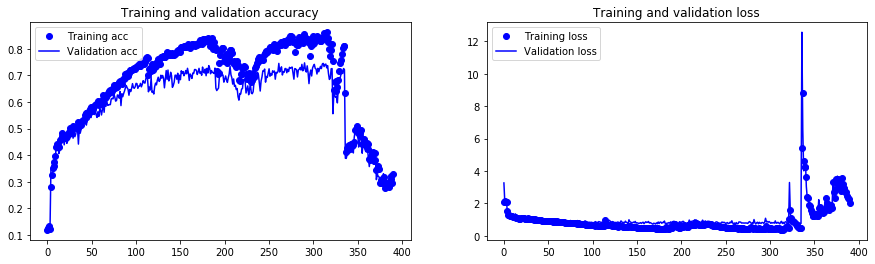

Test acc: 68.659 Val acc: 74.721 (At iteration 290) final training acc: 86.259
Test acc MIN LOSS model: 69.656 Val acc MIN LOSS model: 74.535 (At iteration 261) final training acc: 81.733
################################################################################################
det-2L-cuda-HU_32-remove0-FRAME-norm


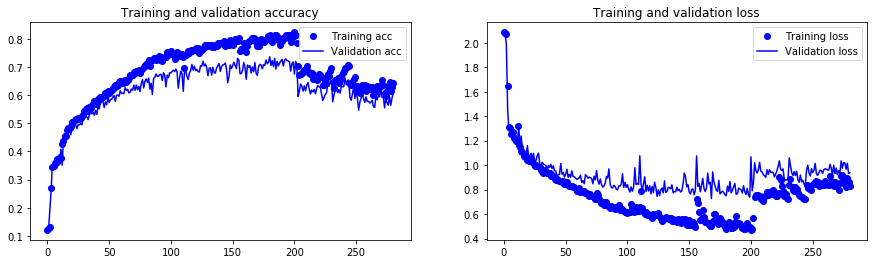

Test acc: 68.071 Val acc: 73.606 (At iteration 180) final training acc: 82.307
Test acc MIN LOSS model: 66.078 Val acc MIN LOSS model: 71.561 (At iteration 168) final training acc: 79.825
################################################################################################
det-2L-cuda-HU_96-remove0-3BAR-norm


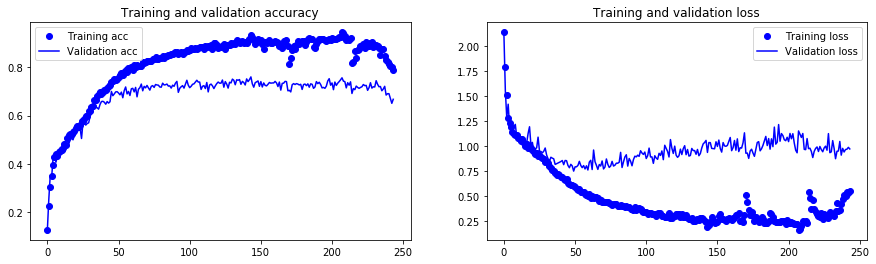

Test acc: 67.663 Val acc: 76.022 (At iteration 143) final training acc: 94.554
Test acc MIN LOSS model: 65.172 Val acc MIN LOSS model: 69.888 (At iteration 49) final training acc: 74.977
################################################################################################
det-2L-cuda-HU_128-remove0-FRAME-norm


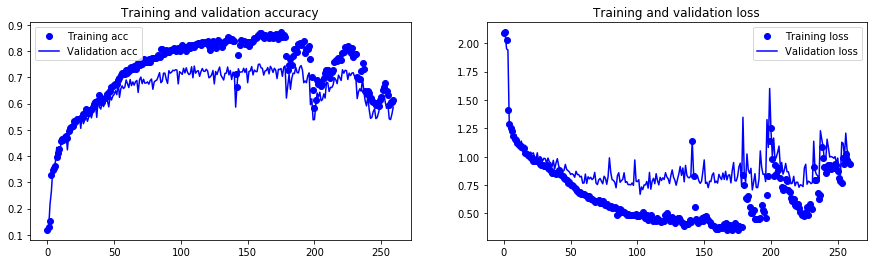

Test acc: 66.984 Val acc: 75.000 (At iteration 159) final training acc: 87.132
Test acc MIN LOSS model: 67.889 Val acc MIN LOSS model: 73.420 (At iteration 102) final training acc: 81.319
################################################################################################
det-2L-cuda-HU_32-remove0-VIDEO-norm


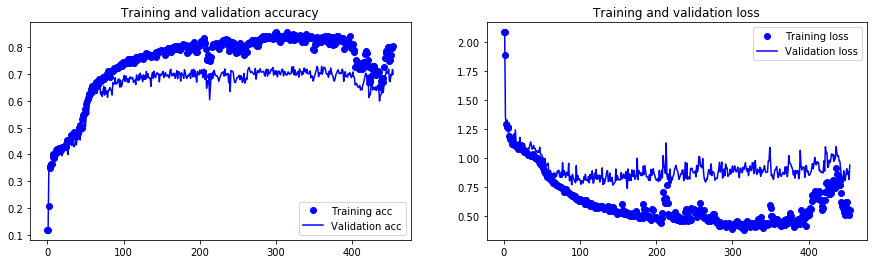

Test acc: 66.757 Val acc: 72.862 (At iteration 354) final training acc: 85.639
Test acc MIN LOSS model: 67.663 Val acc MIN LOSS model: 71.840 (At iteration 162) final training acc: 78.194


In [14]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
import numpy as np
from os.path import basename #, exists


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_subject_tough/"
SAVED_MODEL_FOLDER += "Cross_subject_mini/"
# SAVED_MODEL_FOLDER += "Cross_view/"
# SAVED_MODEL_FOLDER += "Cross_view_tough/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)

for result in loadedResults[:5]:
    historyPath = SAVED_MODEL_FOLDER+result["model_name"]+".pickle"
    with open(historyPath,"rb") as file_in:
        r = pickle.load(file_in)

    model_history = r["history"]
    print("################################################################################################")
    print(cleanForExcel(basename(historyPath)))
#     print(basename(historyPath))

    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize = (15,4))
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    ax1.legend()

    #     plt.figure()
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    ax2.legend()

    plt.show()
    print("Test acc: {:.3f} Val acc: {:.3f} (At iteration {}) final training acc: {:.3f}".format(result['test_acc']*100,max(val_acc)*100,np.argmax(val_acc),max(acc)*100))
    if "test_acc_minLoss" in result.keys():
        indexMinLoss = np.argmin(val_loss)
        print("Test acc MIN LOSS model: {:.3f} Val acc MIN LOSS model: {:.3f} (At iteration {}) final training acc: {:.3f}".format(result['test_acc_minLoss']*100,val_acc[indexMinLoss]*100,indexMinLoss,acc[indexMinLoss]*100))
    if "loaded_from" in r.keys():
        print("Loaded from:", cleanForExcel(r["loaded_from"]))

In [12]:
loadedResults[1]["model_name"]

'keypoint_rcnn_X_101_32x8d_FPN_3x-3L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-rec_drop-0.1'

In [5]:
result.keys()

dict_keys(['val_acc', 'test_acc', 'model_name', 'y_val_true', 'y_val_pred', 'y_test_true', 'y_test_pred', 'val_acc_minLoss', 'test_acc_minLoss', 'y_val_pred_minLoss', 'y_test_pred_minLoss'])

### Visualize missclassified

In [52]:
import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = None):
    plt.figure(figsize = (25,35))
    ax1 = plt.subplot(2, 1, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(2, 1, 2)
    
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()

Val acc: 0.863792194092827
Test acc: 0.9035864978902953


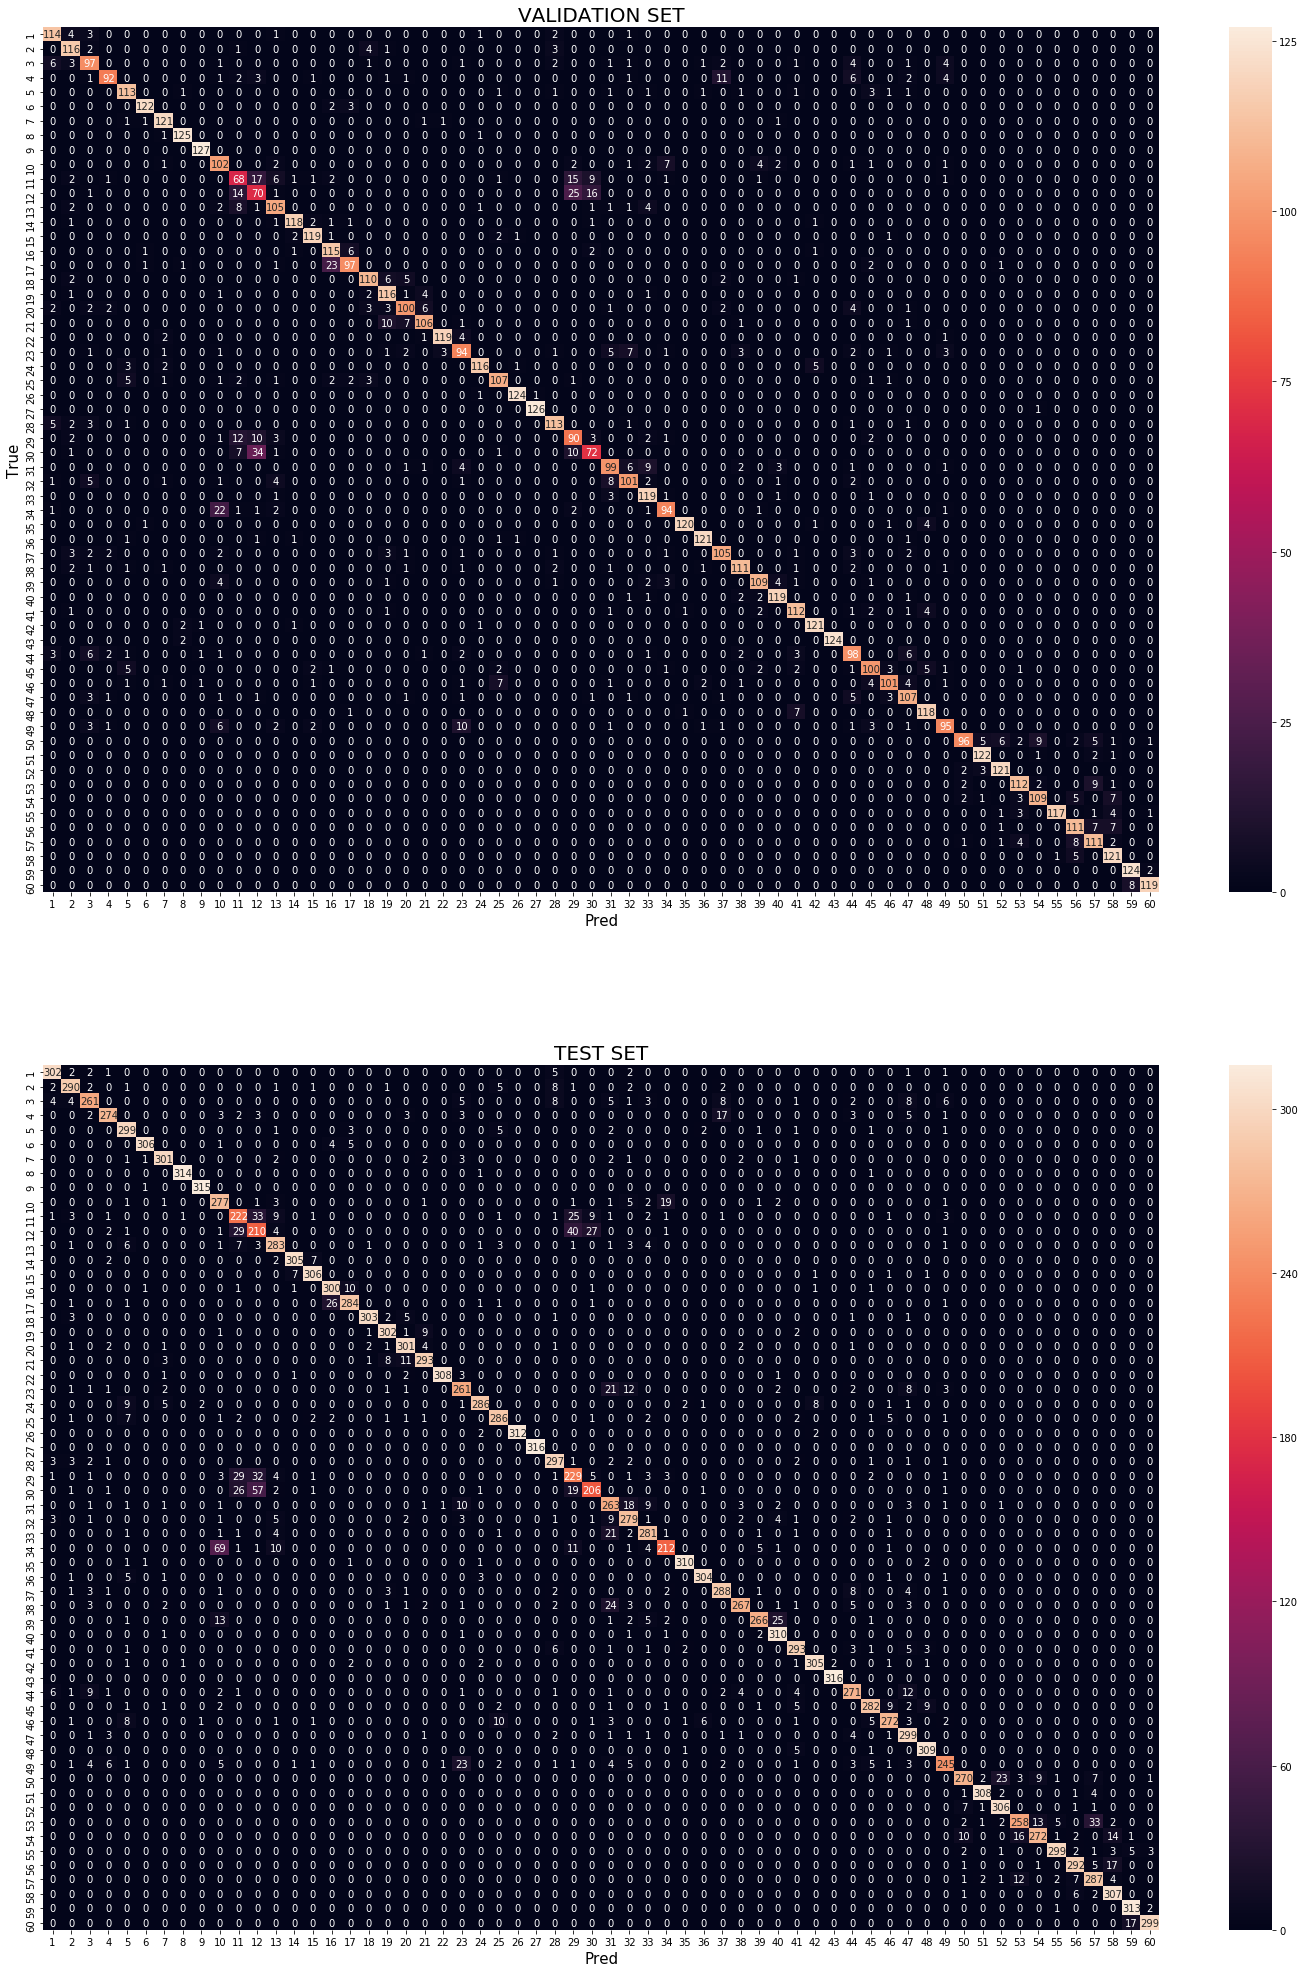

TEST PAIR CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [30, 11], [17, 16], [11, 29], [39, 40], [38, 31], [50, 52], [49, 23], [23, 31], [33, 31], [10, 34], [30, 29], [31, 32]]
TEST TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 39, 40, 38, 31, 50, 52, 49, 23, 33, 32]

VAL PAIR CONFUSED:
 [[30, 12], [12, 29], [17, 16], [34, 10], [11, 12], [12, 30], [11, 29], [12, 11], [29, 11], [4, 37], [29, 12], [21, 19], [49, 23], [30, 29], [11, 30], [50, 54], [53, 57], [31, 33], [13, 11], [60, 59], [57, 56]]
VAL TOPIC CONFUSED:
 [30, 12, 29, 17, 16, 34, 10, 11, 4, 37, 21, 19, 49, 23, 50, 54, 53, 57, 31, 33, 13, 60, 59, 56]

COMMON MOST CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [17, 16], [11, 29], [49, 23], [30, 29]]
COMMON TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23]
lenght: 12


In [54]:
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# label_order = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
#                '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
#                '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
#                '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
#                '6', '60', '7', '8', '9']


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  
# SAVED_MODEL_FOLDER += "Cross_subject_mini/" 
SAVED_MODEL_FOLDER += "Cross_view/"  
# SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
result = loadedResults[0]

y_val_pred = result["y_val_pred"]
y_val_true = result["y_val_true"]
y_test_pred = result["y_test_pred"]
y_test_true = result["y_test_true"]
val_acc = result["val_acc"]
test_acc = result["test_acc"]
print("Val acc:",val_acc)
print("Test acc:",test_acc)

# import pandas as pd
# y_actu_val = pd.Series(y_val_true, name='Actual')
# y_pred_val = pd.Series(y_val_pred, name='Predicted')
# conf_mat_val = pd.crosstab(y_actu_val, y_pred_val, rownames=['Actual'], colnames=['Predicted']
# #                            , margins=True
#                           )

# y_actu_test = pd.Series(y_test_true, name='Actual')
# y_pred_test = pd.Series(y_test_pred, name='Predicted')
# conf_mat_test = pd.crosstab(y_actu_test, y_pred_test, rownames=['Actual'], colnames=['Predicted']
# #                             , margins=True
#                            )

conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

# # normalize
# conf_mat_val = conf_mat_val / conf_mat_val.sum(axis=1)
# conf_mat_test = conf_mat_test / conf_mat_test.sum(axis=1)

labels = range(1,len(conf_mat_val[0])+1)
plotConfusionMatrixes(conf_mat_val,conf_mat_test,labelString=labels)

length = len(conf_mat_test)

till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [13]:
#CROSS_SUBJECT
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


TEST PAIR CONFUSED:
 [[12, 30], [10, 34], [11, 12], [29, 12], [31, 32], [11, 29], [17, 16], [16, 17], [34, 10], [29, 30], [12, 29], [11, 30], [30, 12], [29, 11], [39, 10], [53, 57], [31, 23], [46, 45], [1, 3], [52, 50], [15, 14]]
TEST TOPIC CONFUSED:
 [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 39, 53, 57, 23, 46, 45, 1, 3, 52, 50, 15, 14]

VAL PAIR CONFUSED:
 [[12, 30], [11, 12], [34, 10], [32, 23], [29, 12], [30, 12], [12, 29], [11, 29], [58, 56], [21, 19], [12, 11], [31, 32], [10, 34], [53, 57], [31, 23], [50, 51], [32, 31], [13, 5], [54, 58], [4, 37], [17, 16]]
VAL TOPIC CONFUSED:
 [12, 30, 11, 34, 10, 32, 23, 29, 58, 56, 21, 19, 31, 53, 57, 50, 51, 13, 5, 54, 4, 37, 17, 16]

COMMON MOST CONFUSED:
 [[12, 30], [10, 34], [11, 12], [29, 12], [31, 32], [11, 29], [17, 16], [34, 10], [12, 29], [30, 12], [53, 57], [31, 23]]
COMMON TOPIC CONFUSED:
 [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57, 23]
lenght: 13


In [11]:
#CROSS_VIEW
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


TEST PAIR CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [30, 11], [17, 16], [11, 29], [39, 40], [38, 31], [50, 52], [49, 23], [23, 31], [33, 31], [10, 34], [30, 29], [31, 32]]
TEST TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 39, 40, 38, 31, 50, 52, 49, 23, 33, 32]

VAL PAIR CONFUSED:
 [[30, 12], [12, 29], [17, 16], [34, 10], [11, 12], [12, 30], [11, 29], [12, 11], [29, 11], [4, 37], [29, 12], [21, 19], [49, 23], [30, 29], [11, 30], [50, 54], [53, 57], [31, 33], [13, 11], [60, 59], [57, 56]]
VAL TOPIC CONFUSED:
 [30, 12, 29, 17, 16, 34, 10, 11, 4, 37, 21, 19, 49, 23, 50, 54, 53, 57, 31, 33, 13, 60, 59, 56]

COMMON MOST CONFUSED:
 [[34, 10], [30, 12], [12, 29], [11, 12], [53, 57], [29, 12], [29, 11], [12, 11], [12, 30], [17, 16], [11, 29], [49, 23], [30, 29]]
COMMON TOPIC CONFUSED:
 [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23]
lenght: 12


In [14]:
view = [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23] # toughest cross_view
subj = [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57] # toughest cross_subject
subj.sort()
view.sort()
print("subj =", subj)
print("view =", view)

subj = [10, 11, 12, 16, 17, 29, 30, 31, 32, 34, 53, 57]
view = [10, 11, 12, 16, 17, 23, 29, 30, 34, 49, 53, 57]


## Re-evaluating model

In [41]:
import dill
import pickle
import numpy as np
from keras import models,layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Concatenate , Dense
from keras.models import Model,load_model
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
import random
from os import scandir
from os.path import exists
import shutil 

DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
fullModelNameToEvaluate = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0"

# folder_to_evaluate = "Cross_view/"  
folder_to_evaluate = "Cross_view_mini/"  
# folder_to_evaluate = "Cross_subject/"

completeFolderPath = SAVED_MODEL_FOLDER+folder_to_evaluate


assert exists(completeFolderPath+"summaryResults-Copy1.pickle")
print("Loading previous results...")
with open(completeFolderPath+"summaryResults-Copy1.pickle","rb") as handle:
    results = pickle.load(handle)

# results.sort(key=lambda x : x["test_acc"],reverse=True)

accessoriesPath = completeFolderPath+fullModelNameToEvaluate+".pickle"

print("Loading accessories:",accessoriesPath)
with open(accessoriesPath,"rb") as handle:
    accessories = pickle.load(handle)
            
print("Loading functions...")
loaded_specific_functions = [dill.loads(x) for x in accessories["spec_fun_DILL"]]

## SPECIFIC FUNCTIONS
specificFunctions = []
for elem in loaded_specific_functions:
    if callable(elem):
        specificFunctions.append(elem)
    elif not callable(elem):
        specificFunctions.append(elem[0])
                

if folder_to_evaluate.endswith("Cross_subject/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
if folder_to_evaluate.endswith("Cross_subject_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"
else:
    raise Exception("folder not recognised")
    
### LOADING DATASET ###
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                               val_set, 
                                                                               test_set,  
                                                                               specificFunctions)
encodingLabels = [int(i) for i in encodingLabels]

model = load_model(completeFolderPath+fullModelNameToEvaluate+".h5")
### EVALUATING MODEL ###      
val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))


minLossModelName = "{}-min_val_loss.hdf5".format(completeFolderPath+fullModelNameToEvaluate)
model_minLoss = load_model(minLossModelName)
val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

### SAVING RESULTS ###
newEvaluation = {"val_acc": val_acc, 
                "test_acc": test_acc, 
                "model_name": fullModelNameToEvaluate, 
                "y_val_true": y_val_true,
                "y_val_pred": y_val_pred,
                "y_test_true": y_test_true,
                "y_test_pred": y_test_pred,

                "val_acc_minLoss": val_acc_minLoss, 
                "test_acc_minLoss": test_acc_minLoss, 
                "y_val_pred_minLoss": y_val_pred_minLoss,
                "y_test_pred_minLoss": y_test_pred_minLoss
               }

previousResult = [v for v in results
     if v["model_name"] == fullModelNameToEvaluate]
isPreviousResult = np.array(results) == previousResult
indexPreviousResult = np.array(range(len(results)))[isPreviousResult]
if len(indexPreviousResult) == 0:
    print("model evaluated for the first time")
    results.append(newEvaluation)
else:
    print("substituting evaluation for the model")
    results[indexPreviousResult[0]] = newEvaluation



print("Dumping results...")
with open(completeFolderPath+"summaryResults.pickle","wb") as handle:
    pickle.dump(results, handle)

print("DONE!")


Loading previous results...
Loading accessories: /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0.pickle
Loading functions...
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the CENTER of each VIDEO
Adapting the data to the CENTER of each VIDEO
Ada

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Visualize nextFrameResults

In [32]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_MINI-dataset.pickle"

train_set, val_set, test_set = getData(datasetName)

train_set[0] = removeZerosFromDataset(train_set[0])
# train_set[0] = relativeToNextFrameBuilder(11)(train_set[0])
# train_set[0] = relativeToUpperMiddleBottomCentersOfVideo(train_set[0])
train_set[0] = cumulativeDifferences(train_set[0])
# train_set[0] = normalizeVideosXYInpid(train_set[0])
train_set[0] = normalizeVideos(train_set[0])

# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
print("DONE!")

train_set shape: (6451,)
train_set zero elements: 18496/19641018 (0.094%)
val_set shape: (1613,)
val_set zero elements: 6358/4906268 (0.13%)
test_set shape: (3312,)
test_set zero elements: 5032/10836820 (0.046%)
removing zeros from dataset
Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames
normalising EACH VIDEO, considering x and y TOGETHER
DONE!


In [34]:
from random import randint
video_ids = [randint(0,len(train_set[0])) for i in range(15)]

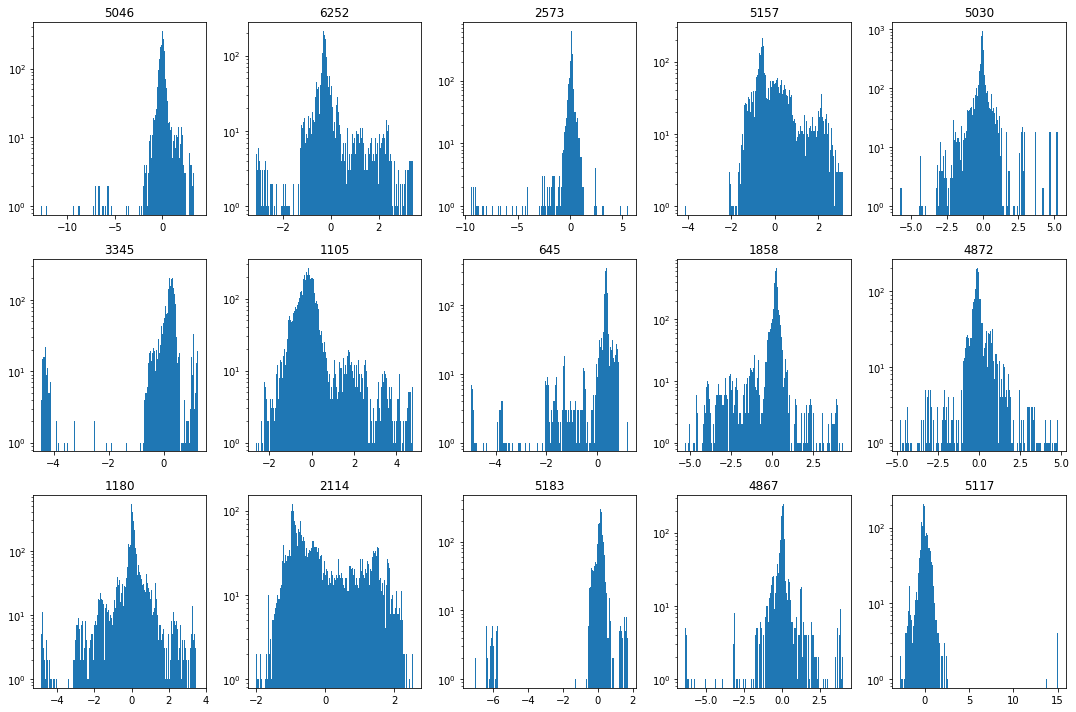

In [35]:
# CUMULATIVE DIFFERENCES
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

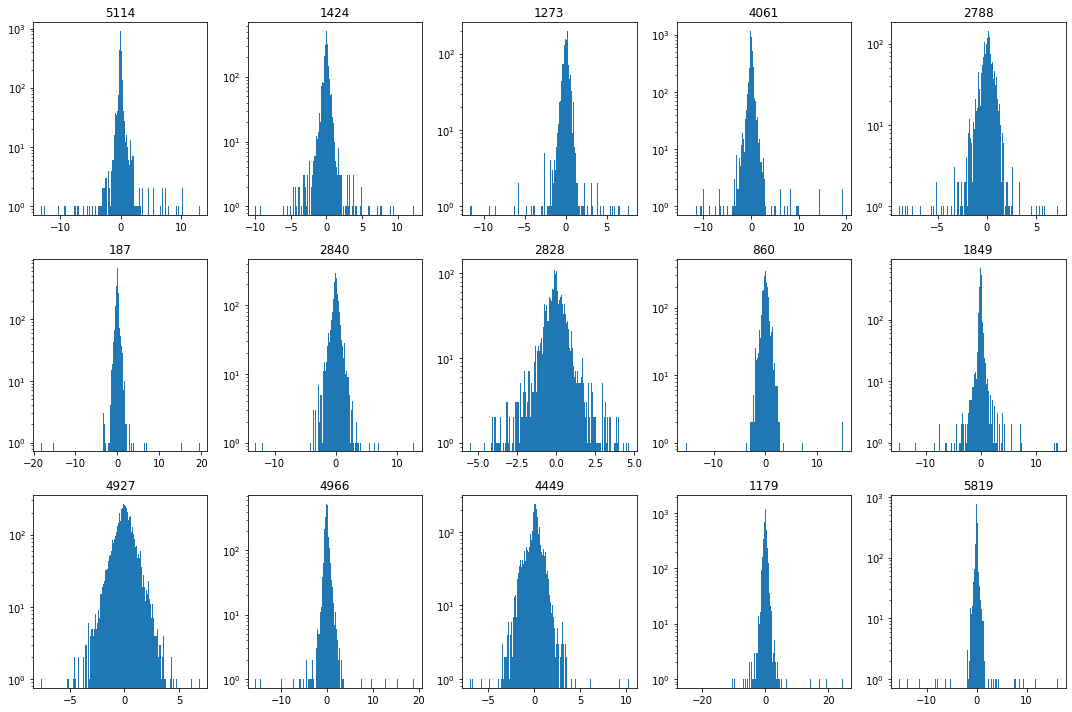

In [255]:
# NEXT FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

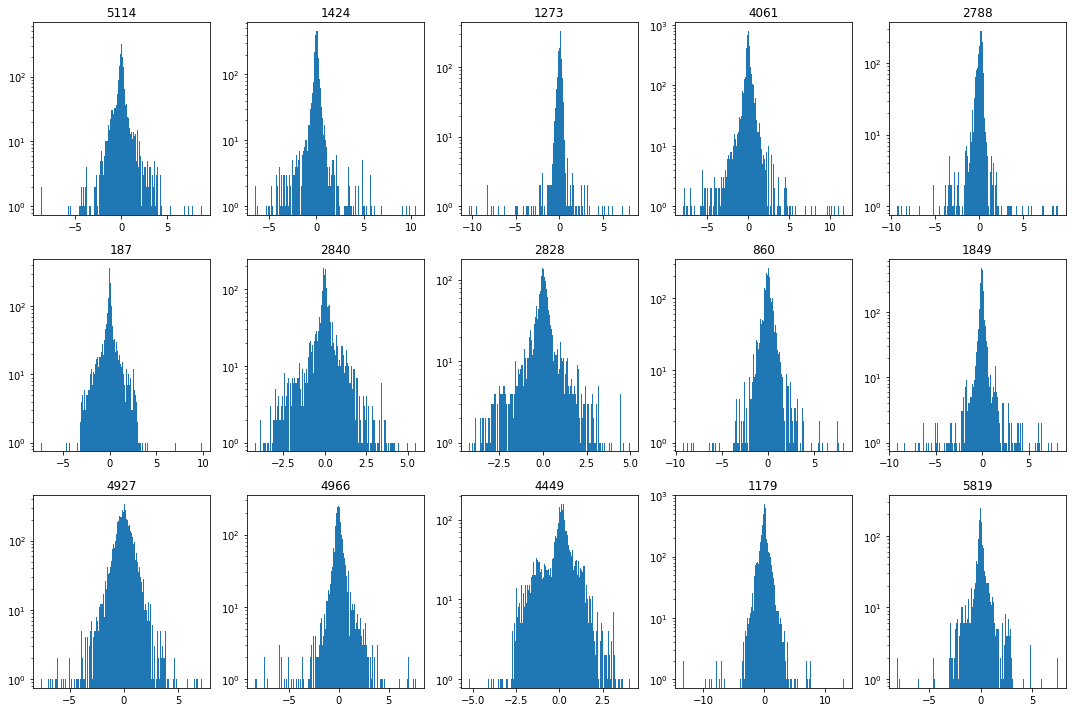

In [259]:
# NEXT 5 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

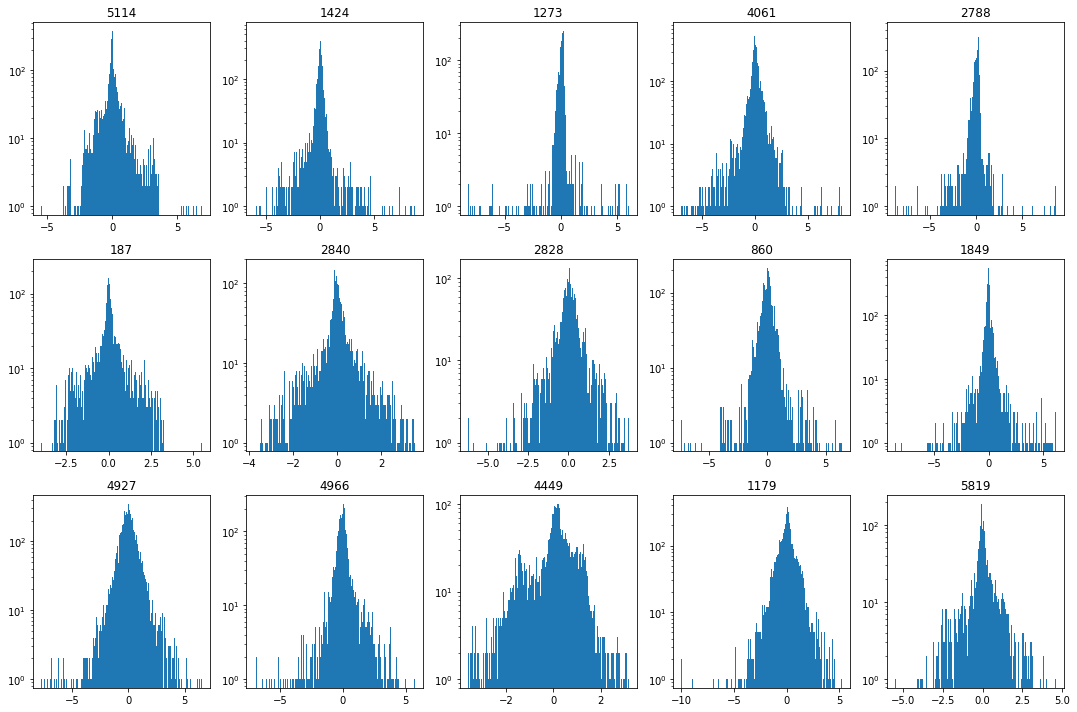

In [261]:
# NEXT 11 FRAME nomalizing INDIPENDENTLY
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

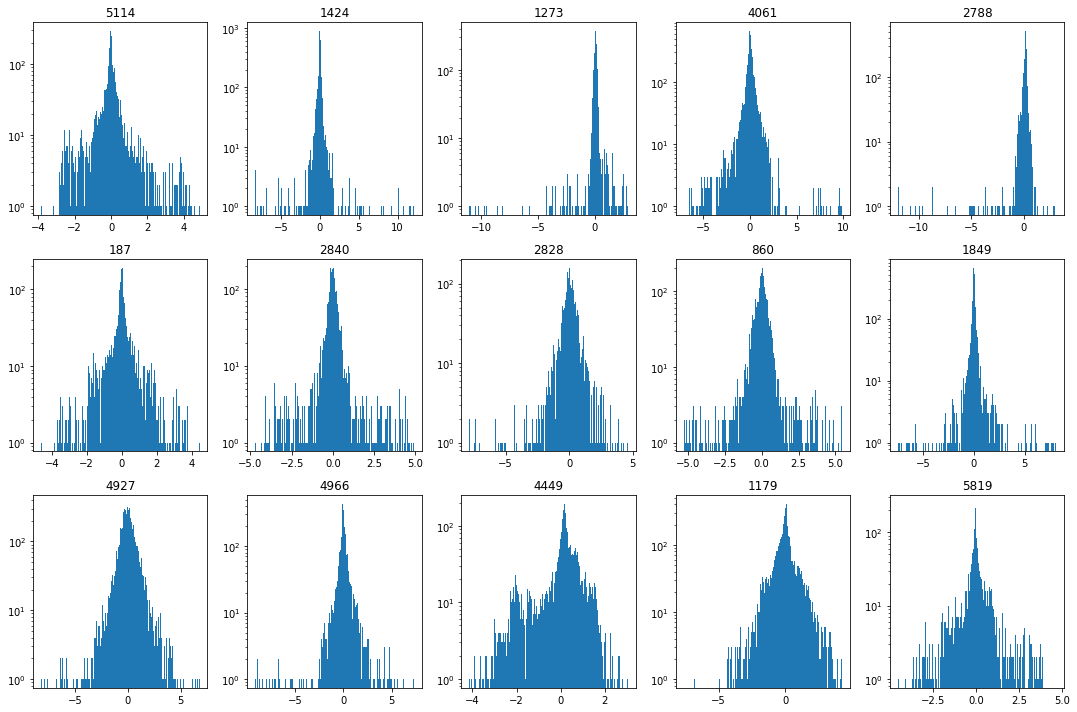

In [267]:
# NEXT 11 FRAME nomalizing TOGETHER
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

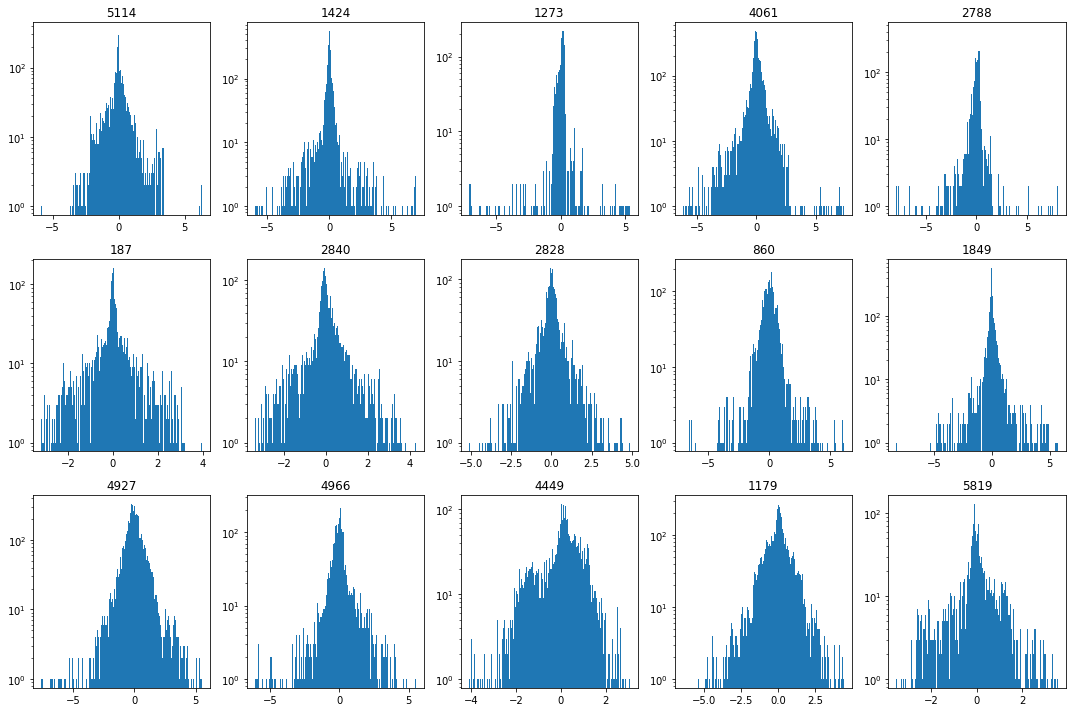

In [263]:
# NEXT 15 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

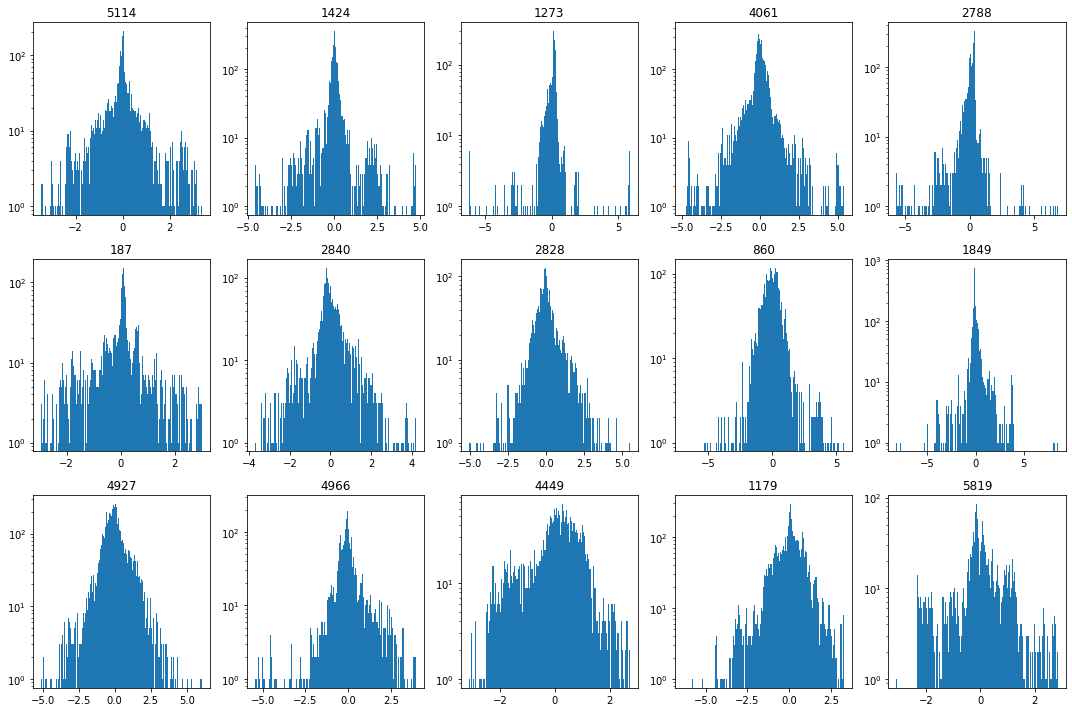

In [265]:
# NEXT 30 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

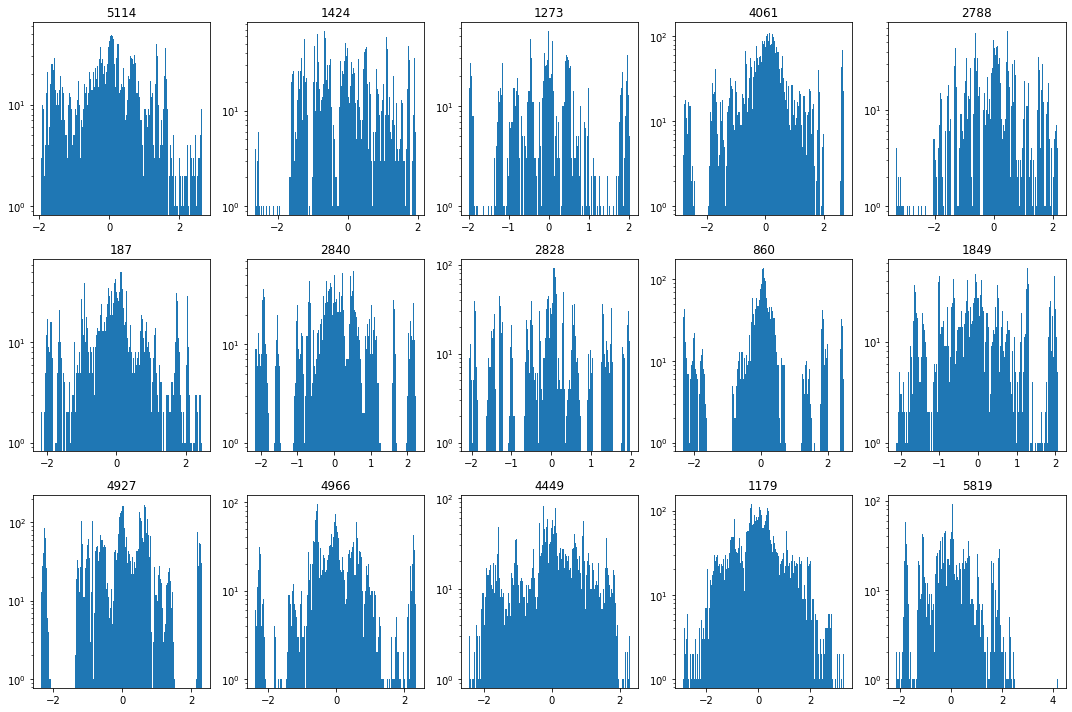

In [277]:
# 3BAR
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

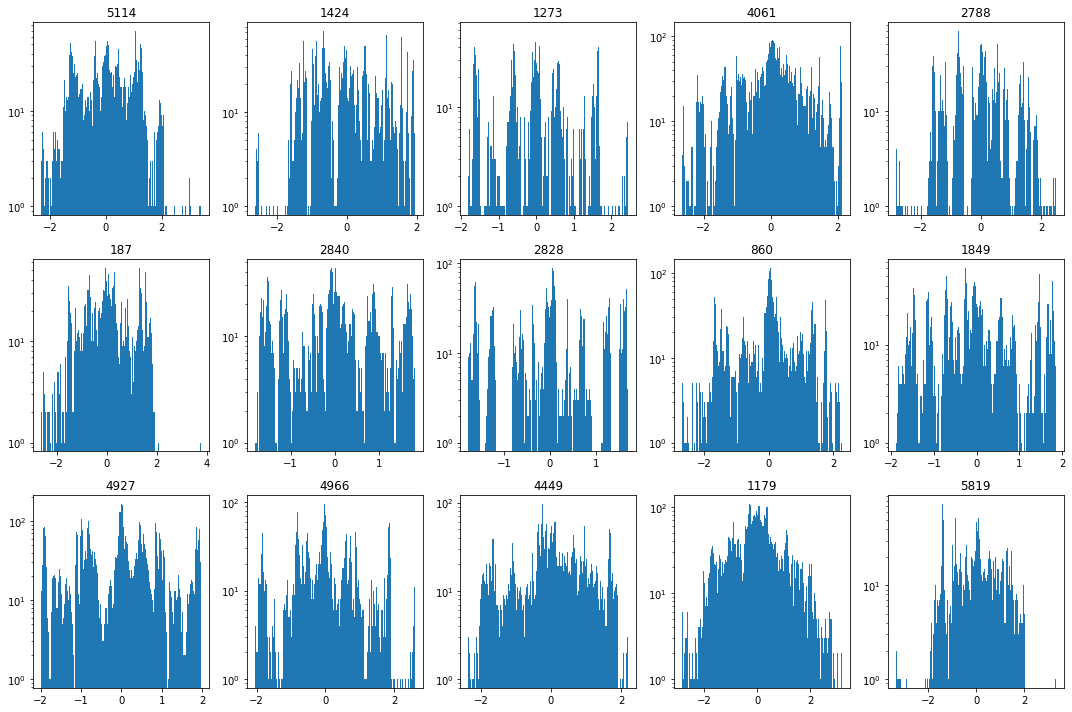

In [275]:
# 3BAR INDIP
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

## CLEAN Results

In [112]:
#remove last element of summary result

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

print("Removing",loadedResults[-1]['model_name'])
print ("From",SAVED_MODEL_FOLDER+"summaryResults.pickle")

# loadedResults = loadedResults[:-1]
# with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
#             pickle.dump(loadedResults, handle)

Removing keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo5CentersNTURGBofVideo-drop-0.1-rec_drop-0.1-norm
From /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Senesi/summaryResults.pickle


## Removing accessories file for low results

In [5]:
from os.path import isfile, isdir, join, exists,getsize,basename
from os import scandir
import pickle

NUMBER_OF_BEST_MODEL_TO_SAVE = 20

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
SAVED_MODEL_FOLDER += "Cross_view_mini/"
# SAVED_MODEL_FOLDER += "Cross_subject_mini/"


accessoryFileList = [f.path for f in scandir(SAVED_MODEL_FOLDER) 
                       if f.path.endswith(".pickle") 
                       and "summaryResult" not in basename(f)]

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"], reverse=True)
assert NUMBER_OF_BEST_MODEL_TO_SAVE > 10
bestModels = [r['model_name'] for r in loadedResults[:NUMBER_OF_BEST_MODEL_TO_SAVE]]

for accessoryFile in accessoryFileList:
    modelNameToCheck = basename(accessoryFile).replace(".pickle","")
    if modelNameToCheck not in bestModels:
        print("Removing",accessoryFile)
        !rm $accessoryFile

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0.5-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.5-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.05-rec_drop-0.05.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideos-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-normalizeVideos-drop-0.1-rec_drop-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.pickle


# AREA TEST

## Testing relativeToNextFrameFunction

In [23]:
MODEL_NAME
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 0/13984574 (0.0%)
val_set shape: (1365,)
val_set zero elements: 0/3509310 (0.0%)
test_set shape: (759,)
test_set zero elements: 0/1973564 (0.0%)


In [24]:
set_to_Test = train_set[0][:3]

In [26]:
len(set_to_Test)

3

In [32]:
differences = relativeToNextFrame(train_set[0])

Adapting the data to the next frame


In [36]:
train_set[0][0][:2]

[[[1007.7985, 325.73468],
  [1006.3635, 315.66202],
  [1002.0584, 315.66202],
  [961.87787, 322.85678],
  [979.09814, 318.53992],
  [956.1378, 376.0981],
  [969.053, 377.53705],
  [983.4032, 465.3133],
  [974.793, 460.99646],
  [1007.7985, 534.3832],
  [1006.3635, 532.9442],
  [961.87787, 528.6273],
  [964.74786, 528.6273],
  [957.5728, 646.62164],
  [961.87787, 648.0606],
  [954.7027, 747.3485],
  [959.0078, 755.9822]],
 [[1008.1875, 325.57687],
  [1006.7477, 315.524],
  [1002.42804, 315.524],
  [959.2314, 322.70465],
  [977.9499, 321.2685],
  [957.79144, 375.84143],
  [967.8706, 377.27756],
  [967.8706, 460.5731],
  [977.9499, 462.00922],
  [1016.82684, 533.8157],
  [1016.82684, 533.8157],
  [959.2314, 530.9434],
  [963.55096, 530.9434],
  [956.3515, 648.7061],
  [962.11115, 650.1422],
  [954.9117, 743.49066],
  [957.79144, 754.97974]]]

In [40]:
# trainAndVal = np.concatenate((X_train, X_val), axis=0)
print("normalising train, val and test values BEFORE padding")
trainMean = np.vstack(differences).mean() # the mean and std must be calculated only on the training data
trainStd = np.vstack(differences).std()
trainMean,trainStd

normalising train, val and test values BEFORE padding


(-0.056956816, 10.33186)

In [31]:
len(differences[0]),len(set_to_Test[0])

(52, 53)

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


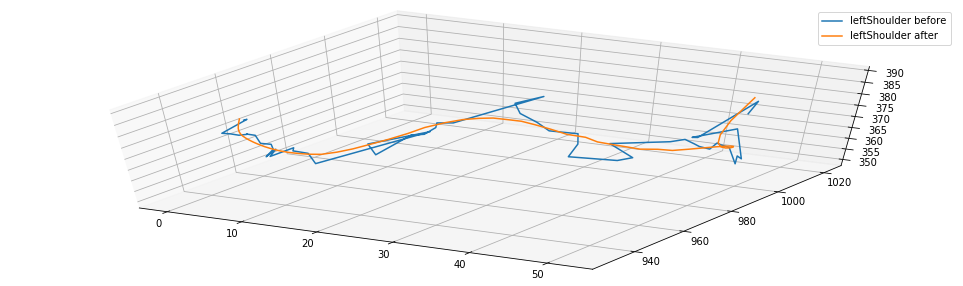

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

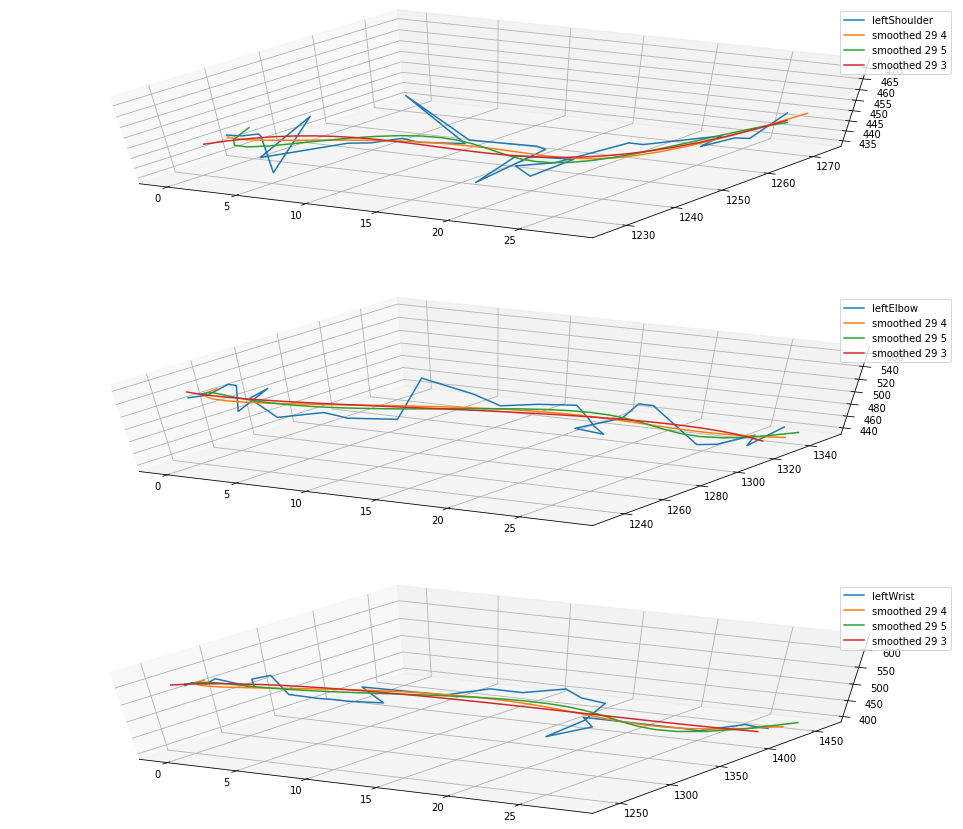

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

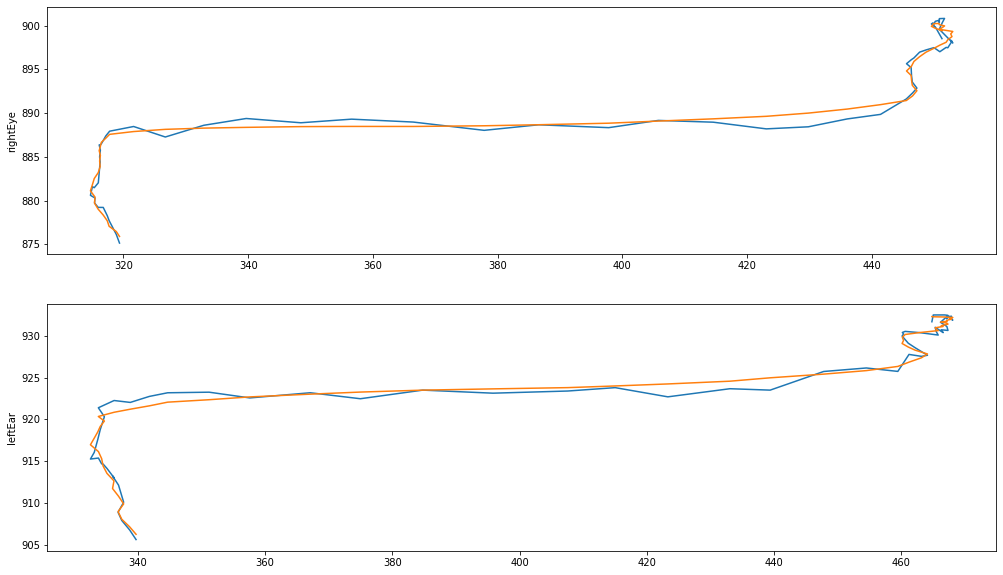

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

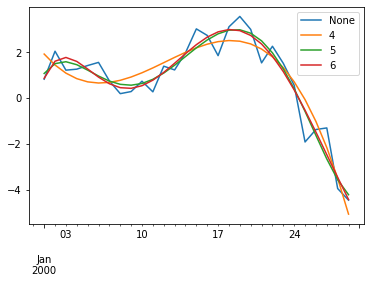

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()

In [150]:
getSaveFileName(MODEL_NAME,preprocess_functions,normalize)

PoseNet-101-smooth
PoseNet-101-smooth-53
PoseNet-101-smooth-53-3


In [14]:
for i, (specific_function, normalize) in enumerate(COMBINATIONS_TO_TEST):
    print(i,specific_function,normalize)

0 <function relativeToNextFrame at 0x7fab0effd7b8> True
1 <function relativeToUpperMiddleBottomCentersOfVideo at 0x7fab0effdea0> True
2 <function relativeToVideoCenter at 0x7fab0fd56e18> True


## load values

In [ ]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)


with open('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/PoseNet-101-relativeToNextFrame.pickle',"rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
relativeToNextFrame = loaded_functions[4]

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
model_history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


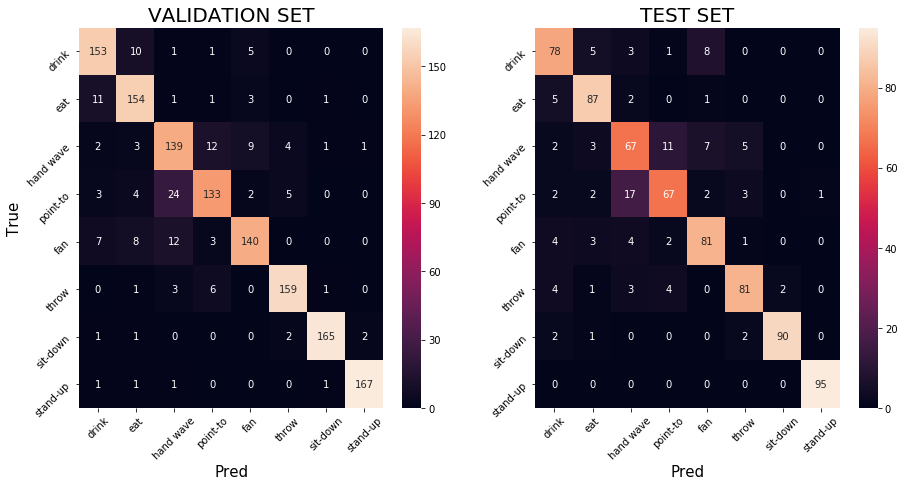

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


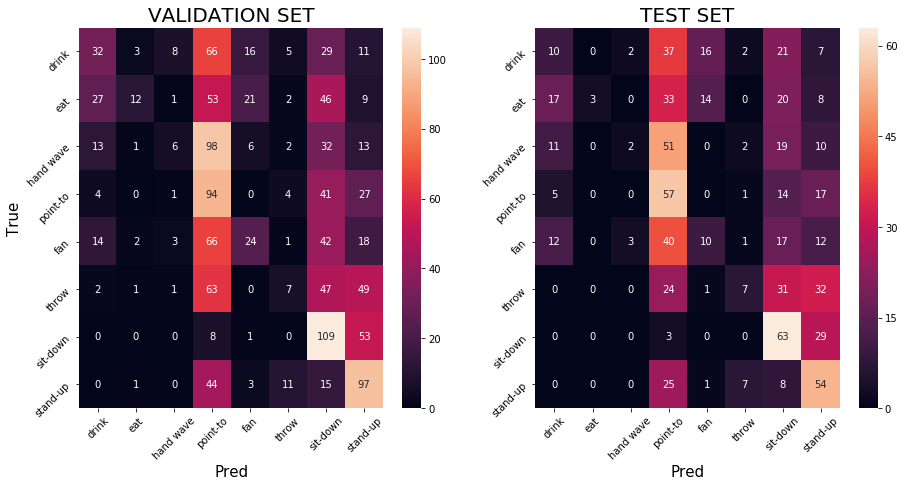

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


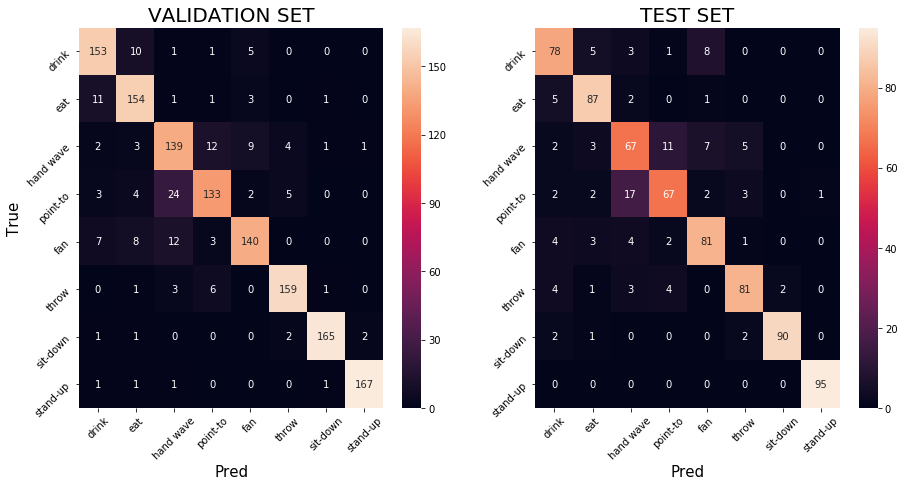

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# model_history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

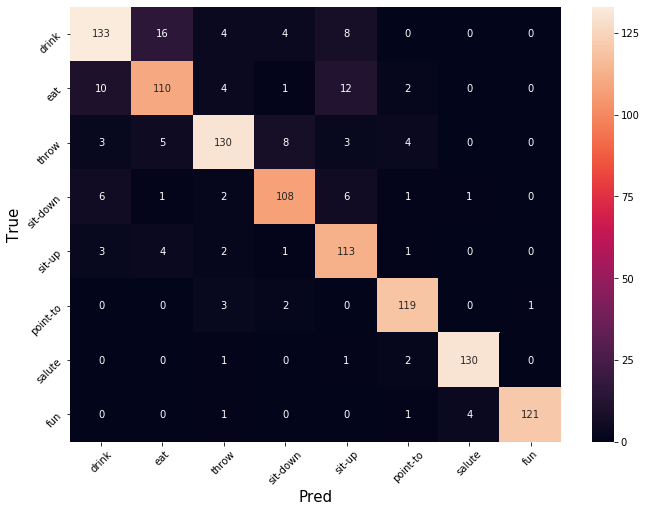

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


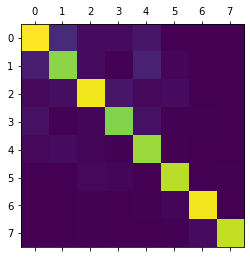

In [42]:
plt.matshow(conf_mat)